# One Genre To Rule Them All... Globally

We're going to analyze the worldwide box office returns of movies based on their genre.

This is the second step in our analysis. The first step was only considering the domestic market and can be found in the `Domestic.ipynb` notebook. 

To recap our findings there:
  - Horror is the safest genre to invest in. It's production budget is much lower than spectacle genres, and it has a higher chance of profitability on a per movie basis.
  - Action and Adventure are the riskiest genres. They're more expensive, and more often than not, they do not breakeven.
  
It's time now to see what the addition of the worldwide market does to our study!

# The Worldwide Market

It's difficult to pin down exact totals for the domestic versus worldwide box office, but it's clear with each passing year, more and more of a movie's gross comes from abroad.

[Statista](https://www.statista.com/) has 2018 totals being \\$11.9 billion for the [domestic market](https://www.statista.com/statistics/243180/leading-box-office-markets-workdwide-by-revenue/) and \\$29.2 billion for the [international market](https://www.statista.com/statistics/271856/global-box-office-revenue/).

That puts the total box office ratio at 29% domestic and 71% international.

We will use the same approach as our domestic analysis:
- Decide which genres to consider in our analysis.
 
- Decide on a profitability measure.

- Whittle our dataset down to movies released by the Big Five. This is to control for factors like lack of budget or marketing affecting a movie's success. Sure, independent movies can succeed, but our bosses want to see how the genres performed with all the help of a studio behind them.

- Analyze the historical performance of the genres by decade. There might be some trends over time that would be useful to know.

- Analyze the historical performance of the genres by release week. Maybe certain genres perform better at certain times of year.

- Incorporate our findings into a strategy for our bosses!

# Deciding on Genres

According to [The Numbers](https://www.the-numbers.com/market/), the top six genres in terms of box office gross are:
- Adventure
- Action
- Drama
- Comedy
- Thriller/Suspense
- Horror

Our bosses like making money.

Sold.

# Is This Movie Profitable? 

The box office share a studio makes from international sales varies incredibly from country to country.

An article on [Gizmodo](https://io9.gizmodo.com/how-much-money-does-a-movie-need-to-make-to-be-profitab-5747305) claims that a good rule of thumb is that a movie breaks even when it earns twice its production budget worldwide. 

## Profitability equation

We will include marketing costs when calculating the breakeven point. These numbers vary greatly from movie to movie, so we will again assume a 50% spend, pegged to each movie's production budget.   

**Worldwide box office = 2 * 1.5 * Production budget**

So if a movie earns at least three times its original production budget worldwide, it is a winner!

# Curate our dataset

## Import libraries and settings

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

pd.options.display.max_rows = 400
pd.options.display.max_columns = 50

## Import data

In [2]:
data = pd.read_csv('cleaned_movie_data.csv', parse_dates=['release_date'], usecols=['title', 'distributor_mojo', 'worldwide_adj', 'budget_adj',  'genres_mojo', 'release_year', 'release_week', 'release_date'])

# Only look at movies that made money domestically
data = data[data['worldwide_adj'].notna() & data['worldwide_adj'] > 0]

# Only look at movies with budget information
data = data[data['budget_adj'].notna()]

# For decade analysis
data['release_decade'] = data['release_year'].apply(lambda x: x // 10 * 10)

# For breakeven analysis
data['worldwide_breakeven'] = data['worldwide_adj'] >= 3 * data['budget_adj']

# For profit analysis
data['profit'] = data['worldwide_adj'] - 3 * data['budget_adj']

# Create columns for genres
# A movie can have multiple genres. If so, we will count them for all the genres its classified with.
data['action'] = data['genres_mojo'].str.contains('Action', na=False)
data['adventure'] = data['genres_mojo'].str.contains('Adventure', na=False) 
data['comedy'] = data['genres_mojo'].str.contains('Comedy', na=False)
data['drama'] = data['genres_mojo'].str.contains('Drama', na=False)
data['horror'] = data['genres_mojo'].str.contains('Horror', na=False)
data['thriller_suspense'] = data['genres_mojo'].str.contains('Thriller|Suspense', na=False, regex=True)

# Remove rows that don't contain one of our genres
data = data[data['action'] | data['adventure'] | data['comedy'] | data['drama'] | data['horror'] | data['thriller_suspense']]

# Create dataframes for the genres
action = data[data['genres_mojo'].str.contains('Action', na=False)]
adventure = data[data['genres_mojo'].str.contains('Adventure', na=False)] 
comedy = data[data['genres_mojo'].str.contains('Comedy', na=False)]
drama = data[data['genres_mojo'].str.contains('Drama', na=False)]
horror = data[data['genres_mojo'].str.contains('Horror', na=False)]
thriller_suspense = data[data['genres_mojo'].str.contains('Thriller|Suspense', na=False, regex=True)]

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3749 entries, 20 to 19775
Data columns (total 17 columns):
title                  3749 non-null object
release_year           3749 non-null int64
distributor_mojo       3749 non-null object
genres_mojo            3749 non-null object
release_date           3749 non-null datetime64[ns]
worldwide_adj          3749 non-null float64
budget_adj             3749 non-null float64
release_week           3749 non-null int64
release_decade         3749 non-null int64
worldwide_breakeven    3749 non-null bool
profit                 3749 non-null float64
action                 3749 non-null bool
adventure              3749 non-null bool
comedy                 3749 non-null bool
drama                  3749 non-null bool
horror                 3749 non-null bool
thriller_suspense      3749 non-null bool
dtypes: bool(7), datetime64[ns](1), float64(3), int64(3), object(3)
memory usage: 347.8+ KB


## Organize By Distributors

The [Big Five](https://en.wikipedia.org/wiki/Major_film_studio#Past) studios we will use in our analysis are:
- Universal
- Paramount
- Warner Bros.
- Disney
- Sony

Studios have come and gone a lot historically. They get bought out by competitors, or go out of business. A lot of messy stuff.

To simplify, we will categorize a movie by its current studio owner. So for example, Disney [recently purchased](https://theweek.com/speedreads/780191/disney-buys-21st-century-fox-713-billion) 20th Century Fox. So we will categorize a 20th Century Fox movie as Disney.

In [4]:
data[data['budget_adj'].notna() & data['distributor_mojo'].notna()]['distributor_mojo'].value_counts()

Universal                           355
Warner Bros.                        346
Fox                                 301
Sony / Columbia                     266
Paramount                           264
Buena Vista                         217
New Line                            122
Miramax                             114
Fox Searchlight                     106
Lionsgate                           104
MGM                                  89
Sony Classics                        81
Sony / Screen Gems                   69
Focus Features                       64
Warner Bros. (New Line)              49
Weinstein Company                    49
IFC                                  46
DreamWorks                           42
Columbia                             41
Magnolia                             41
United Artists                       41
Lions Gate                           41
Roadside Attractions                 35
TriStar                              34
Sony (Revolution)                    30


In [5]:
# Create a regex string to combine movies into their respective distributor
# https://en.wikipedia.org/wiki/Major_film_studio#Past
nbcuniversal = 'Universal|Focus Features|Focus World|Gramercy|Working Title|Big Idea|DreamWorks$|Illumination|Carnival|Mac Guff|United International'

print(data[data['distributor_mojo'].str.contains(nbcuniversal, na=False, regex=True)]['distributor_mojo'].value_counts())
print('Sum:', data[data['distributor_mojo'].str.contains(nbcuniversal, na=False, regex=True)]['distributor_mojo'].value_counts().sum())

Universal         355
Focus Features     64
DreamWorks         42
Gramercy           13
Focus World         3
Name: distributor_mojo, dtype: int64
Sum: 477


In [6]:
viacom = 'Paramount|BET|Comedy Central|MTV|Nickelodeon|Bardel Entertainment|MTV Animation|Nickelodeon Animation Studio|Awesomeness|CMT|Melange|United International Pictures|VH1|Viacom 18 Motion Pictures'

print(data[data['distributor_mojo'].str.contains(viacom, na=False, regex=True)]['distributor_mojo'].value_counts())
print('Sum:', data[data['distributor_mojo'].str.contains(viacom, na=False, regex=True)]['distributor_mojo'].value_counts().sum())

Paramount                 264
Paramount (DreamWorks)     18
Paramount Vantage          14
Paramount Classics         10
Paramount Insurge           2
Name: distributor_mojo, dtype: int64
Sum: 308


In [7]:
warnermedia = 'Warner Bros.|CNN Films|HBO|DC Films|New Line|Cartoon Network Studios|Wang Film Productions|Adult Swim Films|Castle Rock Entertainment|Cinemax|Flagship|Fullscreen|Hello Sunshine|Spyglass'

print(data[data['distributor_mojo'].str.contains(warnermedia, na=False, regex=True)]['distributor_mojo'].value_counts())
print('Sum:', data[data['distributor_mojo'].str.contains(warnermedia, na=False, regex=True)]['distributor_mojo'].value_counts().sum())

Warner Bros.               346
New Line                   122
Warner Bros. (New Line)     49
Name: distributor_mojo, dtype: int64
Sum: 517


In [8]:
disney = 'Walt Disney|^Fox$|Fox Atomic|A&E|Disneynature|ESPN|Fox Searchlight|Hulu|National Geographic|VICE|Fox Family|Lucasfilm|Marvel|The Muppets Studio|UTV Motion Pictures|20th Century Fox Animation|Blue Sky Studios|Lucasfilm Animation|Marvel Animation|Pixar Animation Studios|Buena Vista|Disney|Dragonfly Film Productions|Fox Star Studios|Fox Studios Australia|Kudos Film|New Regency|Patagonik Film Group|Shine Group|Tiger Aspect Productions|Zero Day Fox'

print(data[data['distributor_mojo'].str.contains(disney, na=False, regex=True)]['distributor_mojo'].value_counts())
print('Sum:', data[data['distributor_mojo'].str.contains(disney, na=False, regex=True)]['distributor_mojo'].value_counts().sum())

Fox                301
Buena Vista        217
Fox Searchlight    106
Fox Atomic           3
Disney               1
Name: distributor_mojo, dtype: int64
Sum: 628


In [9]:
sony = 'Sony|Columbia|Affirm|Screen Gems|Stage 6|Ghost Corps|Funimation|Madhouse|Manga Entertainment UK|TriStar|Destination Films|Left Bank Pictures|Triumph Films'

print(data[data['distributor_mojo'].str.contains(sony, na=False, regex=True)]['distributor_mojo'].value_counts())
print('Sum:', data[data['distributor_mojo'].str.contains(sony, na=False, regex=True)]['distributor_mojo'].value_counts().sum())

Sony / Columbia        266
Sony Classics           81
Sony / Screen Gems      69
Columbia                41
TriStar                 34
Sony (Revolution)       30
Sony / AFFIRM Films      2
Name: distributor_mojo, dtype: int64
Sum: 523


In [10]:
data['universal'] = data['distributor_mojo'].str.contains(nbcuniversal, na=False, regex=True)
data['paramount'] = data['distributor_mojo'].str.contains(viacom, na=False, regex=True)
data['warner'] = data['distributor_mojo'].str.contains(warnermedia, na=False, regex=True)
data['disney'] = data['distributor_mojo'].str.contains(disney, na=False, regex=True)
data['sony'] = data['distributor_mojo'].str.contains(sony, na=False, regex=True)
data['distributor'] = np.nan

In [11]:
data.loc[data['universal'], 'distributor'] = 'Universal'
data.loc[data['paramount'], 'distributor'] = 'Paramount'
data.loc[data['warner'], 'distributor'] = 'Warner'
data.loc[data['disney'], 'distributor'] = 'Disney'
data.loc[data['sony'], 'distributor'] = 'Sony'

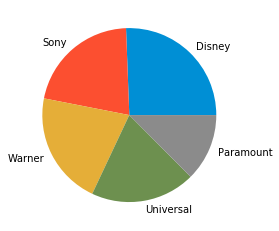

In [12]:
# We only want to keep rows that have one of the Big Five
data = data[data['distributor'].notna()]

figure, axis = plt.subplots()

data['distributor'].value_counts().plot(kind='pie')
axis.set_ylabel('');

## Check Movies By Decade

We have very few movies from before the 1970s. We will remove these entries to simplify our analysis.

In [13]:
data['release_decade'].value_counts()

2000    1047
2010     740
1990     501
1980     114
1970      31
1960       9
1950       8
1930       2
1940       1
Name: release_decade, dtype: int64

In [14]:
data = data[data['release_decade'] >= 1970]

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2433 entries, 20 to 19775
Data columns (total 23 columns):
title                  2433 non-null object
release_year           2433 non-null int64
distributor_mojo       2433 non-null object
genres_mojo            2433 non-null object
release_date           2433 non-null datetime64[ns]
worldwide_adj          2433 non-null float64
budget_adj             2433 non-null float64
release_week           2433 non-null int64
release_decade         2433 non-null int64
worldwide_breakeven    2433 non-null bool
profit                 2433 non-null float64
action                 2433 non-null bool
adventure              2433 non-null bool
comedy                 2433 non-null bool
drama                  2433 non-null bool
horror                 2433 non-null bool
thriller_suspense      2433 non-null bool
universal              2433 non-null bool
paramount              2433 non-null bool
warner                 2433 non-null bool
disney                 

## Summary

Our filtered dataset now has 2,433 entries. 

The movie studios all have a fair chunk of the dataset. This will hopefully prevent bias stemming from lack of equitable market share.

We have no missing values, so we can do all monetary calculations safely. 

# Create Graphing Helper Function and Summary DataFrame

In [15]:
# Tailored from matplotlib documentation
# https://matplotlib.org/examples/api/barchart_demo.html

# Function to add counts/percentages to bar plots
def autolabel(axis, num_decimals=0, counts=None):
    """
    Attach a text label above each bar displaying its height.
    If sent a list of counts, display those instead.
    """
    for i, val in enumerate(axis.patches):
        if counts is not None:
            height = counts[i]
        else:
            height = round(val.get_height(), num_decimals) if num_decimals > 0 else int(val.get_height())
        
        # We don't want to display zeros on our bar plots
        if height == 0:
            continue
            
        # Put the count below a negative value bar
        if height < 0:
            axis.text(val.get_x() + val.get_width()/2, val.get_height()*0.95, '{}'.format(height), ha='center', va='bottom', fontsize=20)
        else:
            axis.text(val.get_x() + val.get_width()/2, val.get_height()*1.05, '{}'.format(height), ha='center', va='bottom', fontsize=20)

In [143]:
# Create custom function to generate the color list when graphing
def generate_color_list(colors_needed=1, order_list=genres):
    colors_available = ['color1', 'color2', 'color3']
    c_list = []
    
    # Matplotlib needs a list of colors if the graph doesn't have multiple columns per index
    if colors_needed == 1:
        c_list = [genres_dict[genre][colors_available[0]] for genre in order_list]
        return c_list
    
    # Matplotlib needs a list of tuples if the graph has multiple columns per index
    for i in range(colors_needed):
        temp_tuple = tuple([genres_dict[genre][colors_available[i]] for genre in order_list])
        c_list.append(temp_tuple)
        
    return c_list

In [144]:
# Create lists of useful information for graphing
genres = ['action', 'adventure', 'comedy', 'drama', 'horror', 'thriller_suspense']
colors = ['#008FD5', '#FC4F30', '#E5AE38', '#6D904F', '#8B8B8B', '#810F7C']
colors2 = ['#87C7E5', '#F4BAB0', '#F4DBA8', '#C7E2AE', '#D6D1D1', '#CE8EDB']
colors3 = ['#C5E7F7', '#F4D7D2', '#F9ECD1', '#E3F2D5', '#EAE8E8', '#ECC8F4']

# Create a dictionary holding the colors for each genre
genres_dict = {
    'action': {'color1': '#008FD5', 'color2': '#87C7E5', 'color3': '#C5E7F7'},
    'adventure': {'color1': '#FC4F30', 'color2': '#F4BAB0', 'color3': '#F4D7D2'},
    'comedy': {'color1': '#E5AE38', 'color2': '#F4DBA8', 'color3': '#F9ECD1'},
    'drama': {'color1': '#6D904F', 'color2': '#C7E2AE', 'color3': '#E3F2D5'},
    'horror': {'color1': '#8B8B8B', 'color2': '#D6D1D1', 'color3': '#EAE8E8'},
    'thriller_suspense': {'color1': '#810F7C', 'color2':  '#CE8EDB', 'color3': '#ECC8F4'}
    }

# Create a summary statistics dataframe separated by genre to make graphing easier
# The columns are:
# Number of movies
# Average gross
# All-time gross
# Average budget
# All-time budget
# Dollar earned for dollar spent (including marketing -- adjusted budget is 1.5 times original budget)
# Median dollars earned for dollars spent
# Mean dollars earned for dollars spent
# Median profit
# Mean profit
# All-time profit
# Breakeven percentage
# Current decade (2010s) median profit
# Current decade (2010s) mean profit
# Current decade (2010s) all profit
# Current decade (2010s) breakeven percentage

aggregation_stats_per_genre = {
    'num_movies': [data[genre].sum() for genre in genres],
    'avg_gross': [round(data[data[genre]]['worldwide_adj'].mean() / 1000000, 1) for genre in genres],
    'median_gross': [round(data[data[genre]]['worldwide_adj'].median() / 1000000, 1) for genre in genres], 
    'all_time_gross': [round(data[data[genre]]['worldwide_adj'].sum() / 1000000000, 1) for genre in genres],
    'avg_budget': [round(data[data[genre]]['budget_adj'].mean() / 1000000, 1) for genre in genres],
    'median_budget': [round(data[data[genre]]['budget_adj'].median() / 1000000, 1) for genre in genres],
    'all_time_budget': [round(data[data[genre]]['budget_adj'].sum() / 1000000000, 1) for genre in genres],
    'dollars_earned_for_dollars_spent': [round((data[data[genre]]['worldwide_adj'].sum() / 1000000) / (3 * data[data[genre]]['budget_adj'].sum() / 1000000), 1) for genre in genres],
    'median_dollars_earned_for_dollars_spent': [round((data[data[genre]]['worldwide_adj'].median() / 1000000) / (3 * data[data[genre]]['budget_adj'].median() / 1000000), 1) for genre in genres],
    'mean_dollars_earned_for_dollars_spent': [round((data[data[genre]]['worldwide_adj'].mean() / 1000000) / (3 * data[data[genre]]['budget_adj'].mean() / 1000000), 1) for genre in genres],
    'median_profit': [round((data[data[genre]]['profit'].median() / 1000000), 1) for genre in genres],
    'mean_profit': [round((data[data[genre]]['profit'].mean() / 1000000), 1) for genre in genres],
    'all_time_profit': [round(data[data[genre]]['profit'].sum() / 1000000000, 1) for genre in genres],
    'breakeven_percentage': [round(data[data[genre]]['worldwide_breakeven'].sum() / data[data[genre]]['worldwide_breakeven'].count() * 100, 1) for genre in genres],
    'current_decade_median_profit': [round((data[(data[genre]) & (data['release_year'] >=2010)]['profit'].median() / 1000000), 1) for genre in genres],
    'current_decade_mean_profit': [round((data[(data[genre]) & (data['release_year'] >=2010)]['profit'].mean() / 1000000), 1) for genre in genres],
    'current_decade_profit': [round(data[(data[genre]) & (data['release_year'] >=2010)]['profit'].sum() / 1000000000, 1) for genre in genres],
    'current_decade_breakeven_percentage': [round(data[(data[genre]) & (data['release_year'] >=2010)]['worldwide_breakeven'].mean() * 100, 1) for genre in genres]
}

# Bird's Eye View Of The Data

In [17]:
summary = pd.DataFrame(aggregation_stats_per_genre, index=genres)
summary

num_movies  avg_gross  median_gross  all_time_gross  \
action                    479      315.6         208.5           151.2   
adventure                 250      392.9         258.3            98.2   
comedy                    955      131.1          77.6           125.2   
drama                     654      104.8          57.2            68.5   
horror                    252      174.3          95.9            43.9   
thriller_suspense         347      147.9          93.2            51.3   

                   avg_budget  median_budget  all_time_budget  \
action                  102.5           90.3             49.1   
adventure               124.1          120.4             31.0   
comedy                   45.6           35.8             43.6   
drama                    40.8           30.7             26.7   
horror                   44.4           31.5             11.2   
thriller_suspense        57.0           53.0             19.8   

                   dollars_earned_for_dollars_spent  \
action                                          1.0   
adventure                                       1.1   
comedy                                          1.0   
drama                                           0.9   
horror                                          1.3   
thriller_suspense                               0.9   

                   median_dollars_earned_for_dollars_spent  \
action                                                 0.8   
adventure                                              0.7   
comedy                                                 0.7   
drama                                                  0.6   
horror                                                 1.0   
thriller_suspense                                      0.6   

                   mean_dollars_earned_for_dollars_spent  median_profit  \
action                                               1.0          -25.8   
adventure                                            1.1          -45.6   
comedy                                               1.0          -20.0   
drama                                                0.9          -24.7   
horror                                               1.3           -4.9   
thriller_suspense                                    0.9          -36.3   

                   mean_profit  all_time_profit  breakeven_percentage  \
action                     8.1              3.9                  40.3   
adventure                 20.6              5.2                  39.2   
comedy                    -5.8             -5.6                  35.7   
drama                    -17.6            -11.5                  33.9   
horror                    41.1             10.4                  47.6   
thriller_suspense        -23.0             -8.0                  32.6   

                   current_decade_median_profit  current_decade_mean_profit  \
action                                      5.7                        70.3   
adventure                                  10.4                        72.5   
comedy                                    -12.7                        -4.6   
drama                                     -12.7                        -0.4   
horror                                     23.3                        53.1   
thriller_suspense                         -15.3                         5.4   

                   current_decade_profit  current_decade_breakeven_percentage  
action                              12.4                                 51.7  
adventure                            6.5                                 50.6  
comedy                              -1.2                                 39.1  
drama                               -0.1                                 38.8  
horror                               3.9                                 62.2  
thriller_suspense                    0.5                                 41.3

## Number of movies

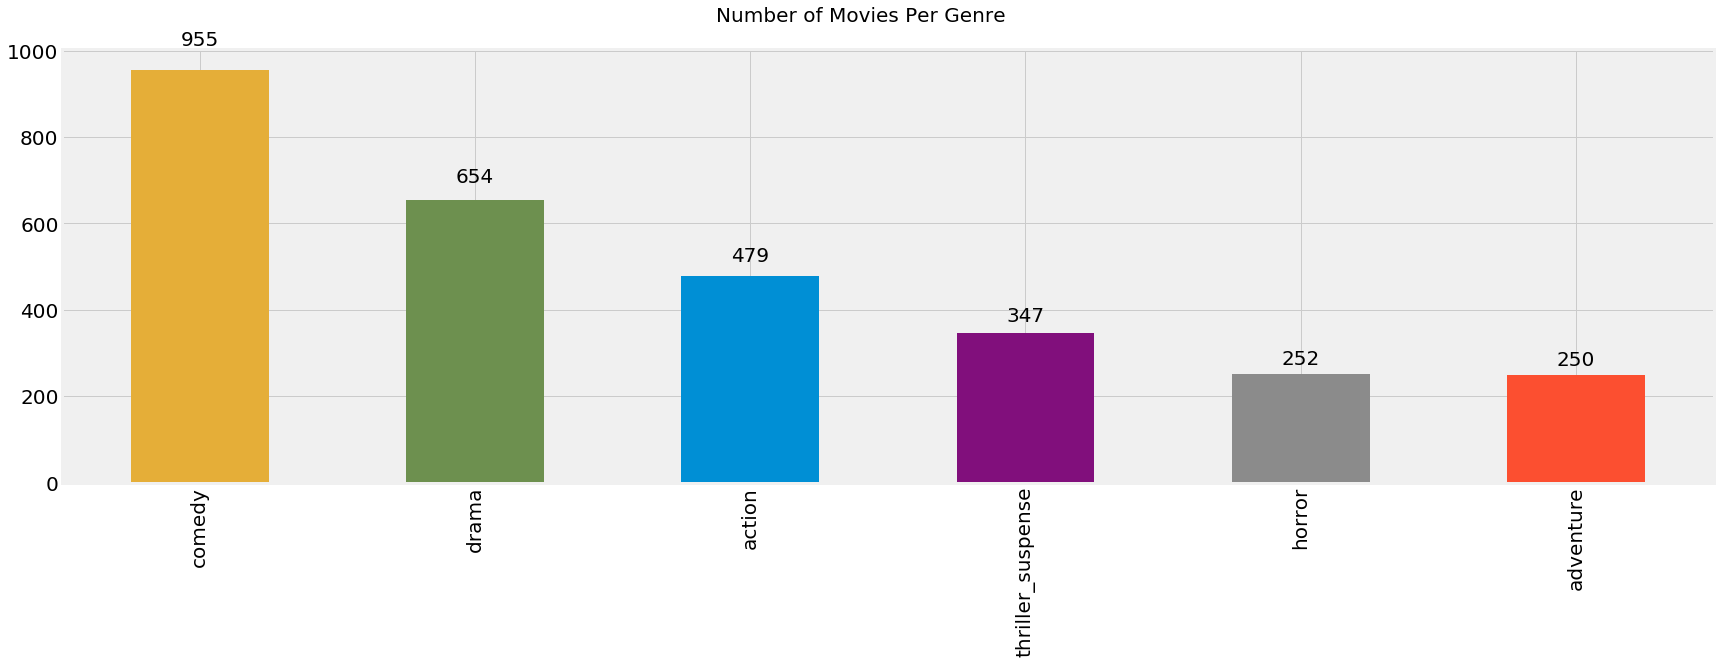

In [148]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Number of Movies Per Genre', fontsize=20, y=1.02)

summary.sort_values('num_movies', ascending=False, inplace=True)

color_list = generate_color_list(colors_needed=1, order_list=summary.index)

summary.plot(y='num_movies', kind='bar', color=color_list, ax=axis, legend=False, fontsize=20)
axis.set_ylabel('', fontsize=20)
axis.set_xlabel('', fontsize=20)
axis.tick_params(labelsize=20)
autolabel(axis)

plt.tight_layout()

## Grosses

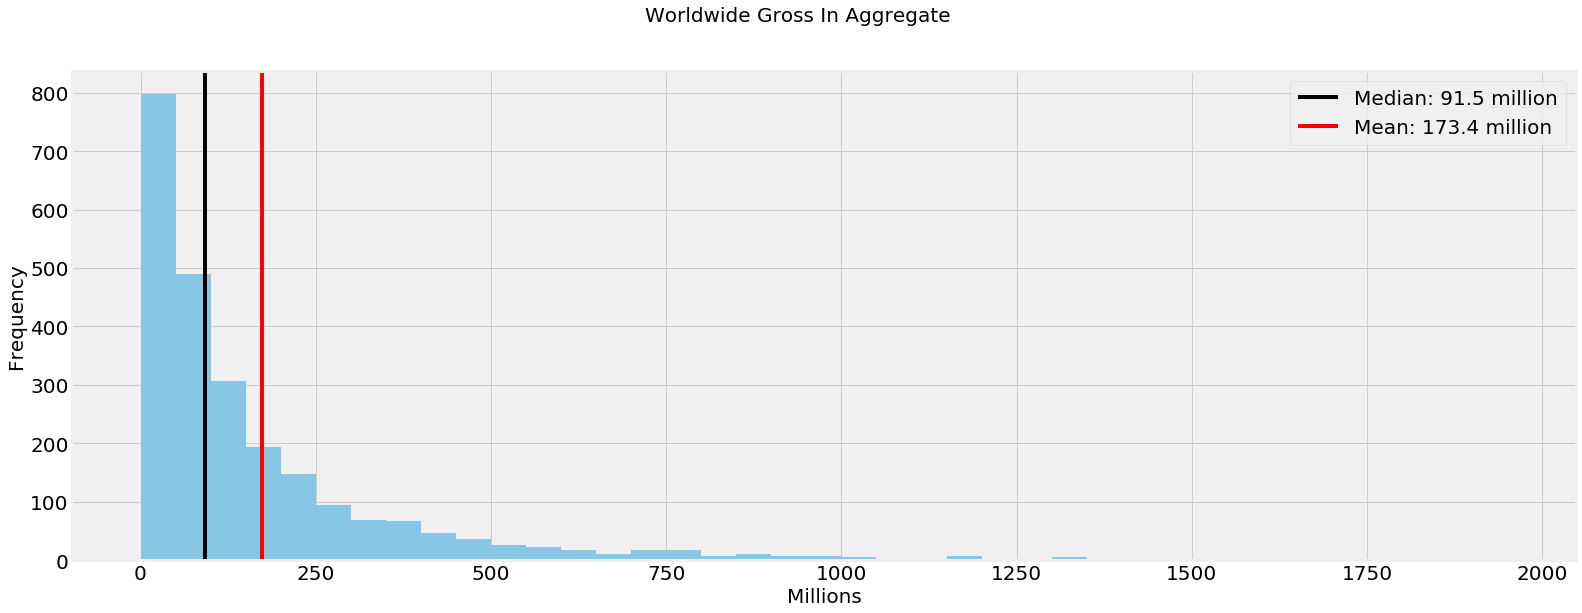

In [149]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24,9))
figure.suptitle('Worldwide Gross In Aggregate', fontsize=20)

(data['worldwide_adj'] / 1000000).plot.hist(range(0, 2000, 50), ax=axis, fontsize=20, color=genres_dict['action']['color2']);
axis.set_xlabel('Millions', fontsize=20)
axis.set_ylabel('Frequency', fontsize=20)
axis.axvline(data['worldwide_adj'].median() / 1000000, color='k')
axis.axvline(data['worldwide_adj'].mean() / 1000000, color='r')
axis.legend(['Median: {:.1f} million'.format(data['worldwide_adj'].median() / 1000000), 'Mean: {:.1f} million'.format(data['worldwide_adj'].mean() / 1000000)], fontsize=20);

## Budgets

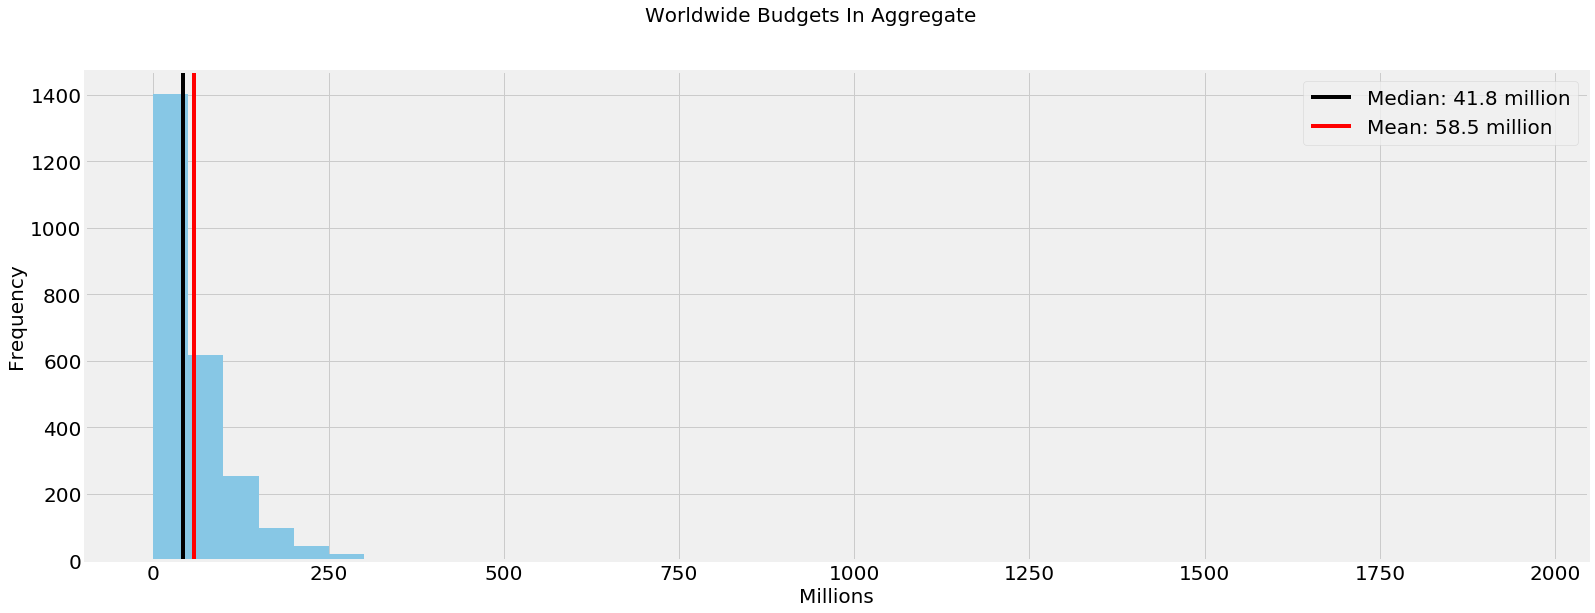

In [150]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24,9))
figure.suptitle('Worldwide Budgets In Aggregate', fontsize=20)

(data['budget_adj'] / 1000000).plot.hist(range(0, 2000, 50), ax=axis, fontsize=20, color=genres_dict['action']['color2']);
axis.set_xlabel('Millions', fontsize=20)
axis.set_ylabel('Frequency', fontsize=20)
axis.axvline(data['budget_adj'].median() / 1000000, color='k')
axis.axvline(data['budget_adj'].mean() / 1000000, color='r')
axis.legend(['Median: {:.1f} million'.format(data['budget_adj'].median() / 1000000), 'Mean: {:.1f} million'.format(data['budget_adj'].mean() / 1000000)], fontsize=20);

## Profits

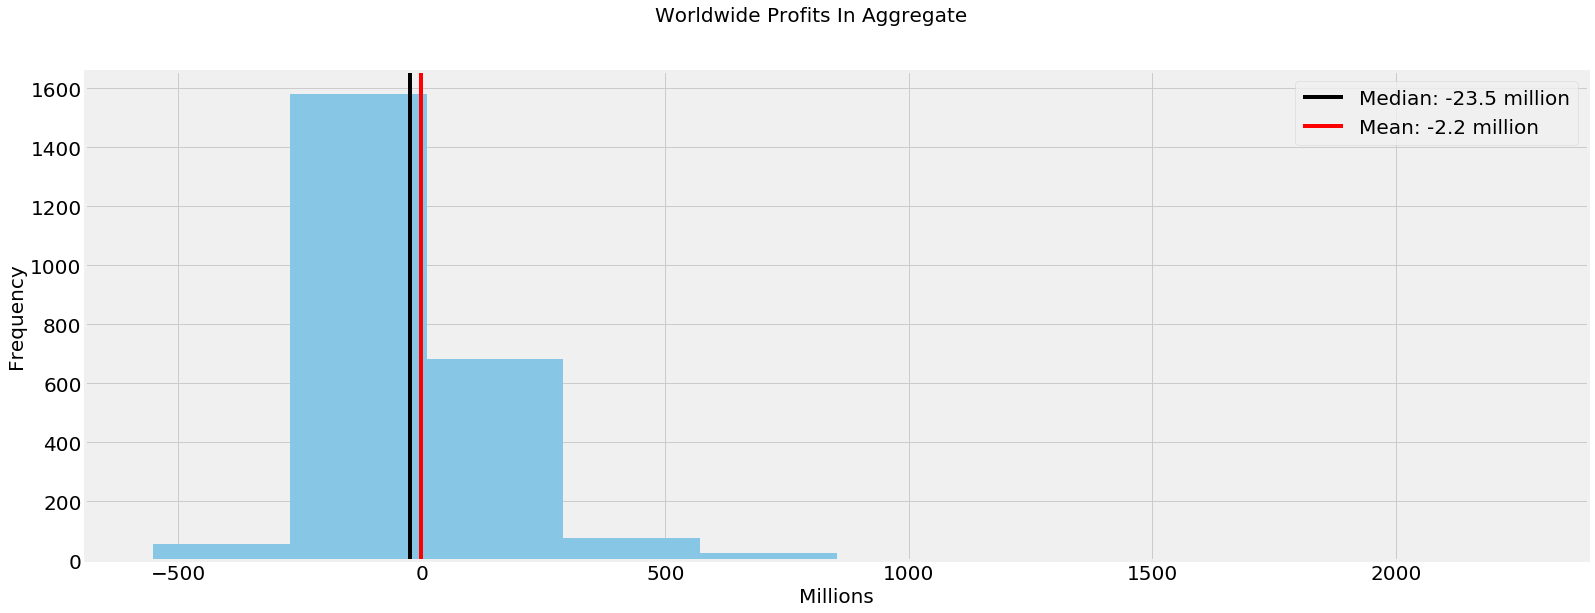

In [151]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24,9))
figure.suptitle('Worldwide Profits In Aggregate', fontsize=20)

(data['profit'] / 1000000).plot.hist(ax=axis, fontsize=20, color=genres_dict['action']['color2']);
axis.set_xlabel('Millions', fontsize=20)
axis.set_ylabel('Frequency', fontsize=20)
axis.axvline(data['profit'].median() / 1000000, color='k')
axis.axvline(data['profit'].mean() / 1000000, color='r')
axis.legend(['Median: {:.1f} million'.format(data['profit'].median() / 1000000), 'Mean: {:.1f} million'.format(data['profit'].mean() / 1000000)], fontsize=20);

## Quick Takeaways

**Number of movies**
  - `Comedy` and `Drama` are historically the most produced genres by big movie studios by a healthy margin

**Skewed grosses**
  - Worldwide gross is heavily right-skewed. 
  - It has a much higher median than mean (almost double!)
  - This fits with our understanding of the movie business -- there are a few megahits that earn outsized returns while the majority of movies earn a little or even lose money
  
**Skewed budgets**
  - Budgets are also heavily right-skewed, but with a much shorter right-tail than worldwide gross
  - This also fits our understanding of the movie business -- most movies are made for relatively small budgets, and there are only a few blockbusters made that have very large budgets
  
**Skewed profits**
  - Profits are also skewed to the right.
  - It's interesting that both mean and median profits are negative. Movies are indeed not a slam-dunk investment.
  
**Use median**
  - We will err on the side of using the median for our summary statistic. Our bosses are looking for insight into what they can expect as an average return from a movie they produce. We'd all like to have the mega blockbusters, but to keep their expectations in check, we will report a more fair assessment of our prospects.

# Genres Overview

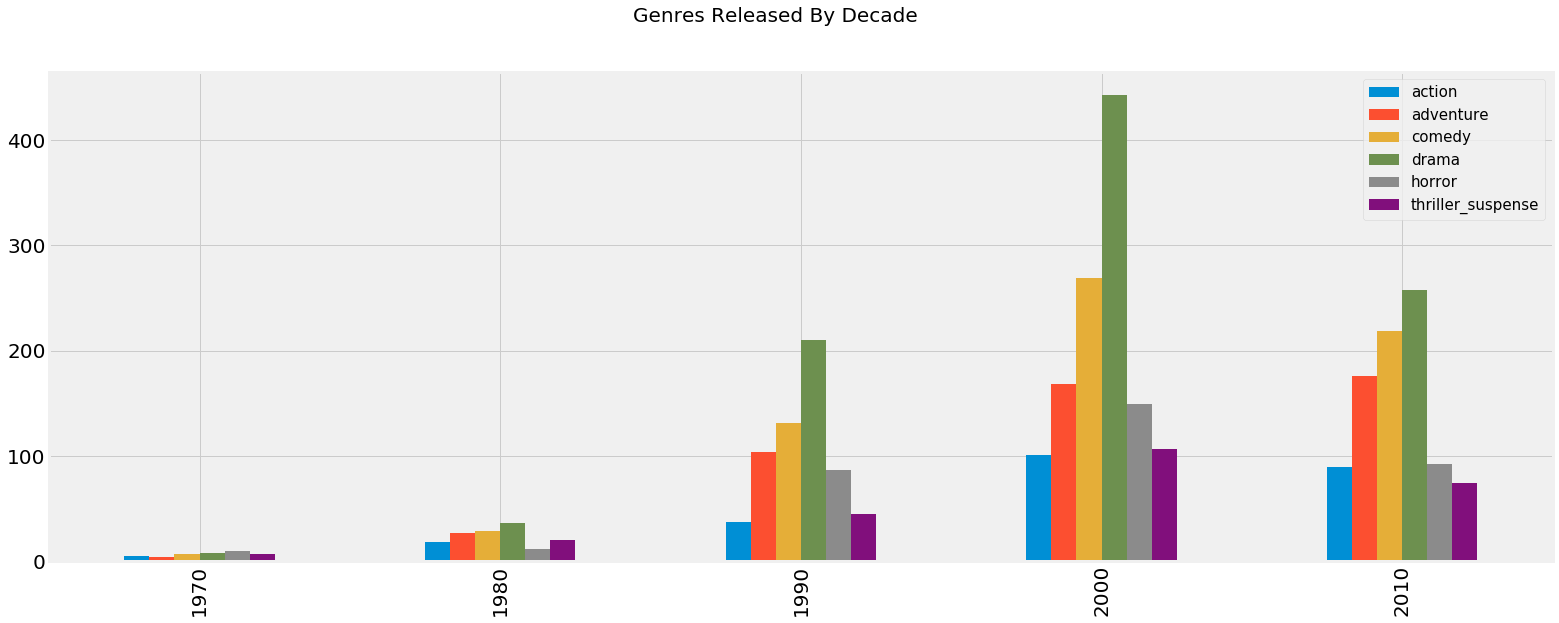

In [22]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24,9))
figure.suptitle('Genres Released By Decade', fontsize=20)

# Since we are dealing with boolean columns, we must use 'sum' to get the total counts
data.groupby('release_decade').sum().plot.bar(y=['adventure', 'action', 'drama', 'comedy', 'thriller_suspense', 'horror'], ax=axis)
axis.legend(genres, fontsize=15)
axis.set_xlabel('')
axis.tick_params(labelsize=20);

## Aggregate Gross

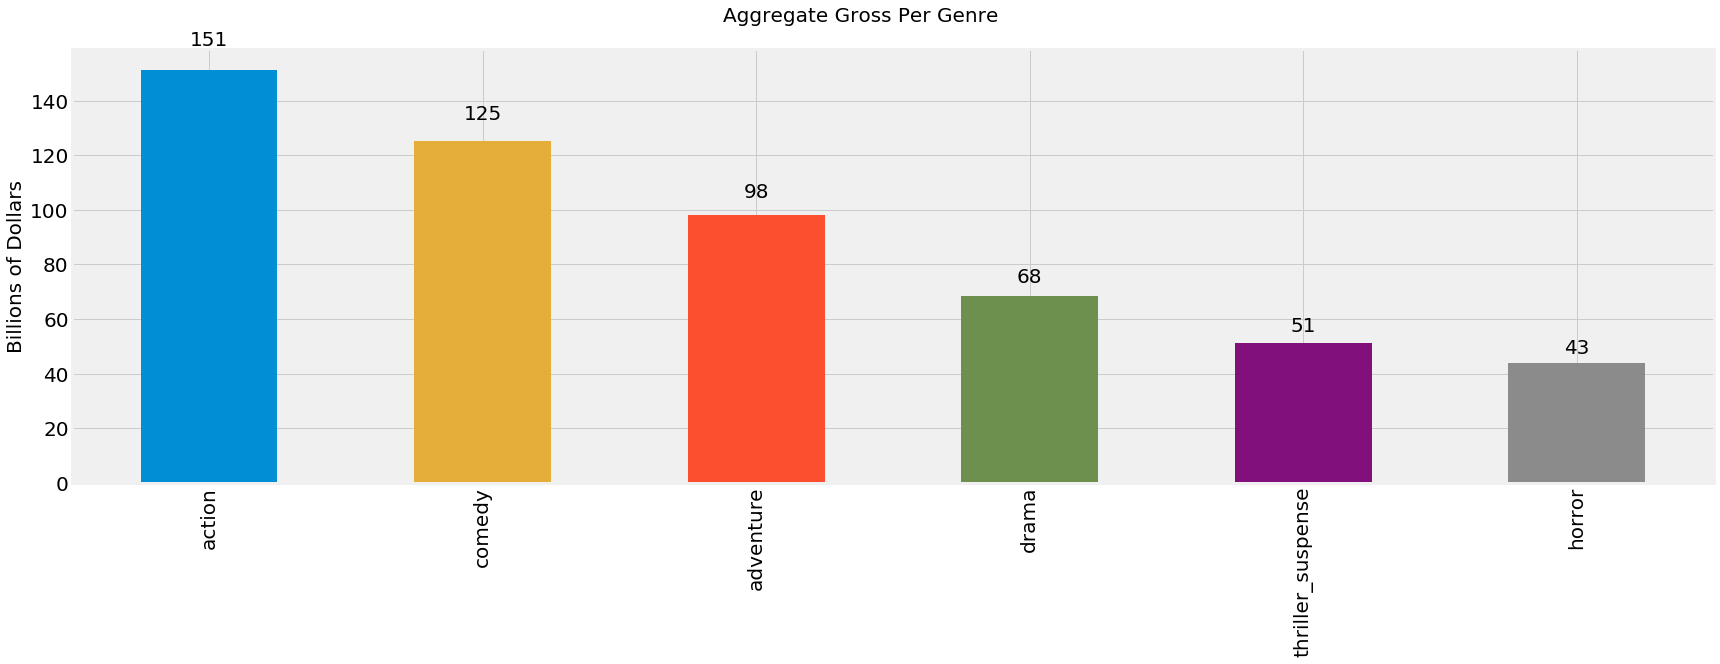

In [152]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Aggregate Gross Per Genre', fontsize=20, y=1.02)

summary.sort_values('all_time_gross', ascending=False, inplace=True)

color_list = generate_color_list(colors_needed=1, order_list=summary.index)

summary.plot(y='all_time_gross', kind='bar', ax=axis, color=color_list, legend=False)
axis.set_ylabel('Billions of Dollars', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
autolabel(axis)

plt.tight_layout()

## Aggregate Budget

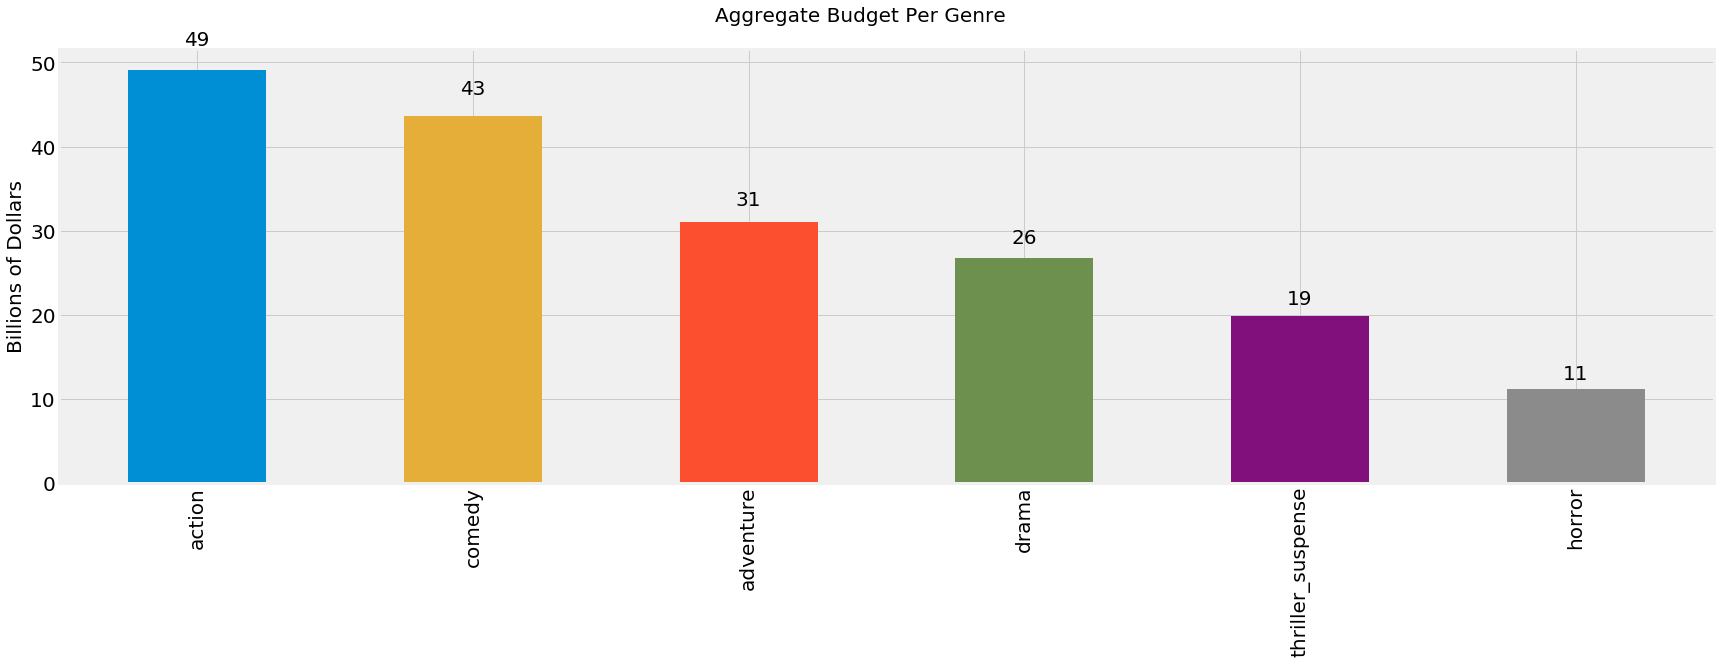

In [153]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Aggregate Budget Per Genre', fontsize=20, y=1.02)

summary.sort_values('all_time_budget', ascending=False, inplace=True)

color_list = generate_color_list(colors_needed=1, order_list=summary.index)

summary.plot(y='all_time_budget', kind='bar', ax=axis, color=color_list, legend=False)
axis.set_ylabel('Billions of Dollars', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
autolabel(axis)

plt.tight_layout()

## Aggregate Profit

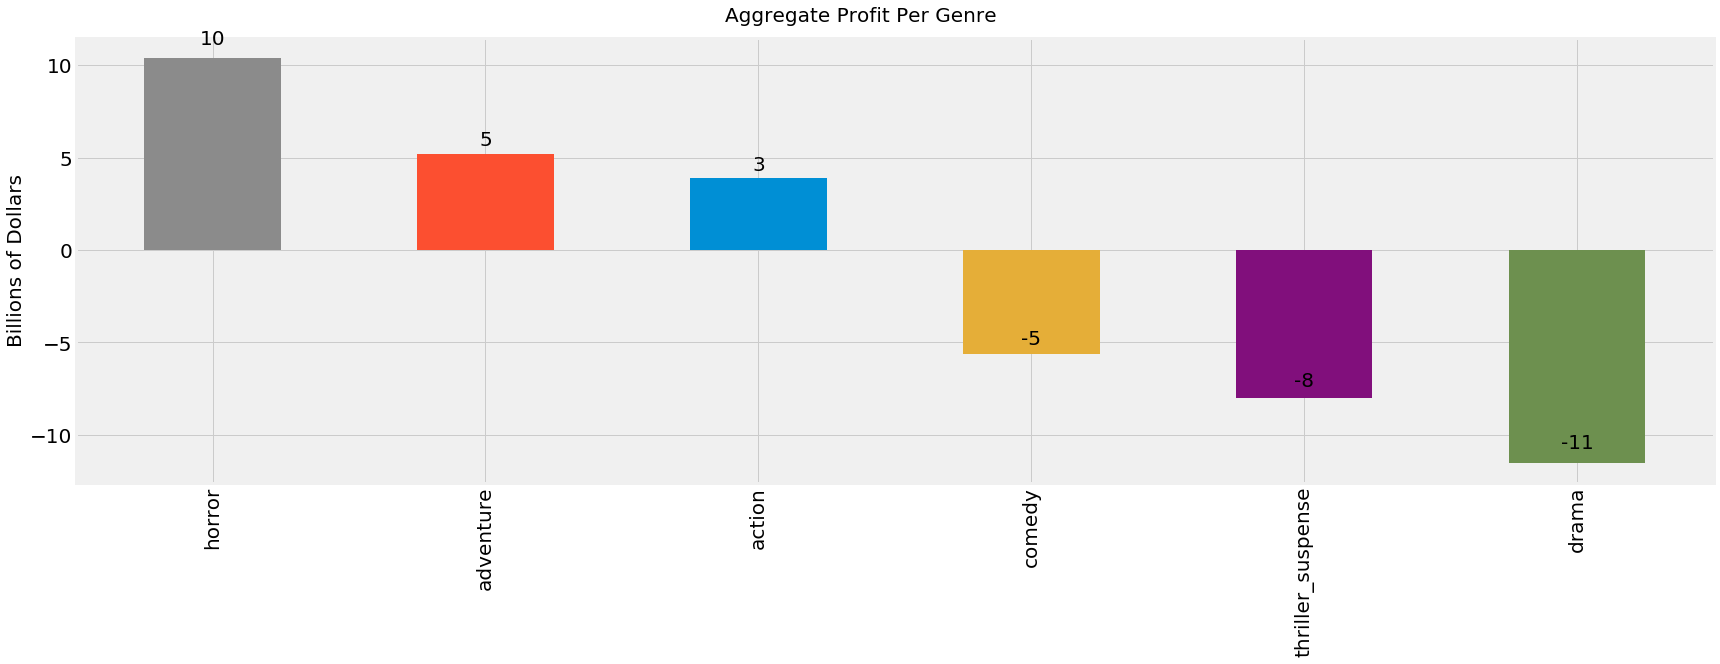

In [154]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Aggregate Profit Per Genre', fontsize=20, y=1.02)

summary.sort_values('all_time_profit', ascending=False, inplace=True)

color_list = generate_color_list(colors_needed=1, order_list=summary.index)

summary.plot(y='all_time_profit', kind='bar', ax=axis, color=color_list, legend=False)
axis.set_ylabel('Billions of Dollars', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
autolabel(axis)

plt.tight_layout()

## Median Profit

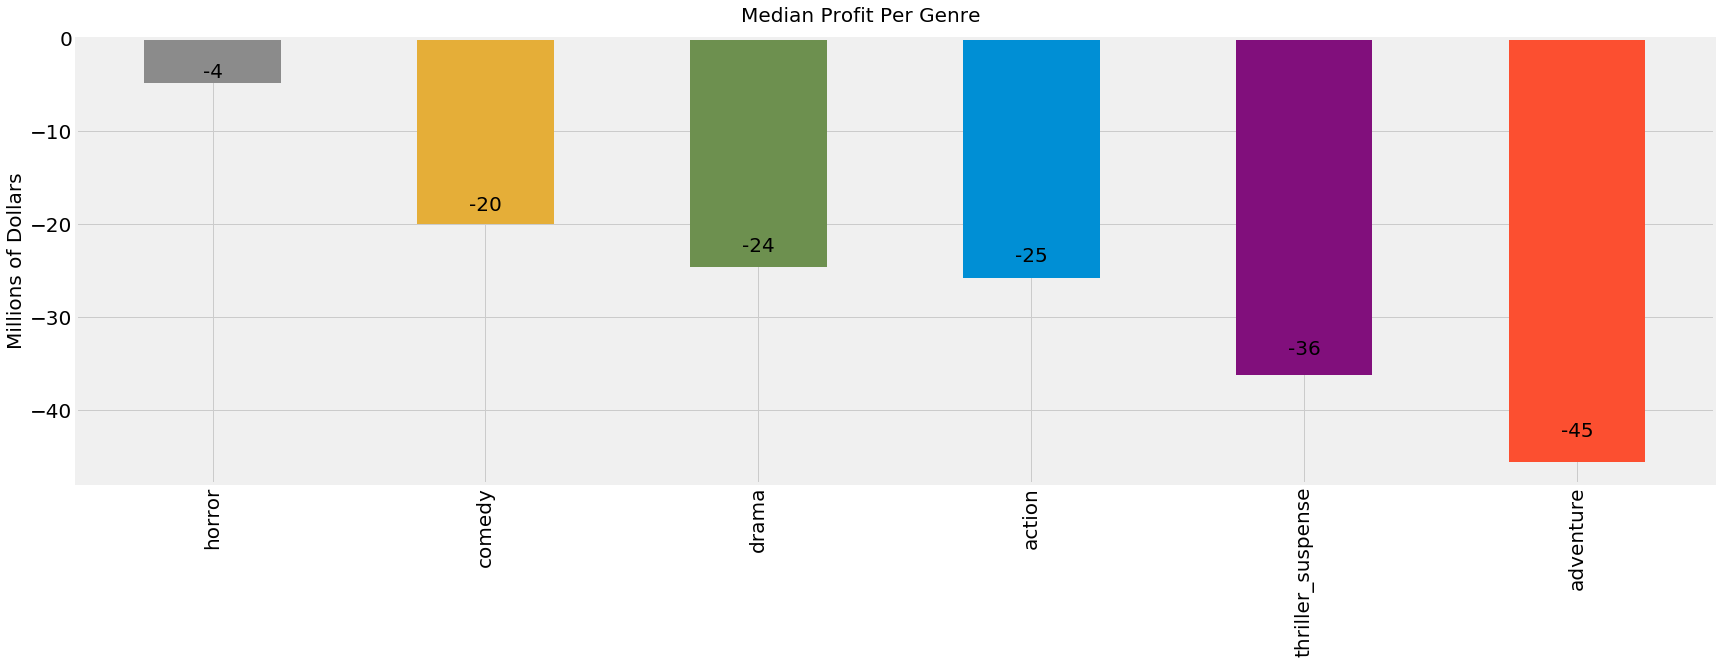

In [155]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Median Profit Per Genre', fontsize=20, y=1.02)

summary.sort_values('median_profit', ascending=False, inplace=True)

color_list = generate_color_list(colors_needed=1, order_list=summary.index)

summary.plot(y='median_profit', kind='bar', ax=axis, color=color_list, legend=False)
axis.set_ylabel('Millions of Dollars', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
autolabel(axis)

plt.tight_layout()

## Mean Profit

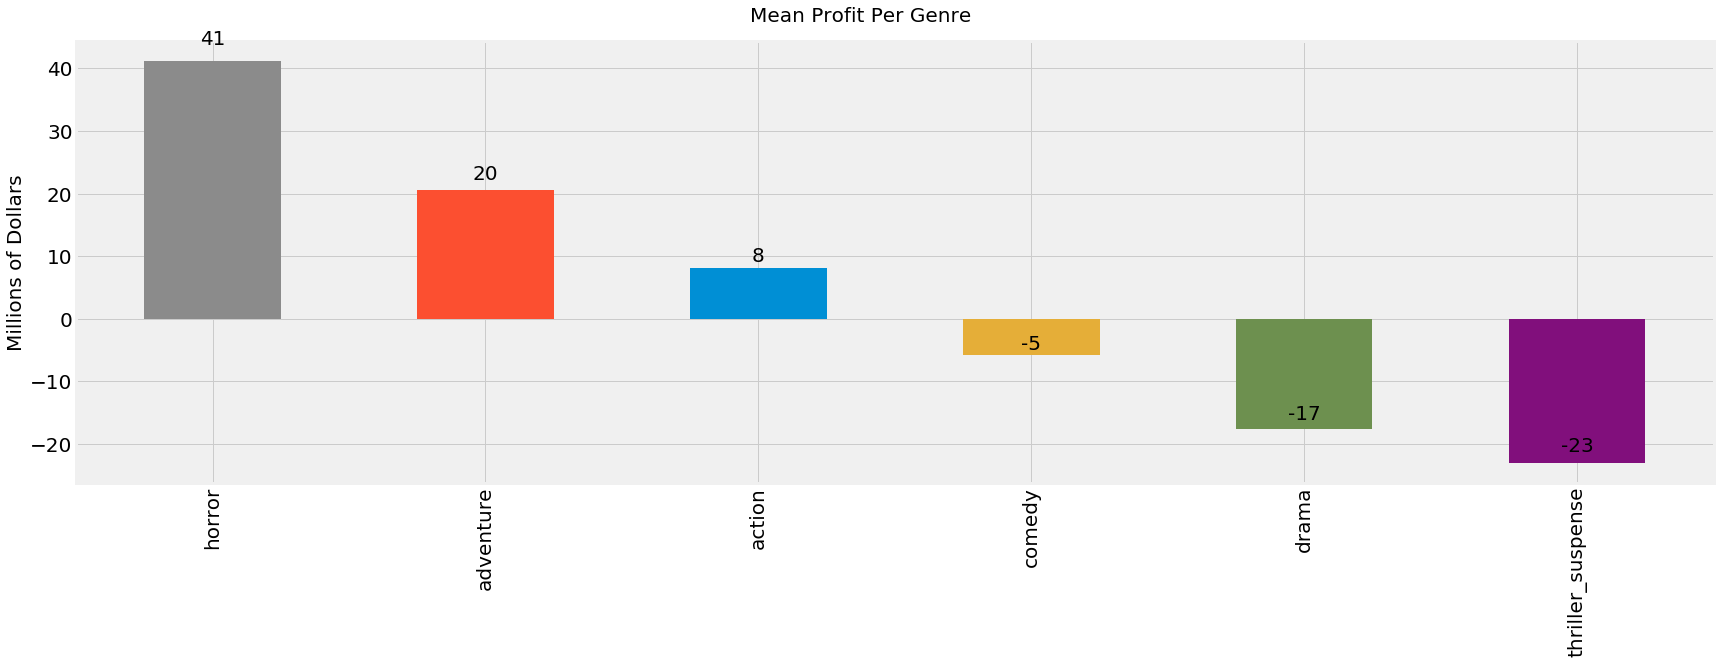

In [156]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Mean Profit Per Genre', fontsize=20, y=1.02)

summary.sort_values('mean_profit', ascending=False, inplace=True)

color_list = generate_color_list(colors_needed=1, order_list=summary.index)

summary.plot(y='mean_profit', kind='bar', ax=axis, color=color_list, legend=False)
axis.set_ylabel('Millions of Dollars', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
autolabel(axis)

plt.tight_layout()

## Summary

**Highest gross**
  - Action, Comedy, and Adventure have grossed the most money. 
  
**Profitability**
  - Horror, Adventure, and Action are the only genres that are net winners.
  
**Median profit**
  - No genre is a net winner in terms of median profit
  
**Mean profit**
  - Horror has the biggest boost from the right skew in terms of mean profitability.
  - Adventure and Action also go from net losers to net winners when looking at mean profits.
  
**Thoughts**
  - We are going to dig way deeper, but it's nice to get a sense of the overall big picture by genre.

# Deeper Dive On Worldwide Grosses

## Create custom function to help graphing by genre

In [28]:
# We want individual columns that hold the worldwide gross for each genre
# Since a movie can have multiple genres, right now we must handle this by a groupby while looping over each genre
# If we create individual columns that contain information about a genre and its worldwide box office, it's easier to graph
def worldwide_stat_by_genre(row, genre, stat):
    # Returns either 0 or the stat value due to boolean multiplication
    test = row[genre] * row[stat]
        
    # If the row is not in the genre (i.e. False * $100 = 0)
    if test == 0:
        return np.nan
    else:
        return test
    
def test_for_breakeven_by_genre(row, genre, breakeven_column):
    if row[genre]:
        if row[breakeven_column]:
            return 1
        else:
            return 0
    else:
        return np.nan
    
# List of new columns to hold worldwide grosses by genre
budget_columns = ['worldwide_budget_{}'.format(genre) for genre in genres]
gross_columns = ['worldwide_gross_{}'.format(genre) for genre in genres]
profit_columns = ['worldwide_profit_{}'.format(genre) for genre in genres]
breakeven_columns = ['worldwide_breakeven_{}'.format(genre) for genre in genres]

for genre, col in zip(genres, budget_columns):
    data[col] = data.apply(lambda x: worldwide_stat_by_genre(x, genre, 'budget_adj'), axis=1)
    
for genre, col in zip(genres, gross_columns):
    data[col] = data.apply(lambda x: worldwide_stat_by_genre(x, genre, 'worldwide_adj'), axis=1)
    
for genre, col in zip(genres, profit_columns):
    data[col] = data.apply(lambda x: worldwide_stat_by_genre(x, genre, 'profit'), axis=1)
    
for genre, col in zip(genres, breakeven_columns):
    data[col] = data.apply(lambda x: test_for_breakeven_by_genre(x, genre, 'worldwide_breakeven'), axis=1)

## Mean and Median Gross

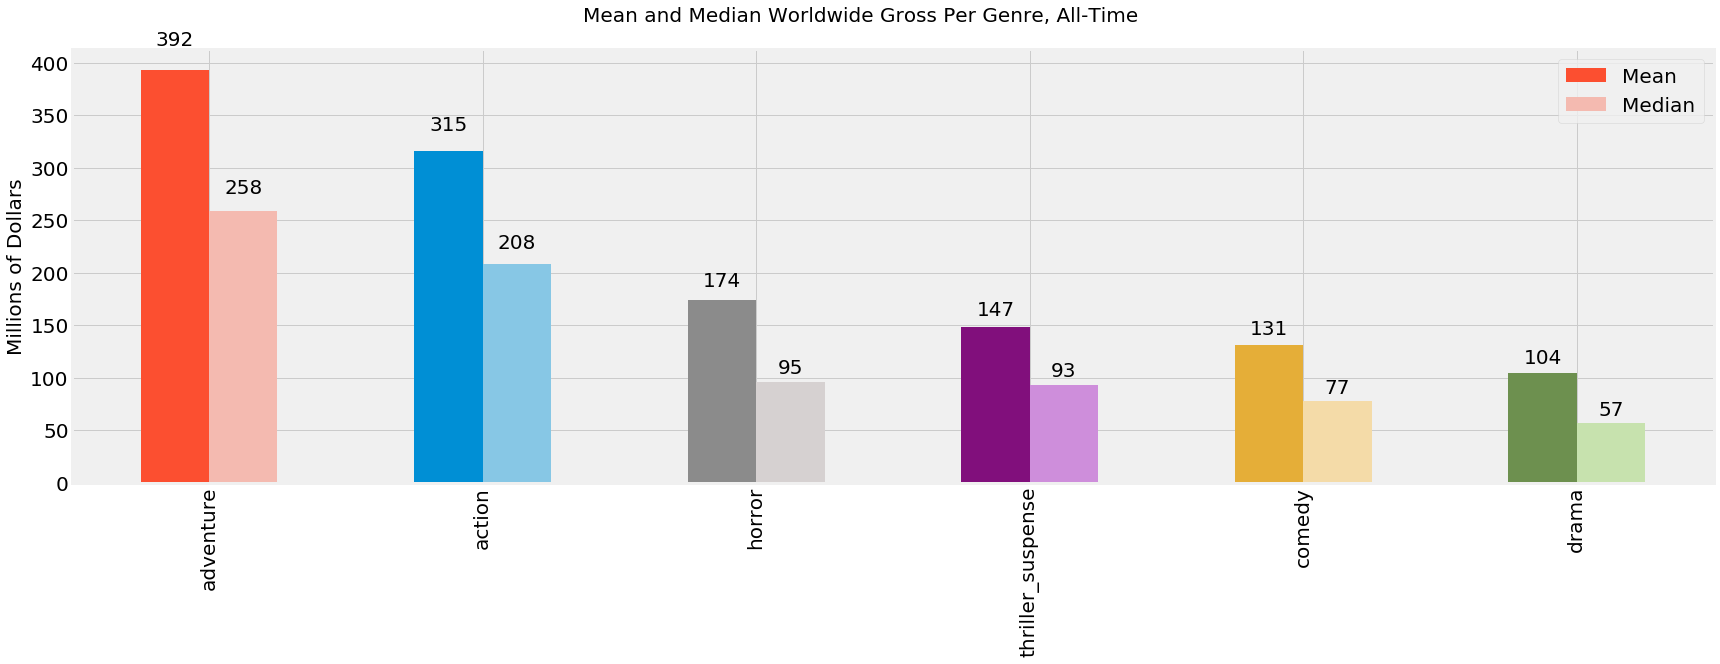

In [157]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Mean and Median Worldwide Gross Per Genre, All-Time', fontsize=20, y=1.02)

summary.sort_values('avg_gross', ascending=False, inplace=True)

color_list = generate_color_list(colors_needed=2, order_list=summary.index)

summary.plot(y=['avg_gross', 'median_gross'], kind='bar', ax=axis, color=color_list, legend=True)
axis.set_ylabel('Millions of Dollars', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
axis.legend(['Mean', 'Median'], fontsize=20)
autolabel(axis)

plt.tight_layout()

## Gross Distributions

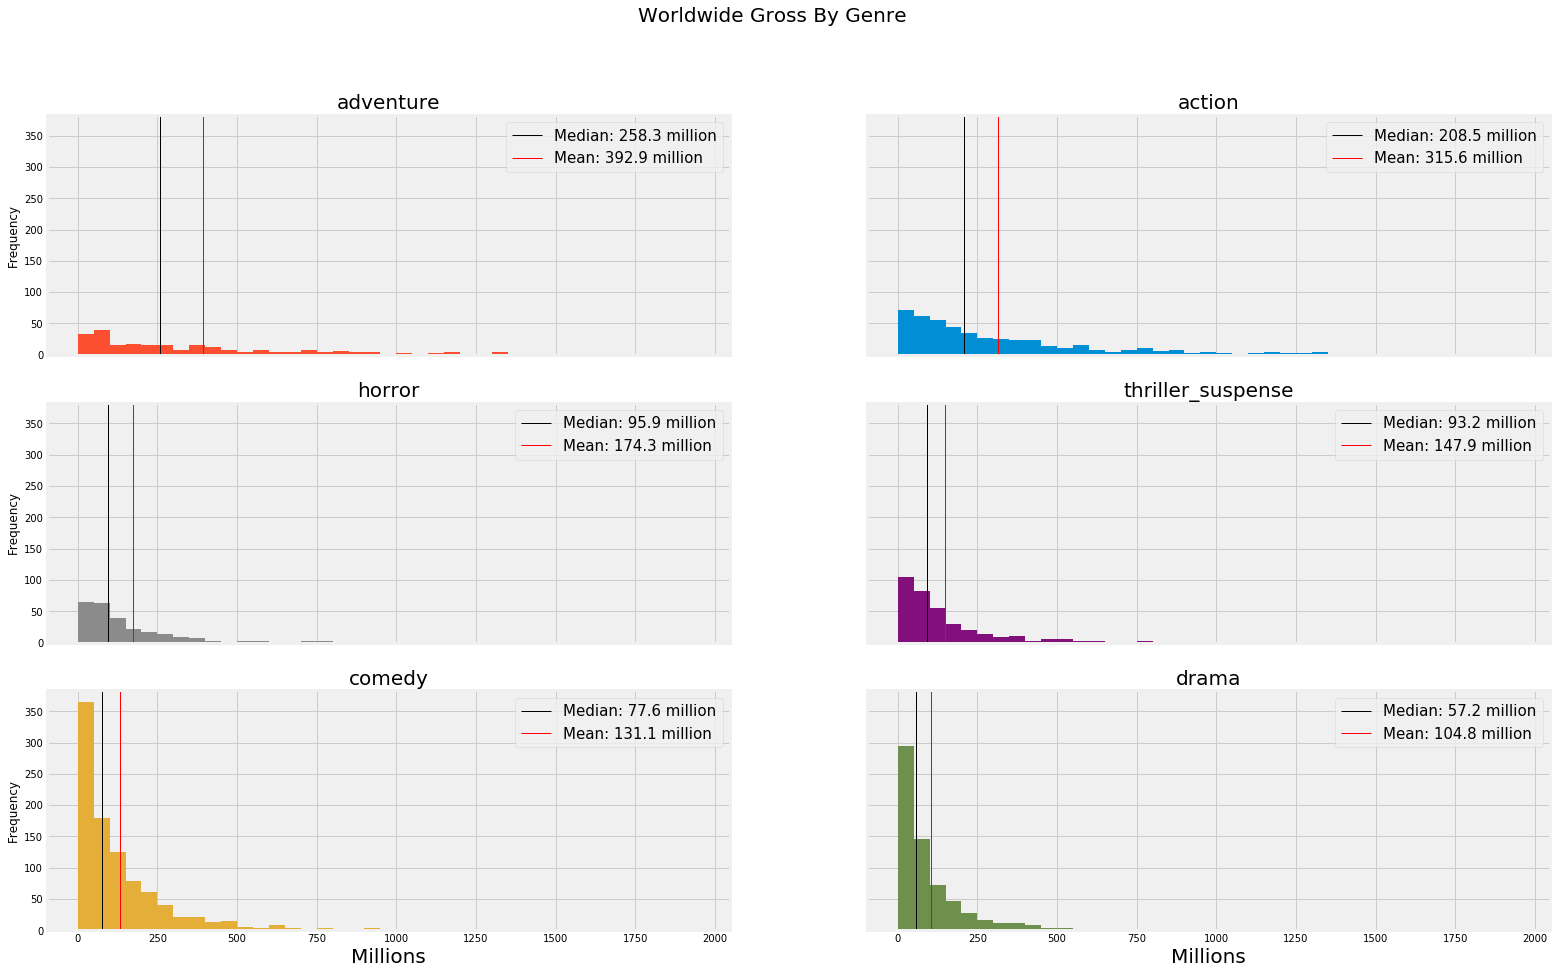

In [161]:
figure, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(24,15))
figure.suptitle('Worldwide Gross By Genre', fontsize=20)

# Get genres sorted in descending order of gross
sorted_genres = sorted([{'genre': genre, 'amount': (data[data[genre]]['worldwide_adj'].median() / 1000000)} for genre in genres], key=lambda k: k['amount'], reverse=True)
genres_list = [item['genre'] for item in sorted_genres]
color_list = generate_color_list(colors_needed=1, order_list=genres_list)

for genre, axis, color in zip(genres_list, axes.flat, color_list):
    (data[data[genre]]['worldwide_adj'] / 1000000).plot.hist(range(0, 2000, 50), ax=axis, color=color)
    axis.set_title(genre, fontsize=20)
    axis.axvline(data[data[genre]]['worldwide_adj'].median() / 1000000, color='k', linewidth=1)
    axis.axvline(data[data[genre]]['worldwide_adj'].mean() / 1000000, color='r', linewidth=1)
    axis.legend(['Median: {:.1f} million'.format(data[data[genre]]['worldwide_adj'].median() / 1000000), 'Mean: {:.1f} million'.format(data[data[genre]]['worldwide_adj'].mean() / 1000000)], fontsize=15)
    axis.set_xlabel('Millions', fontsize=20)

## Quick Takeaways

**Skew**
  - Even subdivided by genre, the gross distributions are all right-skewed.
  
**Mean and median**
  - Mean and median gross for Adventure and Action are far higher than any other genre
  - Adventure's median gross is approximately 2.6 times as large as the third place median gross, Horror.
  - The most common gross amount in every genre except Adventure is $0 - \\$50 milllion
  
**Action/Adventure**
  - These two genres have the biggest spread between mean and median gross
  - Something to keep in mind is the frequency of movies labeled as Action/Adventure. In our analysis, such movies would count towards both Action and Adventure movies. (We are assigning movies to every genre they have.) 
  - Since both of these genres are big on spectacle, they tend to be more likely to be blockbuster material 
  - We might have a situation where duplicate entries in both columns are artificially boosting their totals
  - Let's investigate this a little further  

## Action/Adventure

In [31]:
print('Median gross of Action/Adventure movies: {:.1f} million'.format(data[data['genres_mojo'] == 'Action / Adventure']['worldwide_adj'].median() / 1000000))
print('Median gross of Action (without Adventure component) movies: {:.1f} million'.format(data[(data['genres_mojo'].str.contains('Action', na=False)) & (~data['genres_mojo'].isin(['Action / Adventure']))]['worldwide_adj'].median() / 1000000))
print('Median gross of Adventure (without Action component) movies: {:.1f} million'.format(data[(data['genres_mojo'].str.contains('Adventure', na=False)) & (~data['genres_mojo'].isin(['Action / Adventure']))]['worldwide_adj'].median() / 1000000))

Median gross of Action/Adventure movies: 437.8 million
Median gross of Action (without Adventure component) movies: 173.2 million
Median gross of Adventure (without Action component) movies: 156.8 million


### Action

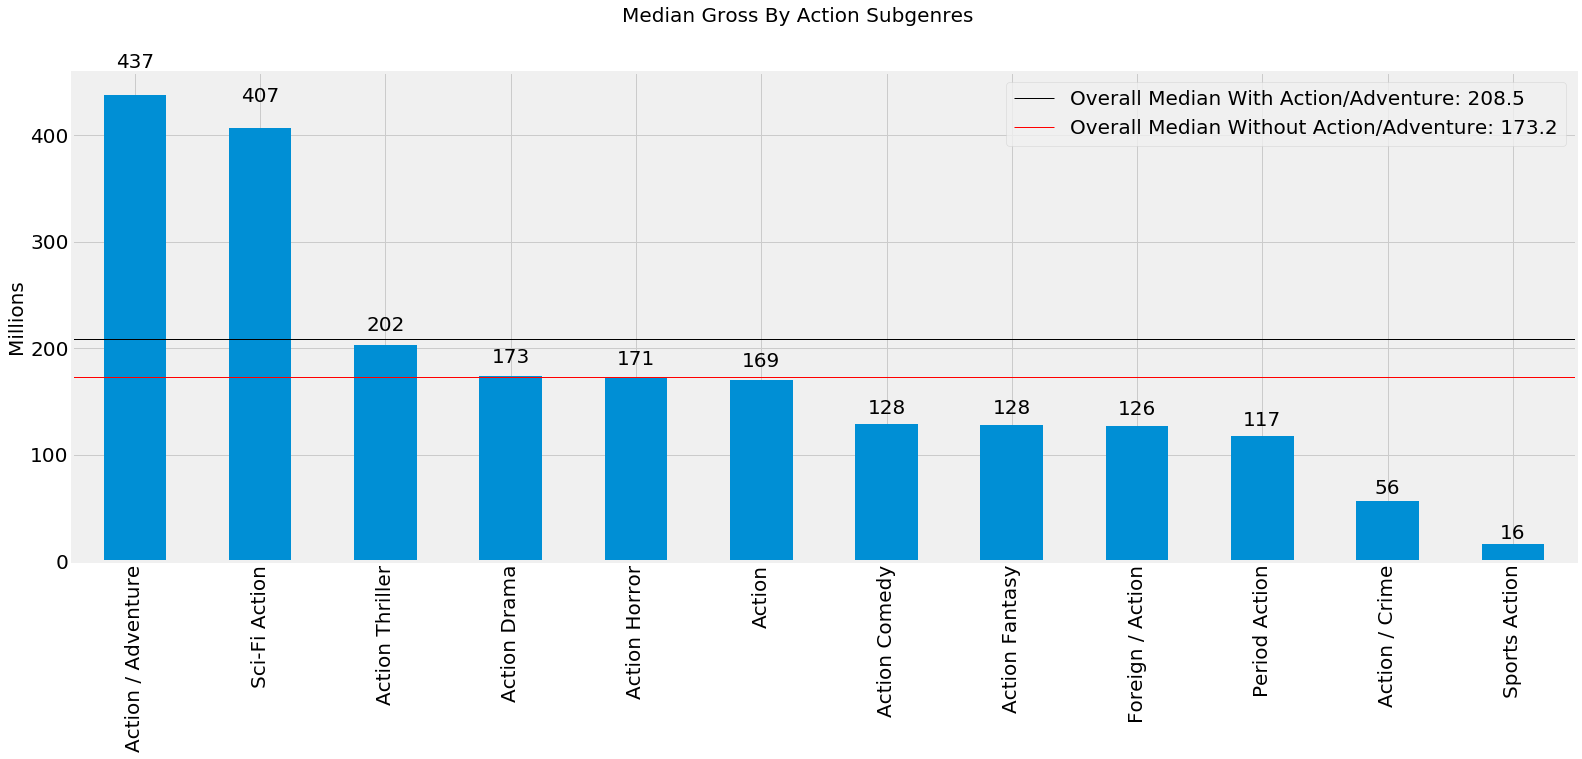

In [32]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Median Gross By Action Subgenres', fontsize=20)

action_movies = data[data['genres_mojo'].str.contains('Action')]
median_with_adventure = data[(data['genres_mojo'].str.contains('Action', na=False))]['worldwide_adj'].median() / 1000000
median_without_adventure = data[(data['genres_mojo'].str.contains('Action', na=False)) & (~data['genres_mojo'].isin(['Action / Adventure']))]['worldwide_adj'].median() / 1000000

grp = action_movies.groupby('genres_mojo')['worldwide_adj'].median().sort_values(ascending=False) / 1000000

grp.plot(kind='bar', ax=axis, color=genres_dict['action']['color1'])
axis.axhline(median_with_adventure, color='k', linewidth=1)
axis.axhline(median_without_adventure, color='r', linewidth=1)
axis.tick_params(labelsize=20)
axis.set_xlabel('')
axis.set_ylabel('Millions', fontsize=20);
axis.legend(['Overall Median With Action/Adventure: {:.1f}'.format(median_with_adventure),
             'Overall Median Without Action/Adventure: {:.1f}'.format(median_without_adventure)], loc=1, fontsize=20)
autolabel(axis);

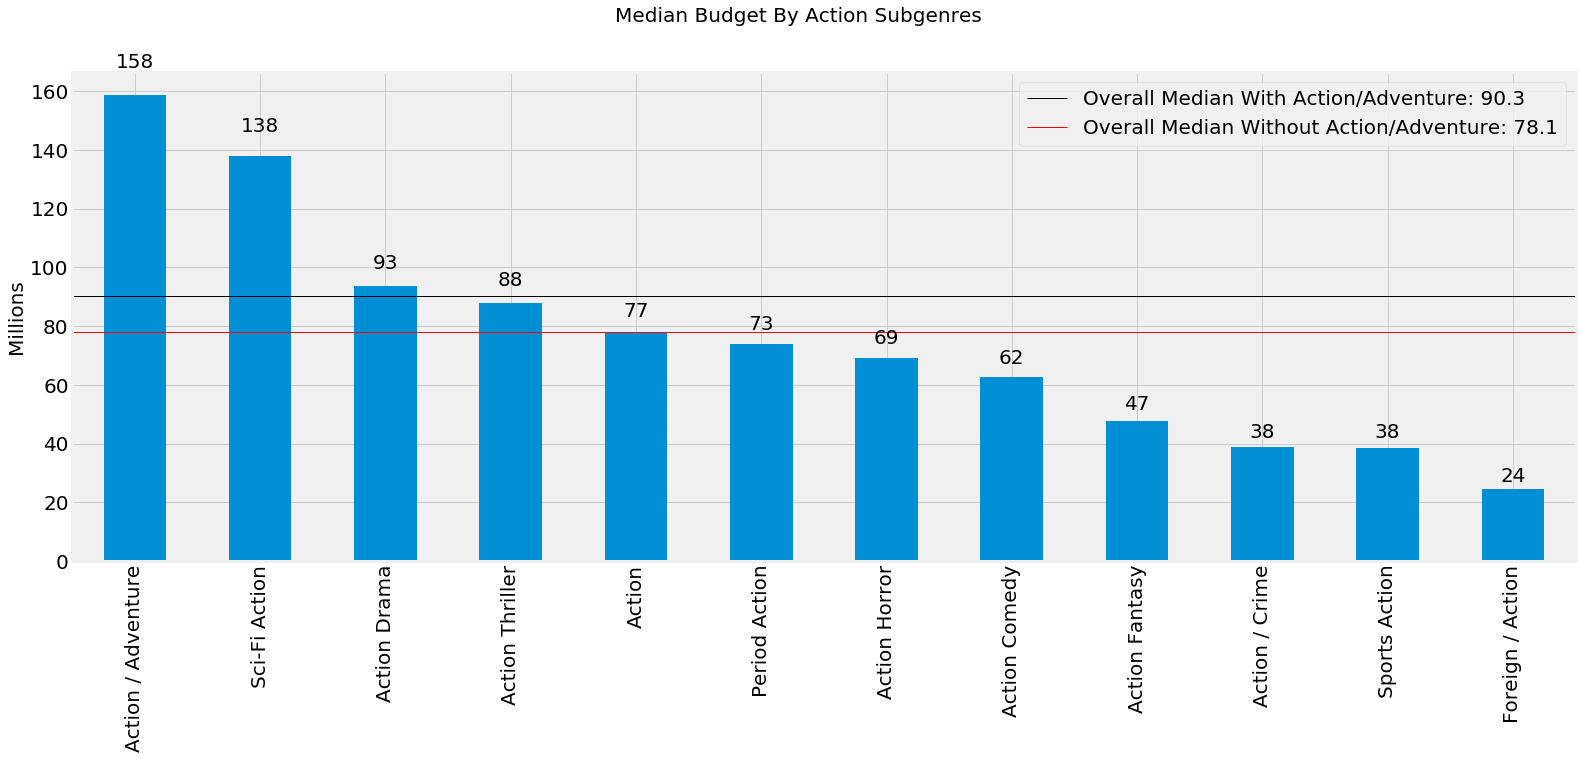

In [33]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Median Budget By Action Subgenres', fontsize=20)

action_movies = data[data['genres_mojo'].str.contains('Action')]
median_with_adventure = data[(data['genres_mojo'].str.contains('Action', na=False))]['budget_adj'].median() / 1000000
median_without_adventure = data[(data['genres_mojo'].str.contains('Action', na=False)) & (~data['genres_mojo'].isin(['Action / Adventure']))]['budget_adj'].median() / 1000000

grp = action_movies.groupby('genres_mojo')['budget_adj'].median().sort_values(ascending=False) / 1000000

grp.plot(kind='bar', ax=axis, color=genres_dict['action']['color1'])
axis.axhline(median_with_adventure, color='k', linewidth=1)
axis.axhline(median_without_adventure, color='r', linewidth=1)
axis.tick_params(labelsize=20)
axis.set_xlabel('')
axis.set_ylabel('Millions', fontsize=20);
axis.legend(['Overall Median With Action/Adventure: {:.1f}'.format(median_with_adventure),
            'Overall Median Without Action/Adventure: {:.1f}'.format(median_without_adventure)], loc=1, fontsize=20)
autolabel(axis);

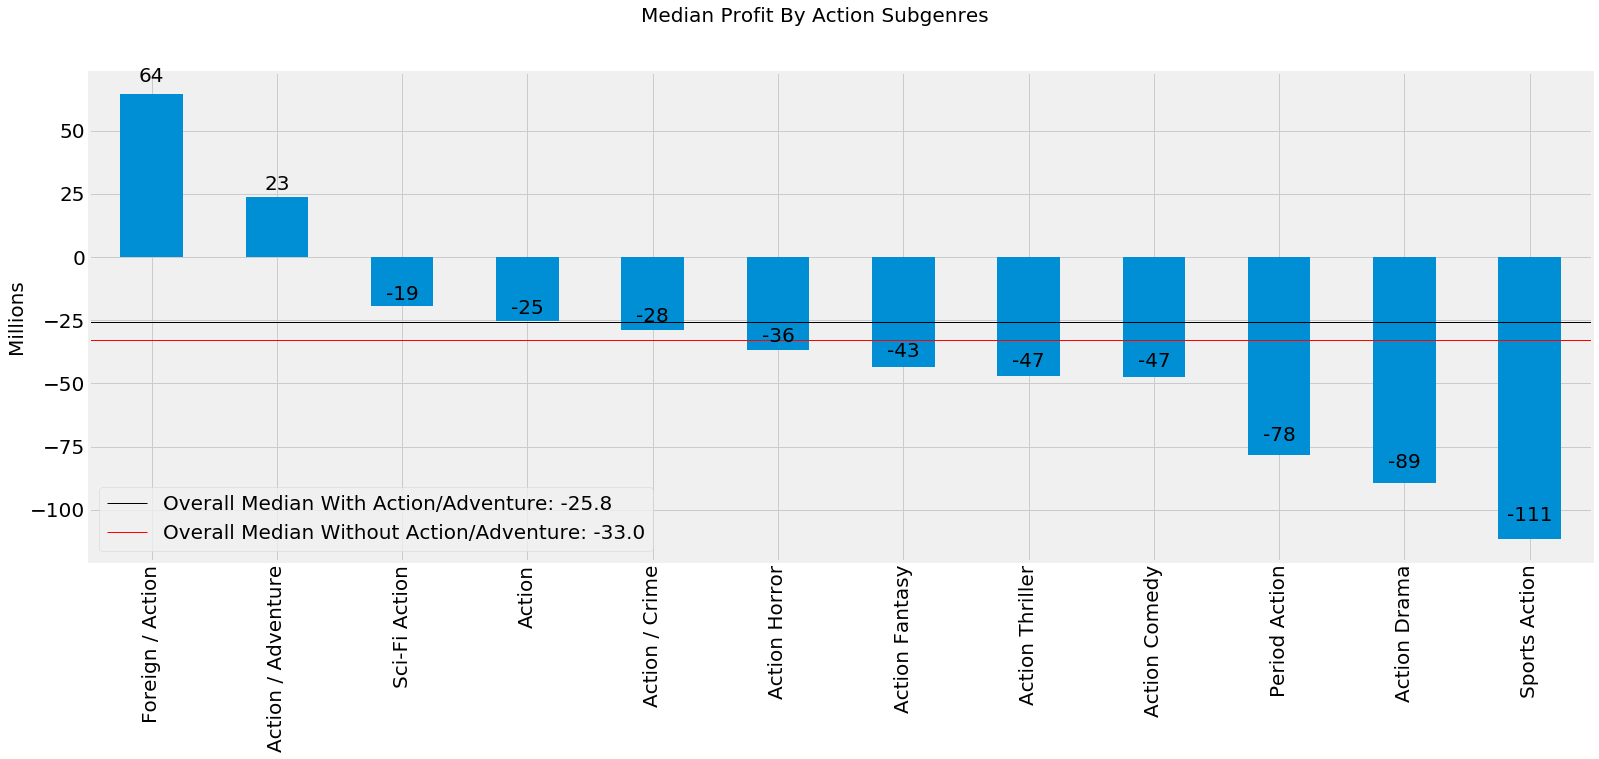

In [34]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Median Profit By Action Subgenres', fontsize=20)

action_movies = data[data['genres_mojo'].str.contains('Action')]
median_with_adventure = data[(data['genres_mojo'].str.contains('Action', na=False))]['profit'].median() / 1000000
median_without_adventure = data[(data['genres_mojo'].str.contains('Action', na=False)) & (~data['genres_mojo'].isin(['Action / Adventure']))]['profit'].median() / 1000000

grp = action_movies.groupby('genres_mojo')['profit'].median().sort_values(ascending=False) / 1000000

grp.plot(kind='bar', ax=axis, color=genres_dict['action']['color1'])
axis.axhline(median_with_adventure, color='k', linewidth=1)
axis.axhline(median_without_adventure, color='r', linewidth=1)
axis.tick_params(labelsize=20)
axis.set_xlabel('')
axis.set_ylabel('Millions', fontsize=20);
axis.legend(['Overall Median With Action/Adventure: {:.1f}'.format(median_with_adventure),
             'Overall Median Without Action/Adventure: {:.1f}'.format(median_without_adventure)], loc=3, fontsize=20)
autolabel(axis);

### Quick Takeaways

  - Action/Adventure and Sci-Fi Action are the highest grossing subgenres. They also carry the highest production budgets.
  - Only Foreign/Action and Action/Adventure have a median profit that his positive
  - Since Action/Adventure is such a huge grossing subgenre, it boosts the median gross for the entire genre by about \\$34 million.

### Adventure

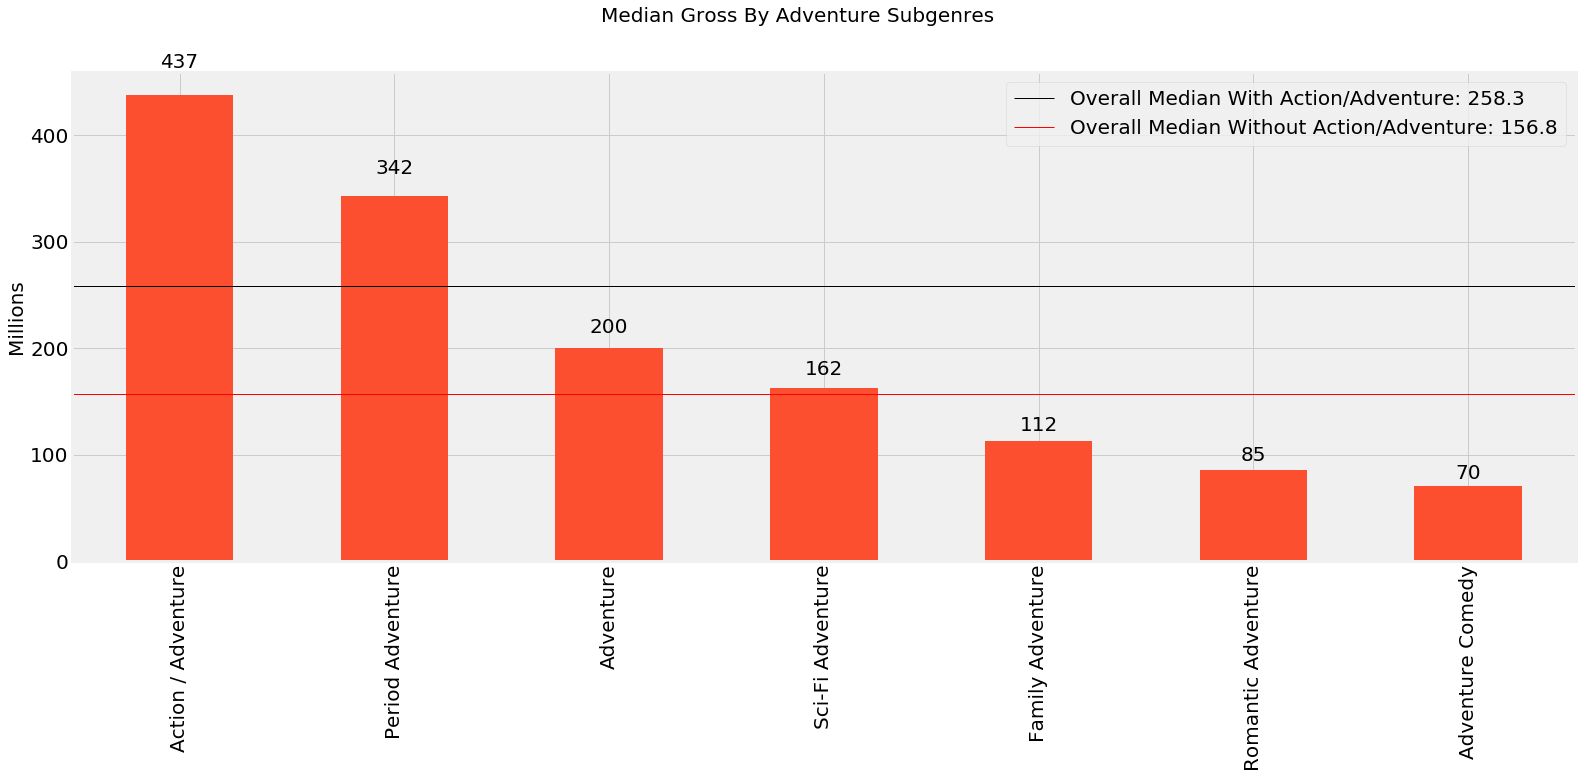

In [166]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Median Gross By Adventure Subgenres', fontsize=20)

adventure_movies = data[data['genres_mojo'].str.contains('Adventure')]
median_with_action = data[(data['genres_mojo'].str.contains('Adventure', na=False))]['worldwide_adj'].median() / 1000000
median_without_action = data[(data['genres_mojo'].str.contains('Adventure', na=False)) & (~data['genres_mojo'].isin(['Action / Adventure']))]['worldwide_adj'].median() / 1000000

grp = adventure_movies.groupby('genres_mojo')['worldwide_adj'].median().sort_values(ascending=False) / 1000000

grp.plot(kind='bar', ax=axis, color=genres_dict['adventure']['color1'])
axis.axhline(median_with_action, color='k', linewidth=1)
axis.axhline(median_without_action, color='r', linewidth=1)
axis.tick_params(labelsize=20)
axis.set_xlabel('')
axis.set_ylabel('Millions', fontsize=20);
axis.legend(['Overall Median With Action/Adventure: {:.1f}'.format(median_with_action),
             'Overall Median Without Action/Adventure: {:.1f}'.format(median_without_action)], loc=1, fontsize=20)
autolabel(axis);

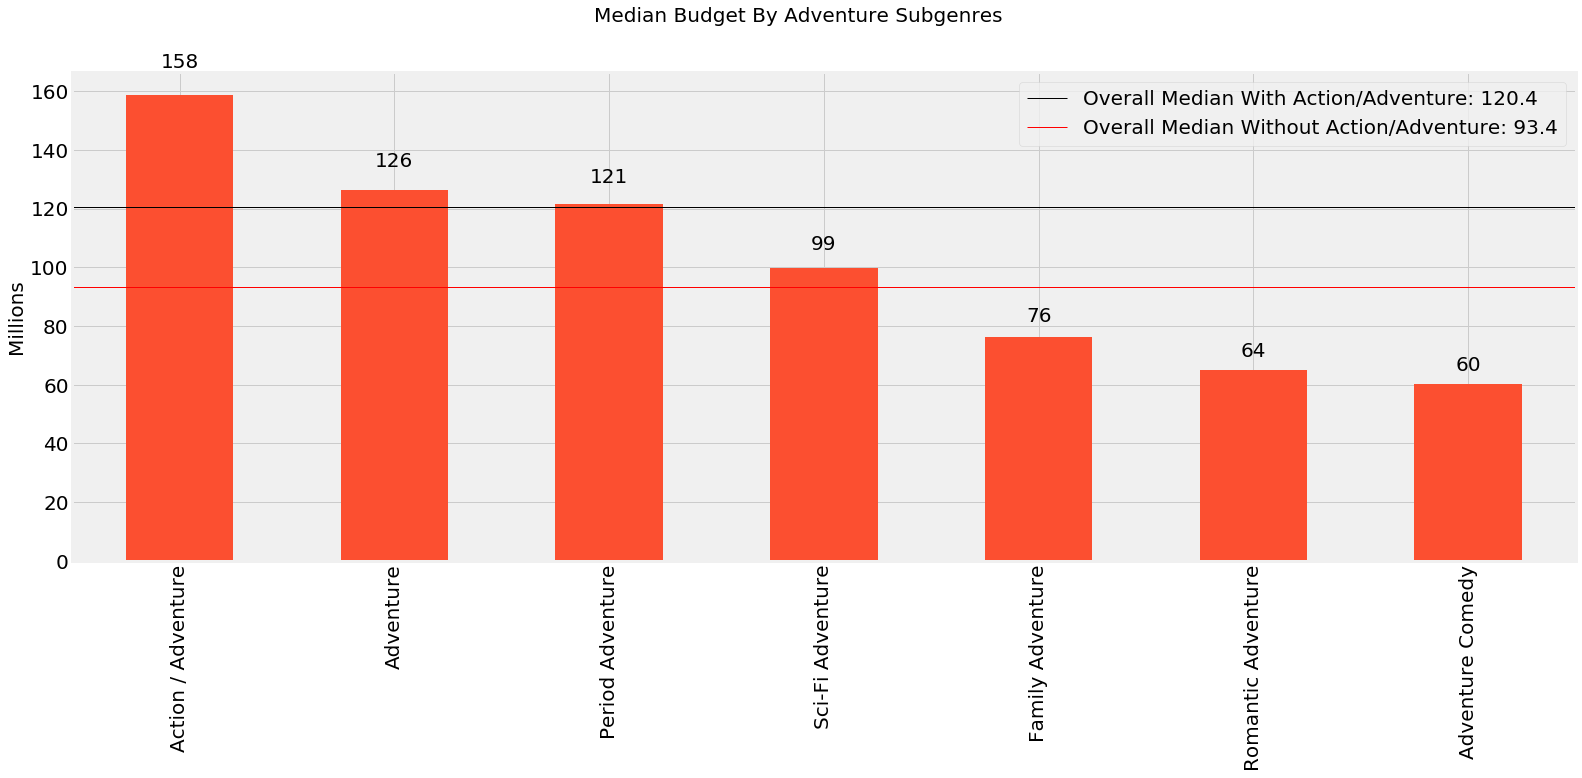

In [36]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Median Budget By Adventure Subgenres', fontsize=20)

adventure_movies = data[data['genres_mojo'].str.contains('Adventure')]
median_with_action = data[(data['genres_mojo'].str.contains('Adventure', na=False))]['budget_adj'].median() / 1000000
median_without_action = data[(data['genres_mojo'].str.contains('Adventure', na=False)) & (~data['genres_mojo'].isin(['Action / Adventure']))]['budget_adj'].median() / 1000000

grp = adventure_movies.groupby('genres_mojo')['budget_adj'].median().sort_values(ascending=False) / 1000000

grp.plot(kind='bar', ax=axis, color=genres_dict['adventure']['color1'])
axis.axhline(median_with_action, color='k', linewidth=1)
axis.axhline(median_without_action, color='r', linewidth=1)
axis.tick_params(labelsize=20)
axis.set_xlabel('')
axis.set_ylabel('Millions', fontsize=20);
axis.legend(['Overall Median With Action/Adventure: {:.1f}'.format(median_with_action),
             'Overall Median Without Action/Adventure: {:.1f}'.format(median_without_action)], loc=1, fontsize=20)
autolabel(axis);

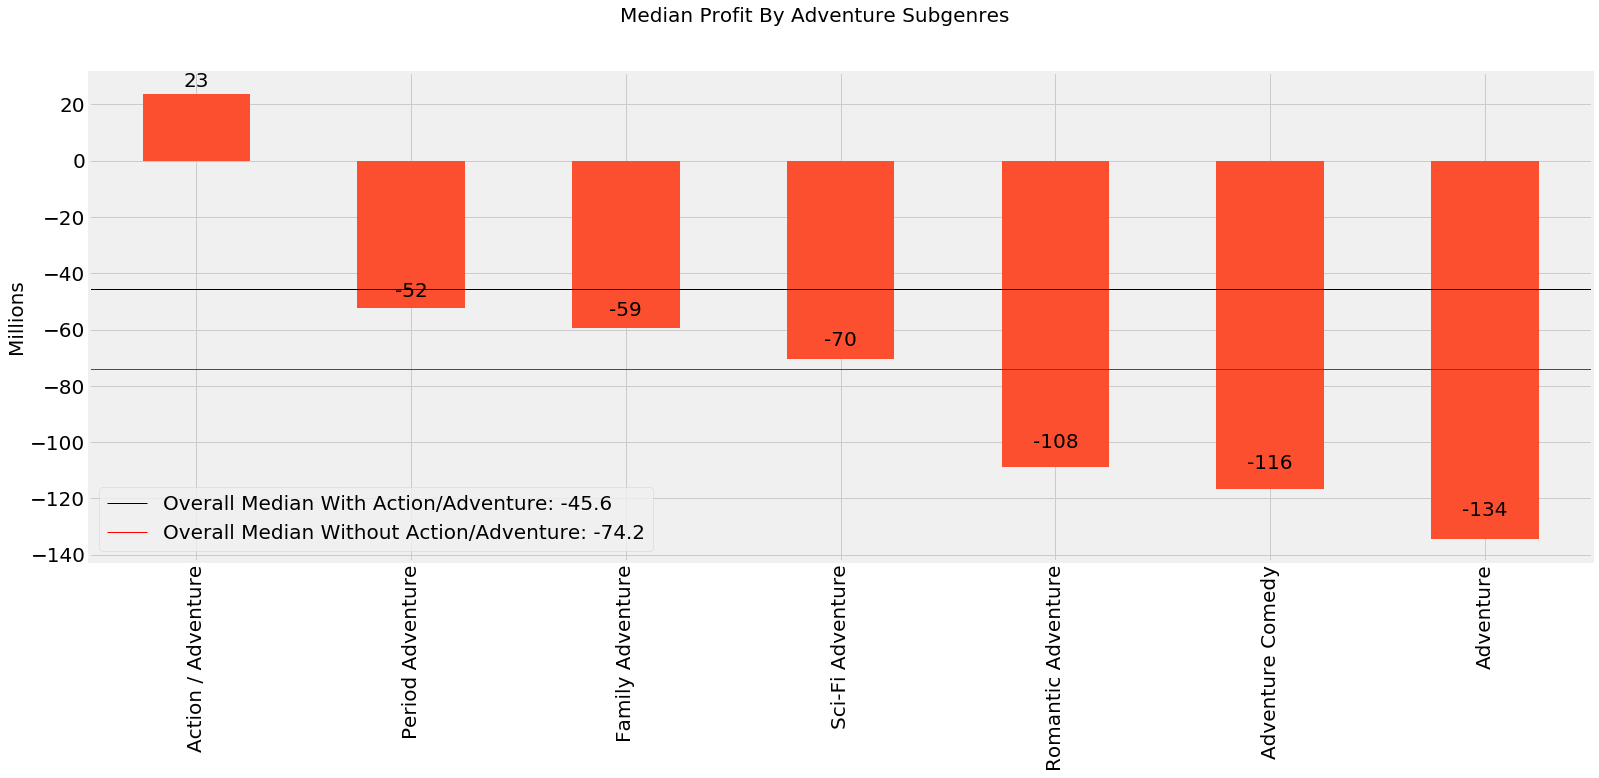

In [165]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Median Profit By Adventure Subgenres', fontsize=20)

adventure_movies = data[data['genres_mojo'].str.contains('Adventure')]
median_with_action = data[(data['genres_mojo'].str.contains('Adventure', na=False))]['profit'].median() / 1000000
median_without_action = data[(data['genres_mojo'].str.contains('Adventure', na=False)) & (~data['genres_mojo'].isin(['Action / Adventure']))]['profit'].median() / 1000000

grp = adventure_movies.groupby('genres_mojo')['profit'].median().sort_values(ascending=False) / 1000000

grp.plot(kind='bar', ax=axis, color=genres_dict['adventure']['color1'])
axis.axhline(median_with_action, color='k', linewidth=1)
axis.axhline(median_without_action, color='r', linewidth=1)
axis.tick_params(labelsize=20)
axis.set_xlabel('')
axis.set_ylabel('Millions', fontsize=20);
axis.legend(['Overall Median With Action/Adventure: {:.1f}'.format(median_with_action),
             'Overall Median Without Action/Adventure: {:.1f}'.format(median_without_action)], loc=3, fontsize=20)
autolabel(axis);

### Quick Takeaways

  - Action/Adventure is the highest grossing and most expensive subgenre.
  - Period Adventure is the second highest grossing subgenre and third most expesnive.
  - Only Action/Adventure has a median profit that is positive
  - The Action/Adventure subgenre boosts the median gross for the entire genre by about \\$100 million

# Deeper Dive on Production Budgets

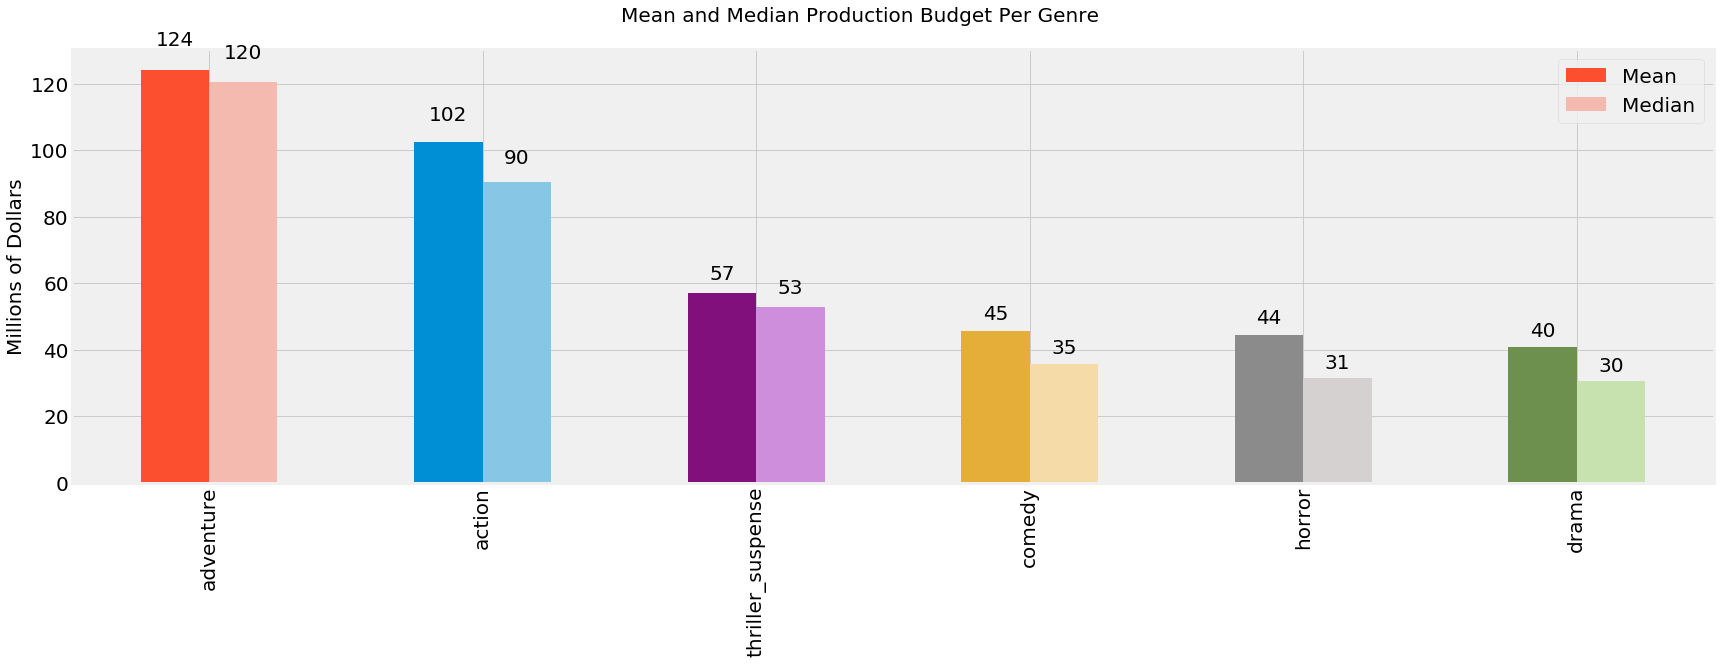

In [162]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Mean and Median Production Budget Per Genre', fontsize=20, y=1.02)

summary.sort_values('avg_budget', ascending=False, inplace=True)

color_list = generate_color_list(colors_needed=2, order_list=summary.index)

summary.plot(y=['avg_budget', 'median_budget'], kind='bar', ax=axis, color=color_list, legend=True)
axis.set_ylabel('Millions of Dollars', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
axis.legend(['Mean', 'Median'], fontsize=20)
autolabel(axis)

plt.tight_layout()

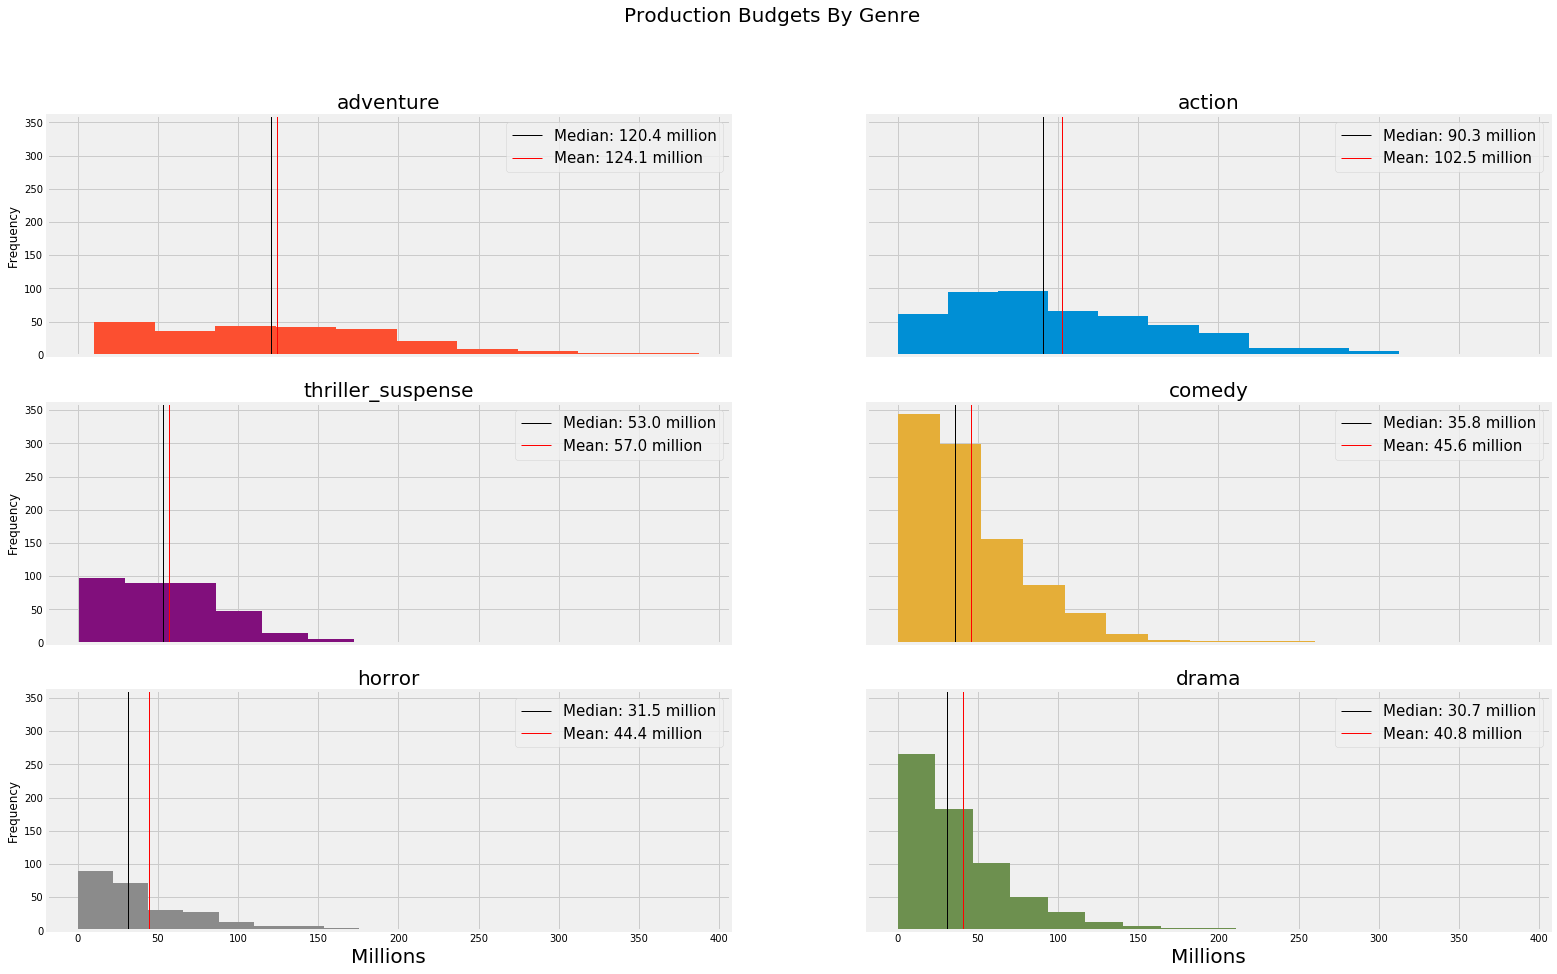

In [163]:
figure, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(24,15))
figure.suptitle('Production Budgets By Genre', fontsize=20)
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

sorted_genres = sorted([{'genre': genre, 'amount': (data[data[genre]]['budget_adj'].median() / 1000000)} for genre in genres], key=lambda k: k['amount'], reverse=True)
genres_list = [item['genre'] for item in sorted_genres]
color_list = generate_color_list(colors_needed=1, order_list=genres_list)

for genre, axis, color in zip(genres_list, axes.flat, color_list):
    (data[data[genre]]['budget_adj'] / 1000000).plot.hist(ax=axis, color=color)
    axis.set_title(genre, fontsize=20)
    axis.axvline(data[data[genre]]['budget_adj'].median() / 1000000, color='k', linewidth=1)
    axis.axvline(data[data[genre]]['budget_adj'].mean() / 1000000, color='r', linewidth=1)
    axis.legend(['Median: {:.1f} million'.format(data[data[genre]]['budget_adj'].median() / 1000000), 'Mean: {:.1f} million'.format(data[data[genre]]['budget_adj'].mean() / 1000000)], fontsize=15)
    axis.set_xlabel('Millions', fontsize=20)

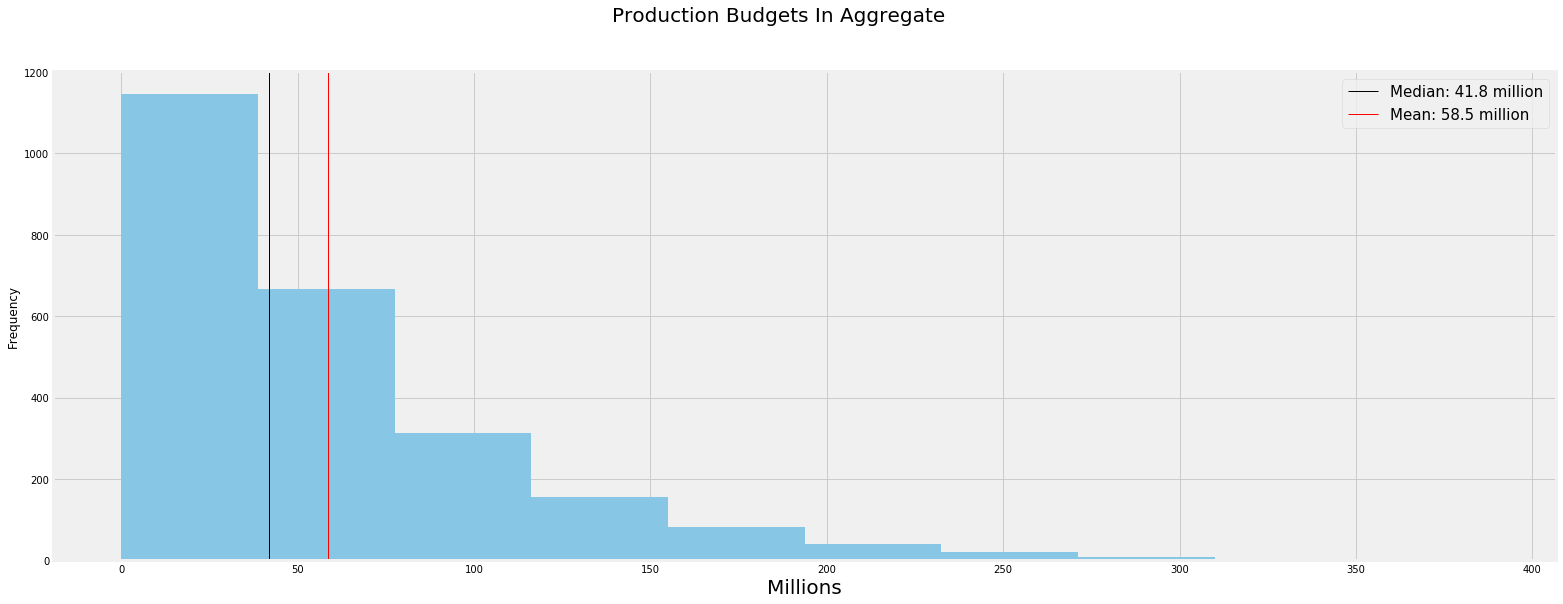

In [164]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24,9))
figure.suptitle('Production Budgets In Aggregate', fontsize=20)

(data['budget_adj'] / 1000000).plot.hist(ax=axis, color=genres_dict['action']['color2']);
axis.set_xlabel('Millions', fontsize=20);
axis.axvline(data['budget_adj'].median() / 1000000, color='k', linewidth=1)
axis.axvline(data['budget_adj'].mean() / 1000000, color='r', linewidth=1)
axis.legend(['Median: {:.1f} million'.format(data['budget_adj'].median() / 1000000), 'Mean: {:.1f} million'.format(data['budget_adj'].mean() / 1000000)], fontsize=15);

### Quick Takeaways

**Median production budget**
  - Adventure and Action have by far the largest median budget. This makes sense, as those movies tend to require more setpieces and CGI than other genres
  - Adventure is 2.3 times the median budget of the third place genre, Thriller/Suspense
  - Comedy, Horror, and Drama all have very similar, low median production budgets 
  - Production budgets are also right-skewed, but they have far less skew than worldwide grosses
  
**Low budgets**
  - We can tell by the median production budget of 41.2 million that the majority of movies produced have a relatively small budget
  - Blockbusters (those costing 200-300 million dollars) are the exception, rather than the rule
  - Something to keep in mind is if this trend has changed in the past decade

# Deeper Dive On Profits

## Boxplot To The Rescue!

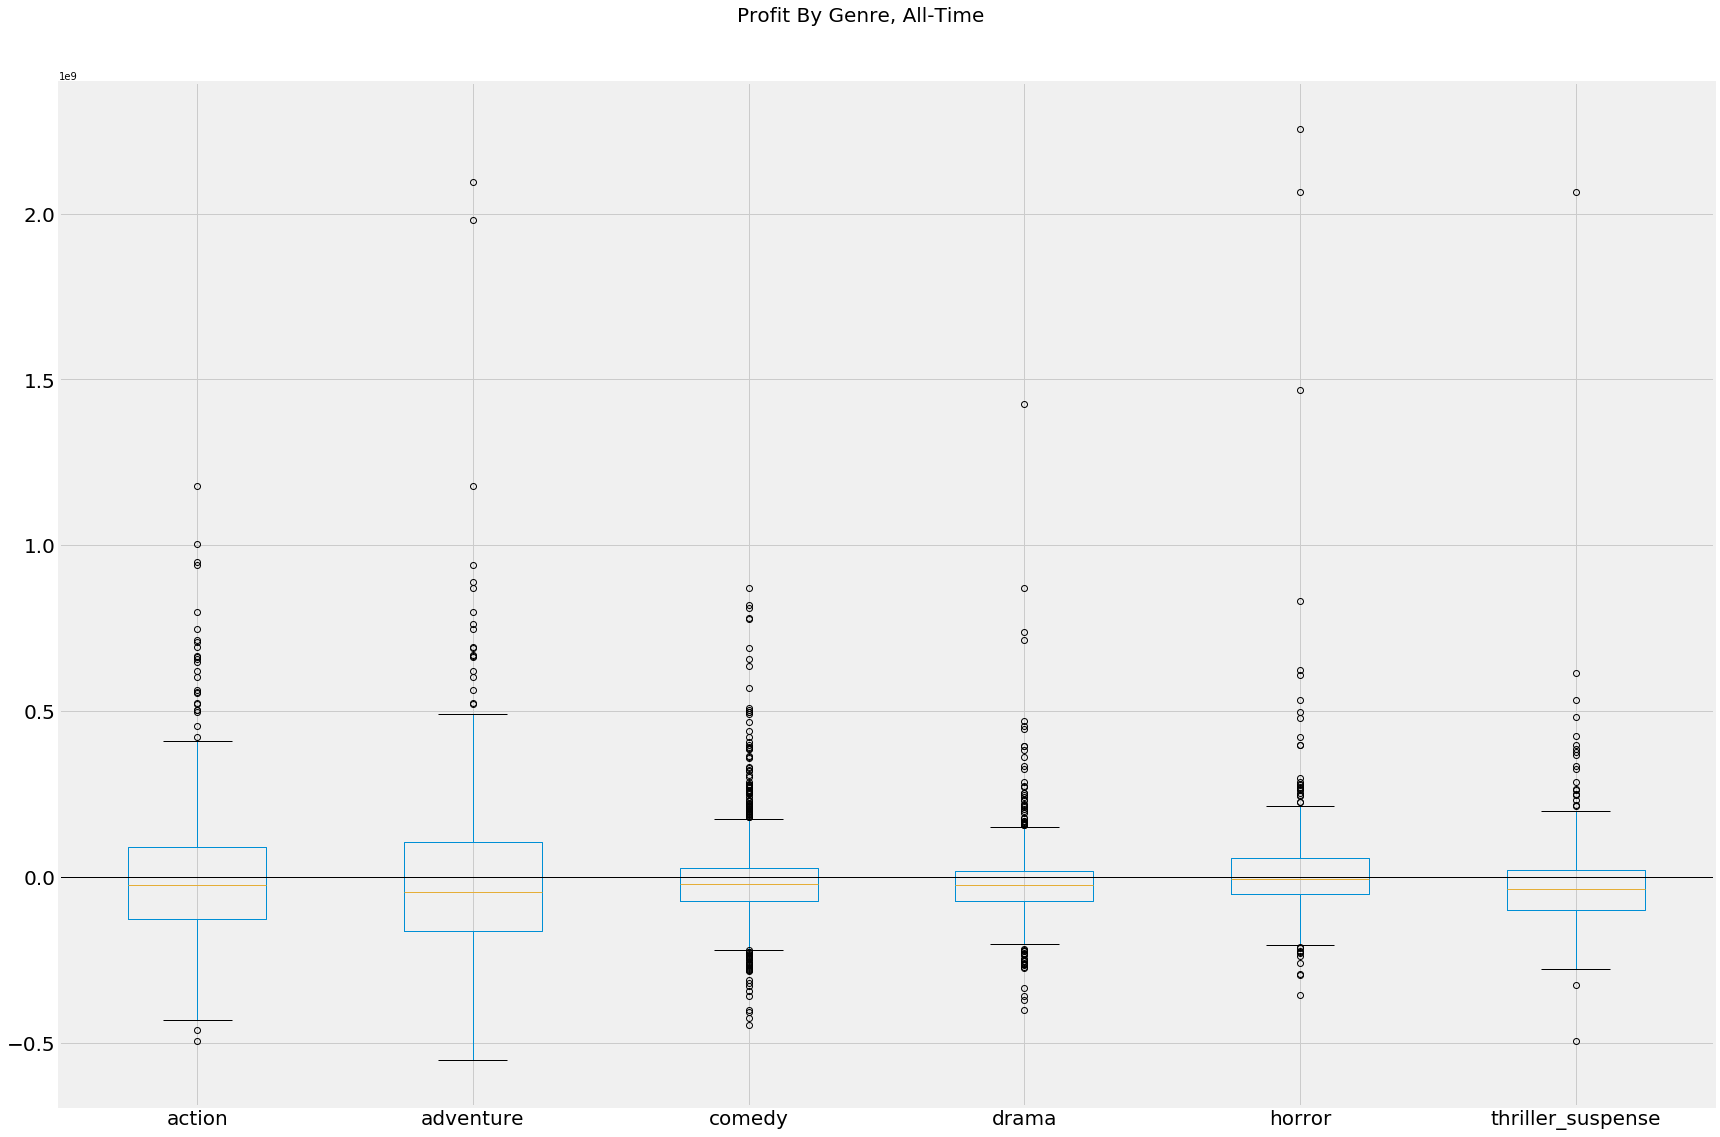

In [97]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24,15))
figure.suptitle('Profit By Genre, All-Time', fontsize=20, y=1.05)

data[profit_columns].plot(kind='box', ax=axis)
axis.set_xticklabels(genres)
axis.tick_params(labelsize=20)
axis.axhline(0, color='k', linewidth=1)

plt.tight_layout()

### Quick Takeaways

**Long right tails and negative medians!**
  - All genres have negative median profit
  - All genres have those glorious right tails, the mega-super-duper-blockbuster hits
  - Comedy, Drama, and Horror have many mega-losers

## Median Profits By Subgenre

In [42]:
def show_median_profit_by_genre(genre, color):
    # Hack to allow 'thriller_suspense' to be searched as the regex 'Thriller|Suspense'
    genre = genre.replace('_', '|')
    
    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
    figure.suptitle('Median Profit By {} Subgenres'.format(genre.title()), fontsize=20)

    only_genre_movies = data[data['genres_mojo'].str.contains('{}'.format(genre.title(), regex=True))]
    median = only_genre_movies['profit'].median() / 1000000

    grp = only_genre_movies.groupby('genres_mojo')['profit'].median().sort_values(ascending=False) / 1000000

    grp.plot(kind='bar', ax=axis, color=color)
    axis.axhline(median, color='k', linewidth=1)
    axis.tick_params(labelsize=20)
    axis.set_xlabel('')
    axis.set_ylabel('Millions', fontsize=20);
    axis.legend(['Overall Median: {:.1f}'.format(median)], loc=3, fontsize=20)
    autolabel(axis);

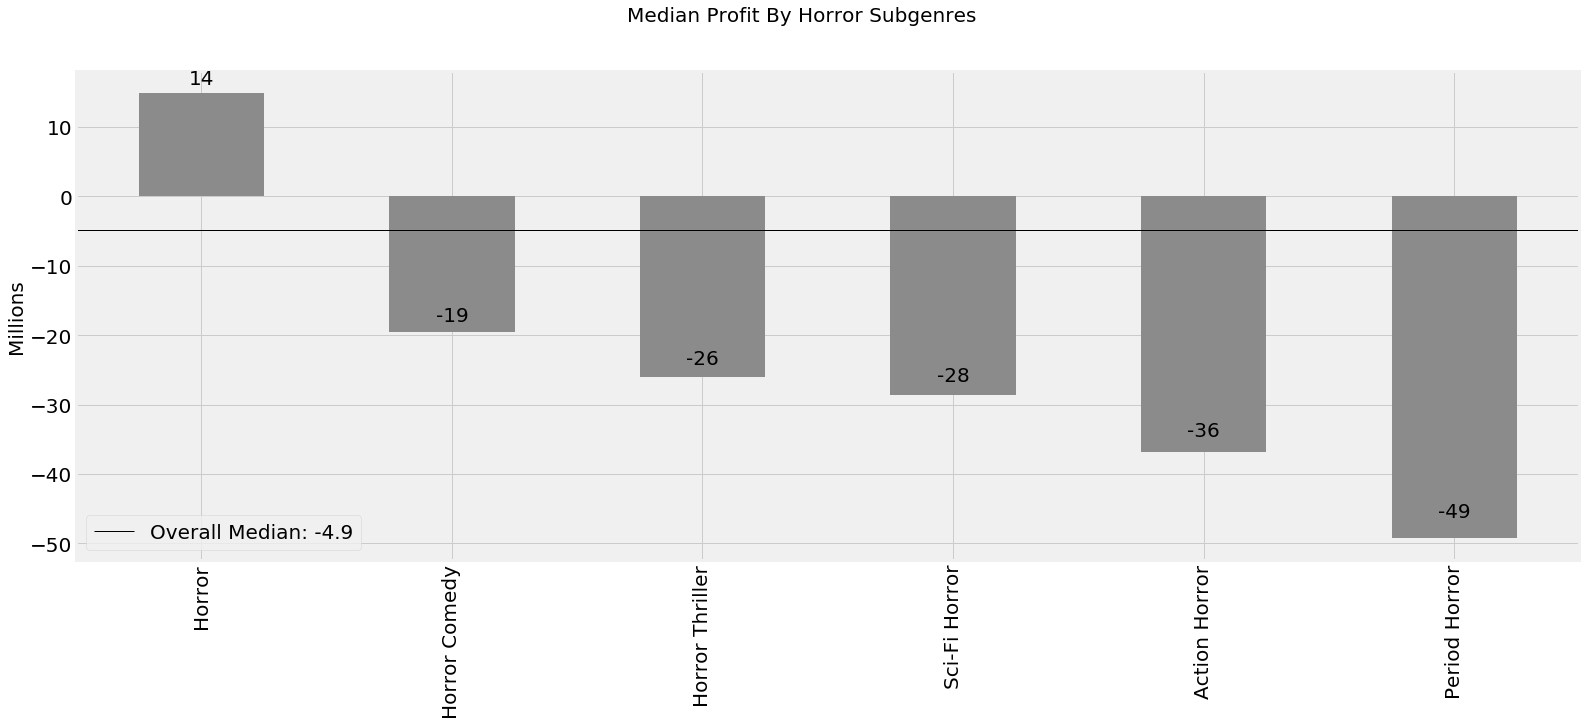

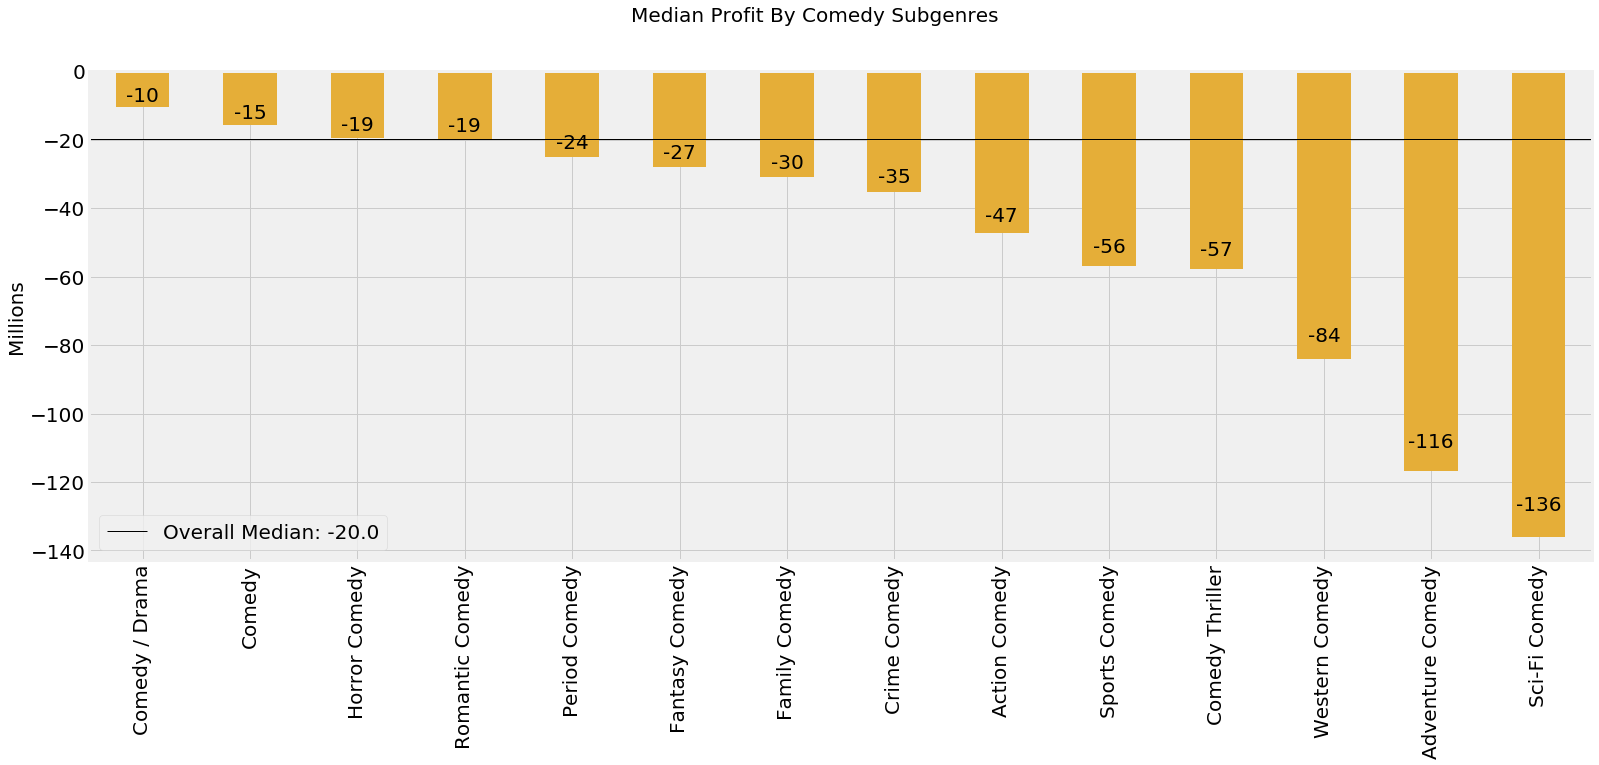

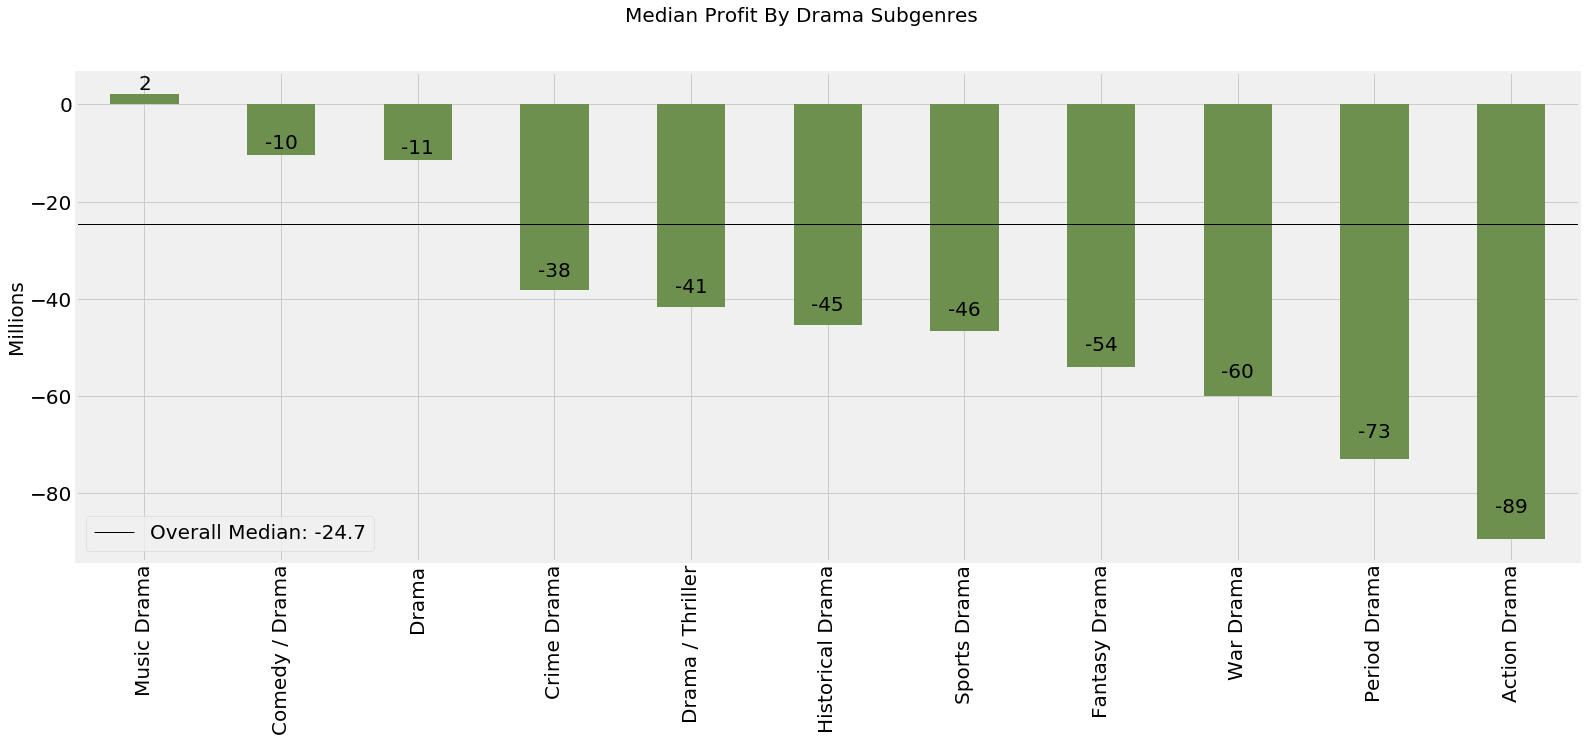

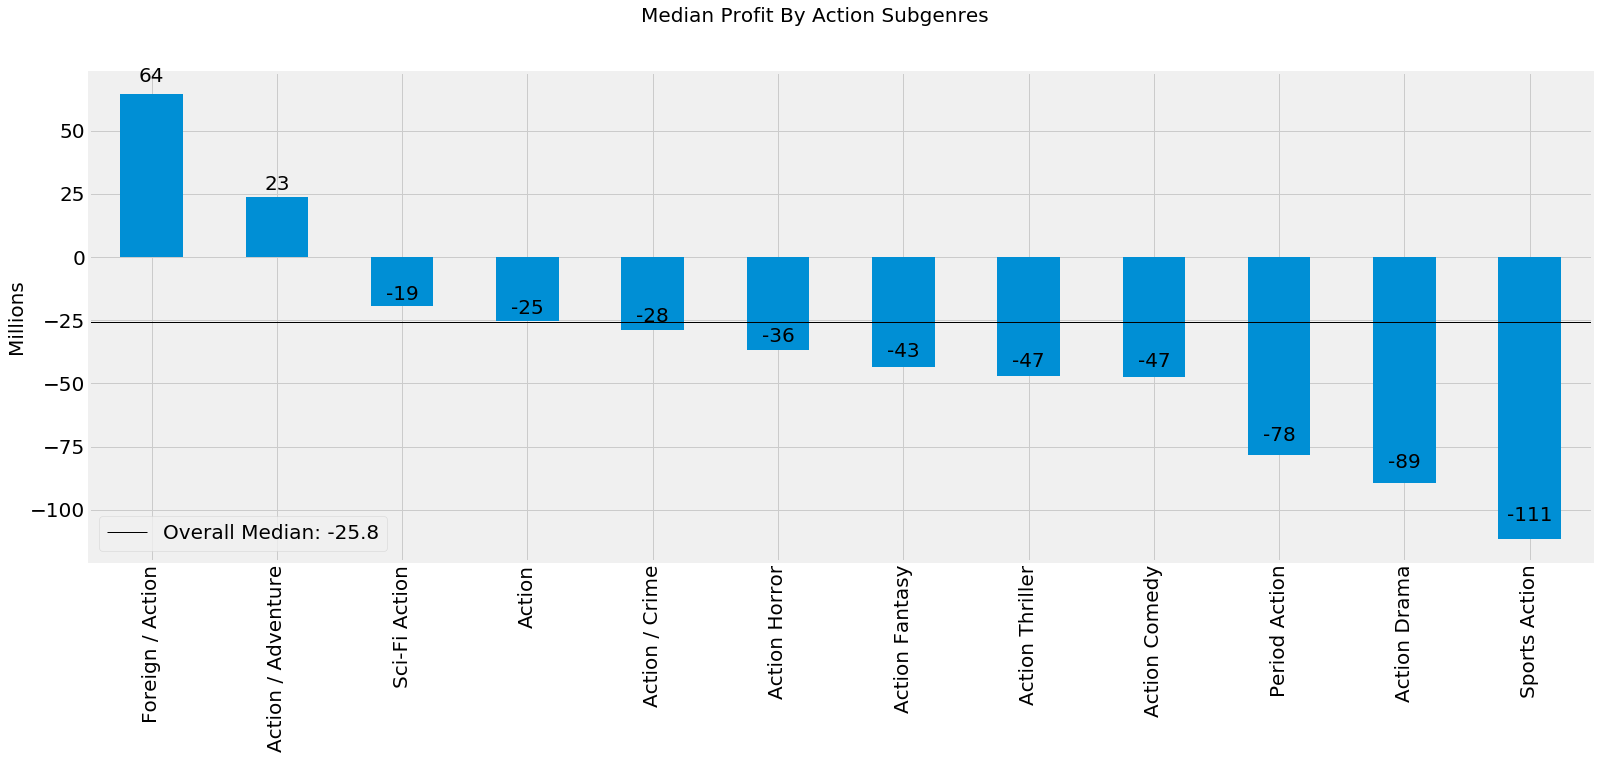

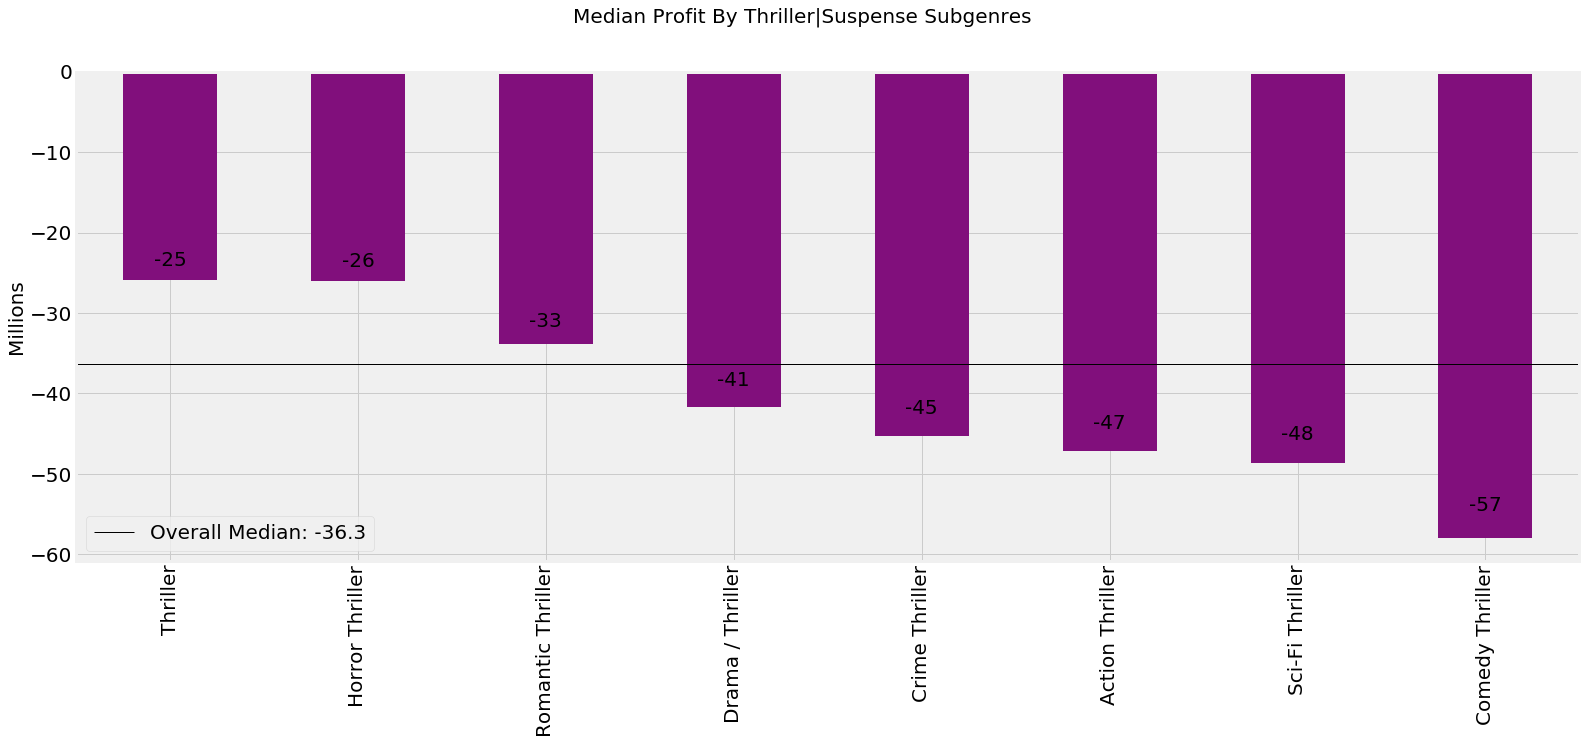

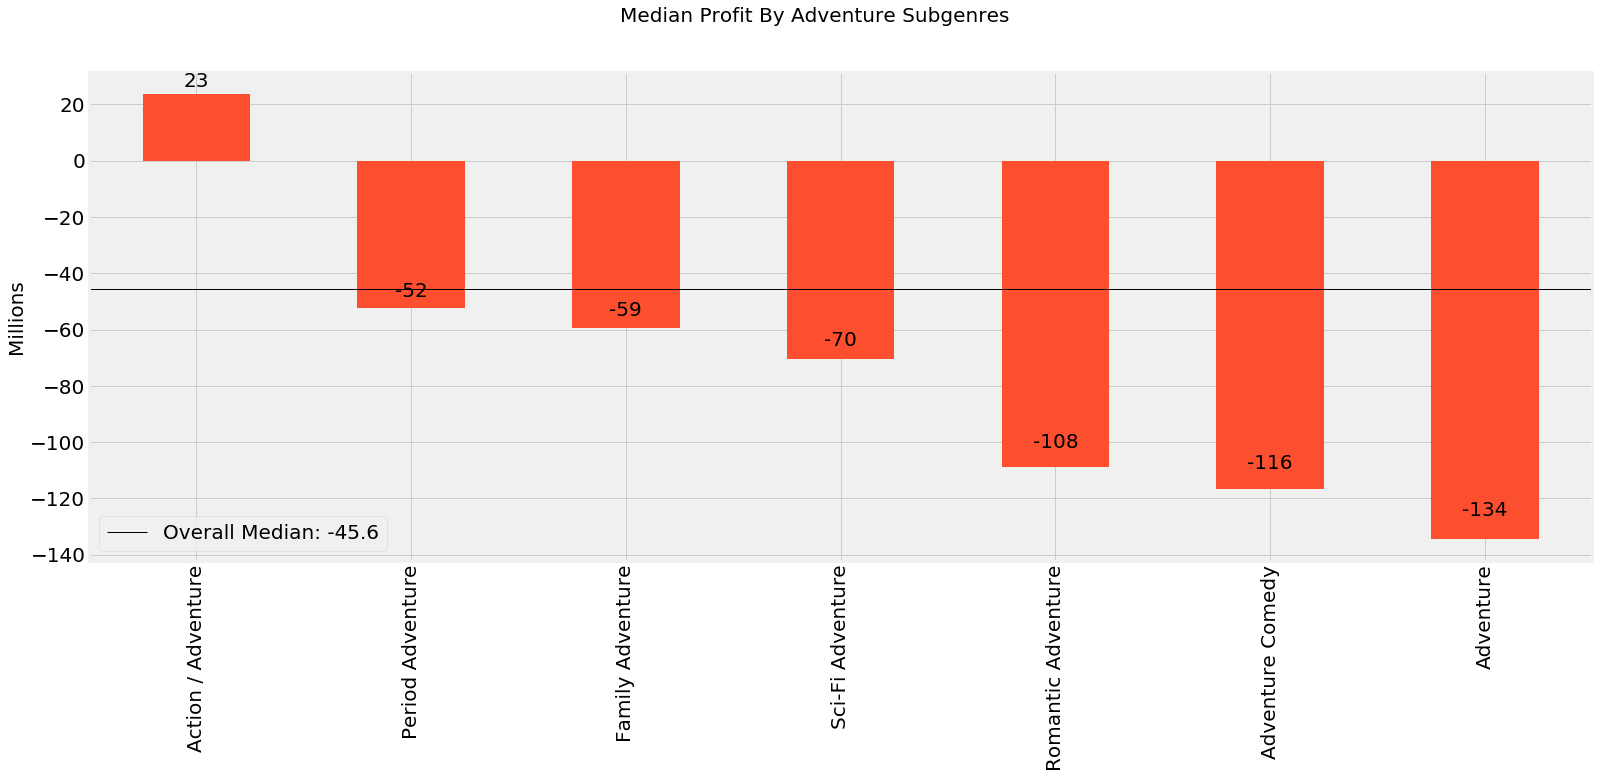

In [167]:
# Get genres sorted in descending order of median profit
sorted_genres = sorted([{'genre': genre, 'amount': (data[data[genre]]['profit'].median() / 1000000)} for genre in genres], key=lambda k: k['amount'], reverse=True)
genres_list = [item['genre'] for item in sorted_genres]
color_list = generate_color_list(colors_needed=1, order_list=genres_list)

for genre, color in zip(genres_list, color_list):
    show_median_profit_by_genre(genre, color)

## Quick Takeaways

**Movies are a tough business**
  - Just looking at the aggregate movie data we have, it seems like almost no genre is a safe bet.
  - No genre (when including all its subgenres) has a positive median profitability.
  - The only subgenres with a positive median profit are (in descending order) Foreign/Action, Action/Adventure, Horror, and Music Drama.

## Mean Profits By Subgenre

In [44]:
def show_mean_profit_by_genre(genre, color):
    # Hack to allow 'thriller_suspense' to be searched as the regex 'Thriller|Suspense'
    genre = genre.replace('_', '|')
    
    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
    figure.suptitle('Mean Profit By {} Subgenres'.format(genre.title()), fontsize=20)

    only_genre_movies = data[data['genres_mojo'].str.contains('{}'.format(genre.title(), regex=True))]
    mean = only_genre_movies['profit'].mean() / 1000000

    grp = only_genre_movies.groupby('genres_mojo')['profit'].mean().sort_values(ascending=False) / 1000000

    grp.plot(kind='bar', ax=axis, color=color)
    axis.axhline(mean, color='k', linewidth=1)
    axis.tick_params(labelsize=20)
    axis.set_xlabel('')
    axis.set_ylabel('Millions', fontsize=20);
    axis.legend(['Overall Mean: {:.1f}'.format(mean)], loc=3, fontsize=20)
    autolabel(axis);

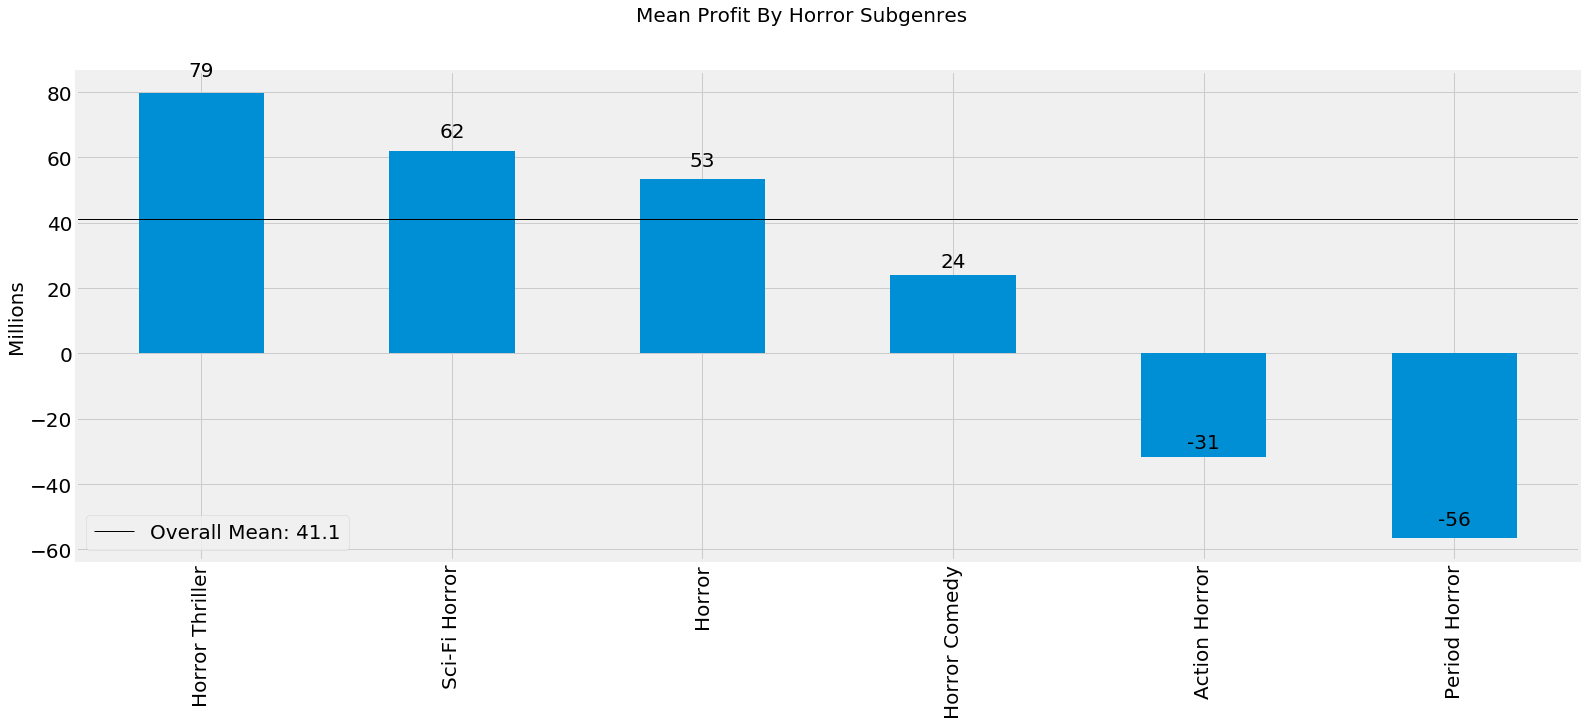

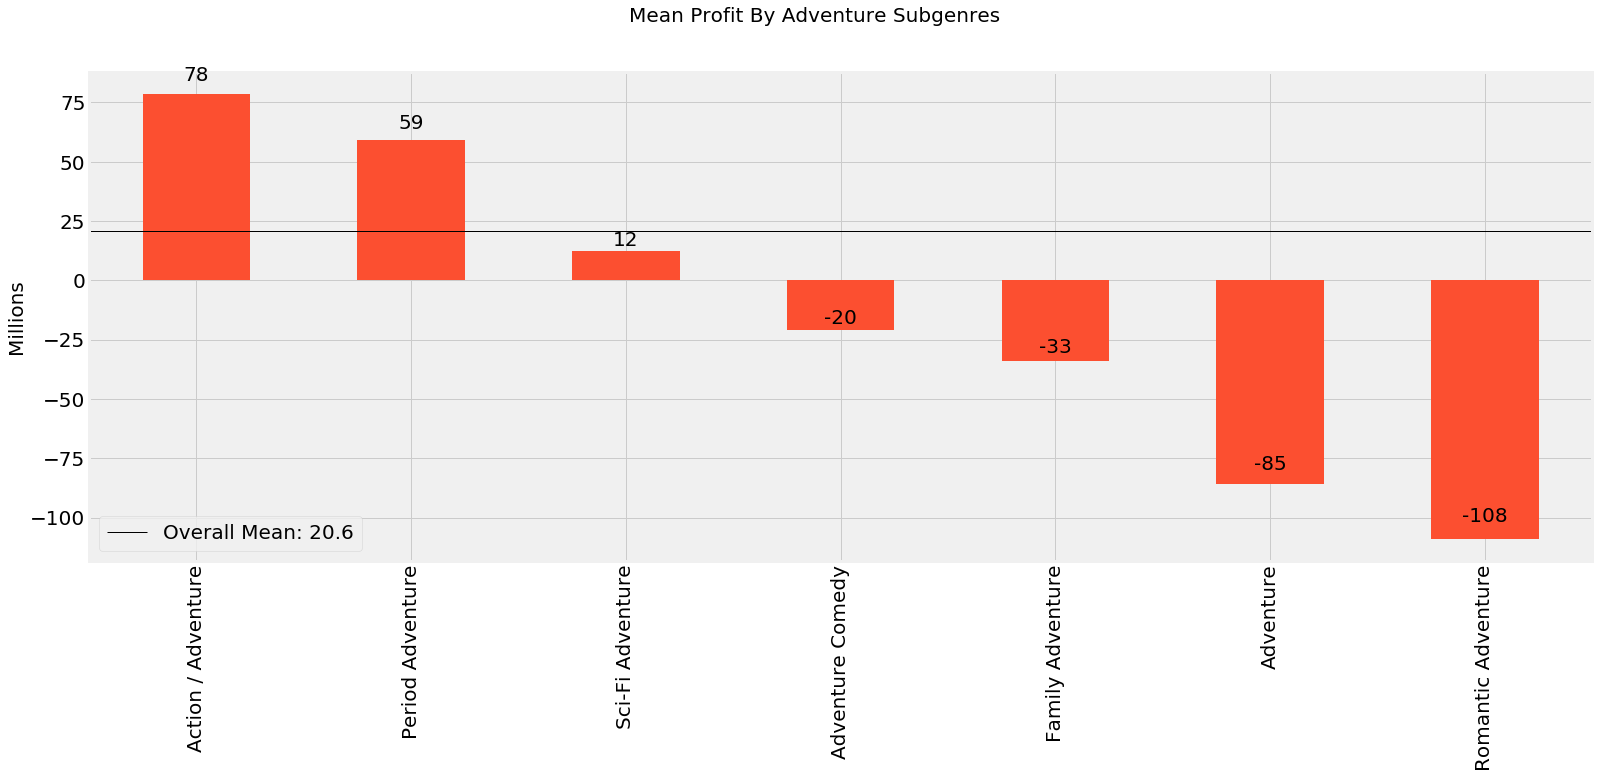

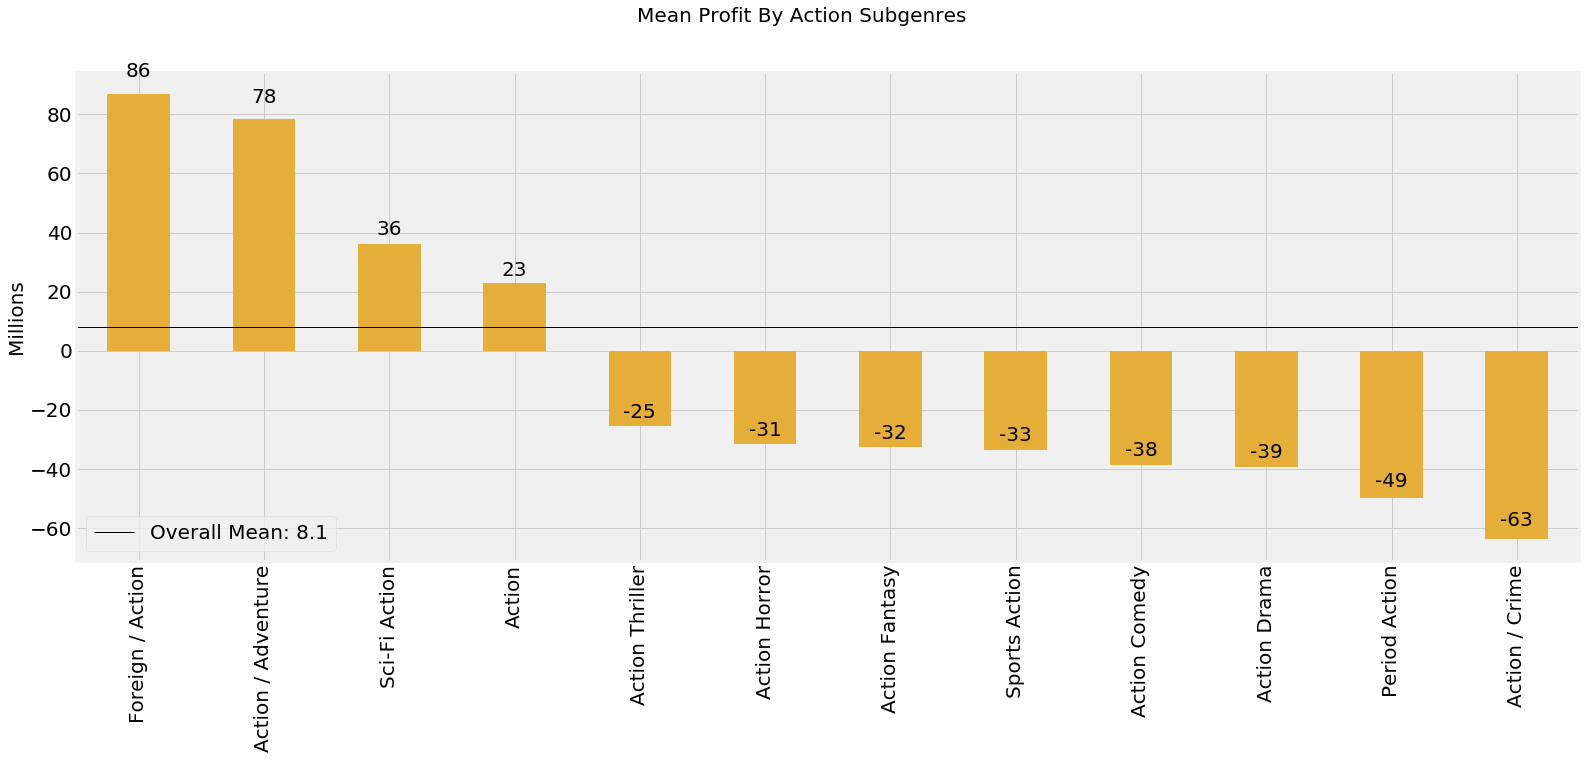

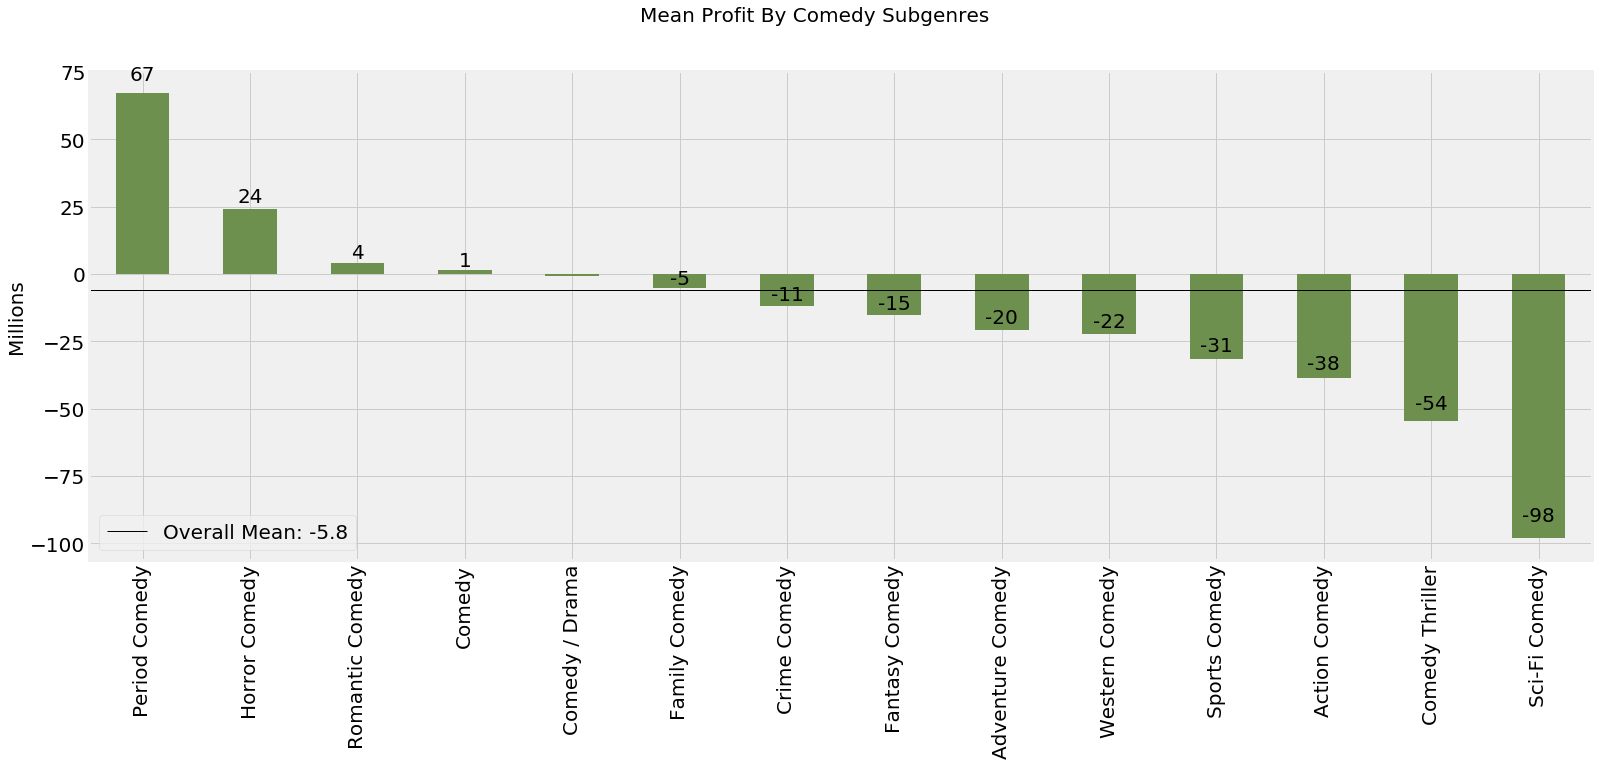

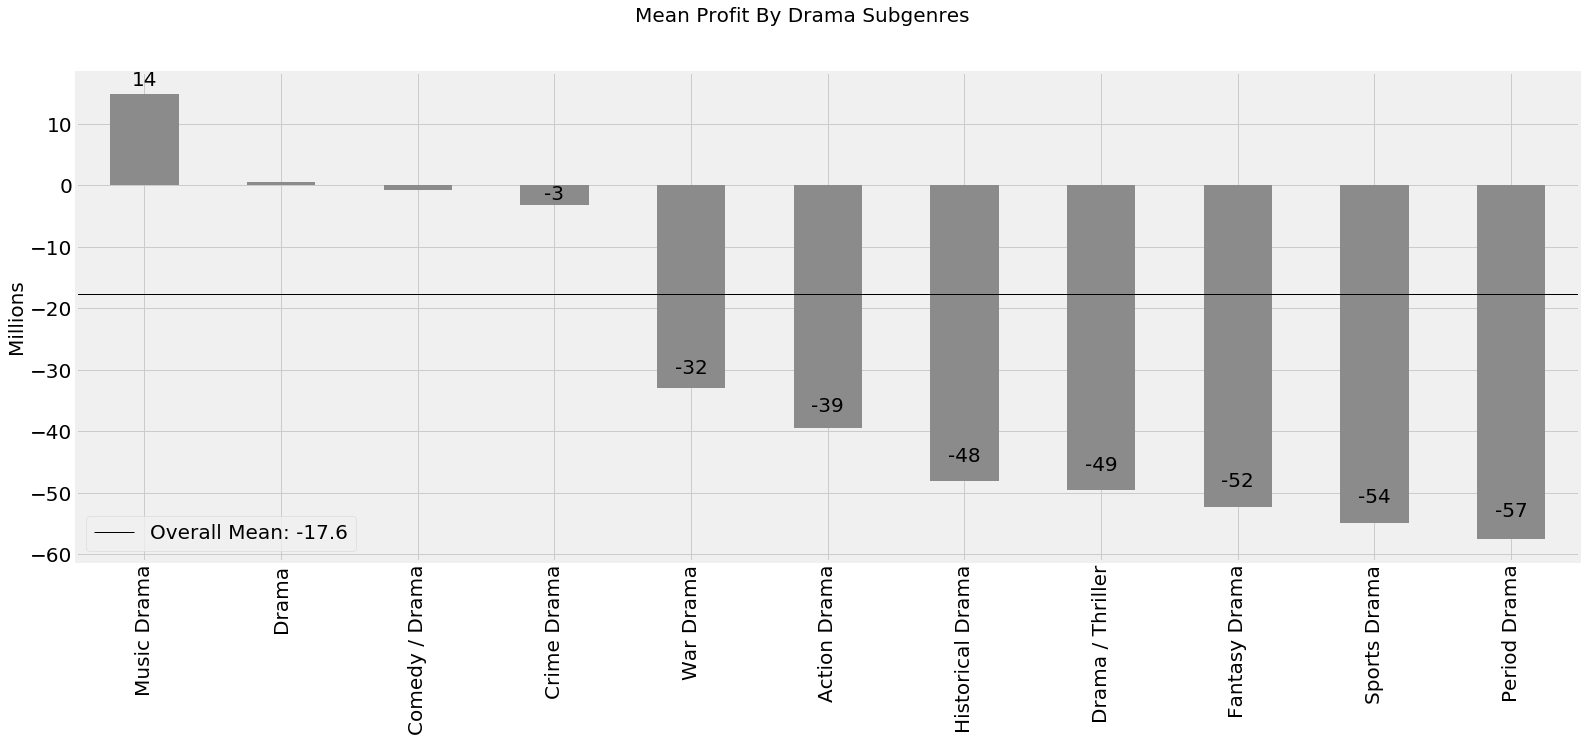

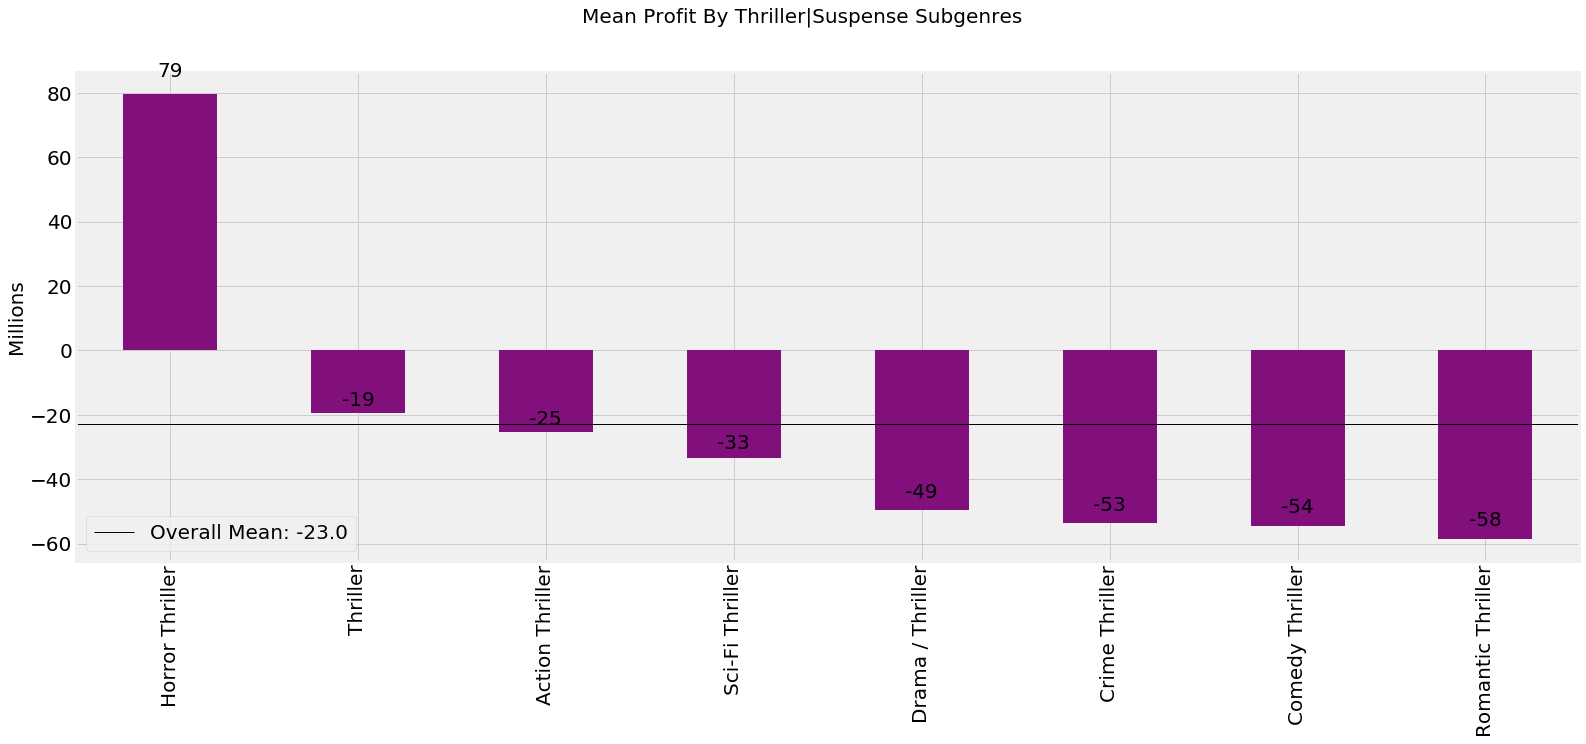

In [45]:
# Get genres sorted in descending order of median profit
sorted_genres = sorted([{'genre': genre, 'amount': (data[data[genre]]['profit'].mean() / 1000000)} for genre in genres], key=lambda k: k['amount'], reverse=True)
genres_list = [item['genre'] for item in sorted_genres]

for genre, color in zip(genres_list, colors):
    show_mean_profit_by_genre(genre, color)

## Quick Takeaways

**The skew strongly affects the results**
  - If we look at mean profits instead of median, the results are much different.
  - Horror, Adventure, and Action are all profitable on the genre level
  - In addition, many more subgenres are profitable in aggregate
  - This is the result of very high-earning movies drastically increasing the average return of other members of their subgenre.

## Dollars Earned Per Dollar Spent

We can calculate this by using our profitability formula. 

We divide the `worldwide_adj` column by (3 * `budget_adj` column).

We can check the results for all-time, the mean, and the median.

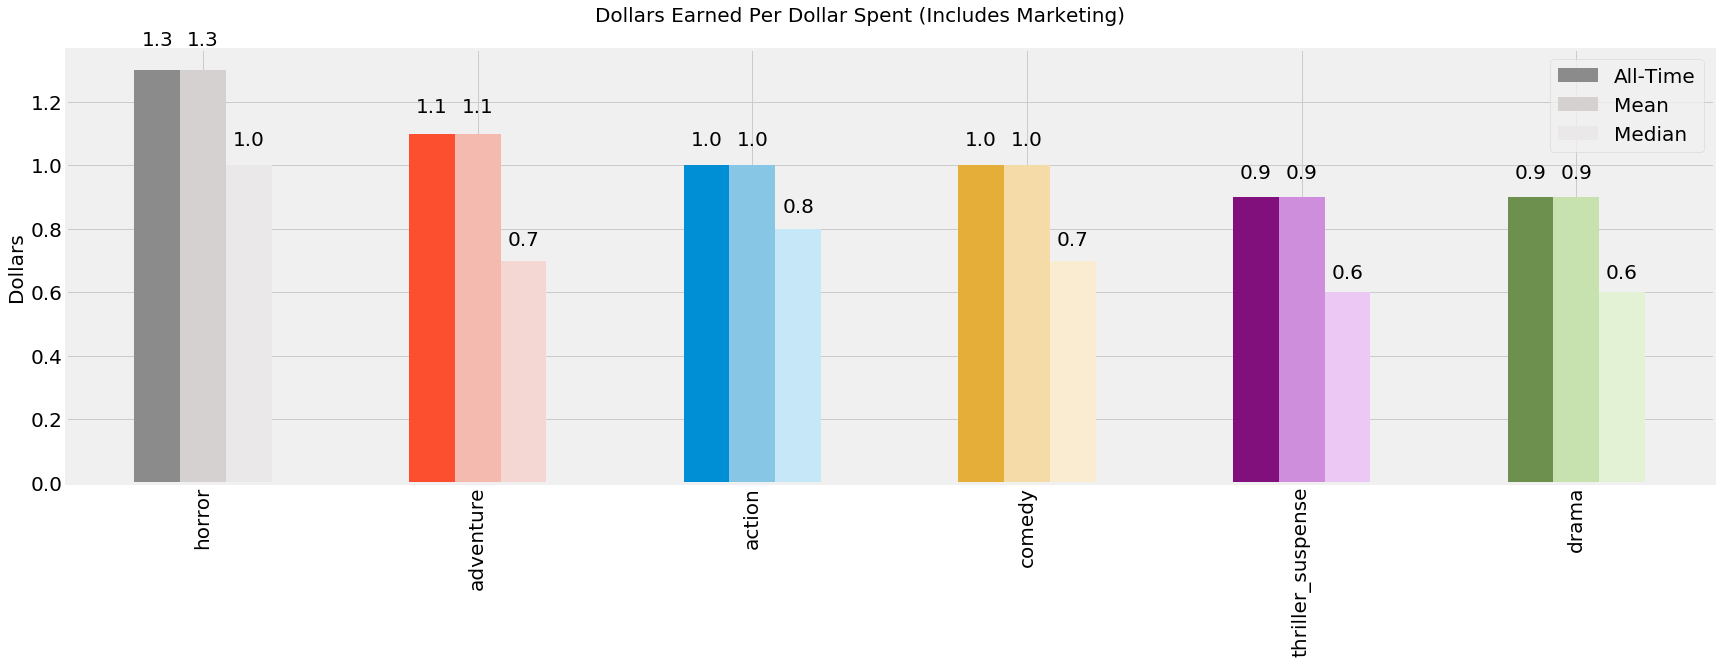

In [168]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Dollars Earned Per Dollar Spent (Includes Marketing)', fontsize=20, y=1.02)

summary.sort_values('dollars_earned_for_dollars_spent', ascending=False, inplace=True)

color_list = generate_color_list(colors_needed=3, order_list=summary.index)

summary.plot(y=['dollars_earned_for_dollars_spent', 'mean_dollars_earned_for_dollars_spent', 'median_dollars_earned_for_dollars_spent'], kind='bar', ax=axis, color=color_list, legend=True)
axis.set_ylabel('Dollars', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
axis.legend(['All-Time', 'Mean', 'Median'], fontsize=20)
autolabel(axis, num_decimals=1)

plt.tight_layout()

## Quick Takeaways

**Same pattern when looking at median versus mean profits**
  - When directly using every single datapoint (`all-time` and `mean`), both Horror and Adventure are profitable in aggregate.
  - However, when using only the median results, Horror is breakeven and all other genres lose money.
  - This is evidence of the power of those long right tails in blockbusters' earnings.

# Breakeven Percentage

We can calculate the percentage chance a movie has to breakeven in aggregate as another way to judge relative risk.

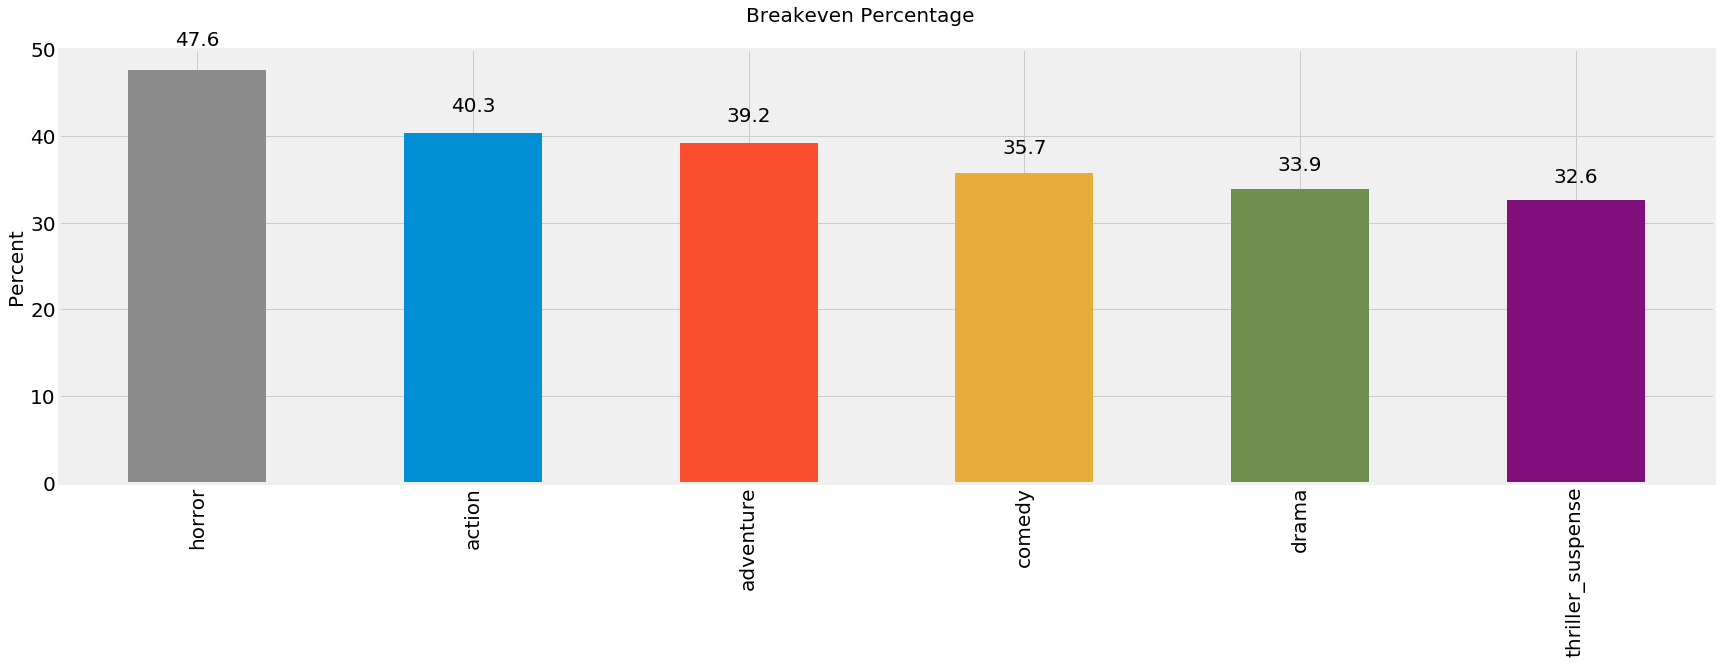

In [169]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Breakeven Percentage', fontsize=20, y=1.02)

summary.sort_values('breakeven_percentage', ascending=False, inplace=True)

color_list = generate_color_list(colors_needed=1, order_list=summary.index)

summary.plot(y='breakeven_percentage', kind='bar', ax=axis, color=color_list, legend=False)
axis.set_ylabel('Percent', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
autolabel(axis, num_decimals=1)

plt.tight_layout()

## Quick Takeaways

**Less than 50%**
  - No genre has a better than 50% chance of breaking even.
  - The least risky one just from a breakeven perpective is Horror.
  - The next least risky movies are Action and Adventure.

# If A Decision Must Be Made Now

This would be a difficult decision to make. 

Action, Comedy, and Adventure have made the most overall money worldwide. Action and Adventure have far higher median worldwide grosses than Comedy. Comedy must be making up for this with its higher numbers of movies released. However, Adventure and Action are the two most expensive genres to make, whereas Comedy is fourth.

The highest aggregate return for every dollar spent comes from Horror, then Adventure. 

The highest median return for every dollar spent comes from Horror, then Action.

The highest median profit per genre is Horror, then Comedy.

The genres with the lowest median budgets are Drama, then Horror, then Comedy.

Movies have the best chance to breakeven in Horror, then Action, then Adventure.

## A Few Strategies

### "Let's not lose money" strategy

If our bosses are all about capital preservation and are more risk-averse as opposed to reward-inclined, I would suggest Horror and Comedy.

Horror is one of the cheapest genres to produce and yet it has the highest median profit per genre. It also has the highest chance to breakeven. Our bosses could make around three Horror movies for the price of a single Action movie, or four Horror movies for the price of one Adventure movie. Horror's median gross of \\$94 million is well below Action's \\$206 million and Adventure's \\$257 million, but it would be a safer play.

Comedy has the second cheapest median budget and the second highest median profit. Historically, it is a solid genre, as it has earned in aggregate the second-most amount of box office dollars (behind only Action). It tends to have a ceiling in terms of box office gross (only one Comedy has ever earned \\$1 billion at the box office, Forrest Gump), but it's a reliable bet given it's much lower budget compared to big fare like Action and Adventure.

### "Swing for the fences" strategy

If our bosses really care about releasing those mega blockbusters and risk be damned, then we all know they're talking about Action and Adventure, the kings of the right tails. 16 of the top 20 all-time highest grossing movies are in one of those two genres. Three of the other four are in the Horror genre.

I would suggest sticking to those three genres.

## Disclaimer

There are a lot of reasons why studios prefer to make certain genres over others. After all, it's tough to make theme park rides based on Drama and Comedy movies. This analysis assumes we only care about how much money a movie makes at the box office.

## Let's Keep Digging

So far, we have only analyzed these genres in aggregate. 

Our bosses want more pinpoint accuracy. Which genres are the hottest right now? Which genres perform the best during which parts of the year?

So we've got more digging to do, and we'll next look for trends by Release Decade and Release Week. 

# Performance By Decade

We will now dive into the performance of movies by decade of release.

## Number of movies

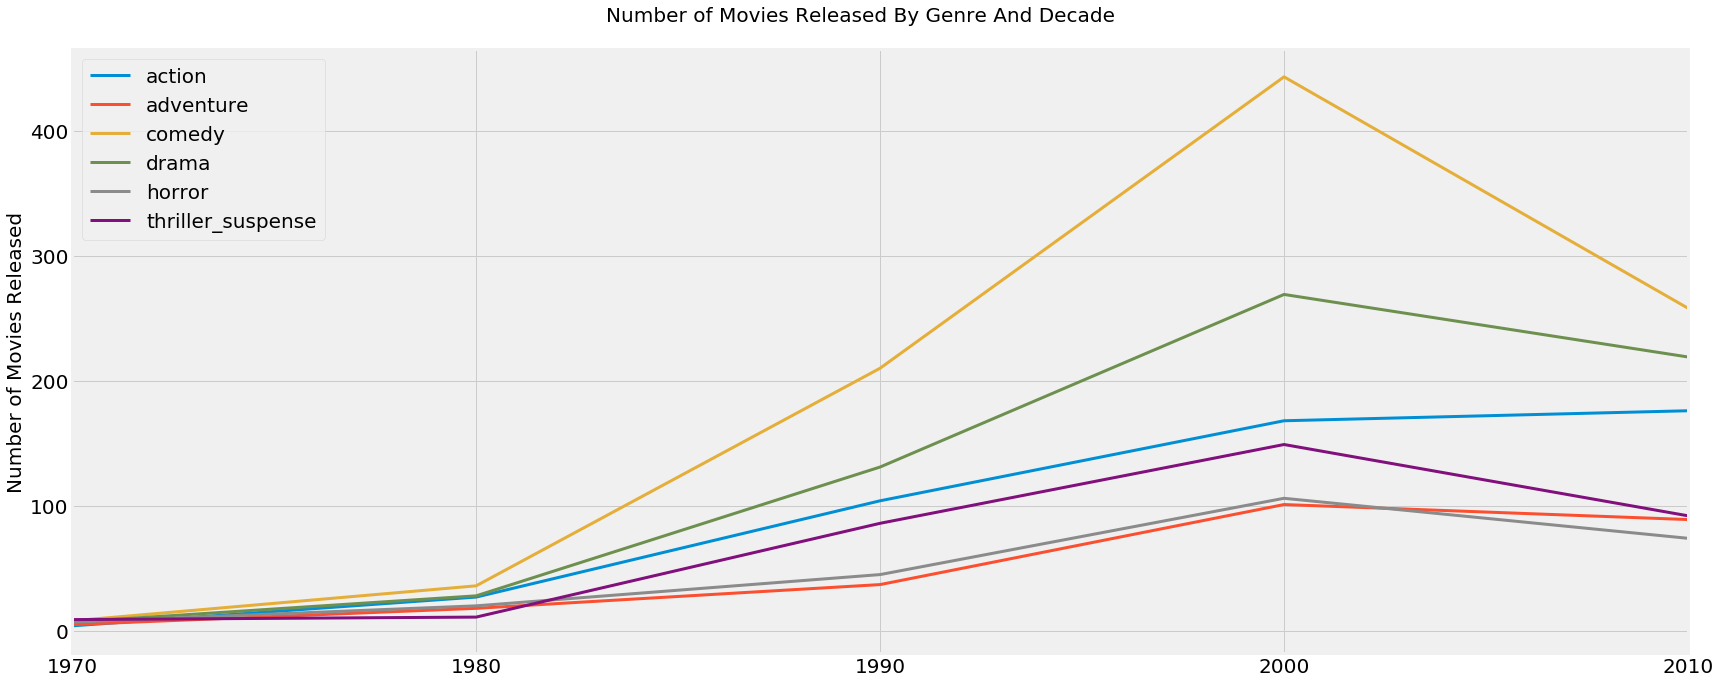

In [48]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24,9))
figure.suptitle('Number of Movies Released By Genre And Decade', fontsize=20, y=1.05)
grp = data.groupby('release_decade')[genres].sum()
grp.plot(ax=axis, linewidth=3)
axis.set_ylabel('Number of Movies Released', fontsize=20)
axis.tick_params(labelsize=20)
axis.set_xticks(range(1970, 2020, 10))
axis.set_xlabel('')
axis.legend(genres, fontsize=20)
plt.tight_layout()

### Quick Takeaways

**1970s to 2000s**
  - We see huge increases in the number of movies released per genre
  - Comedy and Drama are the most produced genres from then to the present by a wide margin
  
**2000s to 2010s**
  - We see a reduction in the number of movies released for all genres except Action 
  
**Fewer movies made now**
- Our gut should tell us movies are not as profitable now as they used to be because the Big Five release far fewer movies now than they did in the 2000s.

## Grosses

### Aggregate

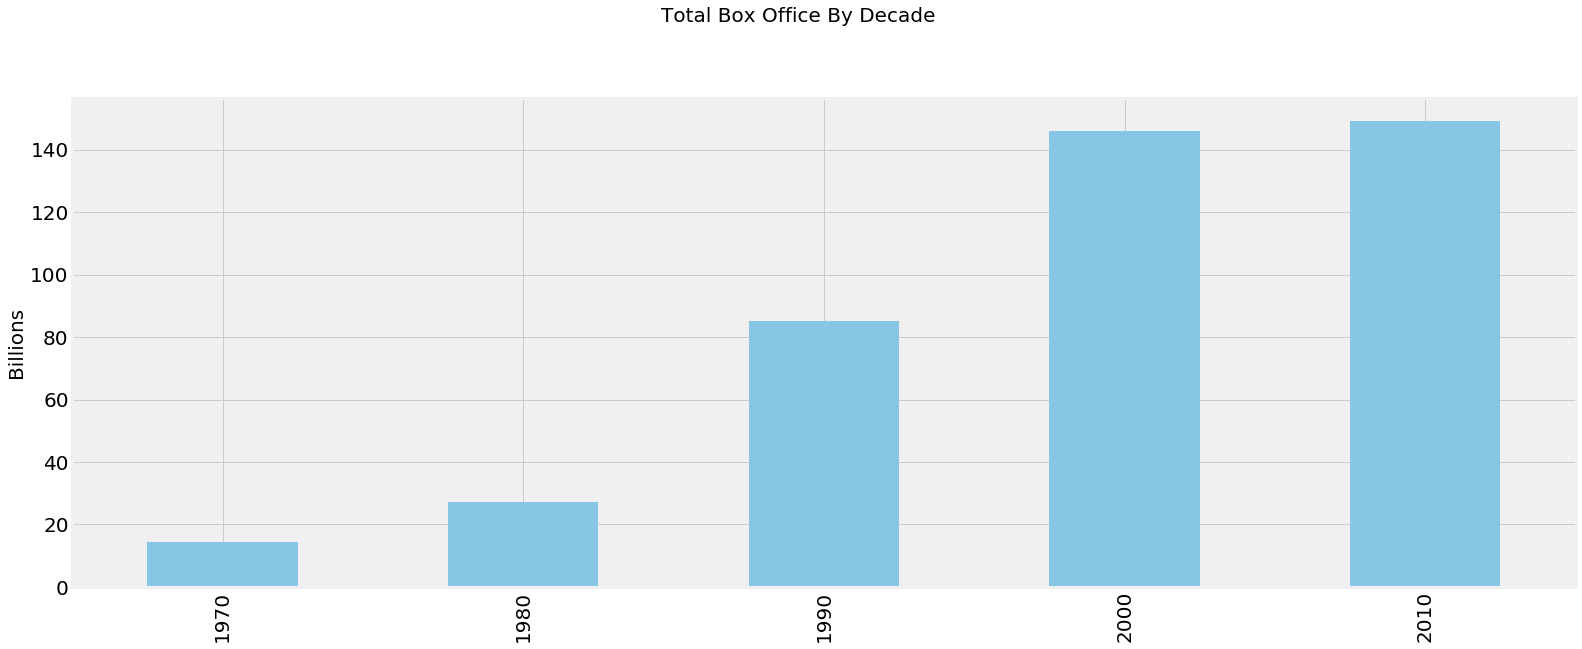

In [170]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24,9))
figure.suptitle('Total Box Office By Decade', fontsize=20, y=1.02)

(data.groupby('release_decade')['worldwide_adj'].sum() / 1000000000).plot(kind='bar', fontsize=20, color=genres_dict['action']['color2'])
axis.set_ylabel('Billions', fontsize=20)
axis.set_xlabel('');

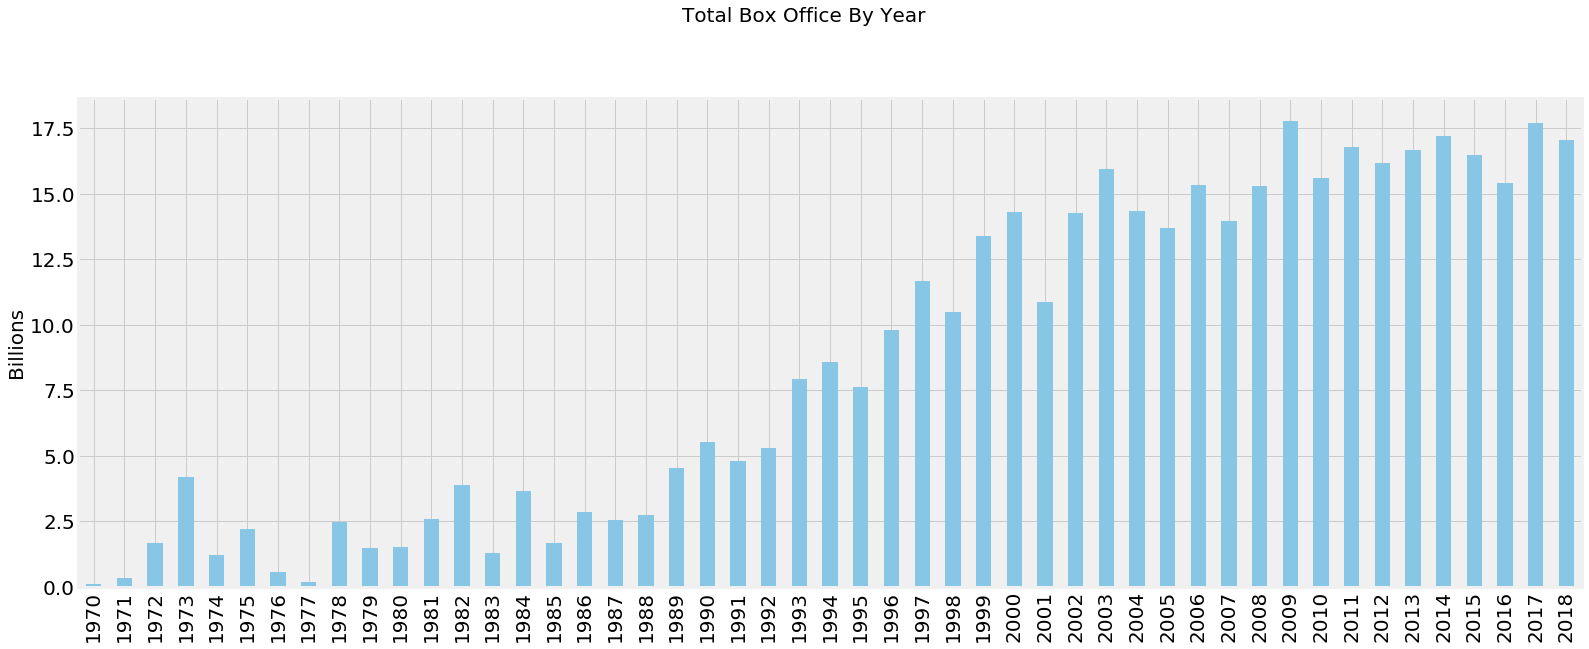

In [171]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24,9))
figure.suptitle('Total Box Office By Year', fontsize=20, y=1.02)

(data.groupby('release_year')['worldwide_adj'].sum() / 1000000000).plot(kind='bar', fontsize=20, color=genres_dict['action']['color2'])
axis.set_ylabel('Billions', fontsize=20)
axis.set_xlabel('');

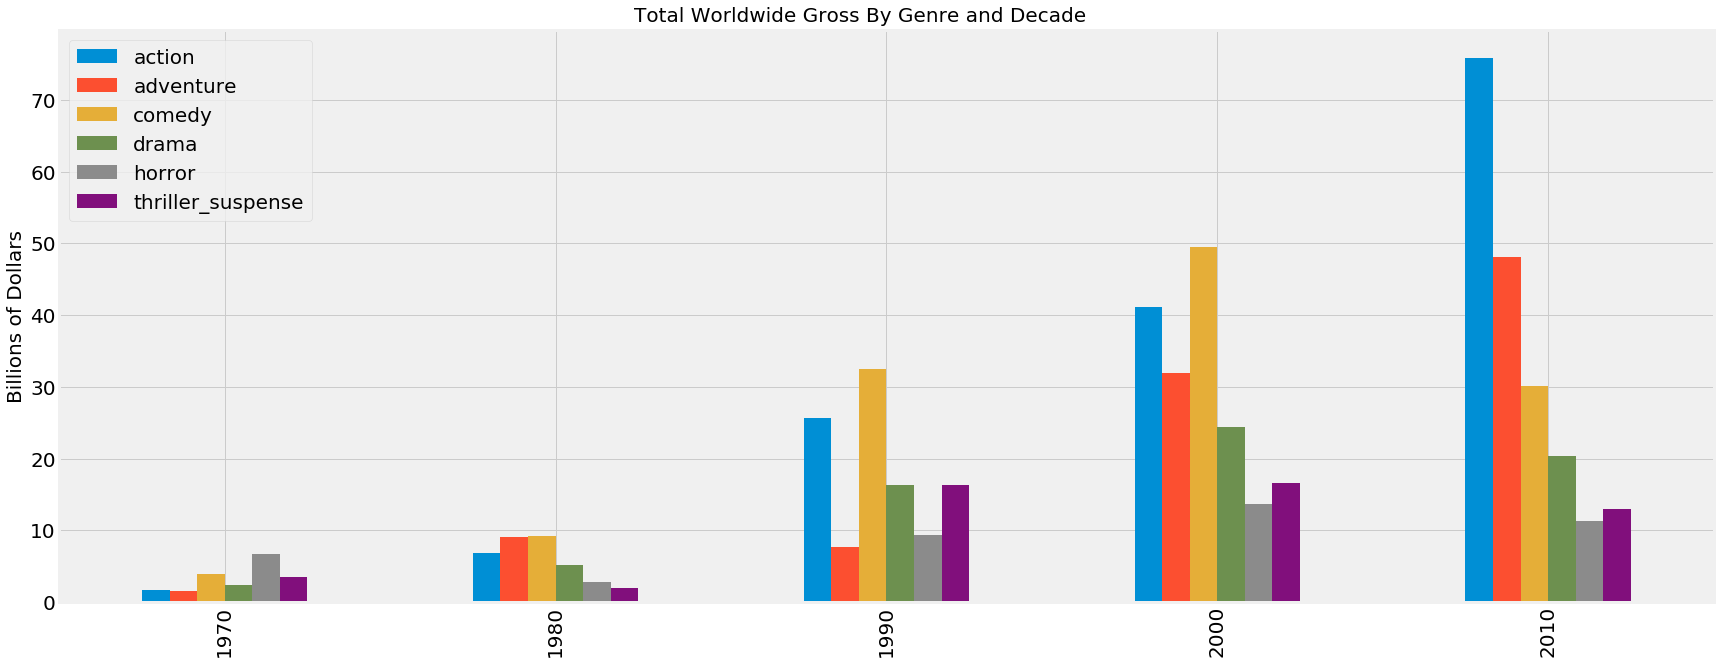

In [51]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Total Worldwide Gross By Genre and Decade', fontsize=20, y=1.02)

grp = data.groupby('release_decade')[gross_columns].sum() / 1000000000
grp.plot(kind='bar', ax=axis)
axis.set_ylabel('Billions of Dollars', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
axis.legend(genres, fontsize=20)

plt.tight_layout()

In [203]:
# Create custom function to determine background color for genre that had highest total per decade
def find_genre_for_background_color(groupby_instance, decade):
    column_name_list = groupby_instance.loc[decade].sort_values(ascending=False).index[0].split('_')
    
    #Check if the split string has length 4, if so it is thriller_suspense and requires extra filtering
    if len(column_name_list) == 4:
        return '_'.join(column_name_list[-2:])
    
    # If the genre is not 'thriller_suspense', we just need the last word in the list
    return column_name_list[-1]

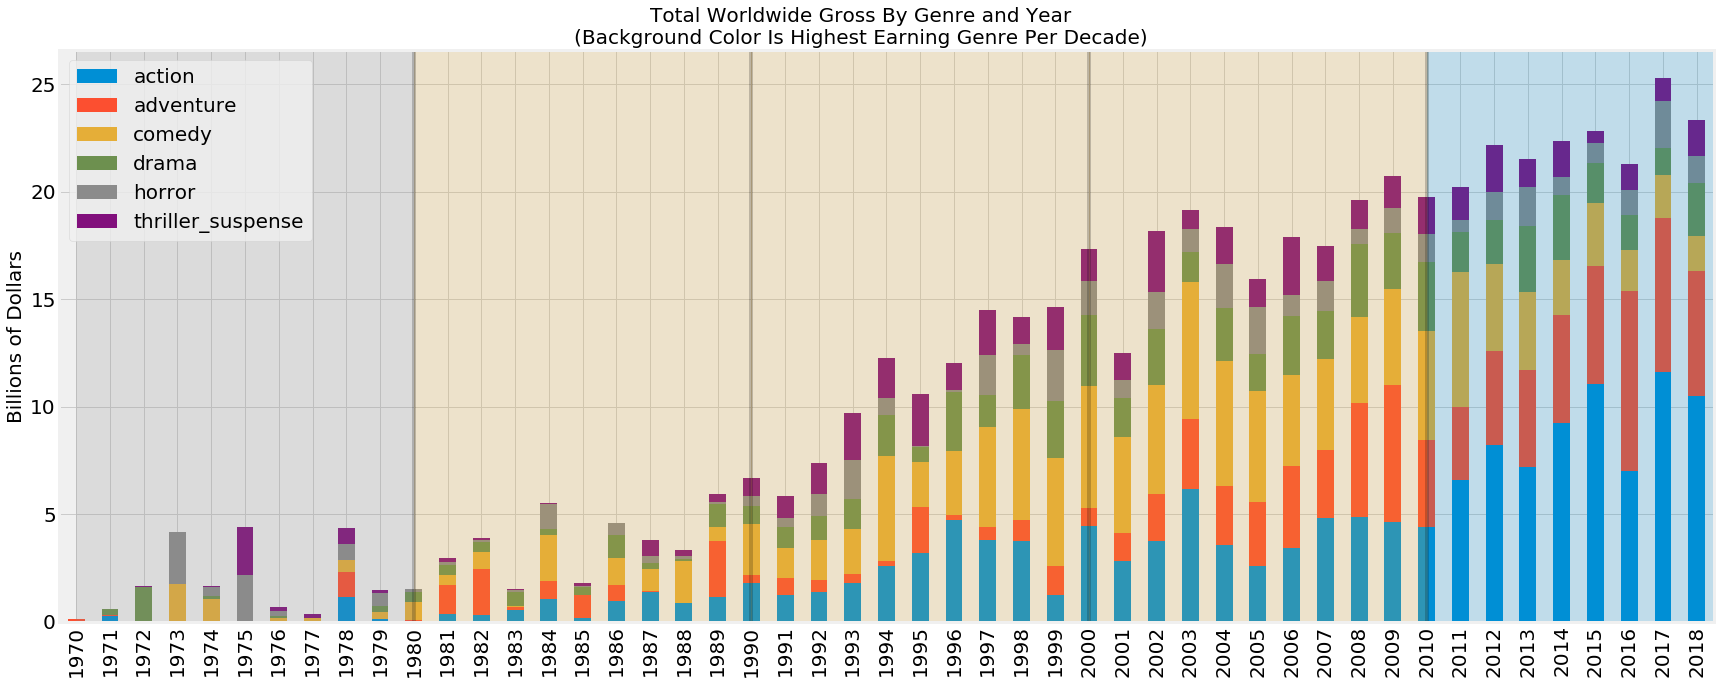

In [204]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Total Worldwide Gross By Genre and Year\n(Background Color Is Highest Earning Genre Per Decade)', fontsize=20, y=1.05)

# Determine background colors for each decade
grp = data.groupby('release_decade')[gross_columns].sum() / 1000000000
bg_1970 = genres_dict[find_genre_for_background_color(grp, 1970)]['color1']
bg_1980 = genres_dict[find_genre_for_background_color(grp, 1980)]['color1']
bg_1990 = genres_dict[find_genre_for_background_color(grp, 1990)]['color1']
bg_2000 = genres_dict[find_genre_for_background_color(grp, 2000)]['color1']
bg_2010 = genres_dict[find_genre_for_background_color(grp, 2010)]['color1']

# Set up plot
grp = data.groupby('release_year')[gross_columns].sum() / 1000000000
grp.plot(kind='bar', stacked=True, ax=axis)
axis.set_ylabel('Billions of Dollars', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
axis.legend(genres, fontsize=20)
axis.axvspan(0, 10, color=bg_1970, alpha=0.2)
axis.axvspan(10, 20, color=bg_1980, alpha=0.2)
axis.axvspan(20, 30, color=bg_1990, alpha=0.2)
axis.axvspan(30, 40, color=bg_2000, alpha=0.2)
axis.axvspan(40, 50, color=bg_2010, alpha=0.2)
axis.axvline(10, color='k', alpha=0.2)
axis.axvline(20, color='k', alpha=0.2)
axis.axvline(30, color='k', alpha=0.2)
axis.axvline(40, color='k', alpha=0.2)

plt.tight_layout()

### Quick Takeaways

**Box office increasing at a slower rate**
  - Decade by decade, the global box office revenue is increasing, but its rate of growth has slowed down.
  - Action and Adventure have increased their overall gross every decade since the 1980s.
  - Horror was the highest grossing genre in the 1970s.
  - Comedy was the highest grossing genre for the 1980s, 1990s, and 2000s.
  - Comedy had a big jump from the 1990s to 2000s, but has contracted in the 2010s.
  - Action is the highest grossing genre in the 2010s.
  - Drama, Horror, and Thriller/Suspense seem flat from the 2000s to 2010s.
  
**Note**
  - This graph shows higher global box office numbers than the 'Total Box Office By Year' graph. This is due to how we count a movie multiple times if it has multiple genres. For example, an Action/Adventure movie would count as both an Action movie and an Adventure movie. Thus, the box office results for that movie would be reported twice when we subdivide by genre.

### Mean and Median Gross

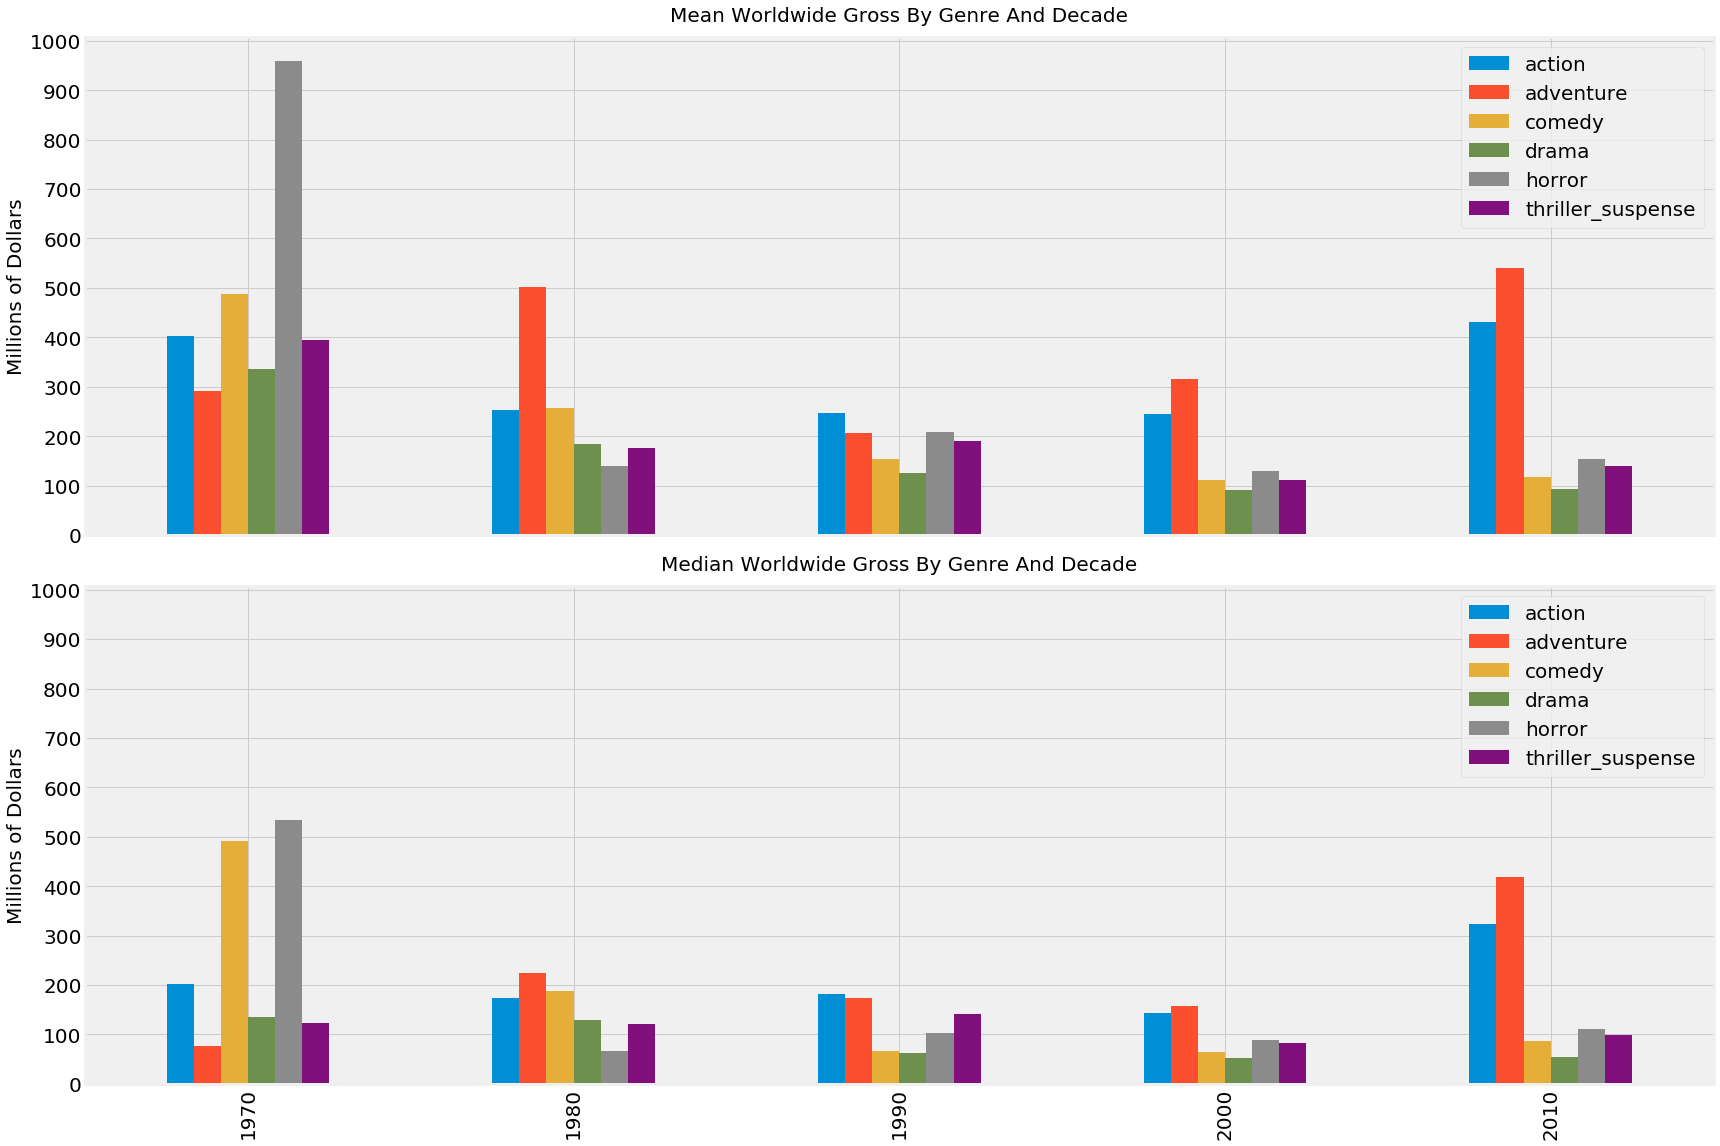

In [53]:
figure, (axis1, axis2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(24, 16))

grp = data.groupby('release_decade')[gross_columns].mean() / 1000000
grp.plot(kind='bar', ax=axis1)
axis1.set_ylabel('Millions of Dollars', fontsize=20)
axis1.set_yticks(range(0, 1100, 100))
axis1.set_xlabel('')
axis1.tick_params(labelsize=20)
axis1.legend(genres, fontsize=20)
axis1.set_title('Mean Worldwide Gross By Genre And Decade', fontsize=20, y=1.02)

grp = data.groupby('release_decade')[gross_columns].median() / 1000000
grp.plot(kind='bar', ax=axis2)
axis2.set_ylabel('Millions of Dollars', fontsize=20)
axis2.set_xlabel('')
axis2.tick_params(labelsize=20)
axis2.legend(genres, fontsize=20)
axis2.set_title('Median Worldwide Gross By Genre And Decade', fontsize=20, y=1.02)

plt.tight_layout()

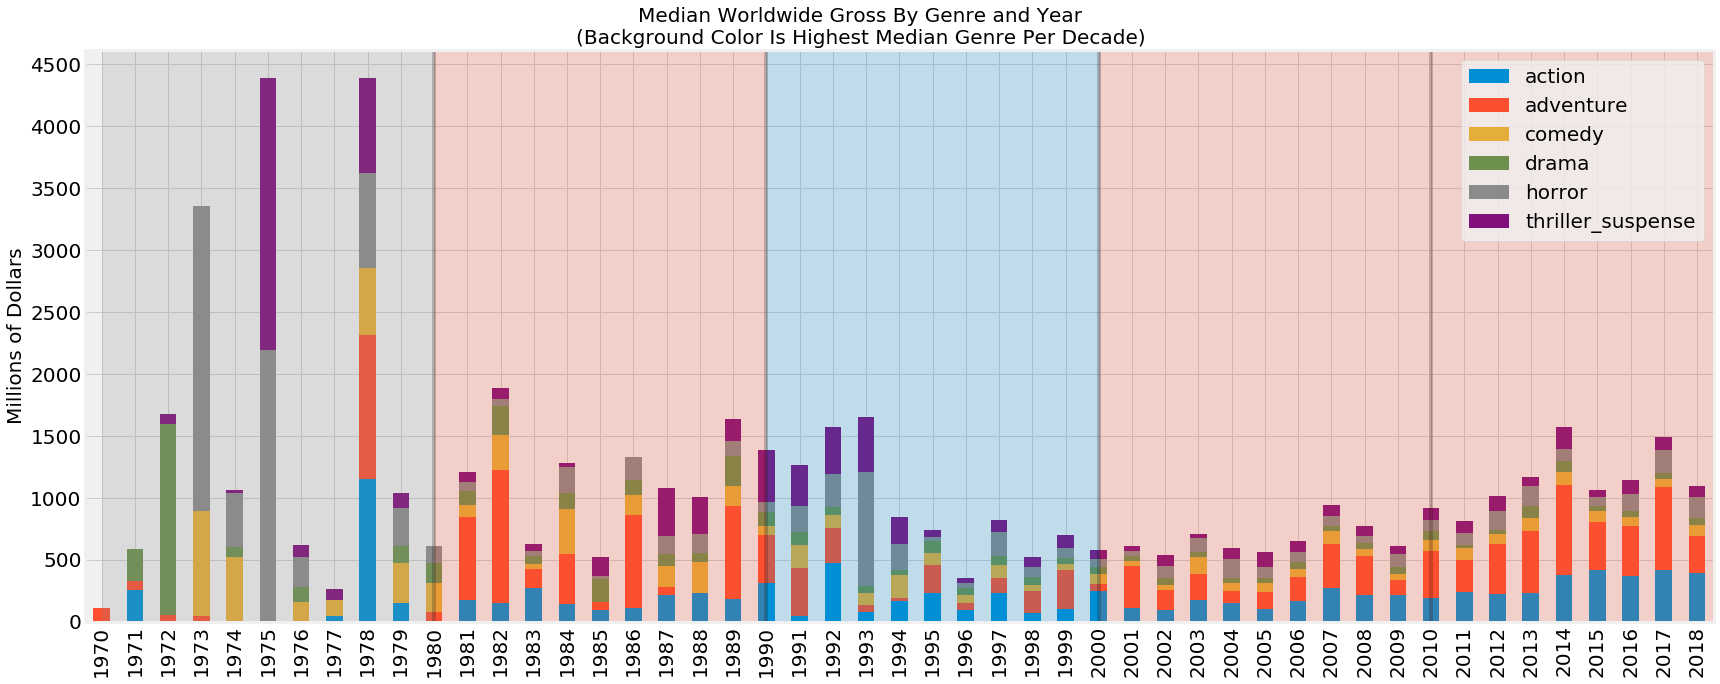

In [206]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Median Worldwide Gross By Genre and Year\n(Background Color Is Highest Median Genre Per Decade)', fontsize=20, y=1.05)

# Determine background colors for each decade
grp = data.groupby('release_decade')[gross_columns].median() / 1000000000
bg_1970 = genres_dict[find_genre_for_background_color(grp, 1970)]['color1']
bg_1980 = genres_dict[find_genre_for_background_color(grp, 1980)]['color1']
bg_1990 = genres_dict[find_genre_for_background_color(grp, 1990)]['color1']
bg_2000 = genres_dict[find_genre_for_background_color(grp, 2000)]['color1']
bg_2010 = genres_dict[find_genre_for_background_color(grp, 2010)]['color1']

grp = data.groupby('release_year')[gross_columns].median() / 1000000
grp.plot(kind='bar', stacked=True, ax=axis)
axis.set_ylabel('Millions of Dollars', fontsize=20)
axis.set_xlabel('')
axis.set_yticks(range(0, 5000, 500))
axis.tick_params(labelsize=20)
axis.legend(genres, fontsize=20)
axis.axvspan(0, 10, color=bg_1970, alpha=0.2)
axis.axvspan(10, 20, color=bg_1980, alpha=0.2)
axis.axvspan(20, 30, color=bg_1990, alpha=0.2)
axis.axvspan(30, 40, color=bg_2000, alpha=0.2)
axis.axvspan(40, 50, color=bg_2010, alpha=0.2)
axis.axvline(10, color='k', alpha=0.2)
axis.axvline(20, color='k', alpha=0.2)
axis.axvline(30, color='k', alpha=0.2)
axis.axvline(40, color='k', alpha=0.2)

plt.tight_layout()

### Quick Takeaways

**Contracting period, then expanding period**
  - We see a overall contraction in mean/median gross by decade from the 1970s to the 2000s.  
  - From the 2000s to the 2010s, Action and Adventure's median grosses have more than doubled.
  - From the 2000s to the 2010s, Comedy, Horror, and Thriller/suspense all have double digit median gross increases.
  - Drama has the smallest increase in the last decade, only 6.4% median gross increase.
  
**Median gross change from 2000s to 2010s ranked from highest to lowest**
  - Adventure:         \\$261 million    -- 165.0%
  - Action:            \\$180.9 million  -- 126.3%
  - Comedy:            \\$22.8 million   -- 35.3%
  - Horror:            \\$21.1 million   -- 23.6%
  - Thriller/Suspense: \\$16.3 million   -- 19.7%
  - Drama:             \\$3.3 million    -- 6.4%
  
**Highest median gross by decade**
  - 1970s: Horror
  - 1980s: Adventure
  - 1990s: Action
  - 2000s: Adventure
  - 2010s: Adventure

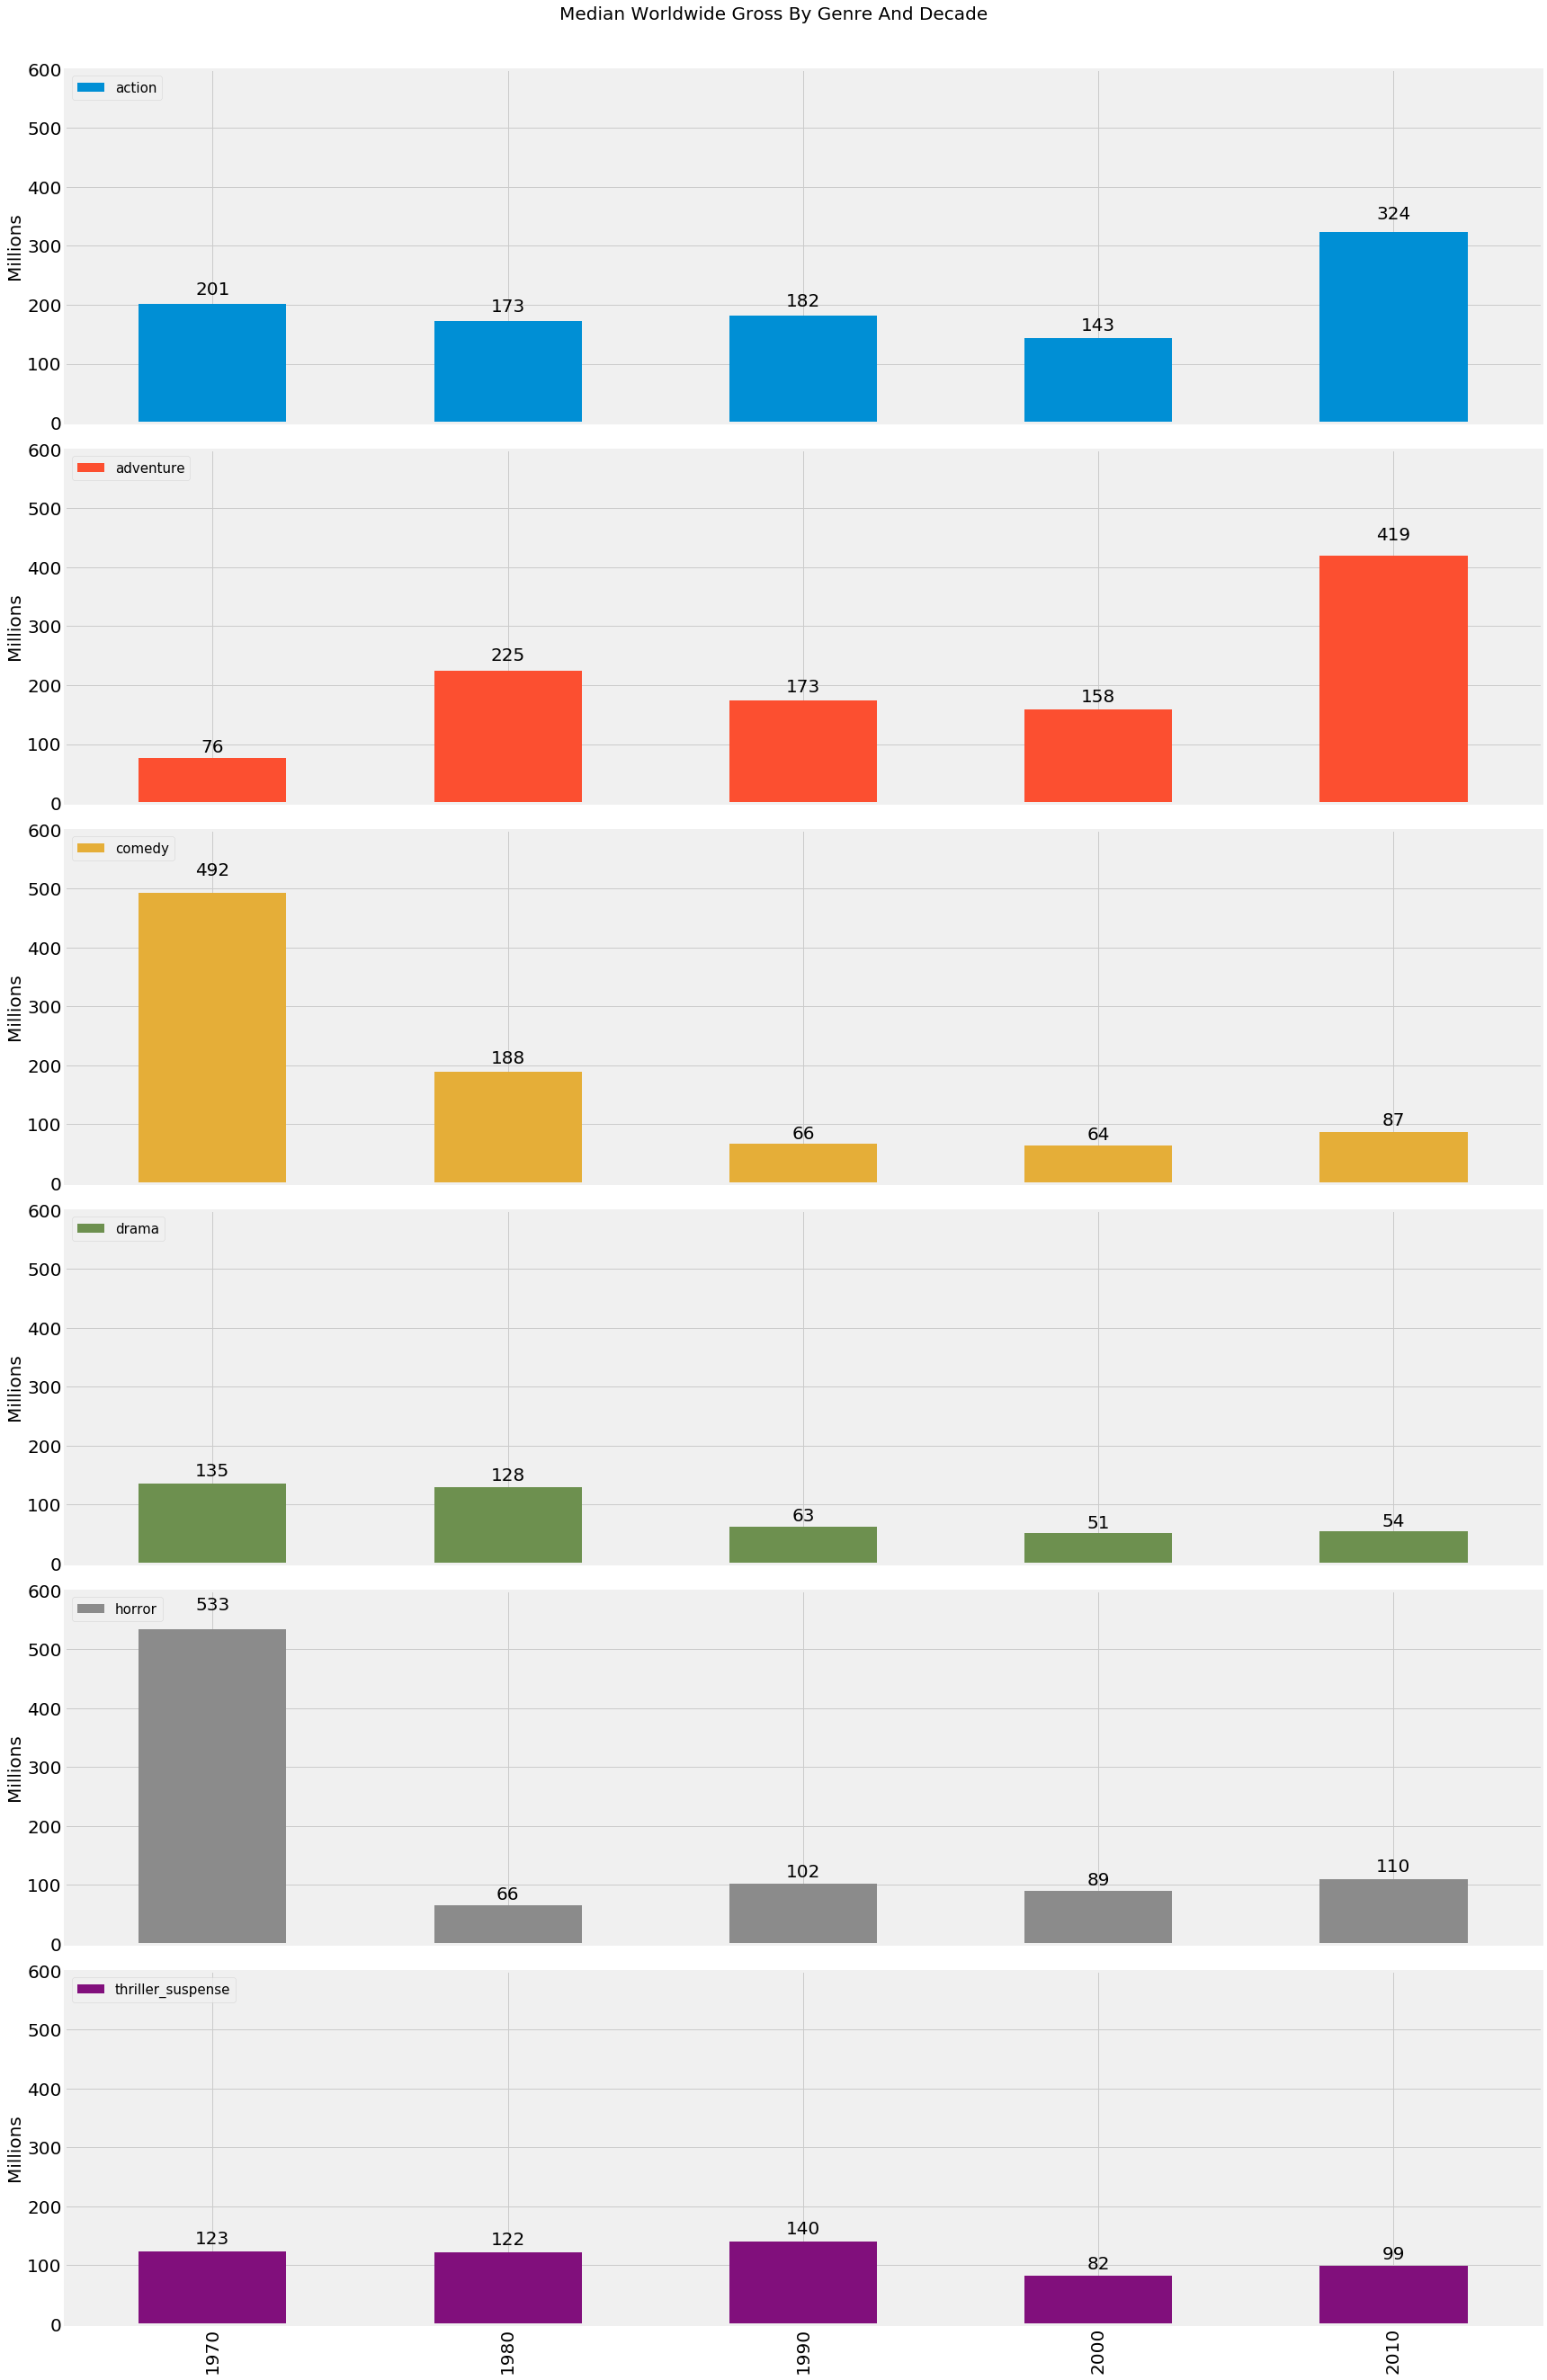

In [214]:
figure, axes = plt.subplots(nrows=6, ncols=1, figsize=(24,36), sharex=True, sharey=True)
figure.suptitle('Median Worldwide Gross By Genre And Decade', fontsize=20, y=1.02)

for genre, color, axis in zip(genres, colors, axes.flat):
        grp = (data[data[genre]].groupby('release_decade').median() / 1000000)['worldwide_adj'].copy()
    
        # If the series is missing a decade, add it as an index and set the value to zero
        for decade in range(1970, 2020, 10):
            if decade not in grp.index:
                grp.loc[decade] = 0

        # Sort the series by its index to have the decades in chronological order                
        grp.sort_index(ascending=True, inplace=True)
        
        # Set up y-axis    
        grp.plot(kind='bar', xticks=range(1970, 2020, 10), linewidth=3, ax=axis, color=color)
        axis.set_ylabel('Millions', fontsize=20)
        axis.set_ylim(0,600)
        axis.set_xlabel('')
        axis.tick_params(labelsize=20)
        axis.legend([genre], loc=2, fontsize=15)
        
        autolabel(axis)
                
plt.tight_layout()

### Quick Takeaways:

**1990s to 2000s**
  - Every genre saw a reduction in median gross from the 1990s to 2000s.
  - This reduction coincided with a huge increase in the number of movies released per genre
  
**2000s to 2010s**
  - Every genre has seen an increase in median gross from the 2000s to 2010s
  - Except for Action, this has coincided with a decrease in the number of movies per genre
  - Action and Adventure's median grosses have more than doubled from the 2000s to 2010s!

**Horror**
  - Horror has the third highest median gross with \\$110 million

## Budgets

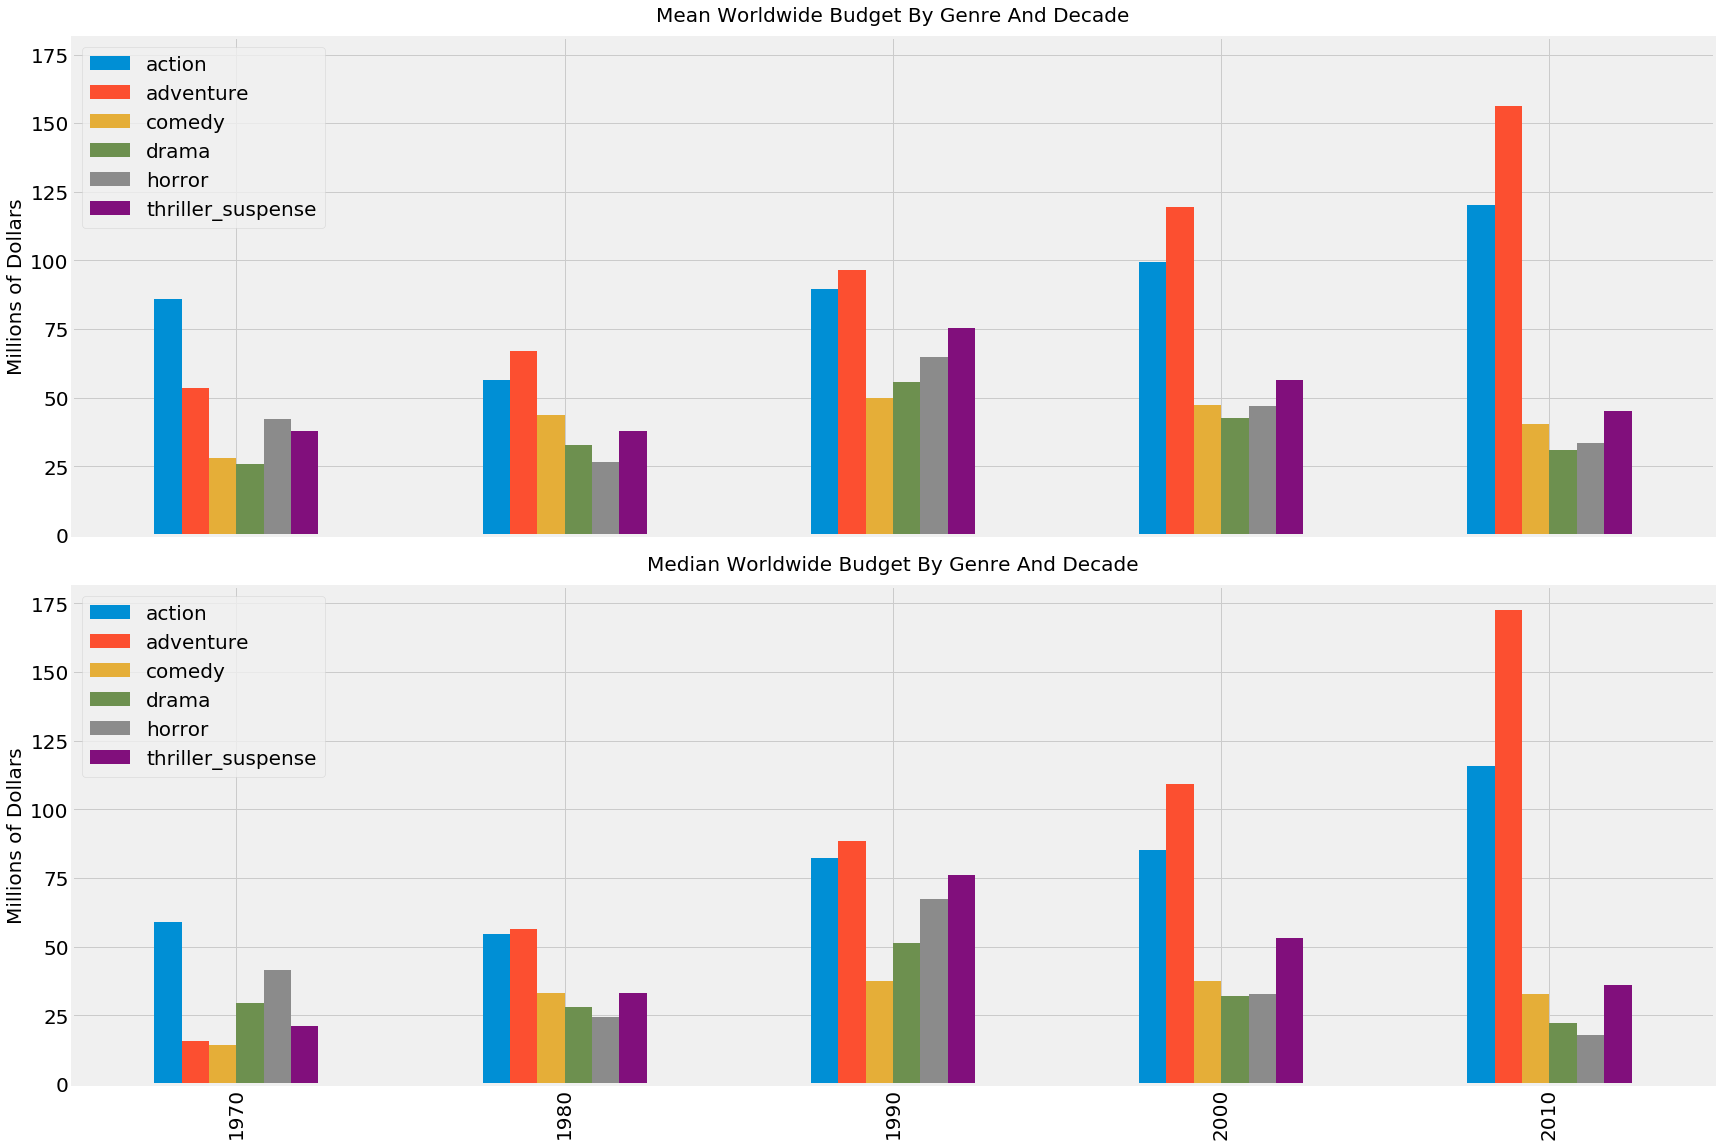

In [56]:
figure, (axis1, axis2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(24, 16))

grp = data.groupby('release_decade')[budget_columns].mean() / 1000000
grp.plot(kind='bar', ax=axis1)
axis1.set_ylabel('Millions of Dollars', fontsize=20)
axis1.set_xlabel('')
axis1.tick_params(labelsize=20)
axis1.legend(genres, fontsize=20)
axis1.set_title('Mean Worldwide Budget By Genre And Decade', fontsize=20, y=1.02)

grp = data.groupby('release_decade')[budget_columns].median() / 1000000
grp.plot(kind='bar', ax=axis2)
axis2.set_ylabel('Millions of Dollars', fontsize=20)
axis2.set_xlabel('')
axis2.tick_params(labelsize=20)
axis2.legend(genres, fontsize=20)
axis2.set_title('Median Worldwide Budget By Genre And Decade', fontsize=20, y=1.02)

plt.tight_layout()

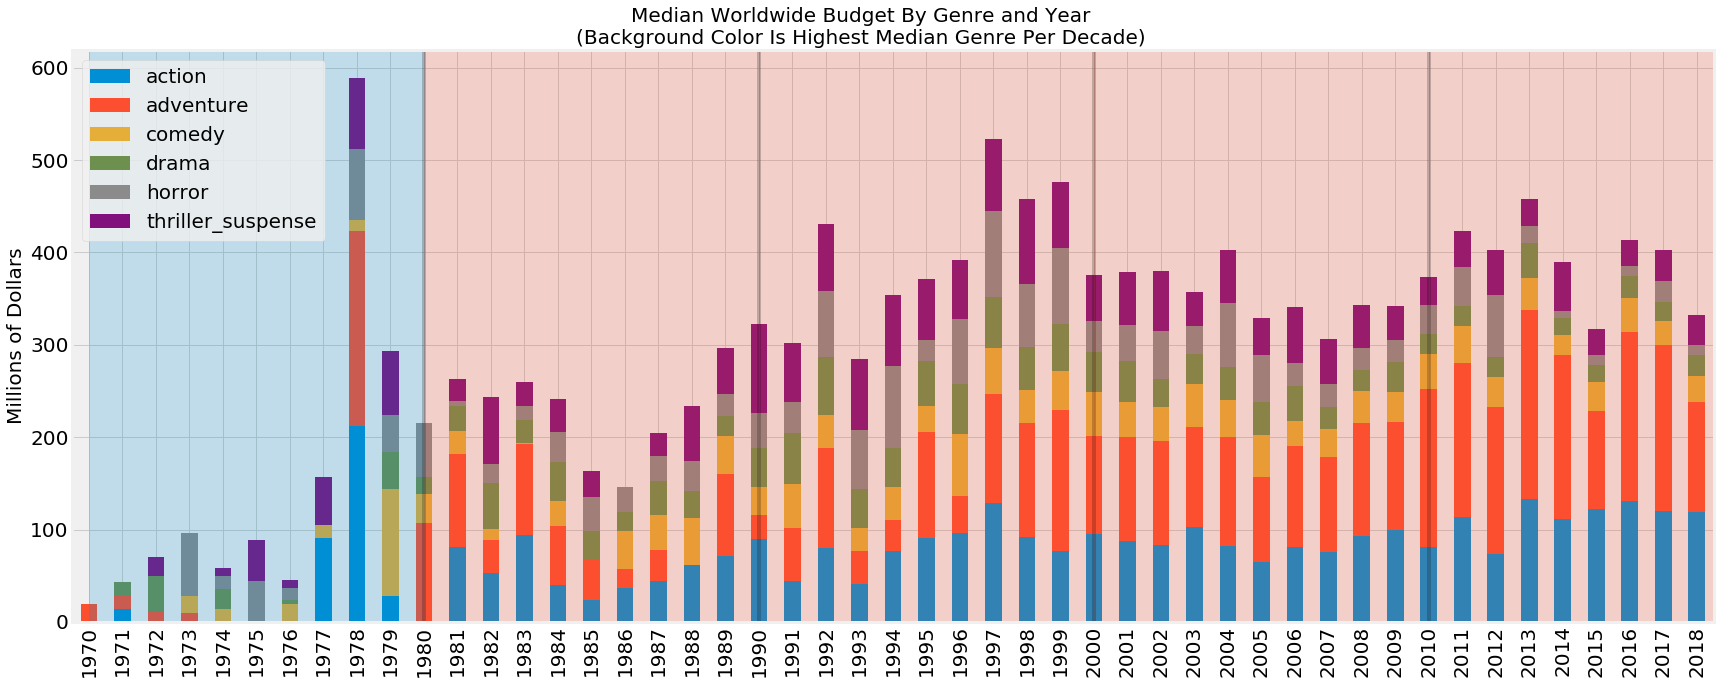

In [207]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Median Worldwide Budget By Genre and Year\n(Background Color Is Highest Median Genre Per Decade)', fontsize=20, y=1.05)

# Determine background colors for each decade
grp = data.groupby('release_decade')[budget_columns].median() / 1000000000
bg_1970 = genres_dict[find_genre_for_background_color(grp, 1970)]['color1']
bg_1980 = genres_dict[find_genre_for_background_color(grp, 1980)]['color1']
bg_1990 = genres_dict[find_genre_for_background_color(grp, 1990)]['color1']
bg_2000 = genres_dict[find_genre_for_background_color(grp, 2000)]['color1']
bg_2010 = genres_dict[find_genre_for_background_color(grp, 2010)]['color1']

grp = data.groupby('release_year')[budget_columns].median() / 1000000
grp.plot(kind='bar', stacked=True, ax=axis)
axis.set_ylabel('Millions of Dollars', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
axis.legend(genres, fontsize=20)
axis.axvspan(0, 10, color=bg_1970, alpha=0.2)
axis.axvspan(10, 20, color=bg_1980, alpha=0.2)
axis.axvspan(20, 30, color=bg_1990, alpha=0.2)
axis.axvspan(30, 40, color=bg_2000, alpha=0.2)
axis.axvspan(40, 50, color=bg_2010, alpha=0.2)
axis.axvline(10, color='k', alpha=0.2)
axis.axvline(20, color='k', alpha=0.2)
axis.axvline(30, color='k', alpha=0.2)
axis.axvline(40, color='k', alpha=0.2)

plt.tight_layout()

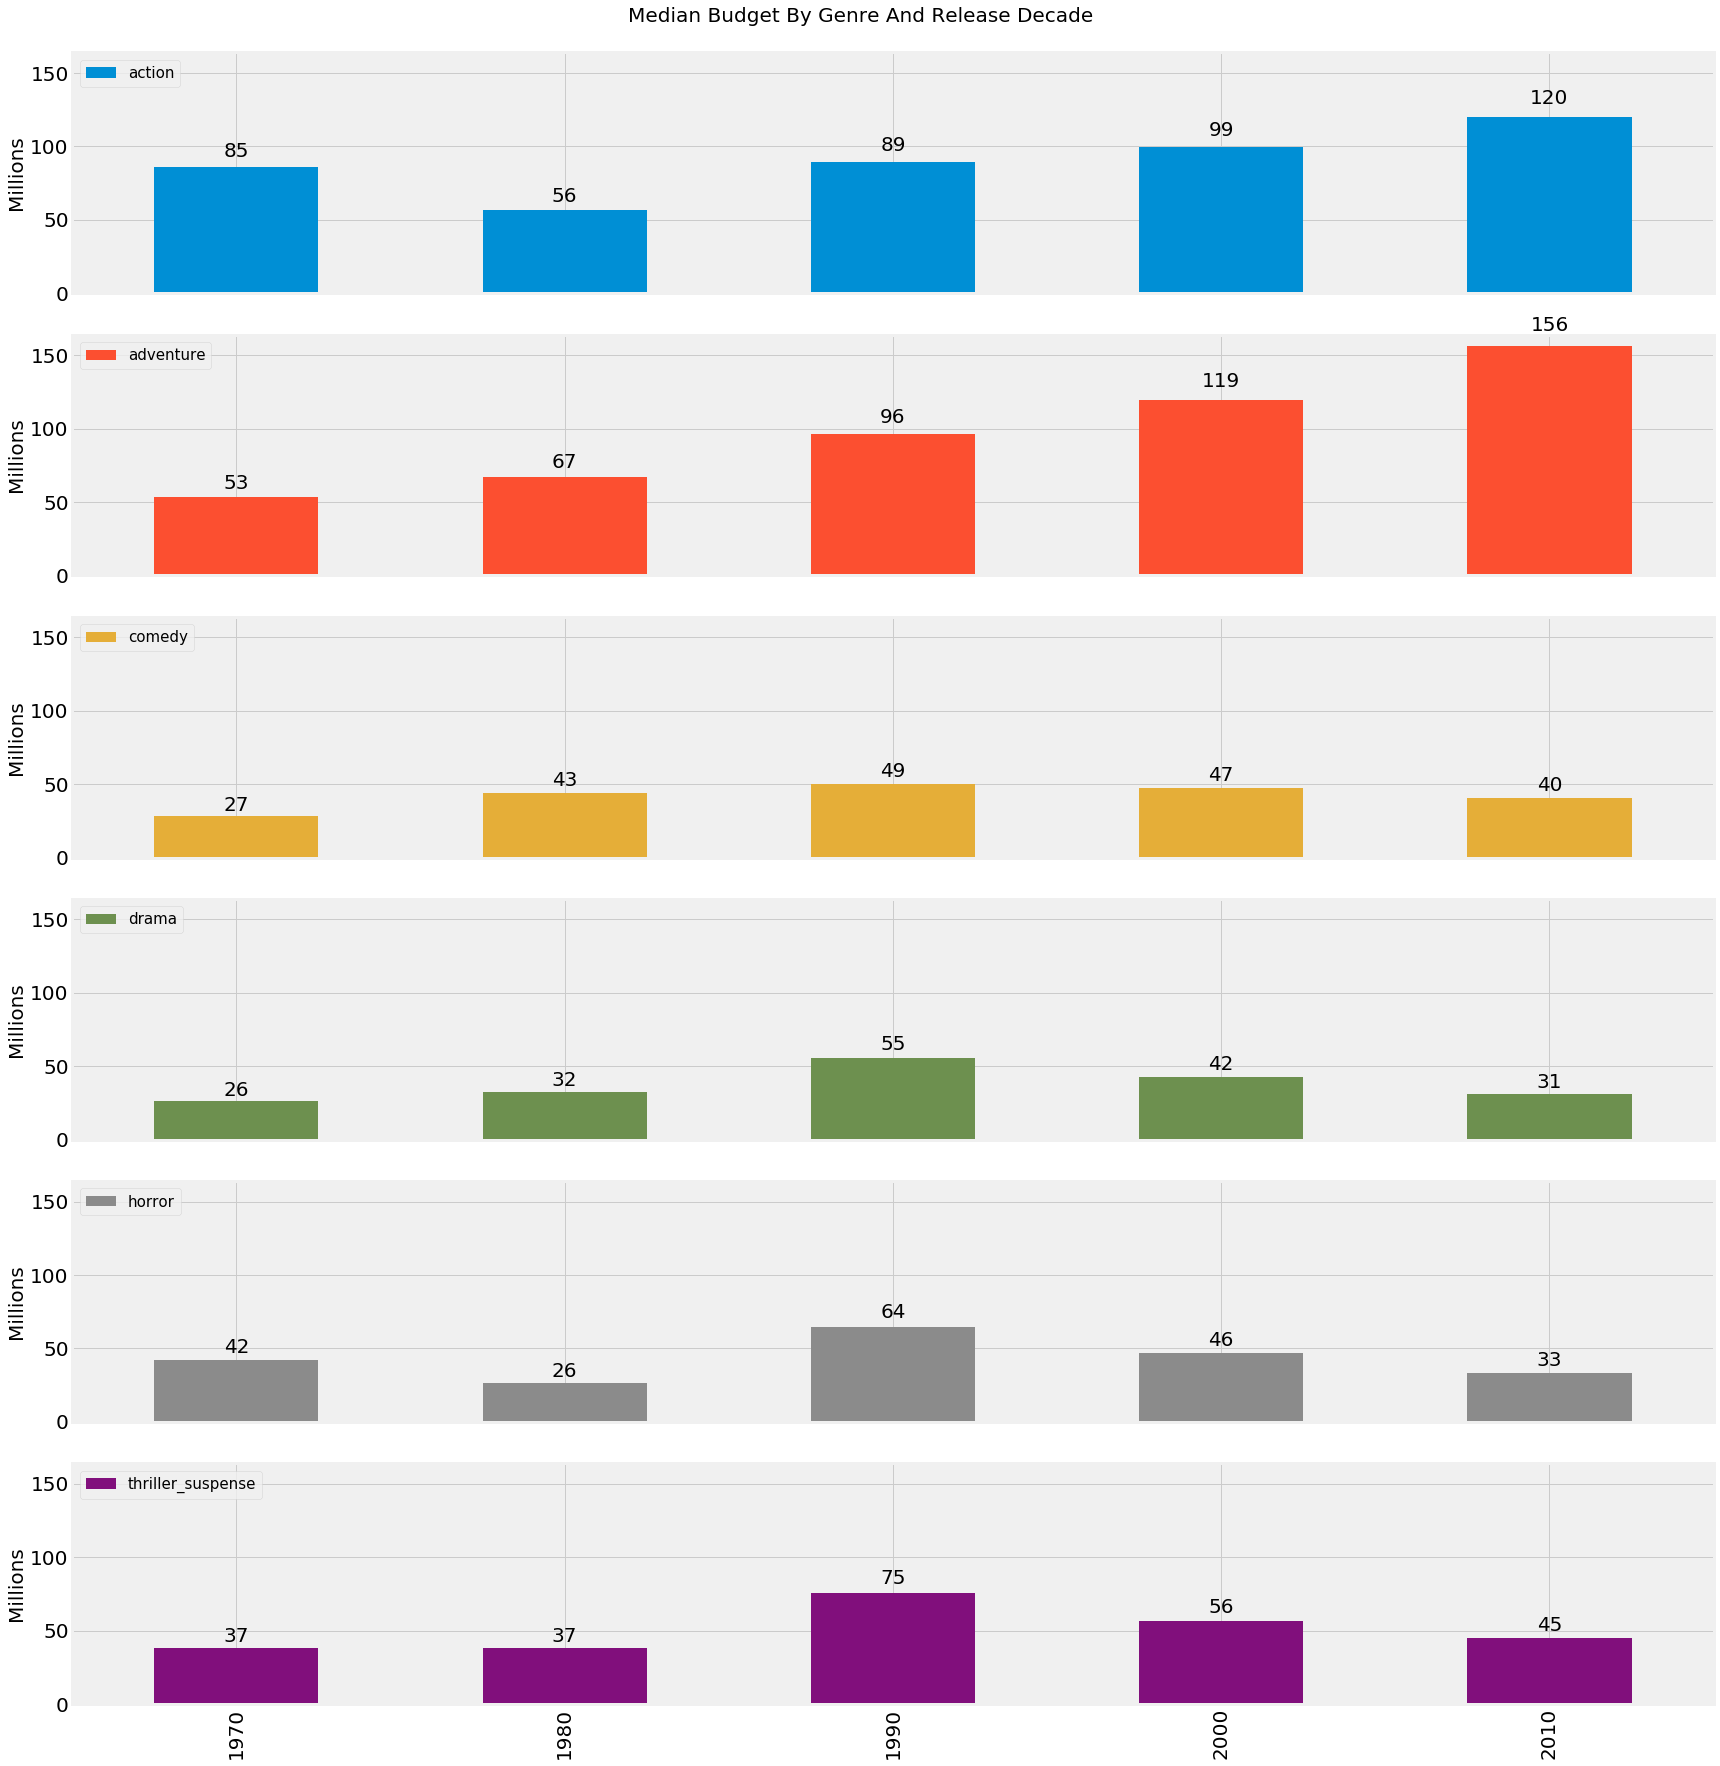

In [58]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 24))
figure.suptitle('Median Budget By Genre And Release Decade', fontsize=20, y=1.02)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres, axes_list, colors):    
    # Create a series with decades as indexes and median budget as values
    grp = (data[data[genre]].groupby('release_decade').mean() / 1000000)['budget_adj'].copy()
    
    # If the series is missing a decade, add it as an index and set the value to zero
    for decade in range(1970, 2020, 10):
        if decade not in grp.index:
            grp.loc[decade] = 0
    
    # Sort the series by its index to have the decades in chronological order                
    grp.sort_index(ascending=True, inplace=True)
        
    grp.plot(kind='bar', xticks=range(1970, 2020, 10), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Millions', fontsize=20)
    axis.tick_params(labelsize=20)
    axis.set_xlabel('')
    axis.legend([genre], loc=2, fontsize=15)
    autolabel(axis)

plt.tight_layout() 

### Quick Takeaways 

**Mean and median pretty much the same**
  - There's not much difference between the mean and median in terms of budgets
  
**Since the 1990s**
  - Budgets have decreased since the 1990s for all genres except Action and Adventure, whose budgets have increased substantially
  
**Action and Adventure**
  - Action has the highest median budget in the 1970s. Since then, Adventure has had the highest.

## Profits

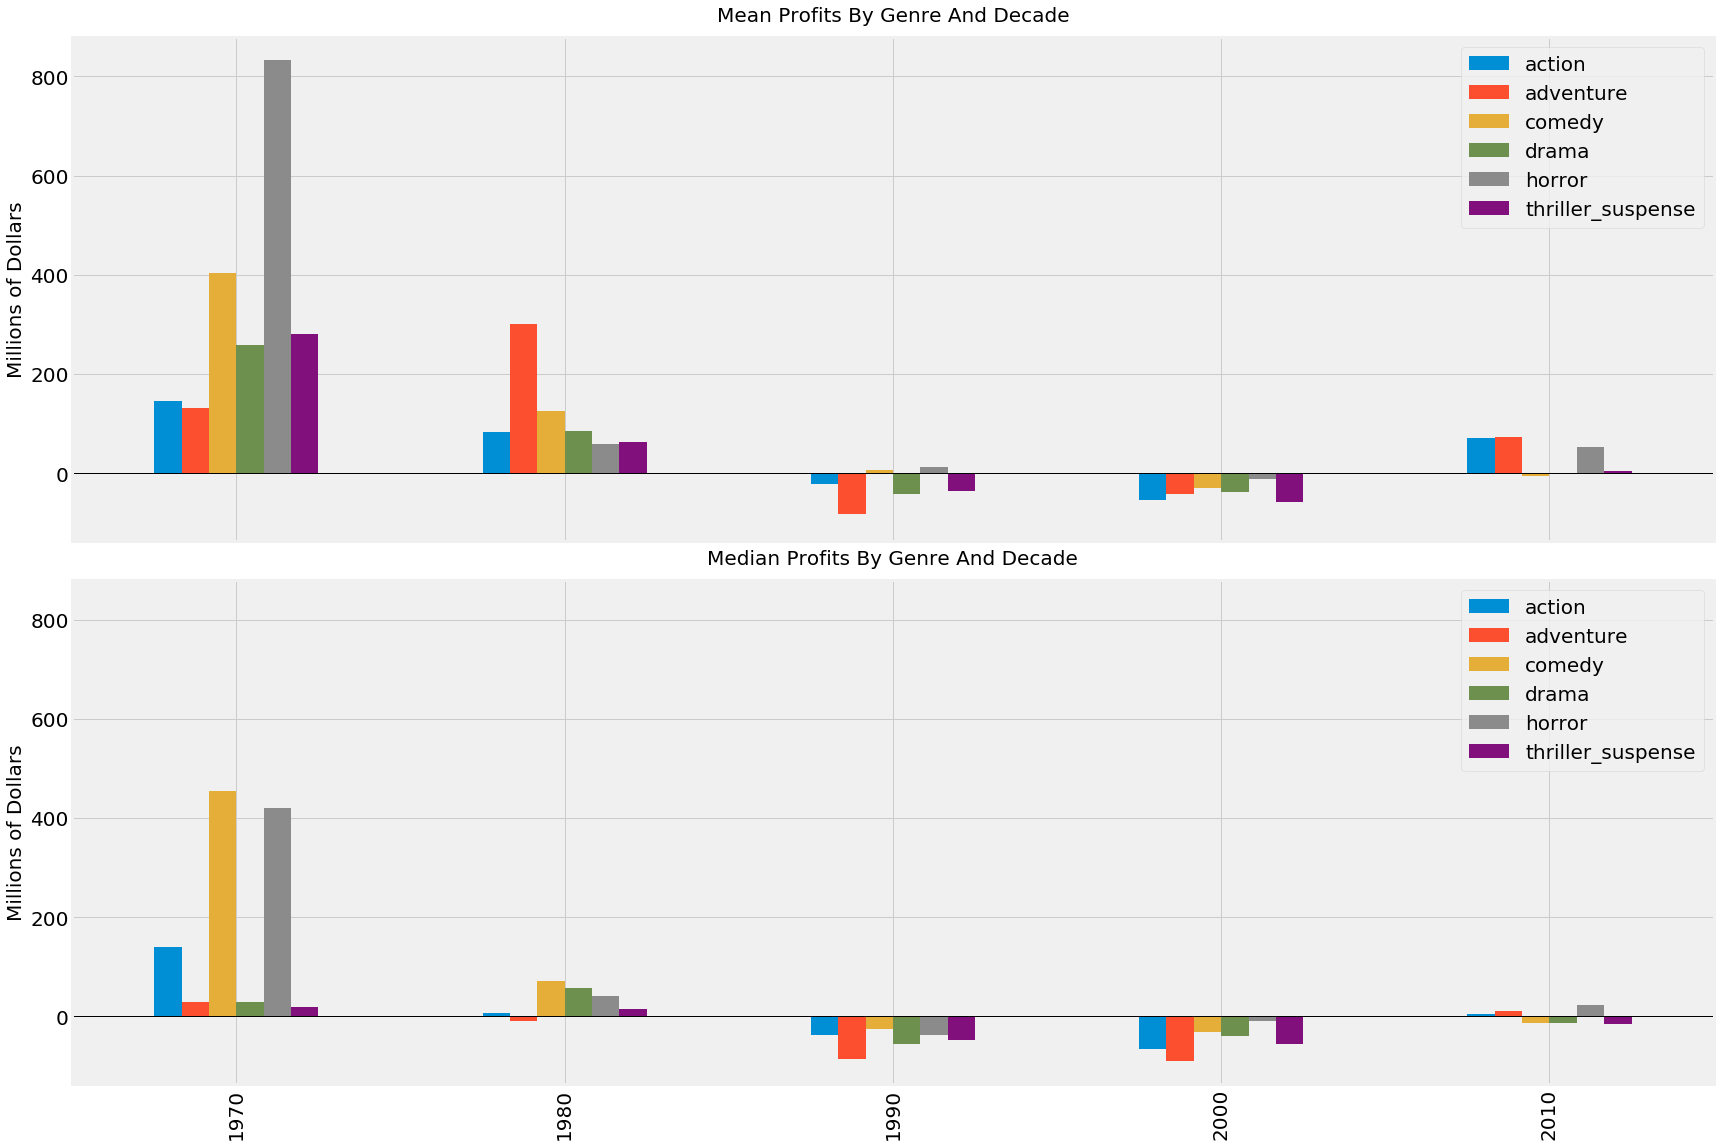

In [59]:
figure, (axis1, axis2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(24, 16))

grp = data.groupby('release_decade')[profit_columns].mean() / 1000000
grp.plot(kind='bar', ax=axis1)
axis1.set_ylabel('Millions of Dollars', fontsize=20)
axis1.set_xlabel('')
axis1.tick_params(labelsize=20)
axis1.legend(genres, fontsize=20)
axis1.set_title('Mean Profits By Genre And Decade', fontsize=20, y=1.02)
axis1.axhline(0, color='k', linewidth=1)

grp = data.groupby('release_decade')[profit_columns].median() / 1000000
grp.plot(kind='bar', ax=axis2)
axis2.set_ylabel('Millions of Dollars', fontsize=20)
axis2.set_xlabel('')
axis2.tick_params(labelsize=20)
axis2.legend(genres, fontsize=20)
axis2.set_title('Median Profits By Genre And Decade', fontsize=20, y=1.02)
axis2.axhline(0, color='k', linewidth=1)

plt.tight_layout()

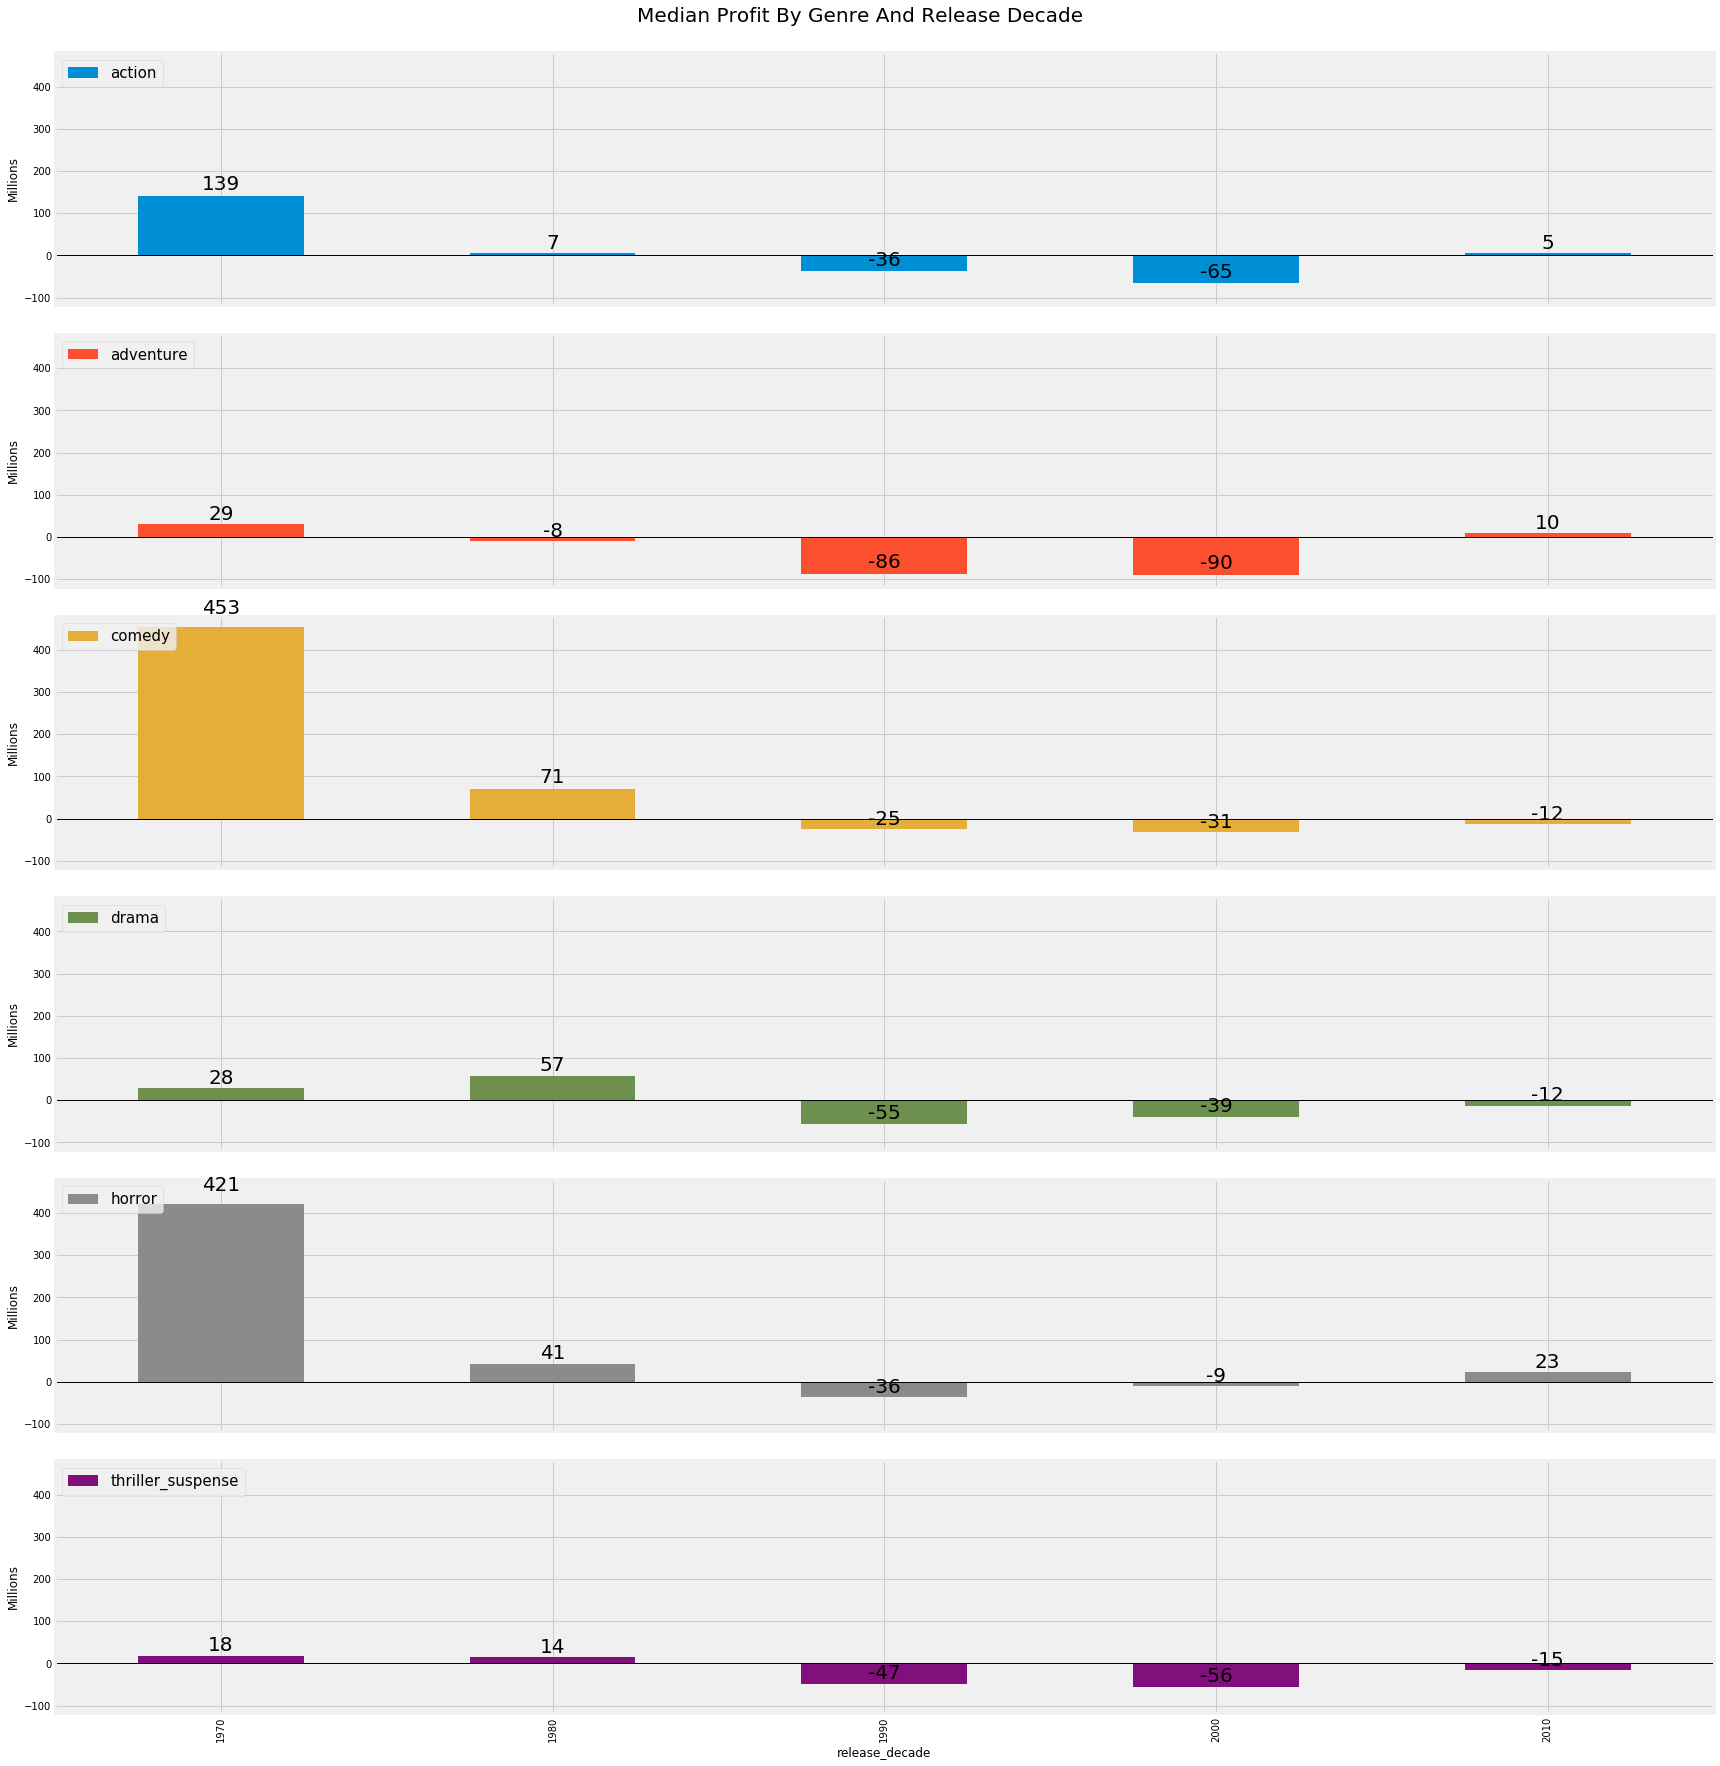

In [60]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 24))
figure.suptitle('Median Profit By Genre And Release Decade', fontsize=20, y=1.02)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres, axes_list, colors):    
    # Create a series with decades as indexes and median budget as values
    grp = (data[data[genre]].groupby('release_decade').median() / 1000000)['profit'].copy()
    
    # If the series is missing a decade, add it as an index and set the value to zero
    for decade in range(1970, 2020, 10):
        if decade not in grp.index:
            grp.loc[decade] = 0
    
    # Sort the series by its index to have the decades in chronological order                
    grp.sort_index(ascending=True, inplace=True)
        
    grp.plot(kind='bar', xticks=range(1970, 2020, 10), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Millions', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    axis.axhline(0, color='k', linewidth=1)
    autolabel(axis)

plt.tight_layout() 

### Quick Takeaways

**The average movie is not a winner**
  - From the 1990s onwards, most genres have had a negative median profit. In other words, they are net losers of money.
  - In the 1990s, no genre had a positive median profit.
  - In the 2000s, no genre had a positive median profit.
  - In the 2010s, Horror has the best median profit of \\$23 million, followed by Adventure at \\$10 million and Action at \\$5 million.

## Breakeven Percentage

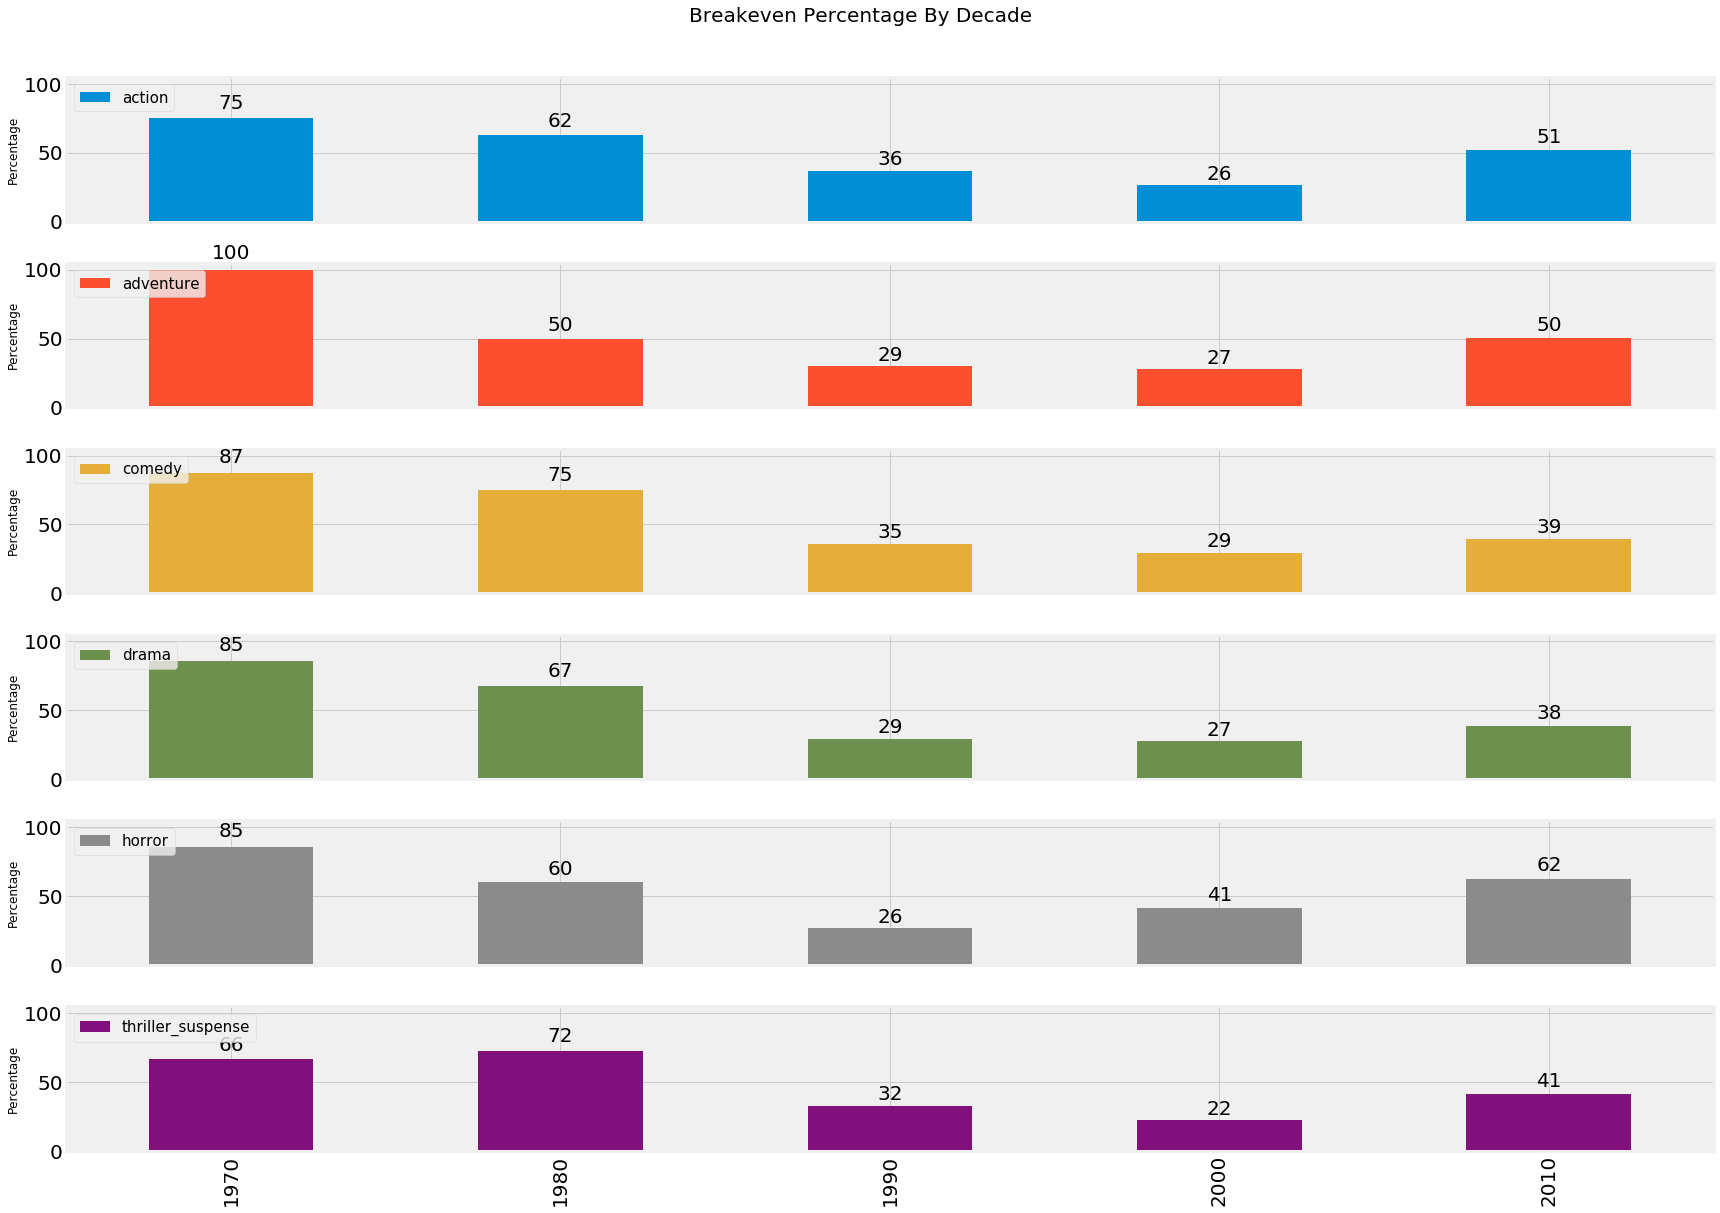

In [61]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Breakeven Percentage By Decade', fontsize=20, y=1.05)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres, axes_list, colors):
    # Create two series with decades as indexes and count and sum as values
    grp_count = data[data[genre]].groupby('release_decade')['worldwide_breakeven'].count().copy()
    grp_sum = data[data[genre]].groupby('release_decade')['worldwide_breakeven'].sum().copy()

    # If the series is missing a decade, add it as an index
    # Then set the count to 1 and the sum to 0
    # This avoids division by zero problems when calculating the percentages
    for decade in range(1970, 2020, 10):
        if decade not in grp_count.index:
            grp_count.loc[decade] = 0
            grp_sum.loc[decade] = 0

    # Sort the series by their index to have the decades in chronological order                
    grp_count.sort_index(ascending=True, inplace=True)
    grp_sum.sort_index(ascending=True, inplace=True)
    
    (grp_sum / grp_count * 100).plot(kind='bar', xticks=range(1970, 2020, 10), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Percentage', fontsize=12)
    axis.tick_params(labelsize=20)
    axis.legend([genre], loc=2, fontsize=15)
    axis.set_xlabel('')
    
    # Put the count of how many movies breakeven above each bar
    autolabel(axis)
    
plt.tight_layout() 

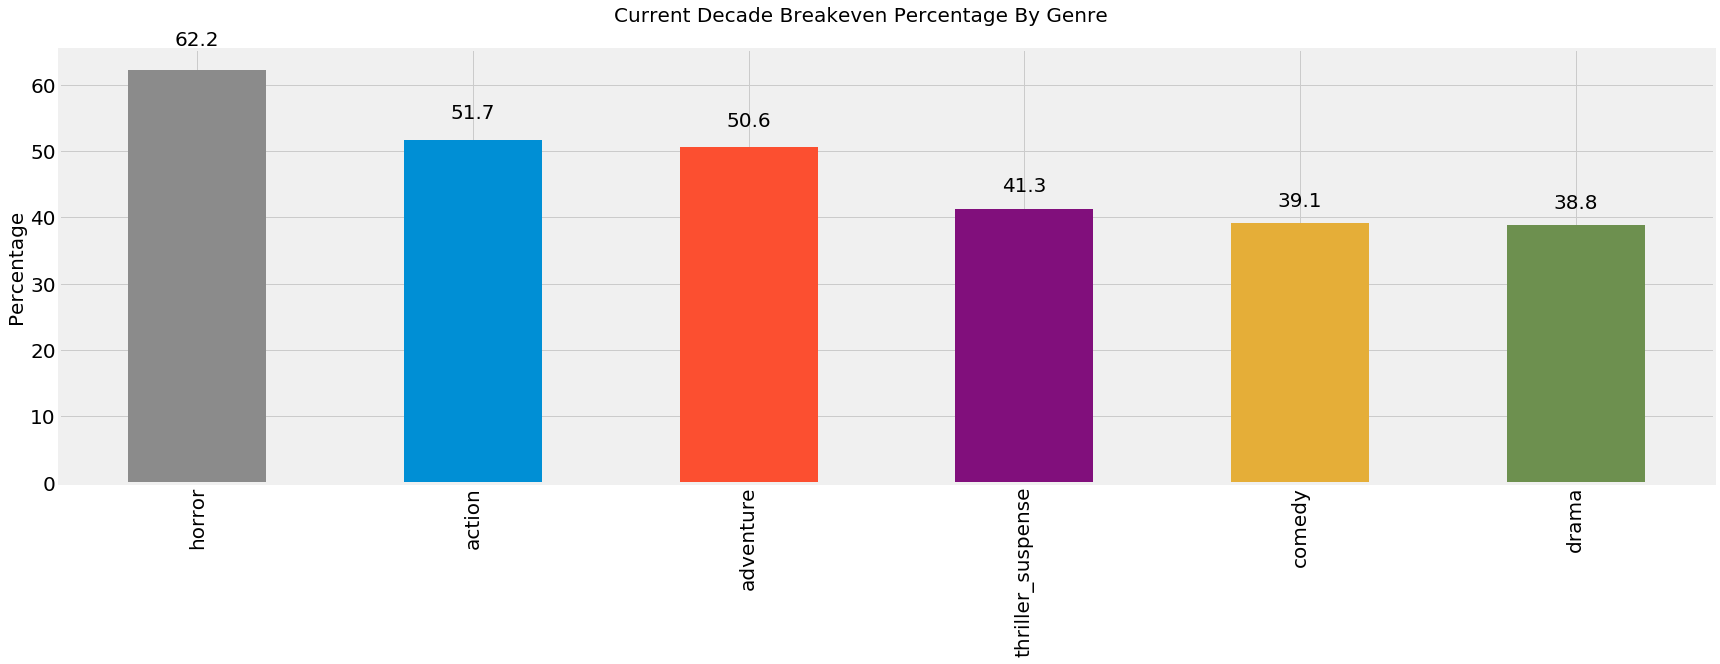

In [62]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Current Decade Breakeven Percentage By Genre', fontsize=20, y=1.02)

summary.sort_values('current_decade_breakeven_percentage', ascending=False, inplace=True)

summary.plot(y='current_decade_breakeven_percentage', kind='bar', ax=axis, color=['#8B8B8B', '#008FD5', '#FC4F30', '#810F7C', '#E5AE38', '#6D904F'], legend=False)
axis.set_ylabel('Percentage', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
autolabel(axis, num_decimals=1)

plt.tight_layout()

### Quick Takeaways

**1970s to 2000s**
  - Overall, there was a big decrease in a a movie's probability of breaking even
  - The exceptions are Thriller/Suspense's bump in the 1980s and Horror's bump in the 2000s
  
**2000s to 2010s**
  - All genres have seen a boost to their probability of breaking even in the last decade

**Safest current genres**
  - Horror is by far the safest worldwide release genre with a 62% chance of at least breaking even
  - Action and Adventure are the next safest from a breakeven perspective at around 50% each
  - Comedy and Drama have the worst odds of breaking even
  
**Movies are risky today**
  - From a breakeven standpoint, movies are safer today than they were in the 1990s or 2000s
  - However, the best chance a movie has to breakeven in aggregate is still only 62% for Horror
  - Movies are still a big risk

## Breaking Down By Subgenres

The movie business is so variable that looking at trends within subgenres probably doesn't yield much actionable insight.

But we shall look at mean and median profitability of subgenres by decade just in case.

In [227]:
# Function to plot mean and median profitability by subgenre by decade
def subgenre_profitability_by_decade(genre, colors):
    subgenres = data[data[genre.lower()]].groupby('genres_mojo').count().index
    num_subgenres = len(subgenres)
    
    figure, axes = plt.subplots(nrows=num_subgenres, ncols=1, figsize=(24, 50), sharex=True)
    figure.suptitle('Mean and Median Profit By {} Subgenre And Decade'.format(genre.title()), fontsize=20, y=1.02)

    for genre, axis in zip(subgenres, axes.flat):
            grp = (data[data['genres_mojo'].str.contains(genre)].groupby('release_decade').agg(['mean', 'median']) / 1000000)['profit'].copy()

            # If the series is missing a decade, add it as an index and set the value to zero
            for decade in range(1970, 2020, 10):
                if decade not in grp.index:
                    grp.loc[decade] = 0

            # Sort the series by its index to have the decades in chronological order                
            grp.sort_index(ascending=True, inplace=True)

            # Set up y-axis    
            grp.plot(kind='bar', xticks=range(1970, 2020, 10), color=colors, linewidth=3, ax=axis)

            axis.set_ylabel('Millions', fontsize=20)
            axis.set_title(genre, fontsize=20)
            axis.legend(['Mean', 'Median'], loc='lower left', fontsize=15)
            axis.set_xlabel('')
            axis.tick_params(labelsize=20)
            axis.axhline(0, color='k', linewidth=1)

            autolabel(axis)

    plt.tight_layout()

### Action Subgenres By Decade

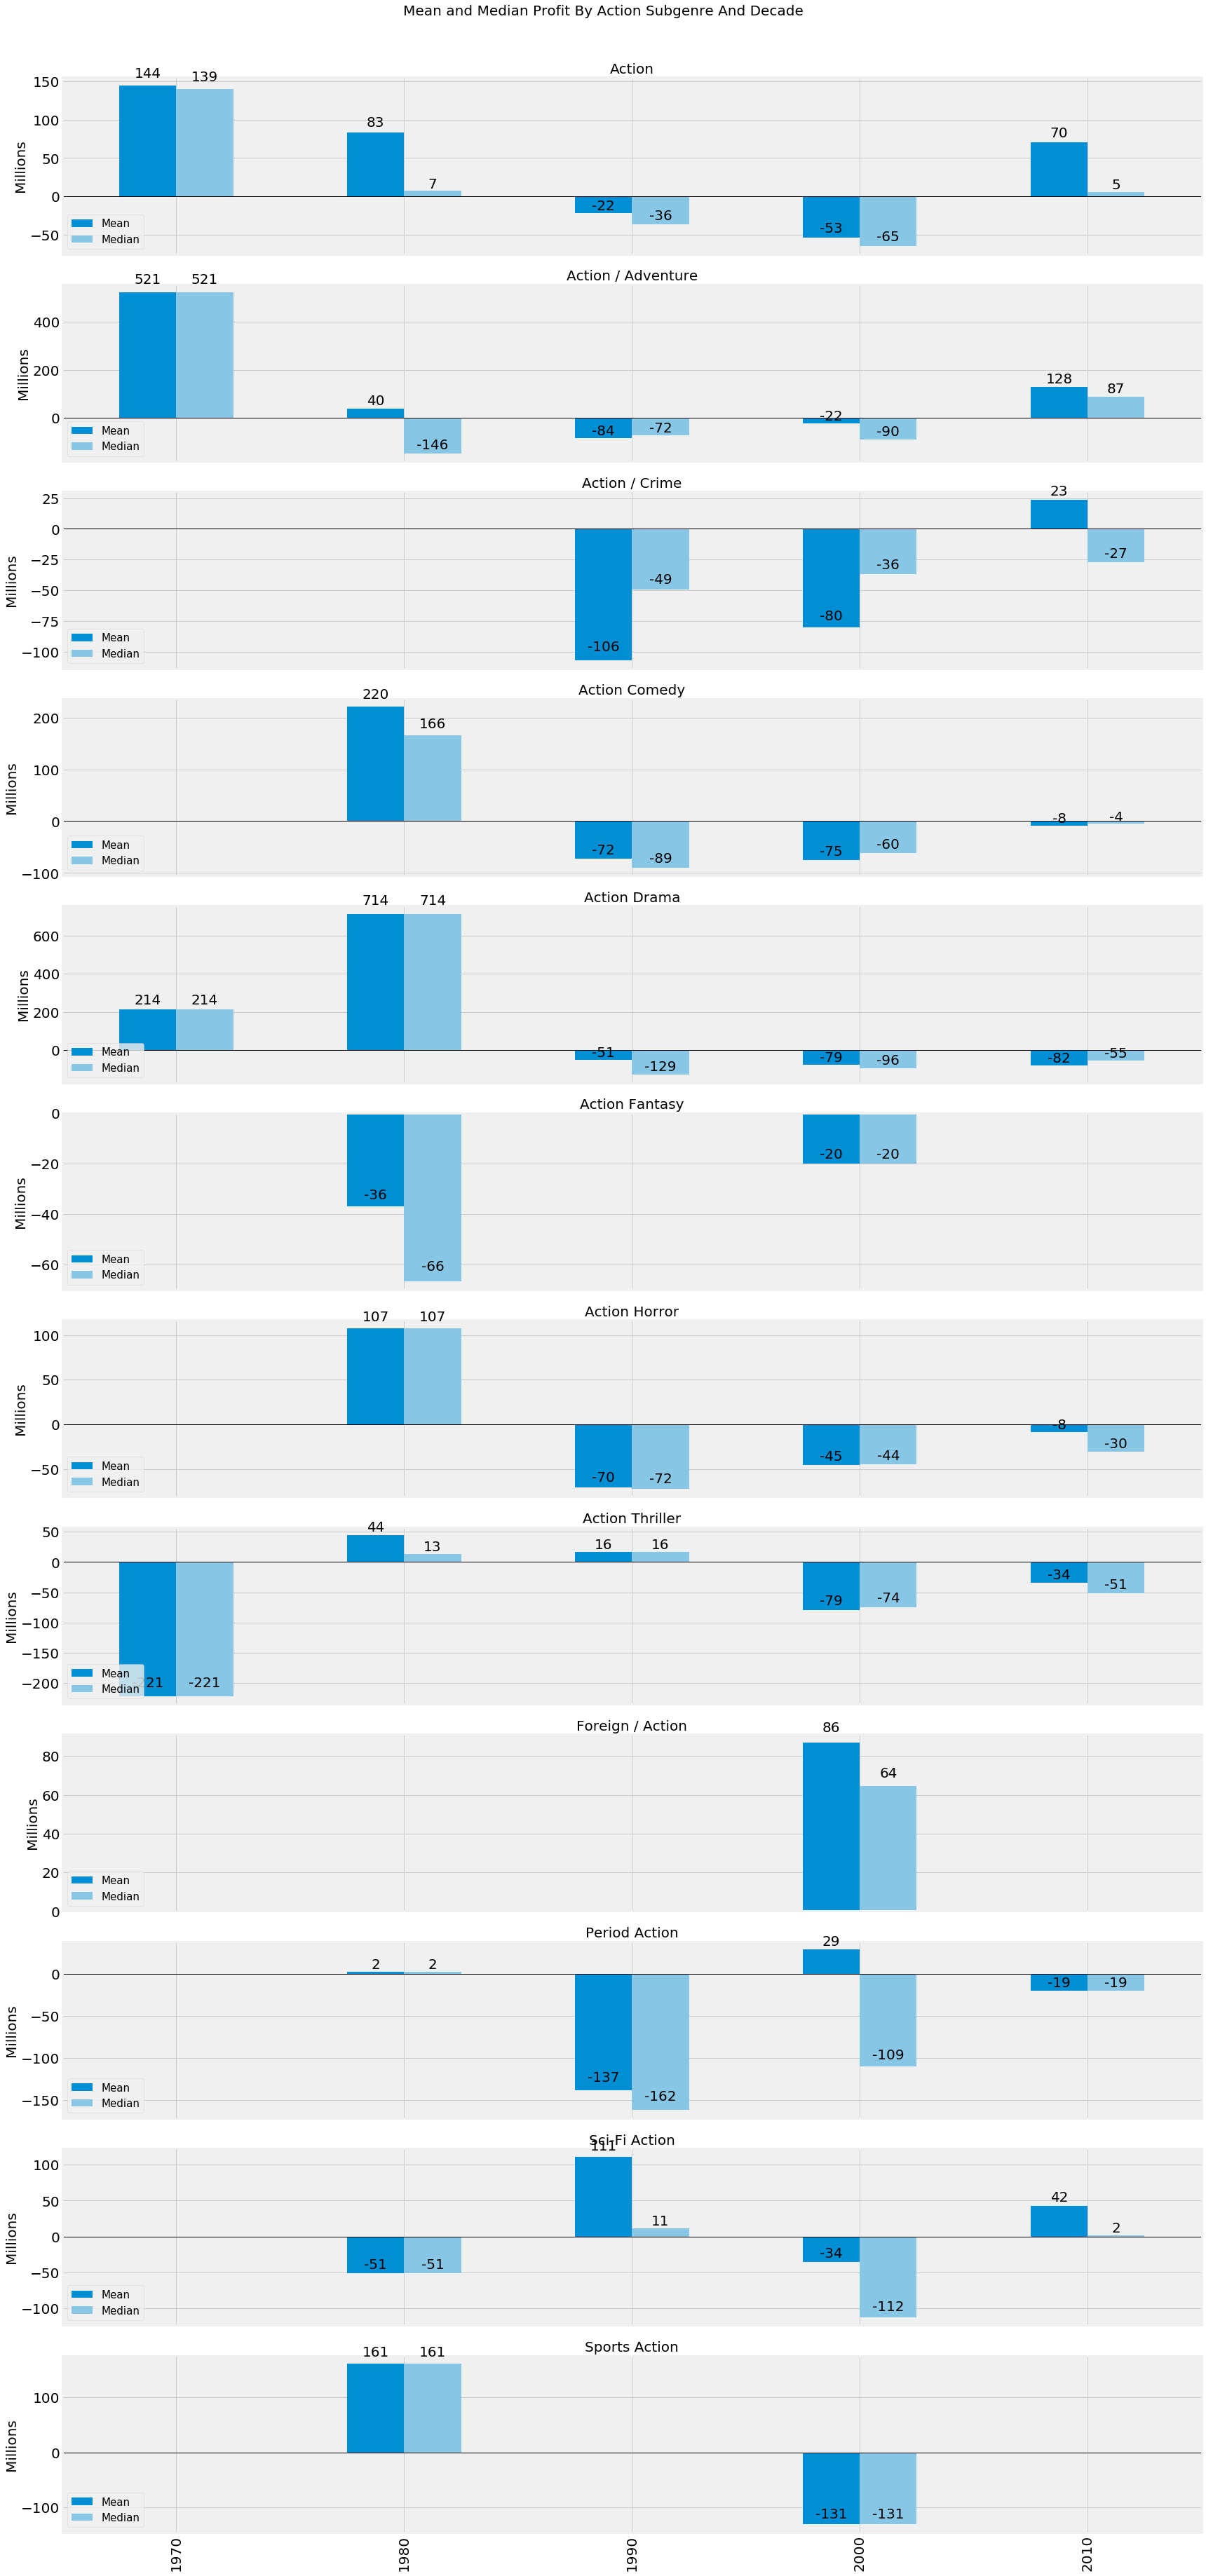

In [228]:
subgenre_profitability_by_decade('action', [genres_dict['action']['color1'], genres_dict['action']['color2']])

#### Quick Takeaways

There's no clear best subgenre. There's too much variance by decade. In the current decade, the only subgenres with positive median profits are Action/Adventure, Action, and Sci-Fi Action.

### Adventure Subgenres By Decade

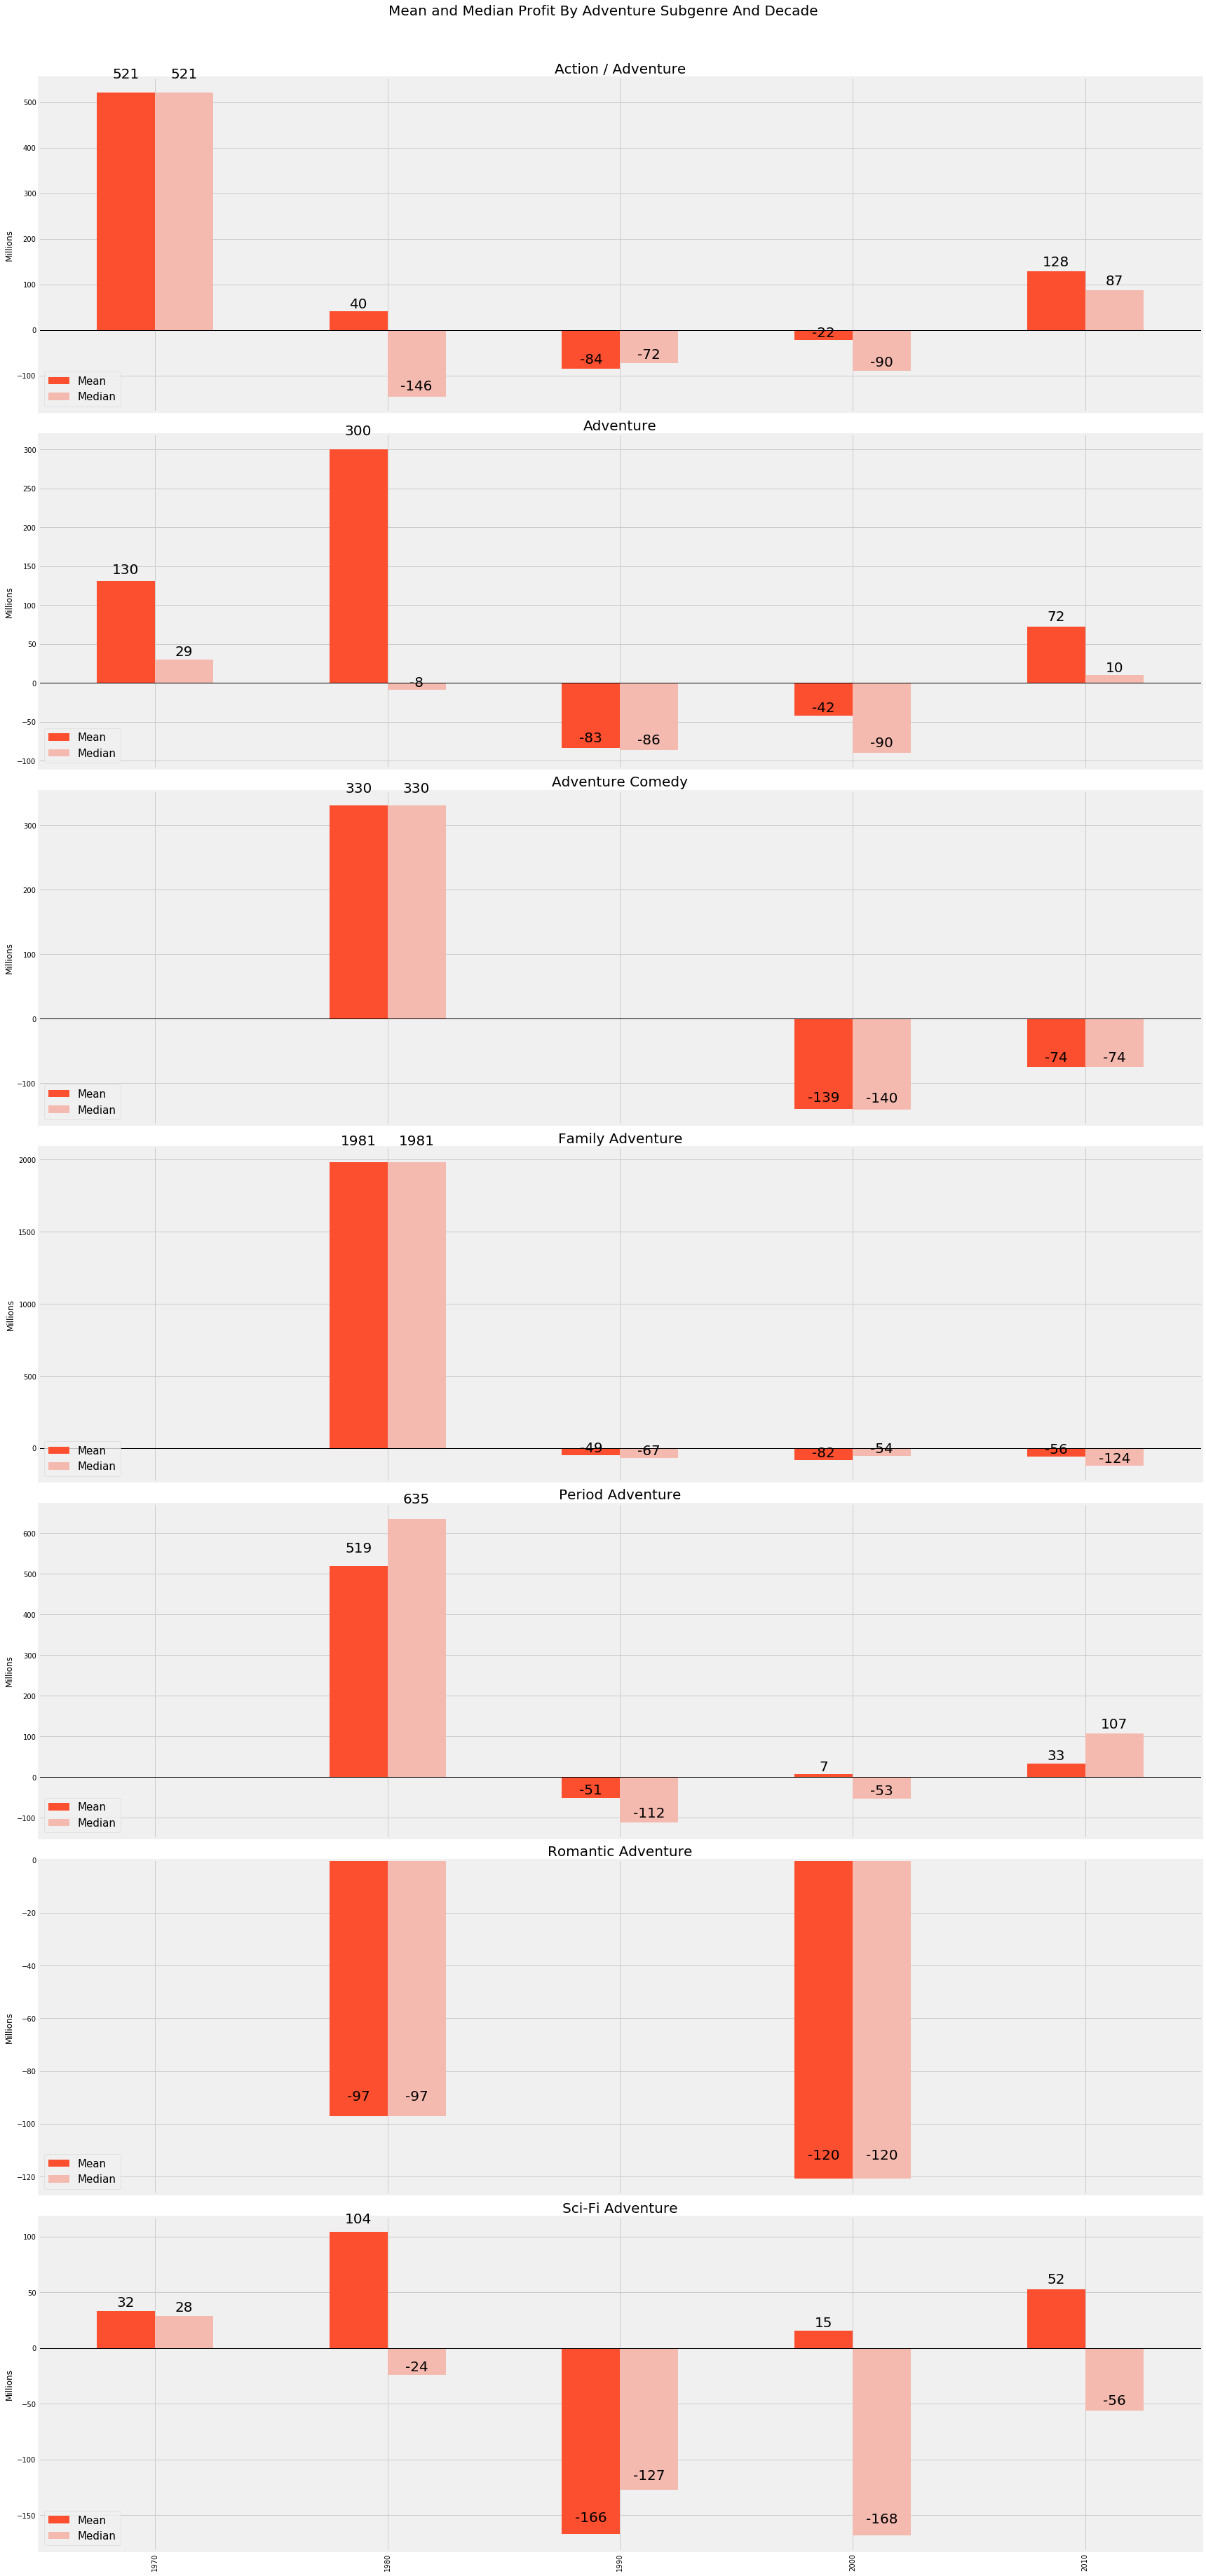

In [218]:
subgenre_profitability_by_decade('adventure', [genres_dict['adventure']['color1'], genres_dict['adventure']['color2']])

#### Quick Takeaways

Period Adventure, Action/Adventure, and Adventure are the only profitable subgenres this decade.

### Comedy Subgenres By Decade

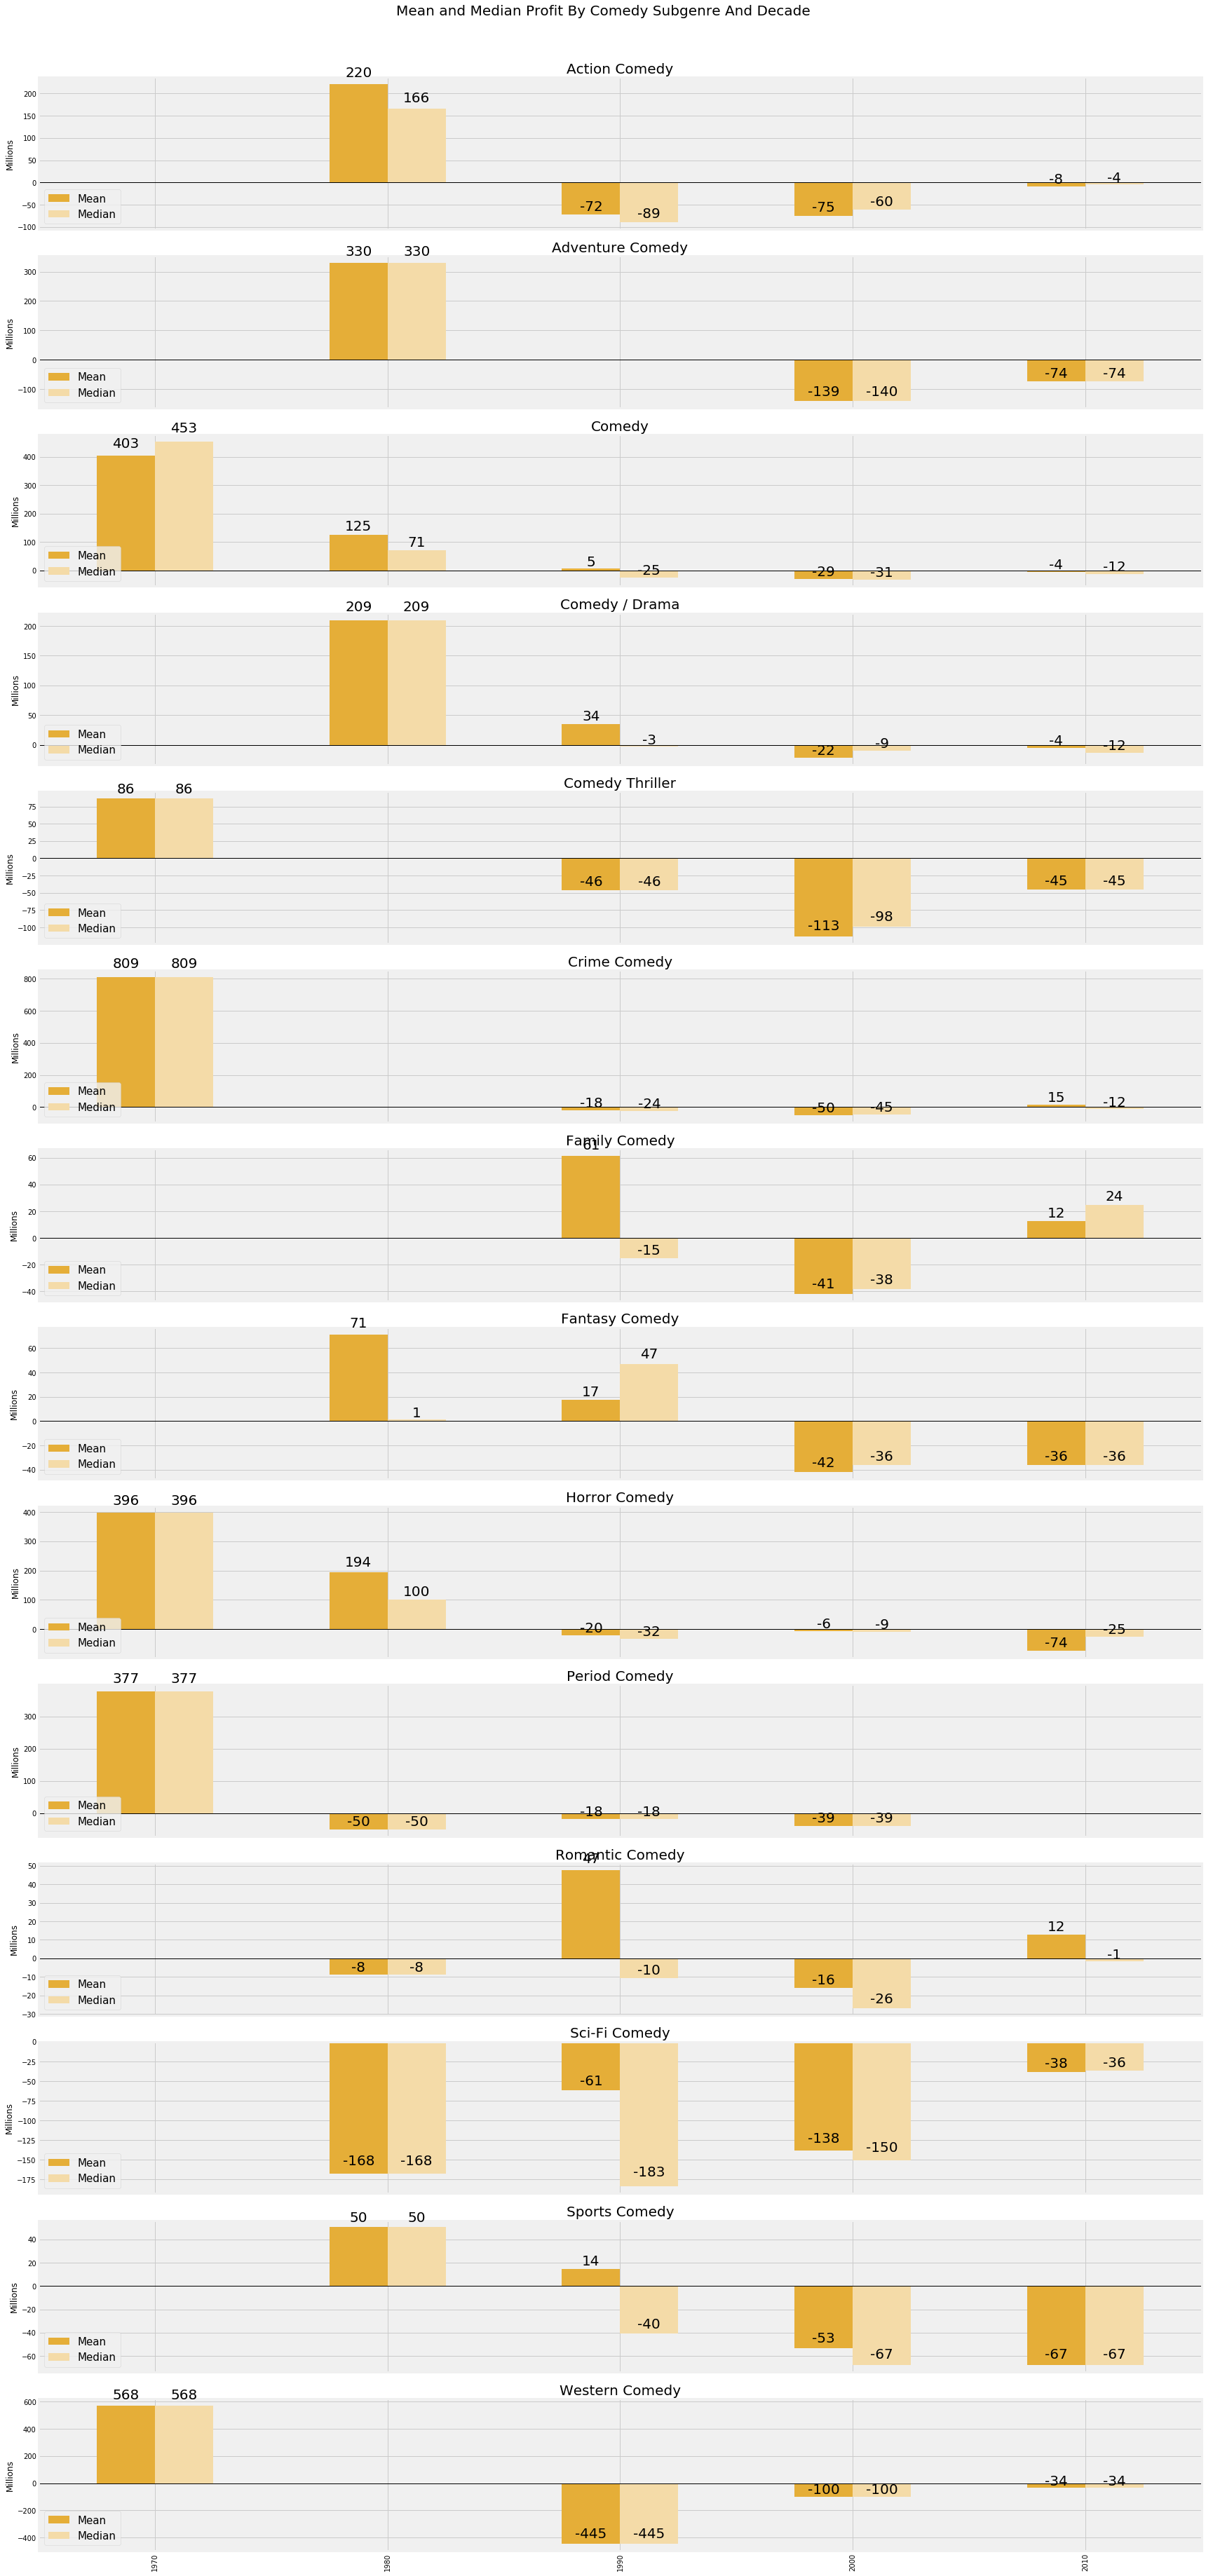

In [219]:
subgenre_profitability_by_decade('comedy', [genres_dict['comedy']['color1'], genres_dict['comedy']['color2']])

#### Quick Takeaways

Median profitability of comedies since the 1990s hasn't been great, with most subgenres in the red for most if not all of the last three decades.

The only subgenre with positive median profitability in the 2010s is Family Comedy.

### Drama Subgenres By Decade

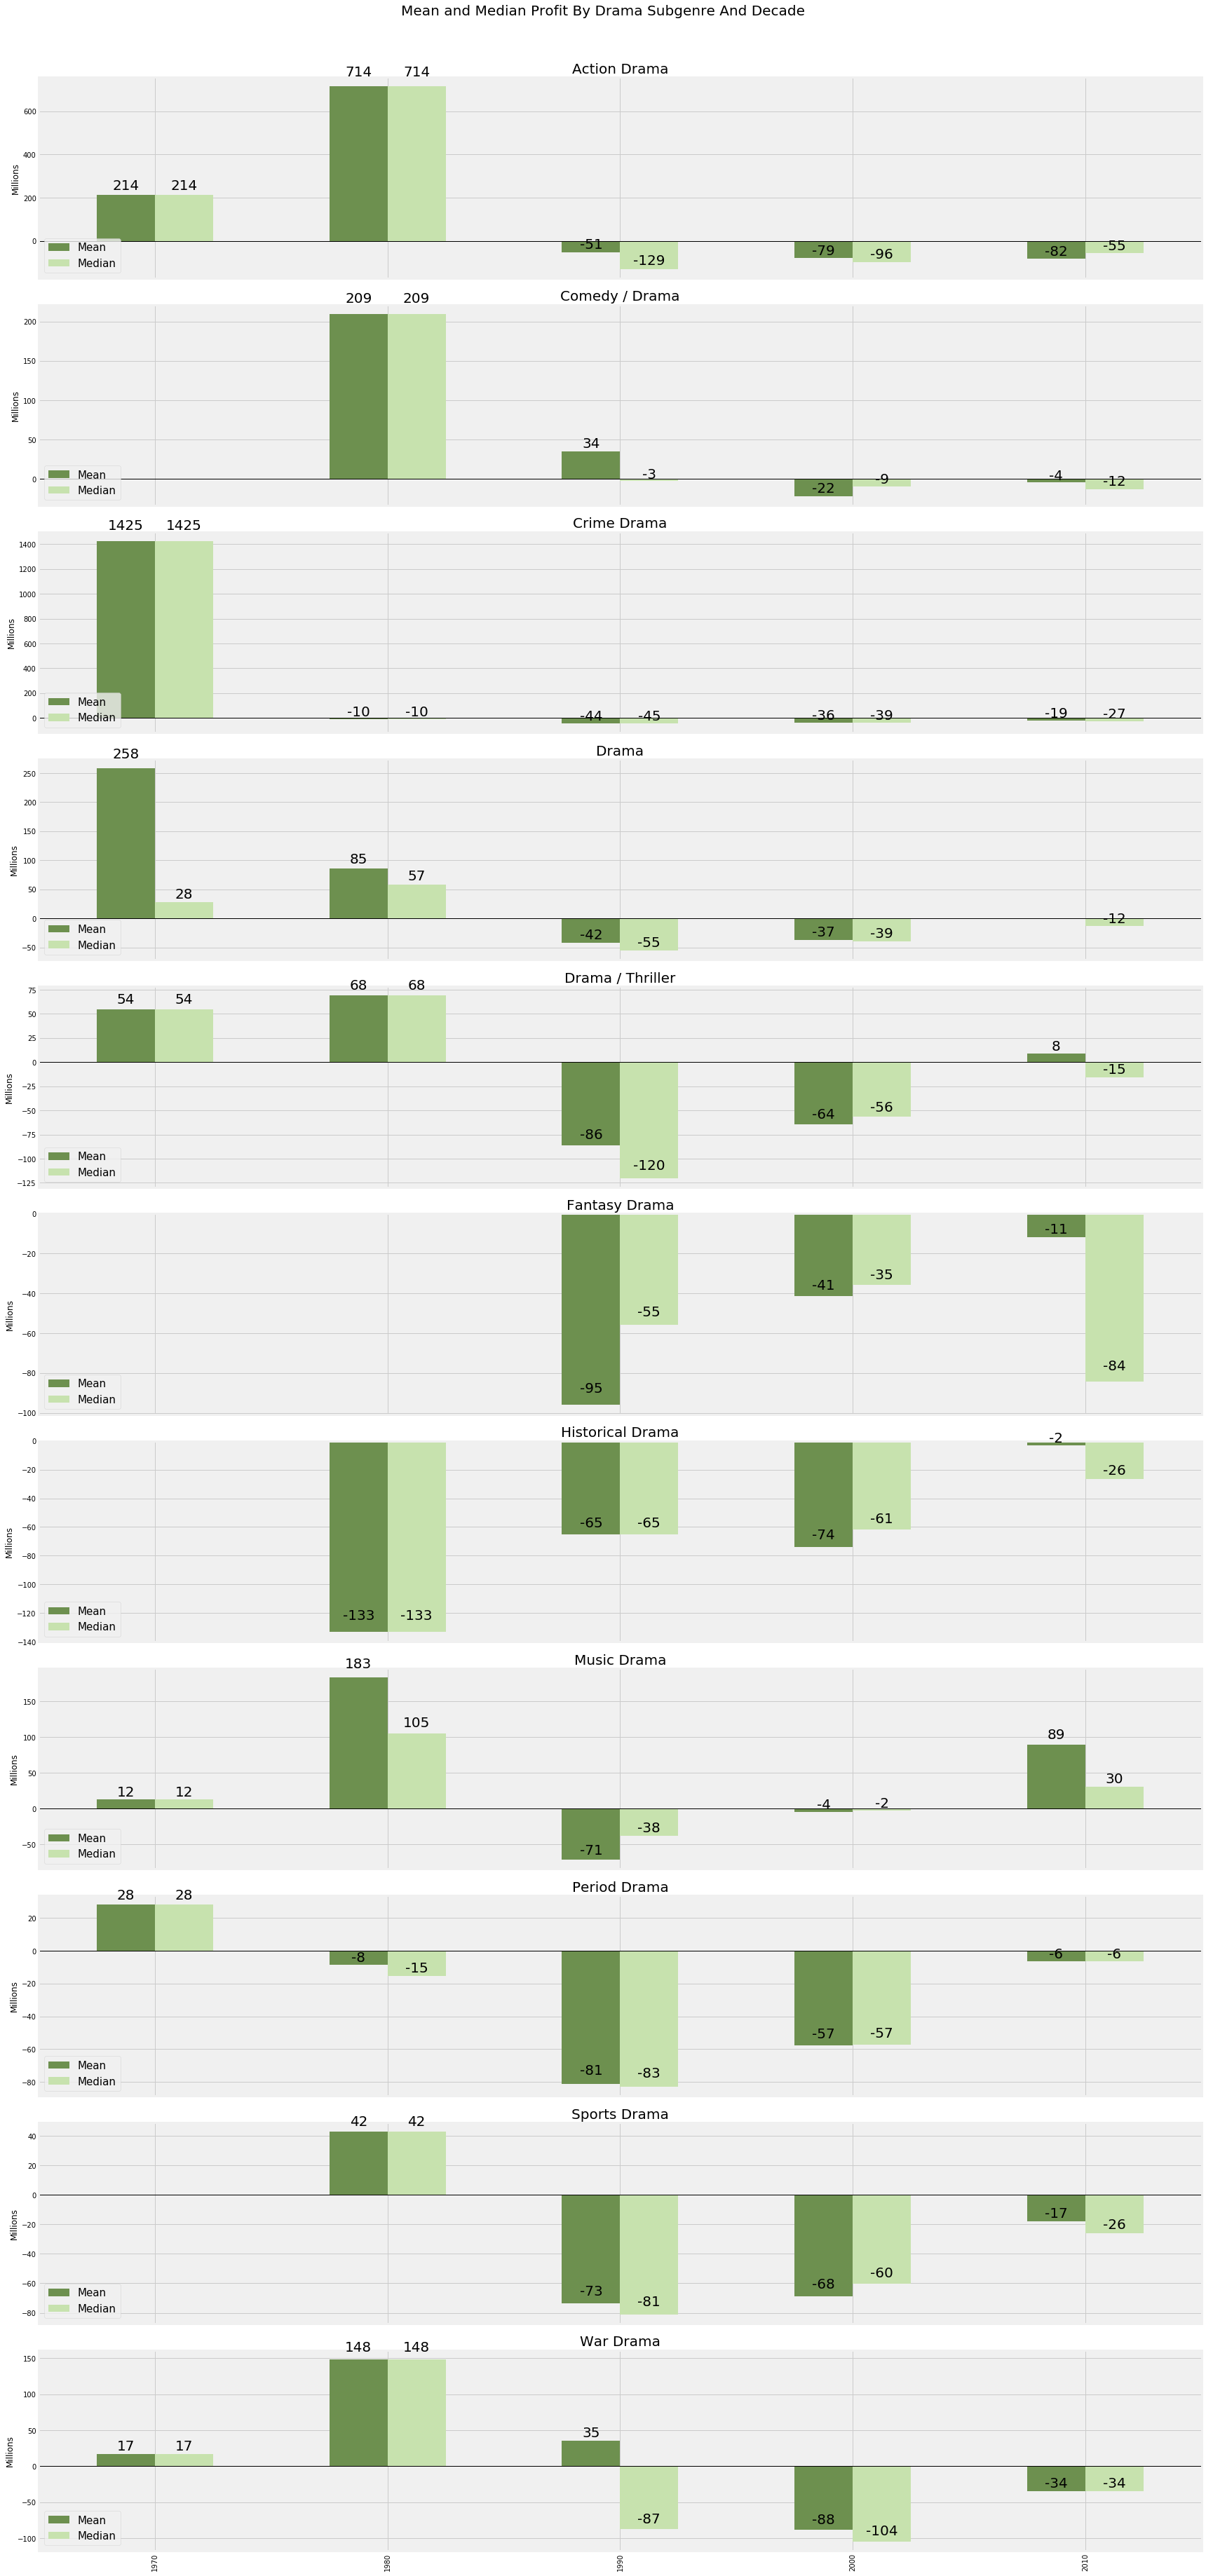

In [220]:
subgenre_profitability_by_decade('drama', [genres_dict['drama']['color1'], genres_dict['drama']['color2']])

#### Quick Takeaways

Only Music Drama has a positive median profitability this decade.

### Horror Subgenres By Decade

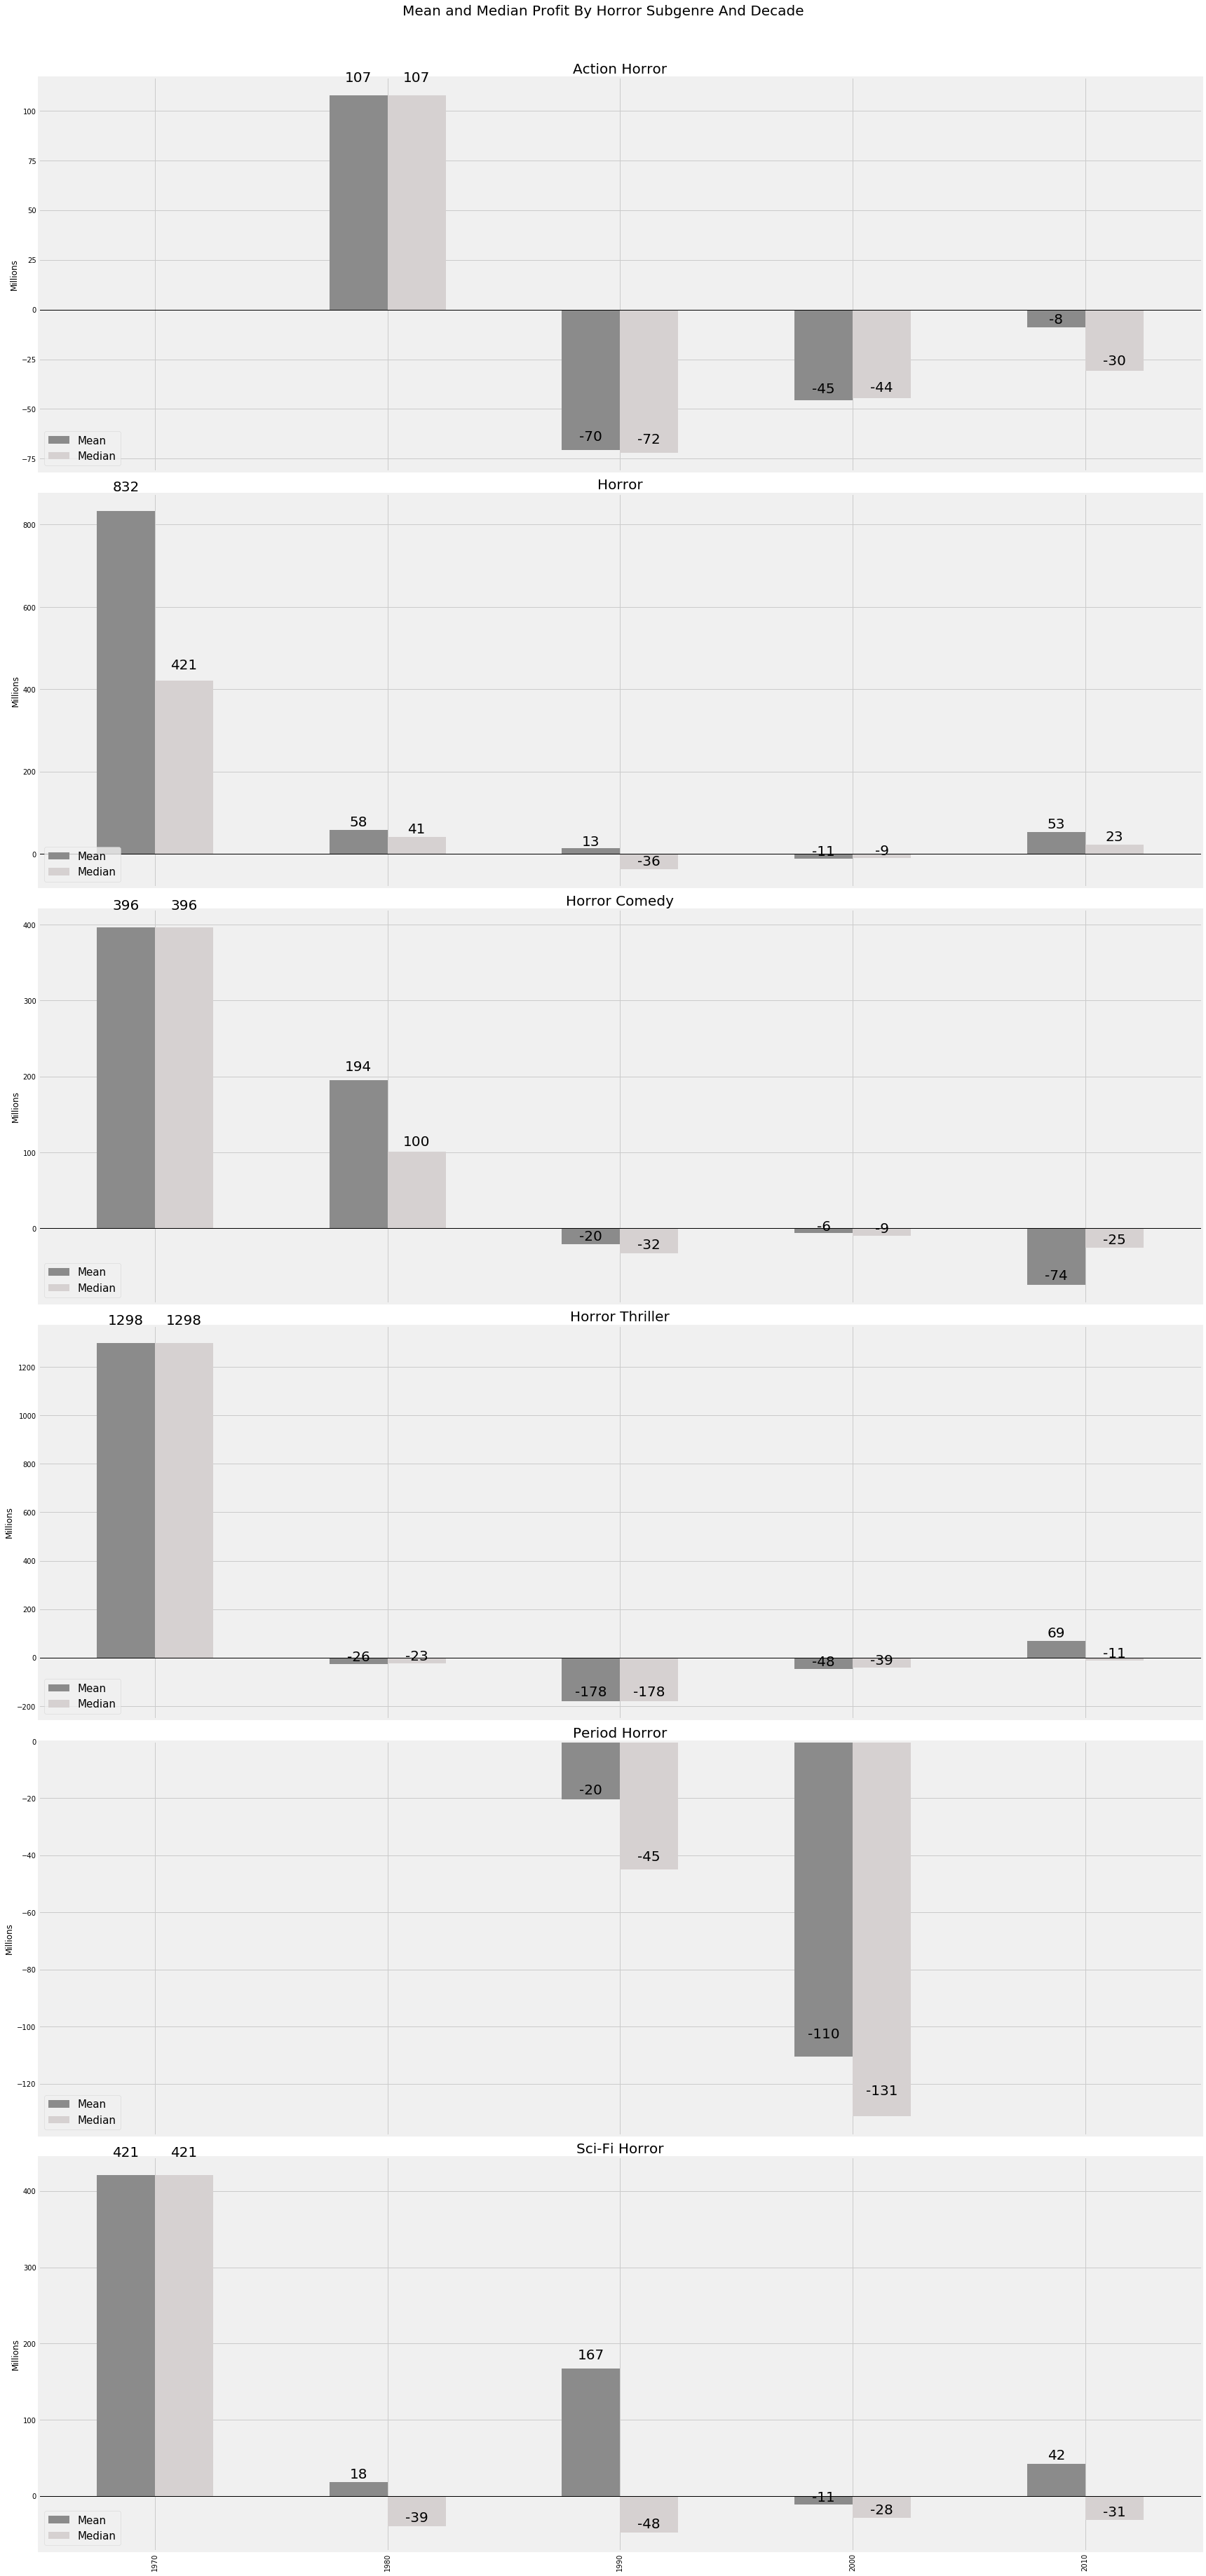

In [221]:
subgenre_profitability_by_decade('horror', [genres_dict['horror']['color1'], genres_dict['horror']['color2']])

#### Quick Takeaways

Only movies labeled as just Horror have a positive median profitability this decade. All other subgenres have negative median profitability.

### Thriller/Suspense Subgenres By Decade

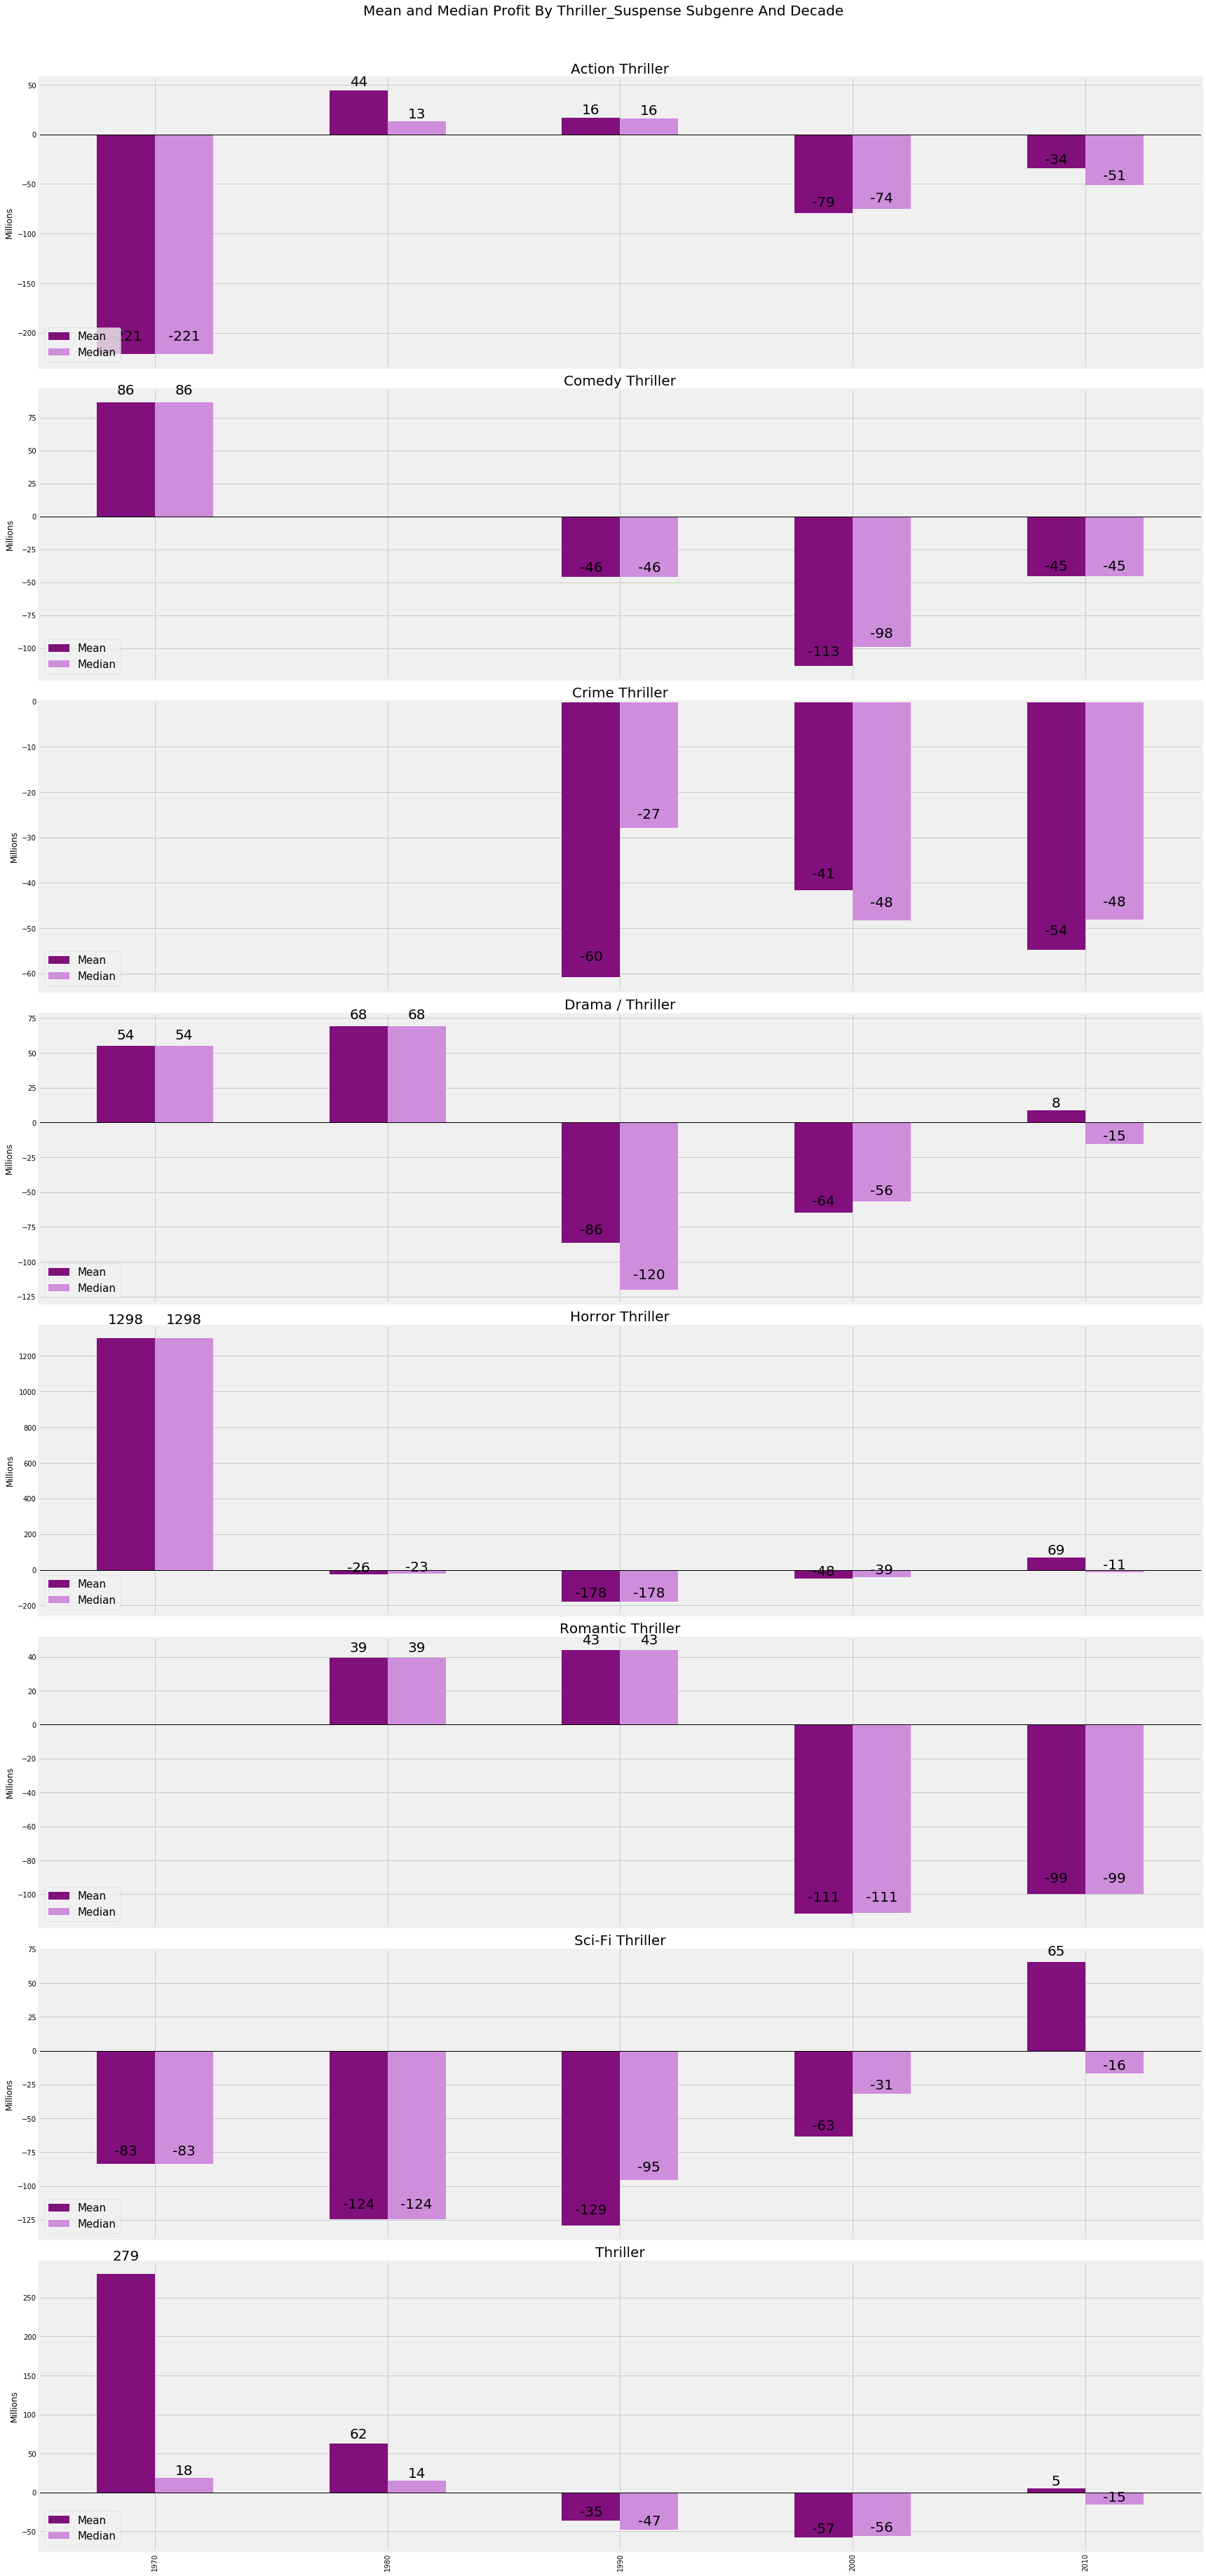

In [222]:
subgenre_profitability_by_decade('thriller_suspense', [genres_dict['thriller_suspense']['color1'], genres_dict['thriller_suspense']['color2']])

#### Quick Takeaways

No subgenre in Thriller/Suspense has a positive median profitability this decade.

### Summary

No subgenre stands out as a better play than any other. There's simply too much variance over time. Some decades are missing subgenres entirely.

As an example, our mean and median profitability in 'Family Adventure' movies is almost two billion dollars in the 1980s. But that is solely due to our only entry in that category being E.T., one of the most successful movies of all time. We should not conclude that our studio should start pumping out Family Adventure movies because of this information.

The movie business goes through phases like any other industry. Certain genres are hot for a minute, but then cool down for awhile. For this reason, scrutinizing subgenres over the past fifty years looking for solid trends might not yield much. 

If we restrict our focus to just the last decade, we might find some insights into the current state of genres and subgenres though.

## Current Decade

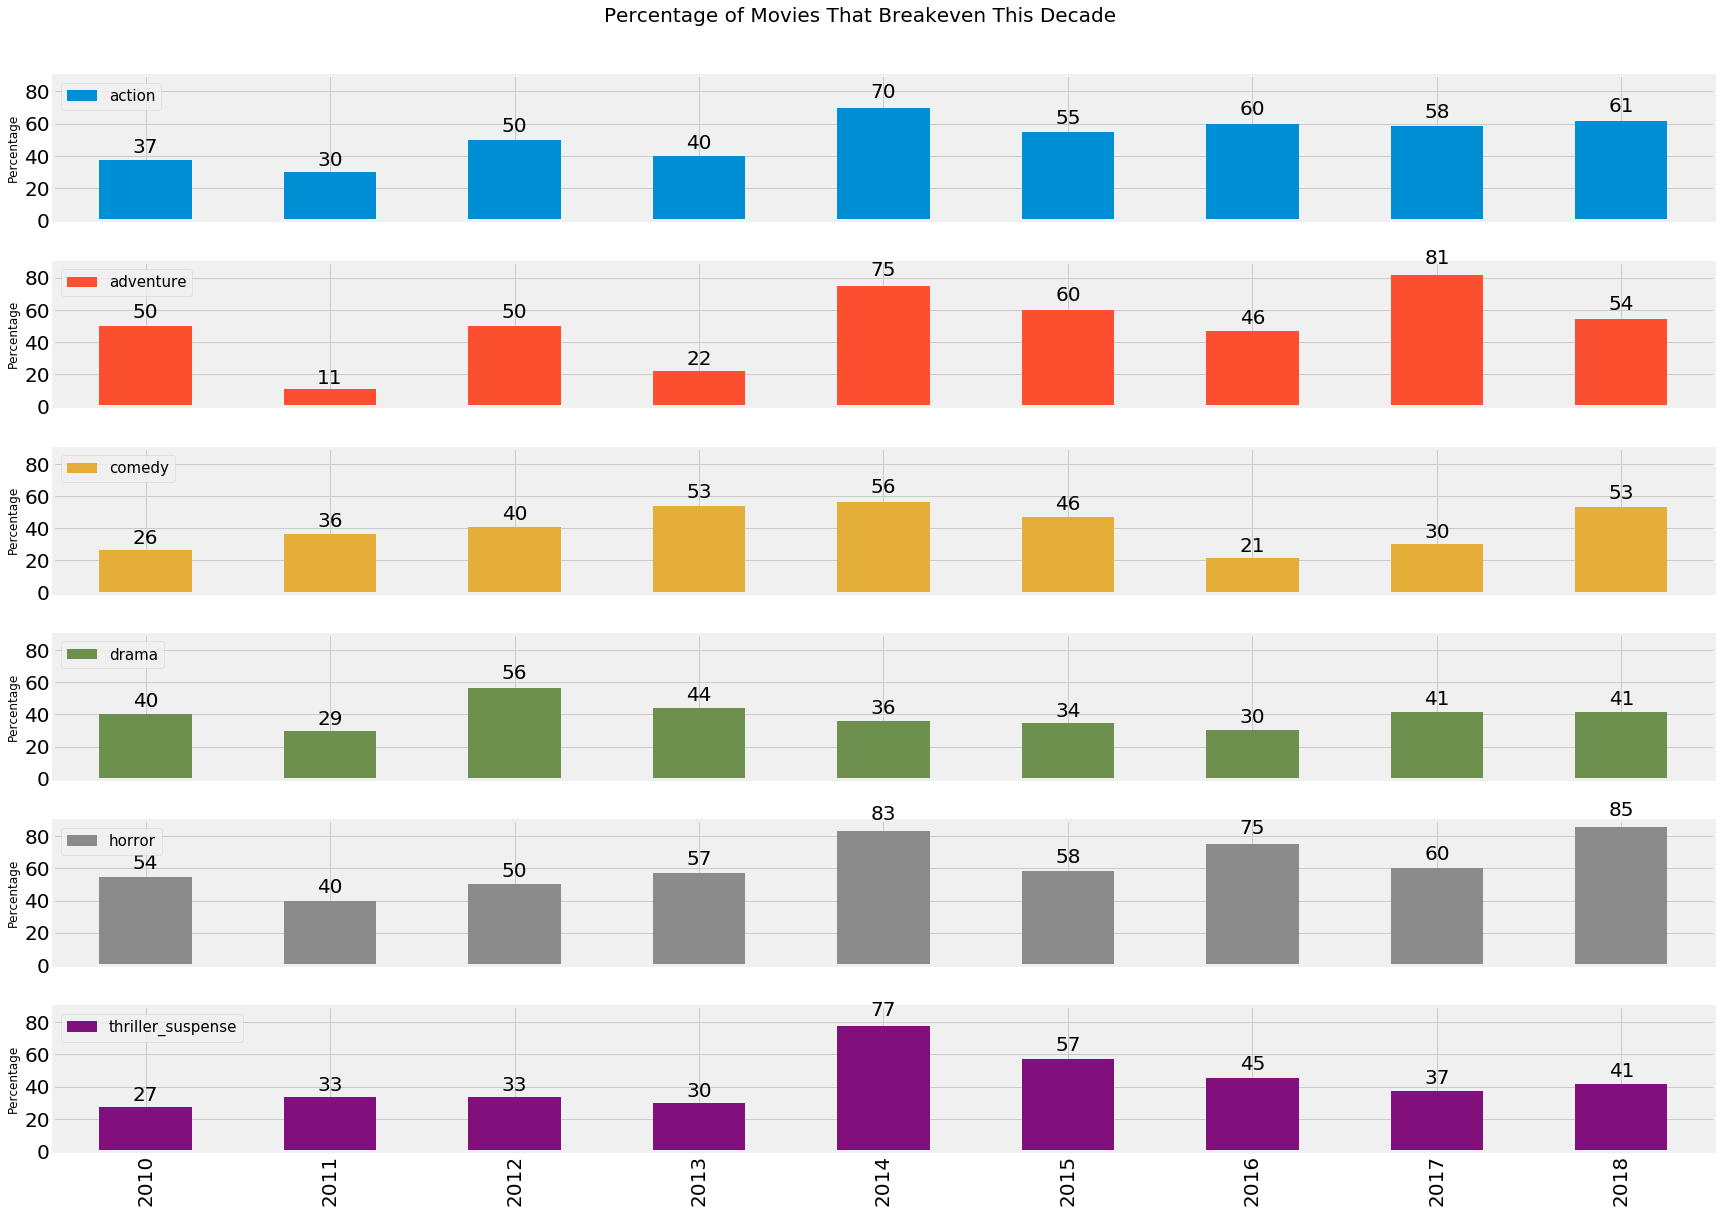

In [70]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Percentage of Movies That Breakeven This Decade', fontsize=20, y=1.05)

for genre, axis, color in zip(genres, axes.flat, colors):
    grp = (data[(data[genre]) & (data['release_year'] >= 2010)].groupby('release_year')['worldwide_breakeven'].mean() * 100).copy()

    # If the series is missing a decade, add it as an index
    # Then set the value to 0
    for year in range(2010, 2019, 1):
        if year not in grp.index:
            grp.loc[year] = 0

    # Sort the series by its index to have the decades in chronological order                
    grp.sort_index(ascending=True, inplace=True)

    grp.plot(kind='bar', xticks=range(2010, 2019, 1), ax=axis, linewidth=3, color=color, fontsize=20)
    axis.set_ylabel('Percentage', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    axis.set_xlabel('')
    autolabel(axis)
    
plt.tight_layout() 

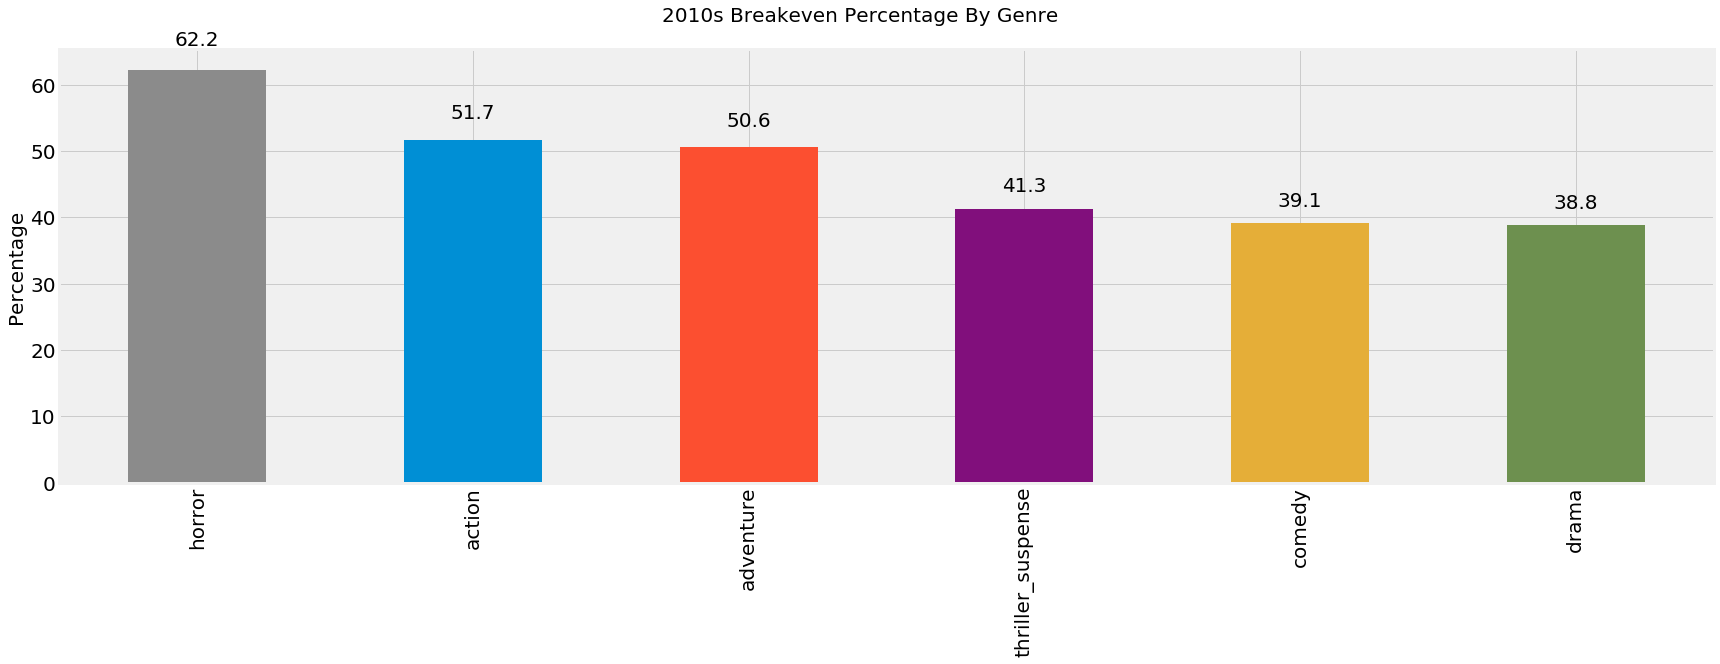

In [142]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('2010s Breakeven Percentage By Genre', fontsize=20, y=1.02)

summary.sort_values('current_decade_breakeven_percentage', ascending=False, inplace=True)

color_list = generate_color_list(colors_needed=1, order_list=summary.index)

summary.plot(y='current_decade_breakeven_percentage', kind='bar', ax=axis, color=color_list, legend=False)
axis.set_ylabel('Percentage', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
autolabel(axis, num_decimals=1)

plt.tight_layout()

### Quick Thoughts

**Year by year takeaways**
  - There is a great deal of variety in box office results on a year by year basis
  - For the past decade, the strongest performing genre from a breakeven perspective is Horror
  - Action and Adventure are basically a coinflip to breakeven this decade  

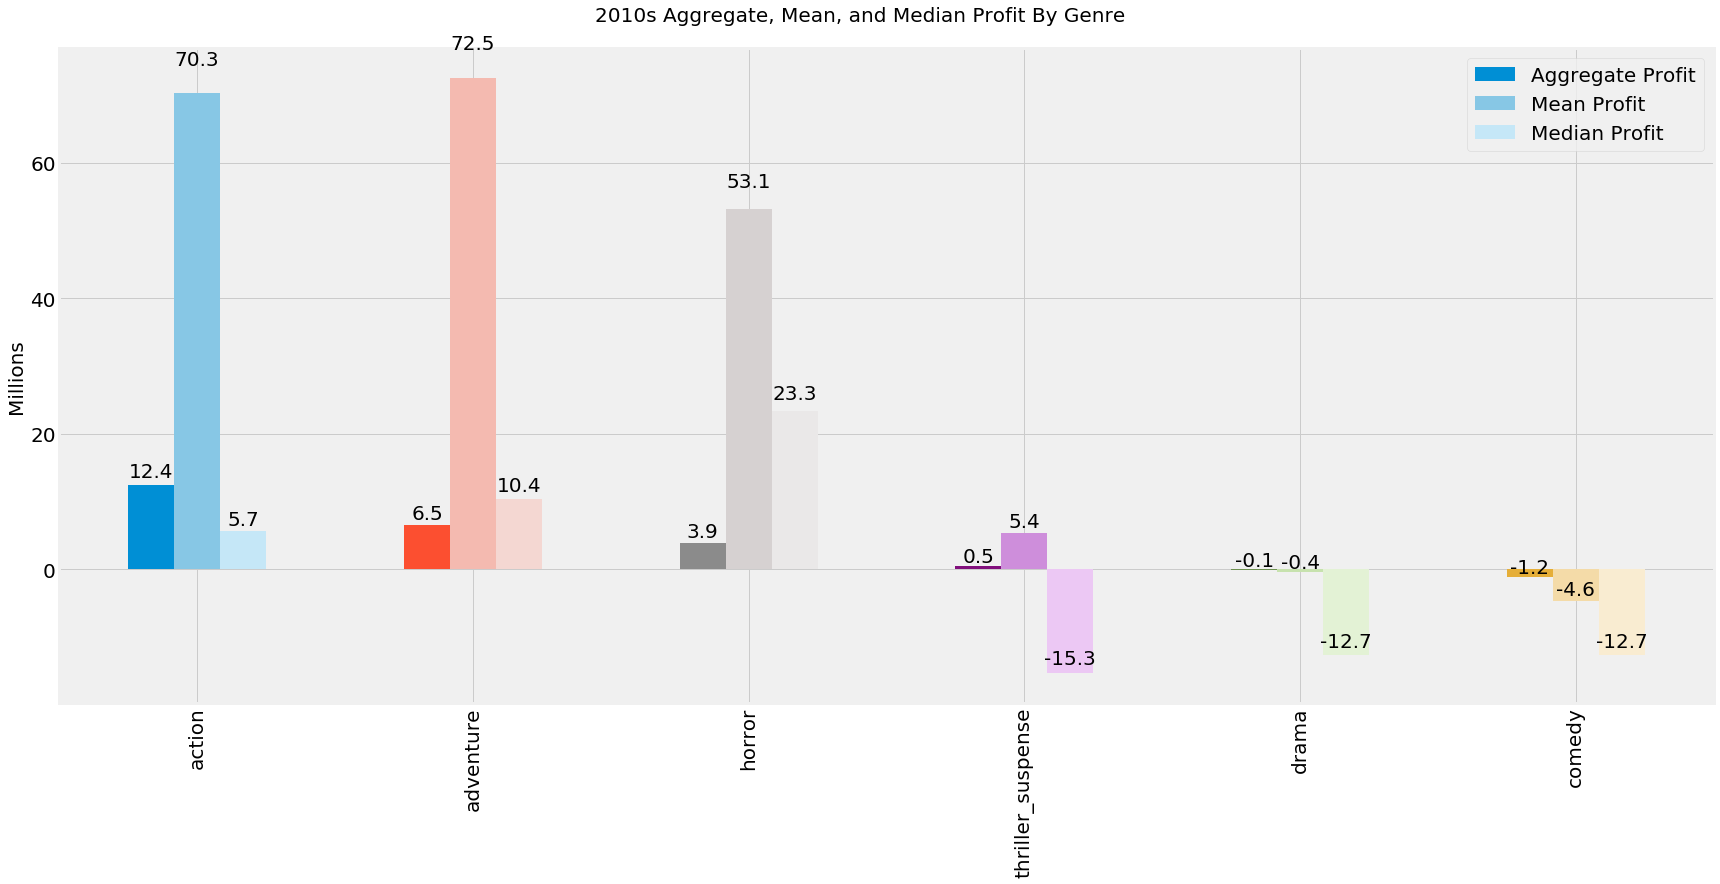

In [134]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 12))
figure.suptitle('2010s Aggregate, Mean, and Median Profit By Genre', fontsize=20, y=1.02)

summary.sort_values('current_decade_profit', ascending=False, inplace=True)

color_list = generate_color_list(colors_needed=3, order_list=summary.index)

summary.plot(y=['current_decade_profit', 'current_decade_mean_profit', 'current_decade_median_profit'], kind='bar', ax=axis, color=color_list)
axis.set_ylabel('Millions', fontsize=20)
axis.set_xlabel('')
axis.legend(['Aggregate Profit', 'Mean Profit', 'Median Profit'], fontsize=20)
axis.tick_params(labelsize=20)
autolabel(axis, num_decimals=1)

plt.tight_layout()

### Quick Takeaways

**Aggregate Profit**
  - This is just adding up the profits (or losses) of each movie in each category in this decade
  - We should take away that the movie business is crushingly difficult to make money in theatrically
  - The most profitable genre in aggregate is Action with a paltry \\$12.4 million in net earnings
  
**Mean Profit**
  - We see the power of the right tails here. Action and Adventure are neck and neck with mean profits for this decade in the \\$70 million range
  - Horror is third with \\$53 million
  
**Median Profit**
  - Horror is the slam dunk winner with a median profit of \\$23.3 million, followed by Adventure at \\$10.4 million and Action at \\$5.7 million
  - Comedy, Drama, and Thriller/Suspense are all median net losers this decade

### Boxplot

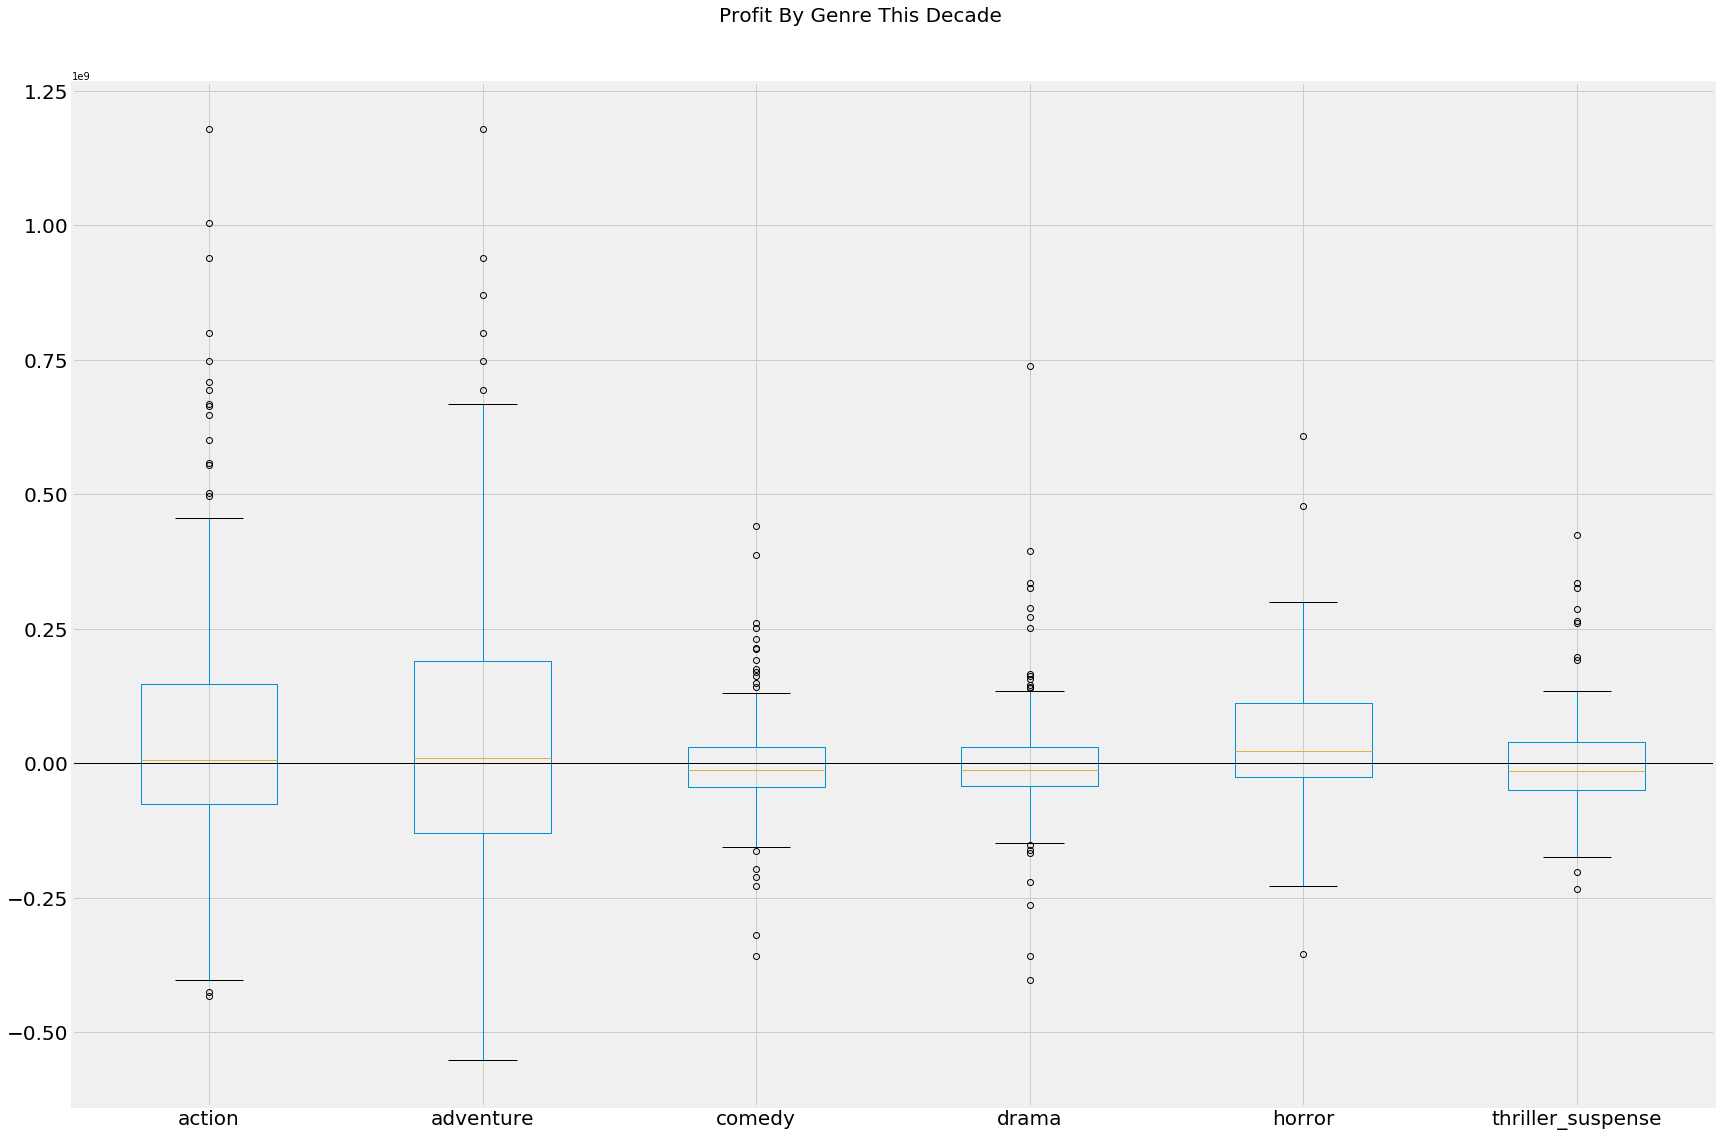

In [73]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24,15))
figure.suptitle('Profit By Genre This Decade', fontsize=20, y=1.05)

data[data['release_year'] >= 2010][profit_columns].plot(kind='box', ax=axis)
axis.set_xticklabels(genres)
axis.tick_params(labelsize=20)
axis.axhline(0, color='k', linewidth=1)

plt.tight_layout()

## Summary

The boxplot helps shed some light on each genre's strengths and weaknesses.

**Movies are an outlier-driven business**
  - In this decade, every genre has outliers on both sides of profit and loss
  - Action and Adventure have the highest profit outliers
  - Comedy and Drama have the most losing outliers
  
**Safe versus Risky**
  - Action and Adventure movies can make the most money but also lose the most
  - The "safest" genres of Comedy, Drama, and Thriller/Suspense still have plenty of outliers on the loser side. 
  - Horror is in the middle of those two camps: more reward than Comedy/Drama/Thriller/Suspense and less loss than Action/Adventure
  
**Breaking even**
  - Horror has the most chance to break even, followed by Action and Adventure.
  
**Median Profit**
  - In the scale on which movies make money, the median profits for all genres this decade are incredibly small.
  - Horror has the highest at \\$23 million. Adventure is at 10, and Action is at 5
  - Comedy, Drama, and Thriller/Suspense are all double digit median losers this decade
  
**Recommendation**
  - Based on the past decade of movie results, I would suggest pursuing Horror movies.
  
**Final step**
  - Let's examine each genre's performance by its release week and see if we learn anything interesting. 

# Analyze By Release Week

## Number of Movies

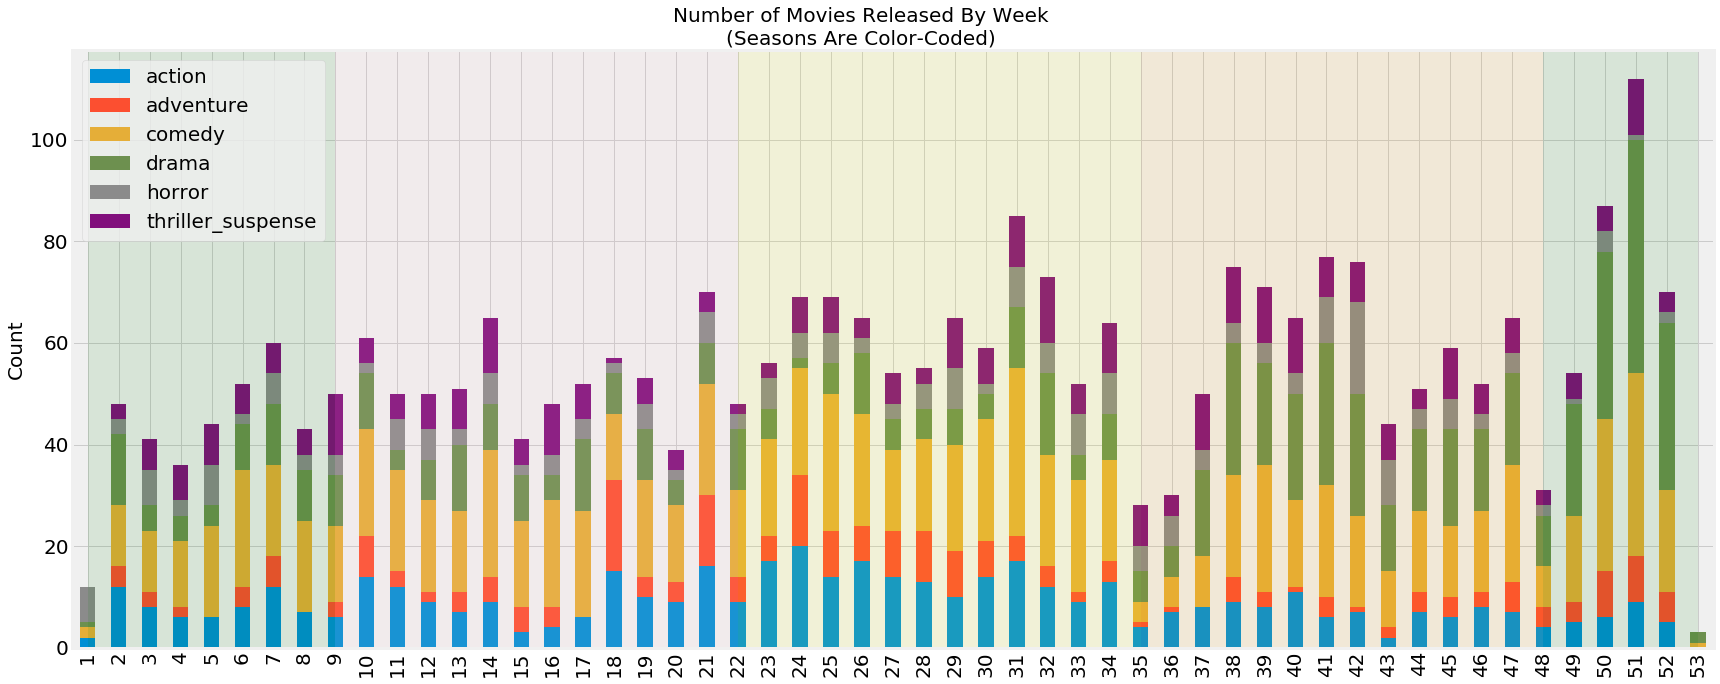

In [215]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Number of Movies Released By Week\n(Seasons Are Color-Coded)', fontsize=20, y=1.05)

grp = data.groupby('release_week')[genres].sum()
grp.plot(kind='bar', stacked=True, ax=axis)
axis.set_ylabel('Count', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
axis.legend(genres, fontsize=20)

# Subtract one from axvspan ranges to account for it being a bar chart and not a line chart
axis.axvspan(8, 21, alpha=0.1, facecolor='pink')
axis.axvspan(21, 34, alpha=0.1, facecolor='yellow')
axis.axvspan(34, 47, alpha=0.1, facecolor='orange')
axis.axvspan(47, 52, alpha=0.1, facecolor='green')
axis.axvspan(0, 8, alpha=0.1, facecolor='green')

plt.tight_layout()

### Quick Takeaways

Other than a few weeks, there have been a healthy amount of movies being released on every possible week.

Let's subdivide by genre to get a better look.

### All-Time

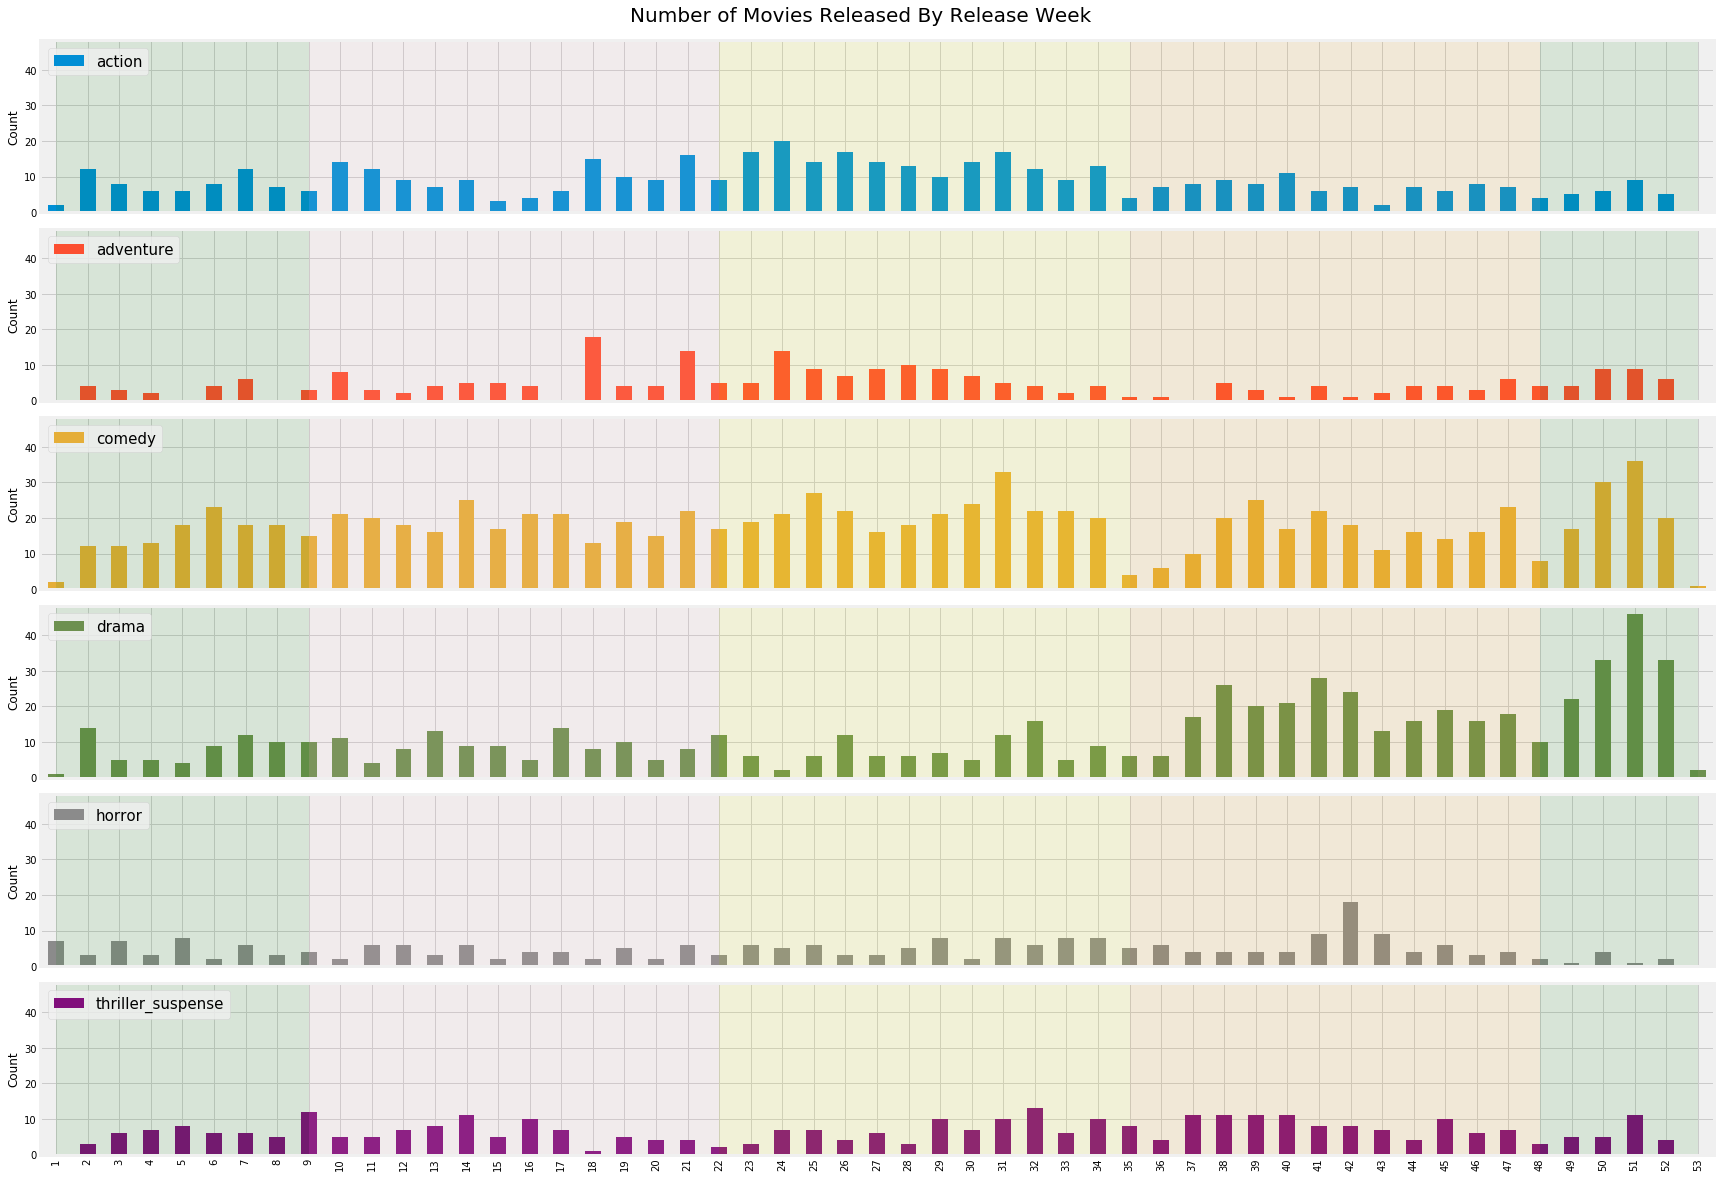

In [75]:
figure, axes = plt.subplots(nrows=6, ncols=1, figsize=(24, 16), sharex=True, sharey=True)
figure.suptitle('Number of Movies Released By Release Week', fontsize=20, y=1.02)

for genre, axis, color in zip(genres, axes.flat, colors):
    grp = data[data[genre]].groupby('release_week')['title'].count()
    
    # If the series is missing a decade, add it as an index
    # Then set the value to 0
    for week in range(1, 54):
        if week not in grp.index:
            grp.loc[week] = 0
    
    grp.sort_index(inplace=True, ascending=True)
        
    grp.plot(kind='bar', xticks=range(1, 54), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Count', fontsize=12)
    axis.set_xlabel('')
    axis.legend([genre], loc=2, fontsize=15)
    
    # Subtract one from axvspan ranges to account for it being a bar chart and not a line chart
    axis.axvspan(8, 21, alpha=0.1, facecolor='pink')
    axis.axvspan(21, 34, alpha=0.1, facecolor='yellow')
    axis.axvspan(34, 47, alpha=0.1, facecolor='orange')
    axis.axvspan(47, 52, alpha=0.1, facecolor='green')
    axis.axvspan(0, 8, alpha=0.1, facecolor='green')

plt.tight_layout() 

#### Quick Takeaways

Comedy has been released in good numbers in practically every week.

Drama has the most releases in the Fall and Winter. 

Action and Adventure have the most releases in Summer.

Horror and Thriller/Suspense don't really have clear patterns.

### This Decade

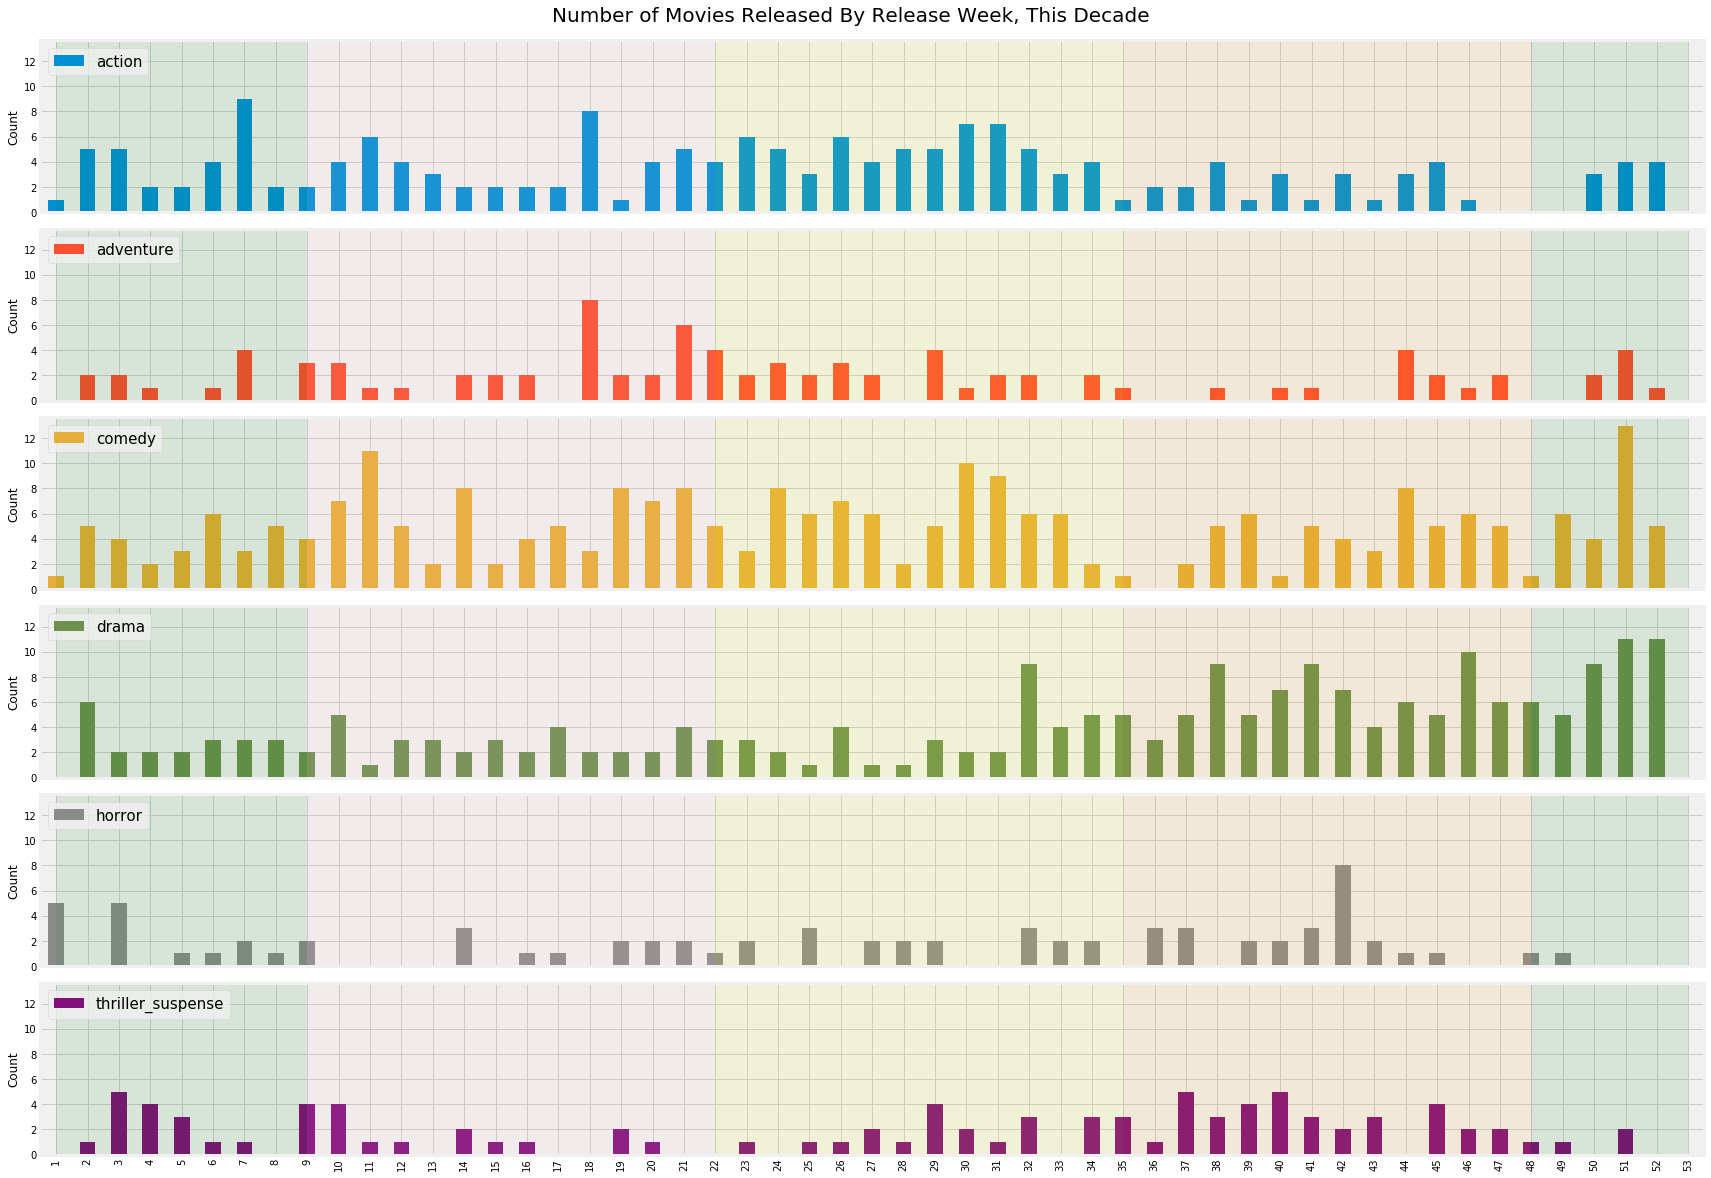

In [76]:
figure, axes = plt.subplots(nrows=6, ncols=1, figsize=(24, 16), sharex=True, sharey=True)
figure.suptitle('Number of Movies Released By Release Week, This Decade', fontsize=20, y=1.02)

for genre, axis, color in zip(genres, axes.flat, colors):
    grp = data[(data['release_year'] >= 2010) & (data[genre])].groupby('release_week')['title'].count()
    
    # If the series is missing a decade, add it as an index
    # Then set the value to 0
    for week in range(1, 54):
        if week not in grp.index:
            grp.loc[week] = 0
    
    grp.sort_index(inplace=True, ascending=True)
        
    grp.plot(kind='bar', xticks=range(1, 54), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Count', fontsize=12)
    axis.set_xlabel('')
    axis.legend([genre], loc=2, fontsize=15)
    
     # Subtract one from axvspan ranges to account for it being a bar chart and not a line chart
    axis.axvspan(8, 21, alpha=0.1, facecolor='pink')
    axis.axvspan(21, 34, alpha=0.1, facecolor='yellow')
    axis.axvspan(34, 47, alpha=0.1, facecolor='orange')
    axis.axvspan(47, 52, alpha=0.1, facecolor='green')
    axis.axvspan(0, 8, alpha=0.1, facecolor='green')

plt.tight_layout() 

#### Quick Takeaways

Comedy is released consistently in more weeks than any other genre.

Drama is still weighted towards Fall and Winter weeks.

Action is concentrated on Summer releases.

Adventure, Horror, and Thriller/Suspense have less clear patterns.

## Median Gross

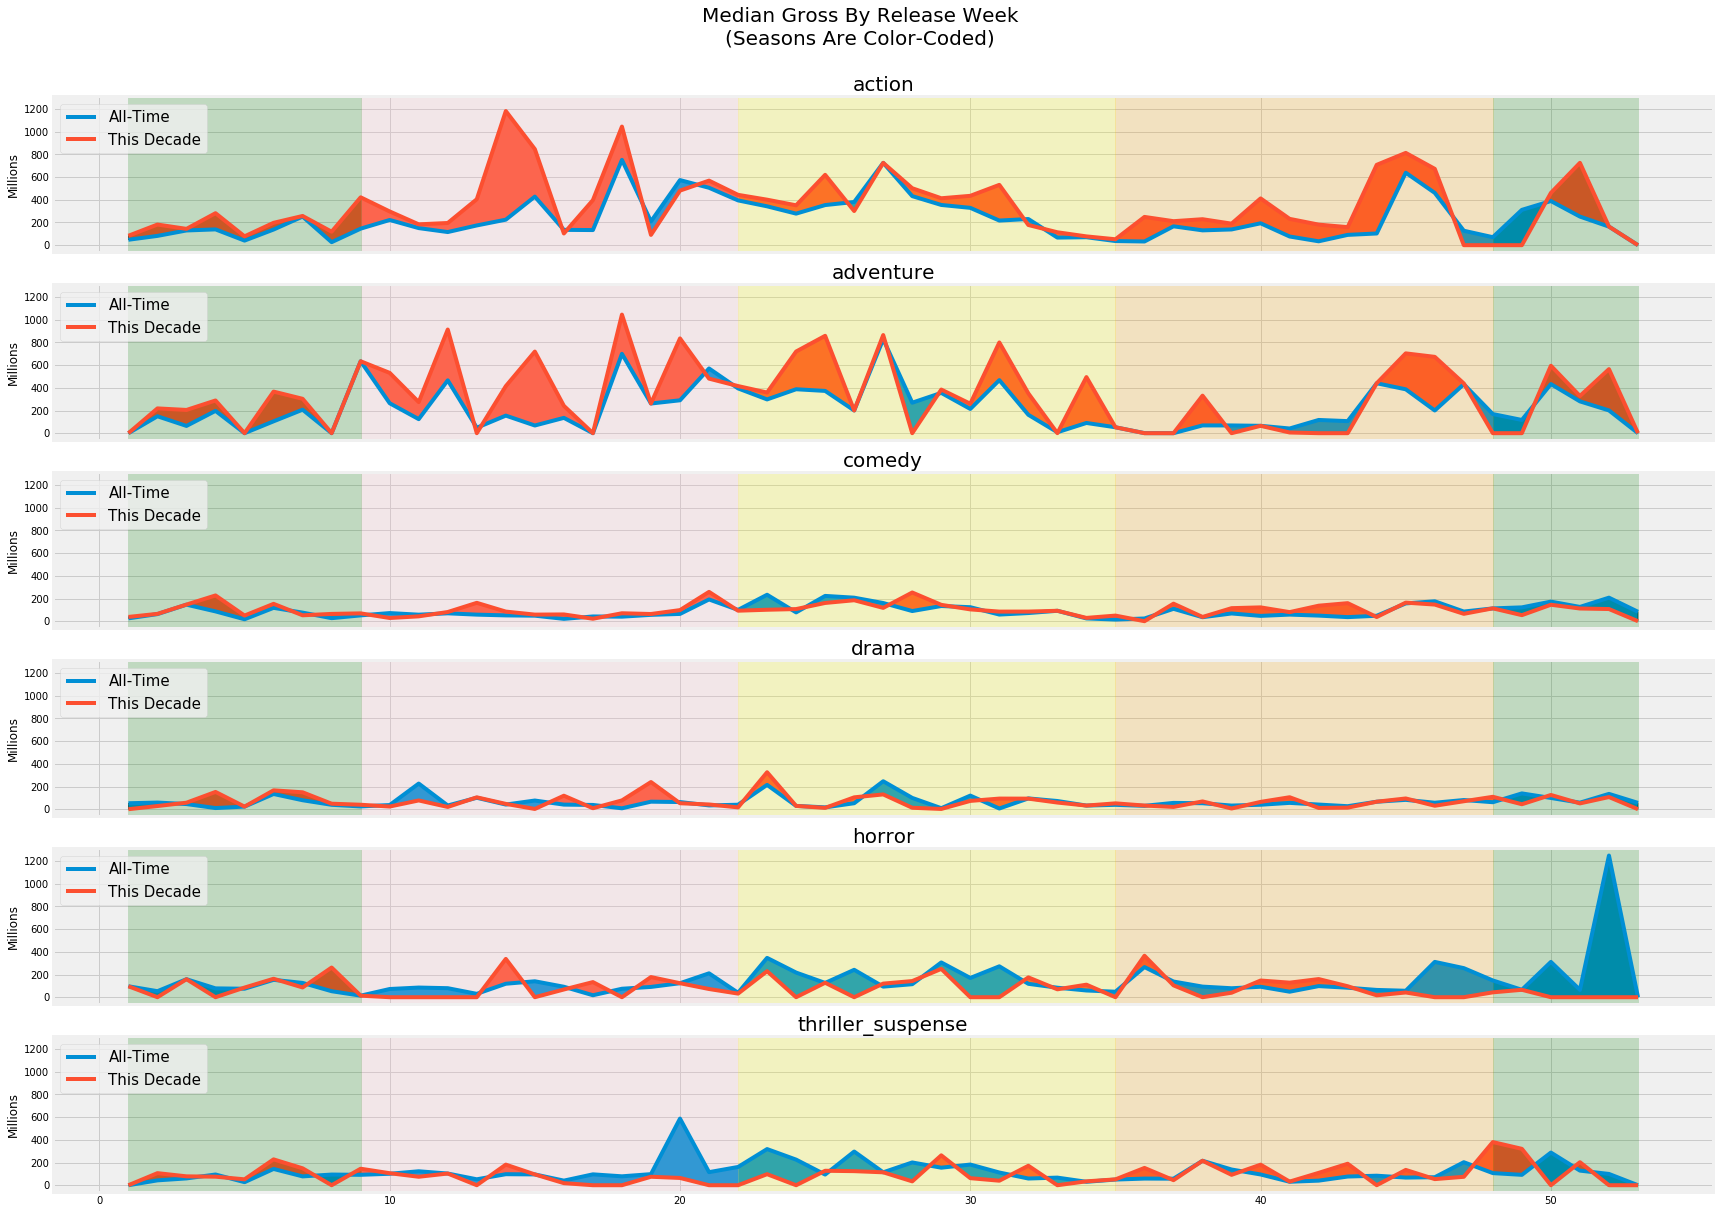

In [77]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Median Gross By Release Week\n(Seasons Are Color-Coded)', fontsize=20, y=1.05)

for genre, axis, color in zip(genres, axes.flat, colors):
    grp1 = data[data[genre]].groupby('release_week')['worldwide_adj'].median() / 1000000
    grp2 = data[(data['release_year'] >= 2010) & (data[genre])].groupby('release_week')['worldwide_adj'].median() / 1000000
    
    for year in range(1, 54, 1):
        if year not in grp1.index:
            grp1.loc[year] = 0
            
        if year not in grp2.index:
            grp2.loc[year] = 0

    # Sort the series by its index to have the decades in chronological order                
    grp1.sort_index(ascending=True, inplace=True)
    grp2.sort_index(ascending=True, inplace=True)
    
    axis.plot(range(1,54), grp1, color=colors[0], label='All-Time')
    axis.plot(range(1,54), grp2, color=colors[1], label='This Decade') 
        
    axis.fill_between(range(1, 54), y1=grp1, y2=grp2, where=grp2 <= grp1, facecolor=colors[0], interpolate=True, edgecolor='k')
    axis.fill_between(range(1, 54), y1=grp1, y2=grp2, where=grp2 > grp1, facecolor=colors[1], interpolate=True, edgecolor='k')
    
    axis.set_title(genre, fontsize=20)
    
    axis.set_ylabel('Millions', fontsize=12)
    axis.set_xlabel('')
    axis.legend(loc=2, fontsize=15)
    axis.axvspan(9, 22, alpha=0.2, color='pink')
    axis.axvspan(22, 35, alpha=0.2, color='yellow')
    axis.axvspan(35, 48, alpha=0.2, color='orange')
    axis.axvspan(48, 53, alpha=0.2, color='green')
    axis.axvspan(1, 9, alpha=0.2, color='green')

plt.tight_layout() 

### Quick Takeaways

**Action**
  - Has higher median grosses on almost every release week this decade compared to its historical numbers
  - The biggest increases occur in Spring and Fall
  - Summer in general is higher this decade than it has been as well
  
**Adventure**
  - Has higher median grosses on almost every release week this decade compared to its historical numbers
  - The biggest increases occur in Spring and Summer
  
**Comedy and Drama**
  - Seem to perform about the same this decade compared to historically
  
**Horror**
  - Has worse grosses during Summer and Winter releases this decade
  
**Thriller/Suspense**
  - Seems to have lower median grosses in general this decade, most notably from the end of Spring through Summer

## Budgets

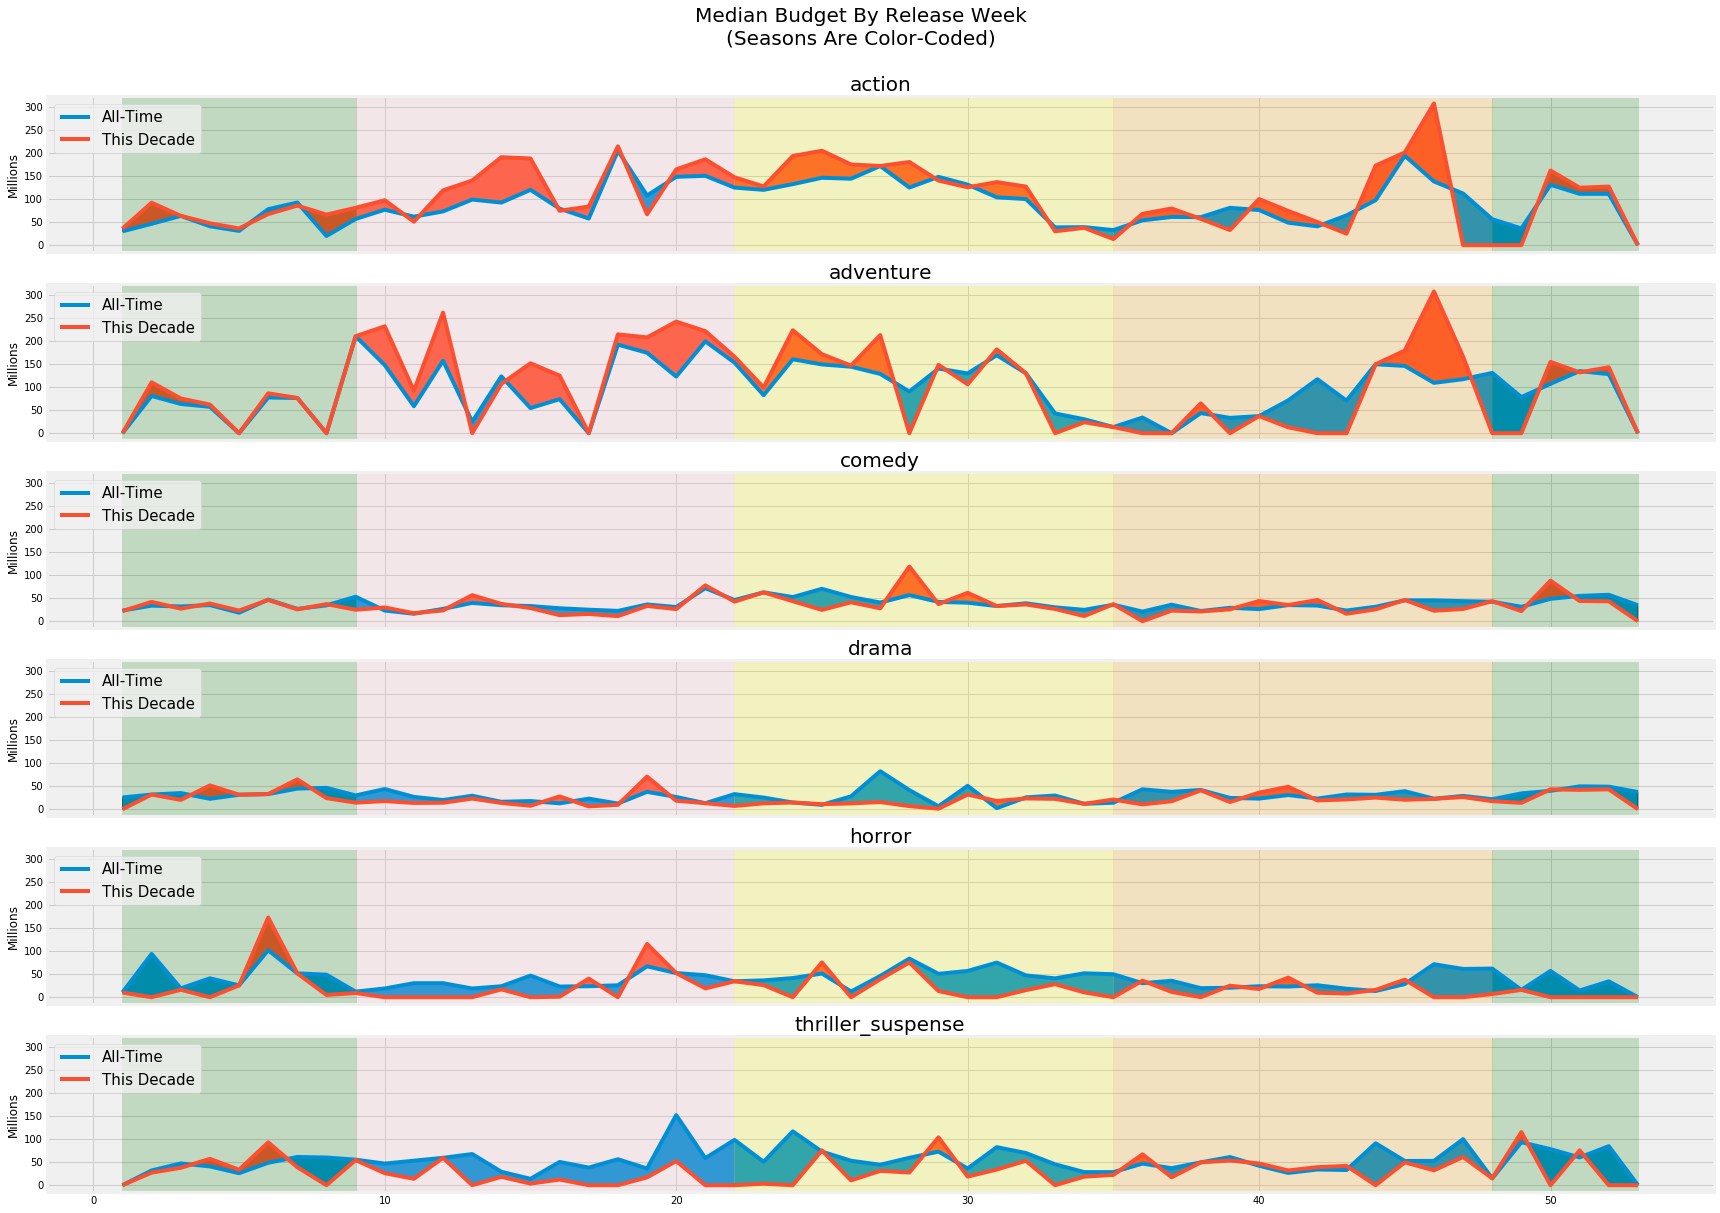

In [78]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Median Budget By Release Week\n(Seasons Are Color-Coded)', fontsize=20, y=1.05)

for genre, axis, color in zip(genres, axes.flat, colors):
    grp1 = data[data[genre]].groupby('release_week')['budget_adj'].median() / 1000000
    grp2 = data[(data['release_year'] >= 2010) & (data[genre])].groupby('release_week')['budget_adj'].median() / 1000000
    
    for year in range(1, 54, 1):
        if year not in grp1.index:
            grp1.loc[year] = 0
            
        if year not in grp2.index:
            grp2.loc[year] = 0

    # Sort the series by its index to have the decades in chronological order                
    grp1.sort_index(ascending=True, inplace=True)
    grp2.sort_index(ascending=True, inplace=True)
    
    axis.plot(range(1,54), grp1, color=colors[0], label='All-Time')
    axis.plot(range(1,54), grp2, color=colors[1], label='This Decade') 
        
    axis.fill_between(range(1, 54), y1=grp1, y2=grp2, where=grp2 <= grp1, facecolor=colors[0], interpolate=True, edgecolor='k')
    axis.fill_between(range(1, 54), y1=grp1, y2=grp2, where=grp2 > grp1, facecolor=colors[1], interpolate=True, edgecolor='k')
    
    axis.set_title(genre, fontsize=20)
    
    axis.set_ylabel('Millions', fontsize=12)
    axis.set_xlabel('')
    axis.legend(loc=2, fontsize=15)
    axis.axvspan(9, 22, alpha=0.2, color='pink')
    axis.axvspan(22, 35, alpha=0.2, color='yellow')
    axis.axvspan(35, 48, alpha=0.2, color='orange')
    axis.axvspan(48, 53, alpha=0.2, color='green')
    axis.axvspan(1, 9, alpha=0.2, color='green')

plt.tight_layout() 

### Quick Takeaways

  - Action and Adventure have higher median budgets for pretty much every release week
  - Comedy and Drama seem to have moderately lower budgets overall this decade in almost every release week
  - Horror and Thriller/Suspense have steep drops in budget this decade for almost every release week

## Median Profit

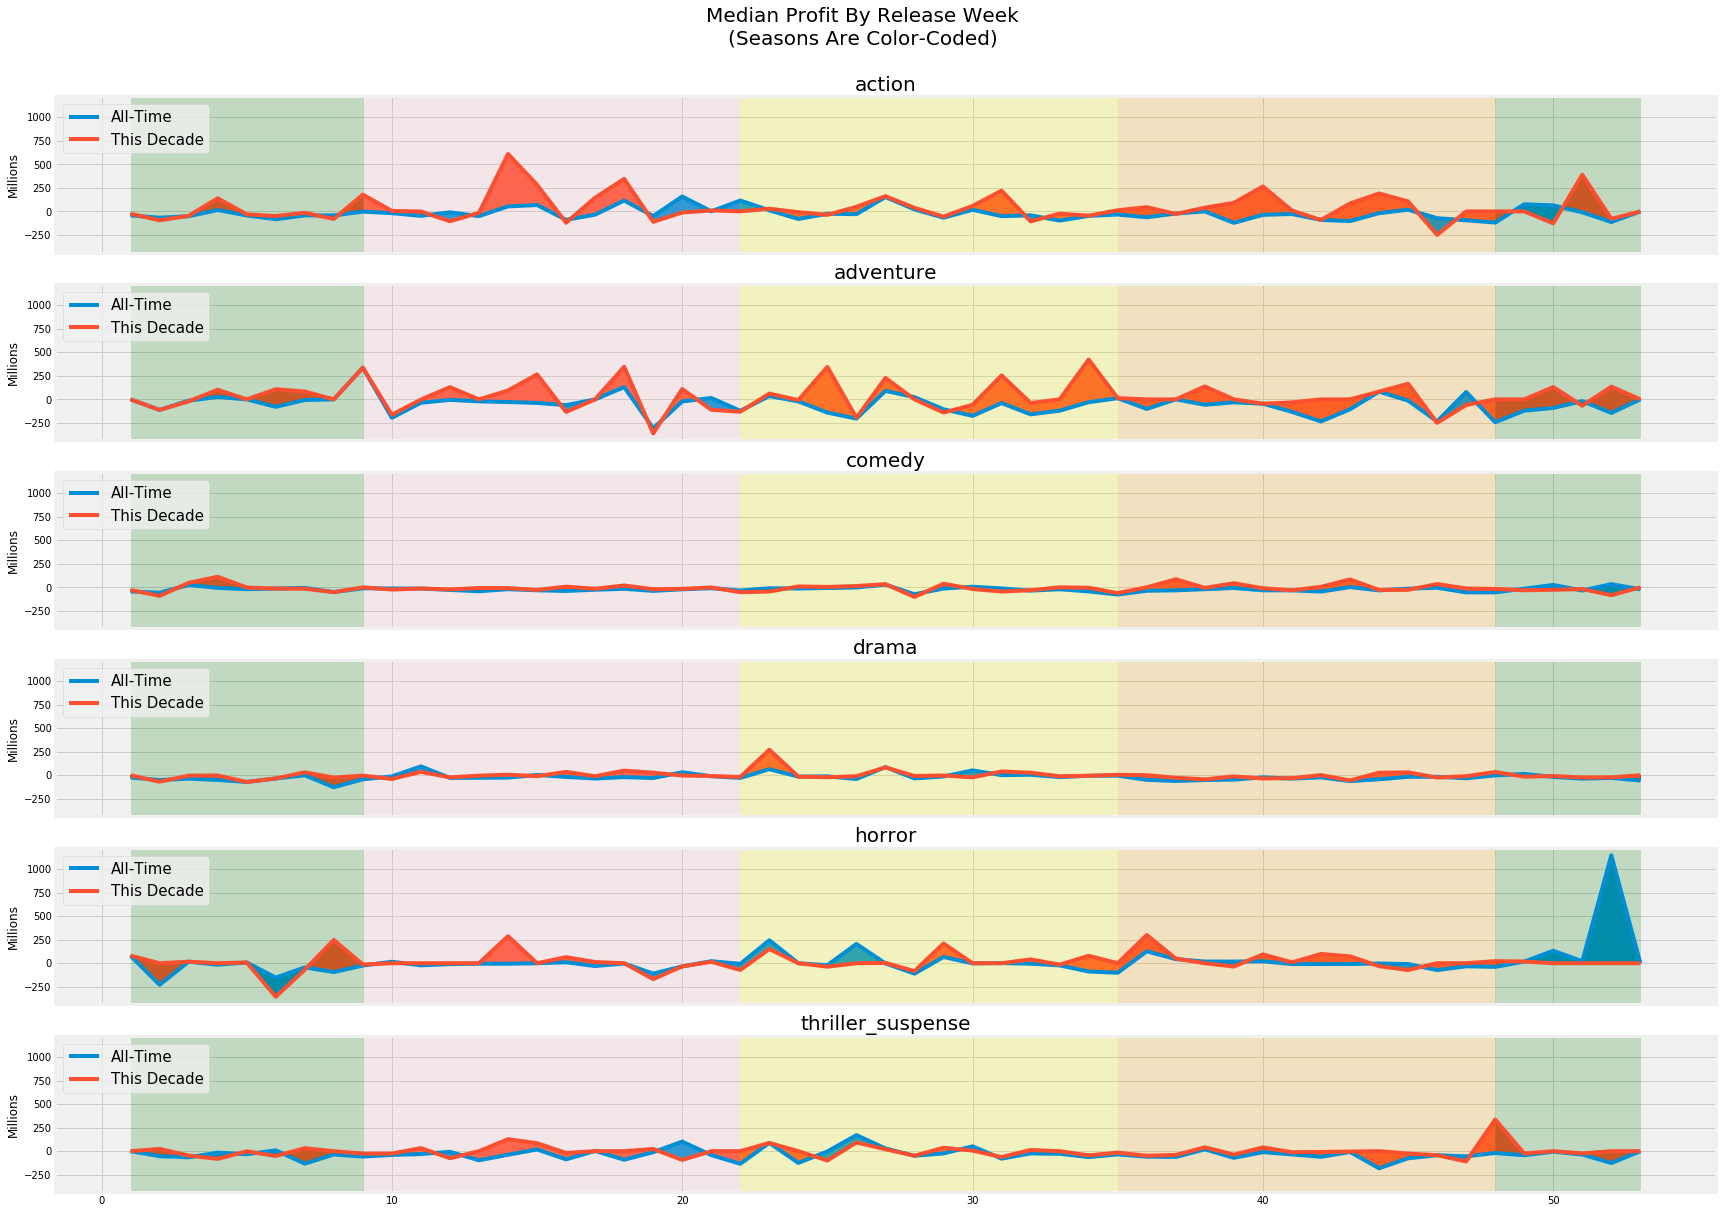

In [79]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Median Profit By Release Week\n(Seasons Are Color-Coded)', fontsize=20, y=1.05)

for genre, axis, color in zip(genres, axes.flat, colors):
    grp1 = data[data[genre]].groupby('release_week')['profit'].median() / 1000000
    grp2 = data[(data['release_year'] >= 2010) & (data[genre])].groupby('release_week')['profit'].median() / 1000000
    
    for year in range(1, 54, 1):
        if year not in grp1.index:
            grp1.loc[year] = 0
            
        if year not in grp2.index:
            grp2.loc[year] = 0

    # Sort the series by its index to have the decades in chronological order                
    grp1.sort_index(ascending=True, inplace=True)
    grp2.sort_index(ascending=True, inplace=True)
    
    axis.plot(range(1,54), grp1, color=colors[0], label='All-Time')
    axis.plot(range(1,54), grp2, color=colors[1], label='This Decade') 
        
    axis.fill_between(range(1, 54), y1=grp1, y2=grp2, where=grp2 <= grp1, facecolor=colors[0], interpolate=True, edgecolor='k')
    axis.fill_between(range(1, 54), y1=grp1, y2=grp2, where=grp2 > grp1, facecolor=colors[1], interpolate=True, edgecolor='k')
    
    axis.set_title(genre, fontsize=20)
    
    axis.set_ylabel('Millions', fontsize=12)
    axis.set_xlabel('')
    axis.legend(loc=2, fontsize=15)
    axis.axvspan(9, 22, alpha=0.2, color='pink')
    axis.axvspan(22, 35, alpha=0.2, color='yellow')
    axis.axvspan(35, 48, alpha=0.2, color='orange')
    axis.axvspan(48, 53, alpha=0.2, color='green')
    axis.axvspan(1, 9, alpha=0.2, color='green')

plt.tight_layout() 

### Quick Takeaways

**Similar results to Median Grosses analysis**
  - Action and Adventure are more profitable this decade than historically in almost every release week.
  - Comedy and Drama perform about the same as they did historically.
  - Horror has a few weeks where it has higher median profits than it does historically.
  - Thriller/Suspense in general performs a bit better this decade, most notably in Spring

Key Takeaways:
- `Action` and `Adventure` have much larger budgets in general
- `Thriller/Suspense` is third
- `Drama`, `Comedy`, and `Horror` all have approximately the same mean budget

## Breakeven Percentage

### All-Time

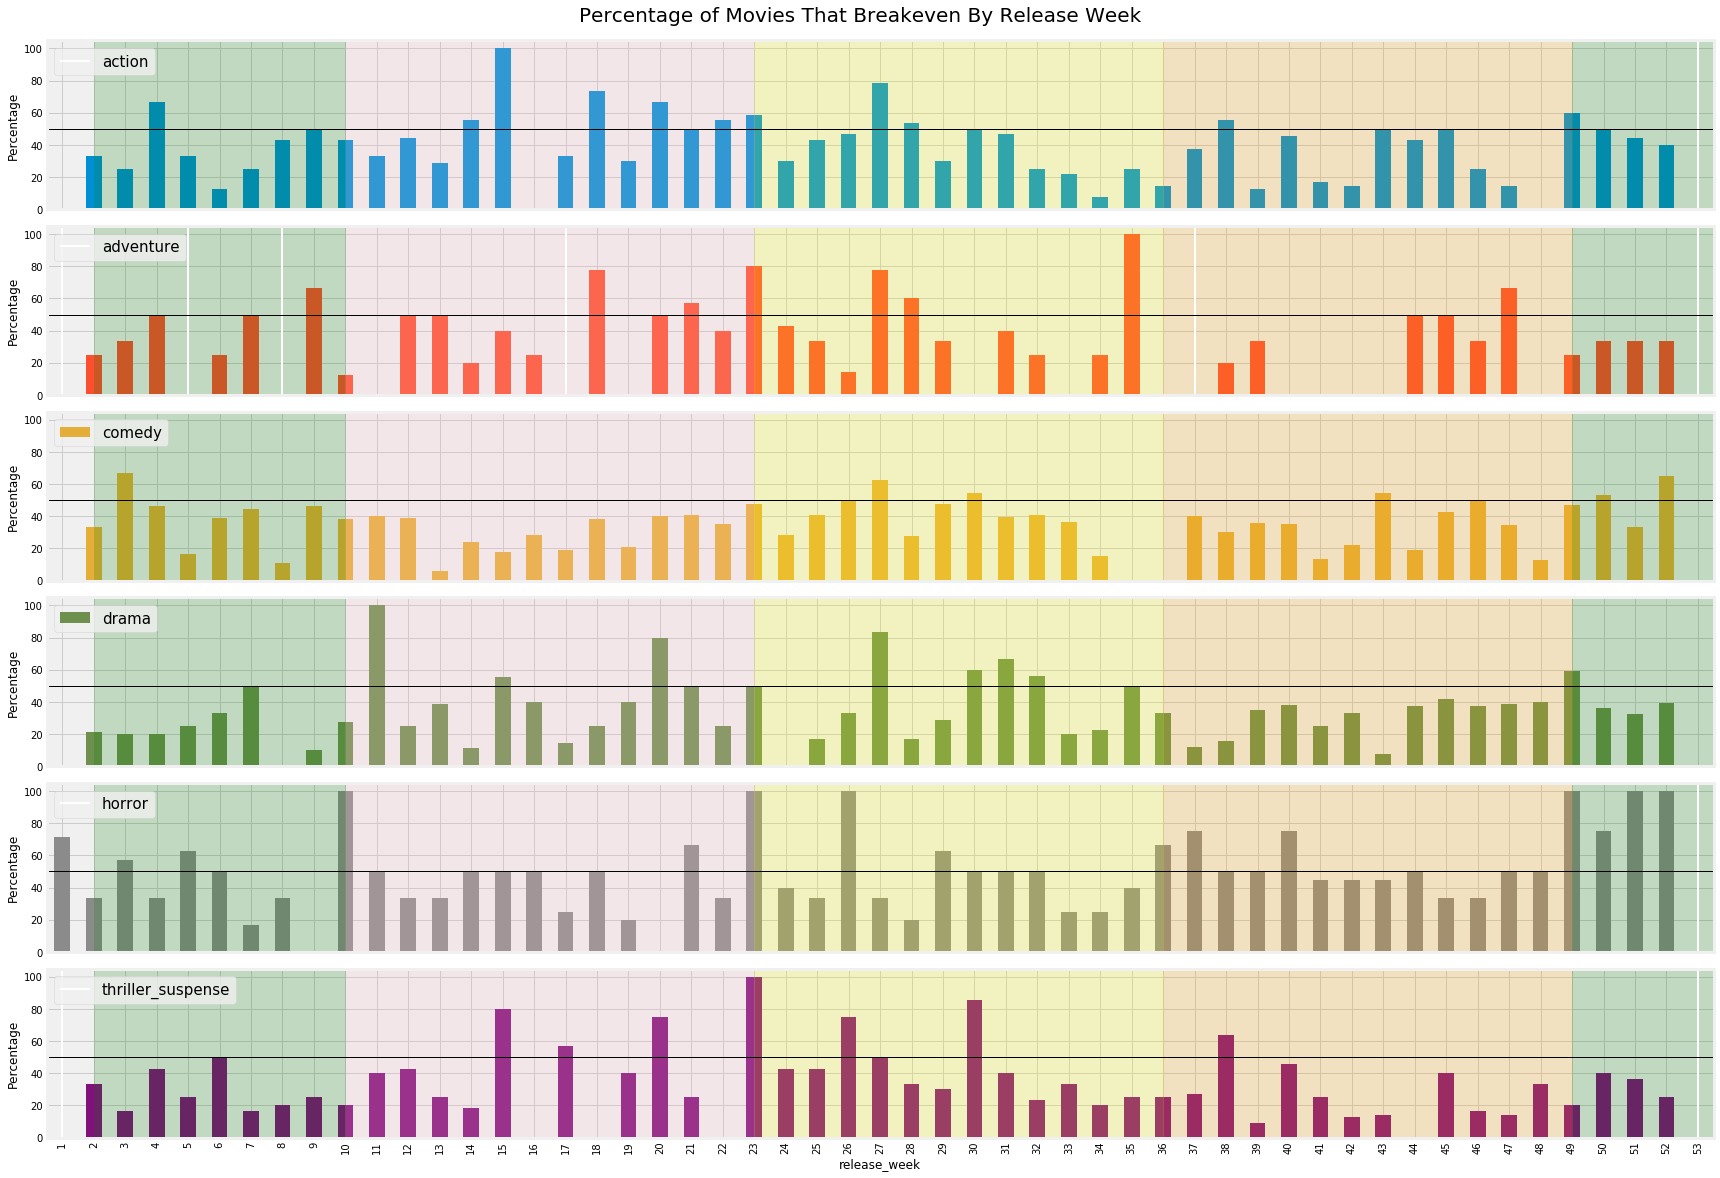

In [80]:
release_weeks_with_no_movies_all_time = [0] * 6
counter = [0, 1, 2, 3, 4, 5]

figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Percentage of Movies That Breakeven By Release Week', fontsize=20, y=1.02)

for genre, axis, color, count in zip(genres, axes.flat, colors, counter):
    # Create two series with decades as indexes and count and sum as values
    #grp_count = data[data[genre]].groupby('release_week')['worldwide_breakeven'].count().copy()
    #grp_sum = data[data[genre]].groupby('release_week')['worldwide_breakeven'].sum().copy()
    grp = data[data[genre]].groupby('release_week')['worldwide_breakeven'].mean() * 100
    
    # If the series is missing a decade, add it as an index
    # Then set the count to 1 and the sum to 0
    # This avoids division by zero problems when calculating the percentages
    for week in range(1, 54):
        if week not in grp.index:
            grp.loc[week] = 0
            axis.axvline(week - 1, color='white', linewidth=2)
            release_weeks_with_no_movies_all_time[count] += 1

    # Sort the series by their index to have the decades in chronological order                
    grp.sort_index(ascending=True, inplace=True)

    grp.plot(kind='bar', xticks=range(1, 54), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Percentage', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Show 50% breakeven line
    axis.axhline(50, color='k', linewidth=1)
    
    axis.axvspan(9, 22, alpha=0.2, color='pink')
    axis.axvspan(22, 35, alpha=0.2, color='yellow')
    axis.axvspan(35, 48, alpha=0.2, color='orange')
    axis.axvspan(48, 53, alpha=0.2, color='green')
    axis.axvspan(1, 9, alpha=0.2, color='green')
    
plt.tight_layout() 

<div class="alert alert-block alert-info">
    <b>The white vertical lines mean that no movies of that genre have ever been released on that week.</b>
    <br>
    <br>
    <b>The black horizontal line marks the 50% breakeven percentage.</b>
</div>

#### Quick Takeaways

It looks like historically the best chance to breakeven is with a Horror movie in December.

### This Decade

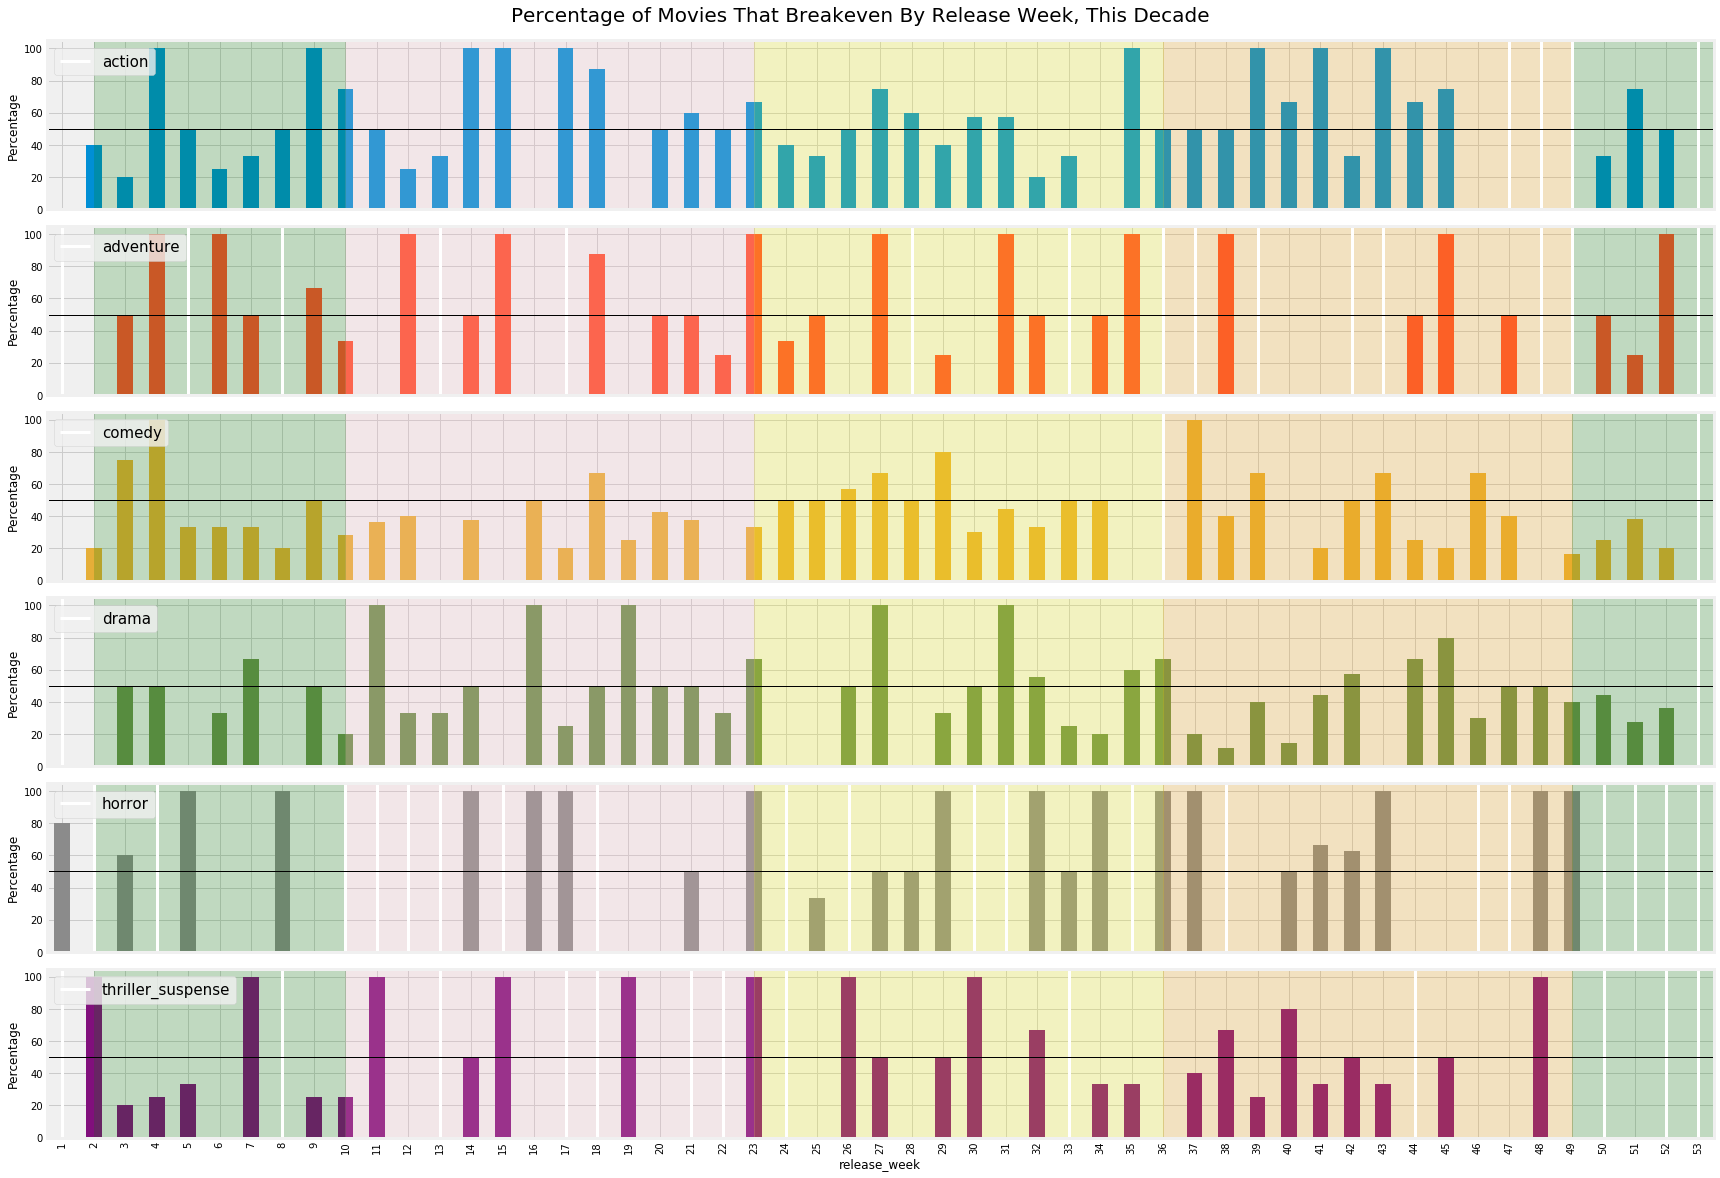

In [81]:
release_weeks_with_no_movies_this_decade = [0] * 6
counter = [0, 1, 2, 3, 4, 5]

figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Percentage of Movies That Breakeven By Release Week, This Decade', fontsize=20, y=1.02)

for genre, axis, color, count in zip(genres, axes.flat, colors, counter):
    # Create two series with decades as indexes and count and sum as values
    #grp_count = data[data[genre]].groupby('release_week')['worldwide_breakeven'].count().copy()
    #grp_sum = data[data[genre]].groupby('release_week')['worldwide_breakeven'].sum().copy()
    grp = data[(data['release_year'] >= 2010) & (data[genre])].groupby('release_week')['worldwide_breakeven'].mean() * 100
    
    # If the series is missing a decade, add it as an index
    # Then set the count to 1 and the sum to 0
    # This avoids division by zero problems when calculating the percentages
    for week in range(1, 54):
        if week not in grp.index:
            grp.loc[week] = 0
            axis.axvline(week - 1, color='white', linewidth=3)
            release_weeks_with_no_movies_this_decade[count] += 1

    # Sort the series by their index to have the decades in chronological order                
    grp.sort_index(ascending=True, inplace=True)

    grp.plot(kind='bar', xticks=range(1, 54), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Percentage', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Show 50% breakeven line
    axis.axhline(50, color='k', linewidth=1)
    
    axis.axvspan(9, 22, alpha=0.2, color='pink')
    axis.axvspan(22, 35, alpha=0.2, color='yellow')
    axis.axvspan(35, 48, alpha=0.2, color='orange')
    axis.axvspan(48, 53, alpha=0.2, color='green')
    axis.axvspan(1, 9, alpha=0.2, color='green')
    
plt.tight_layout() 

#### Quick Takeaways

It seems fewer release weeks are being utilized for some genres.

This might be coincidence, or it might be that studios don't think certain weeks work for some genres. 

In this decade, there are 20 weeks out of the year where a Horror movie hasn't been released!

In second place is Adventure with 15 missing weeks, then Thriller/Suspense with 13.

It seems like movies have a higher chance of breaking even this decade compared to the historical levels. This may be due to fewer movies being released overall, the growing assistance of the worlwide box office on a movie's financial picture, or studios being smarter about movie selection.

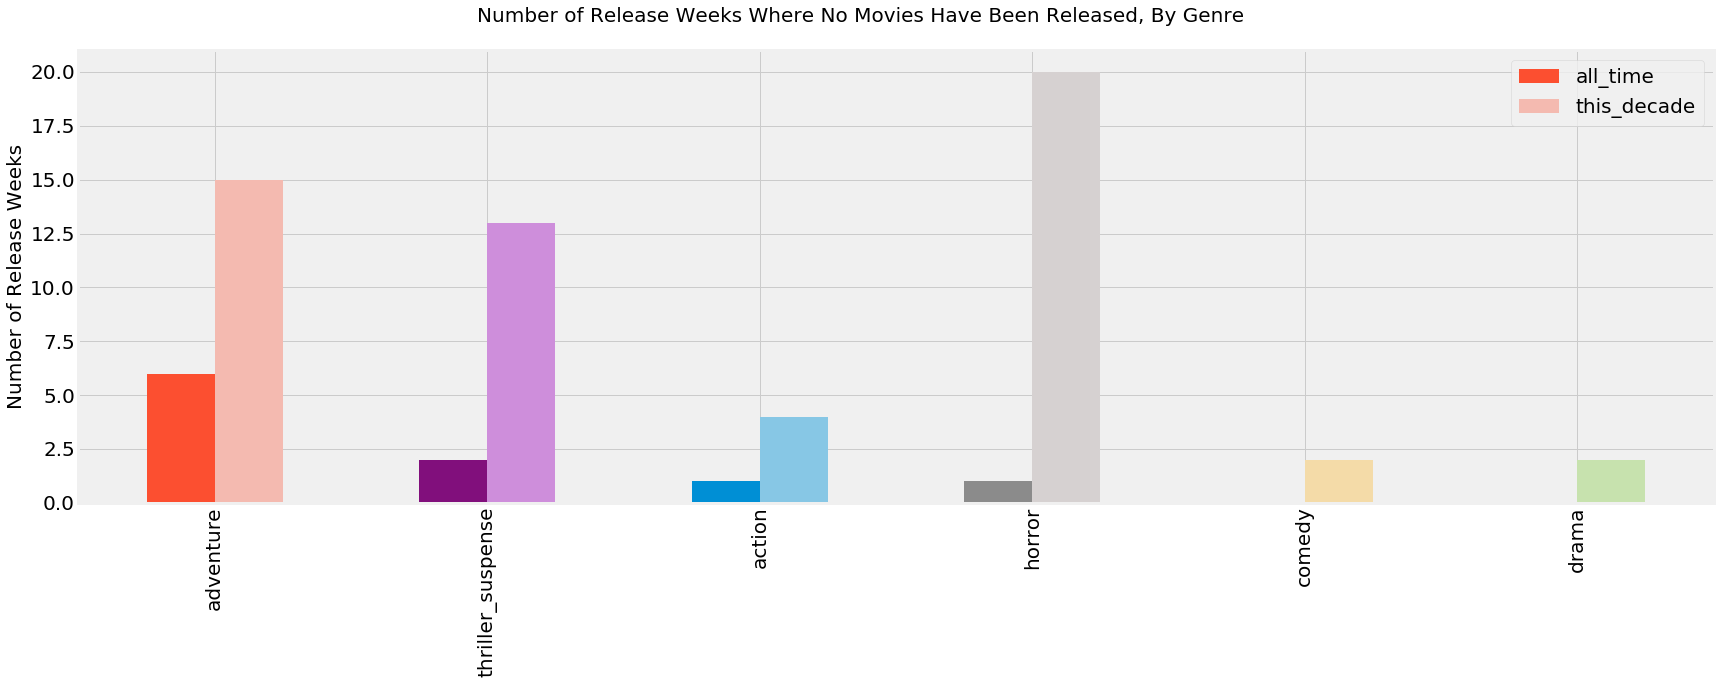

In [147]:
release_week = pd.DataFrame({'all_time': release_weeks_with_no_movies_all_time, 'this_decade': release_weeks_with_no_movies_this_decade}, index=genres)
release_week.sort_values(by='all_time', ascending=False, inplace=True)

color_list = generate_color_list(colors_needed=2, order_list=release_week.index)

figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Number of Release Weeks Where No Movies Have Been Released, By Genre', fontsize=20, y=1.05)
release_week.plot(kind='bar', ax=axis, color=color_list)
axis.set_ylabel('Number of Release Weeks', fontsize=20)
axis.tick_params(labelsize=20)
axis.legend(fontsize=20)

plt.tight_layout()

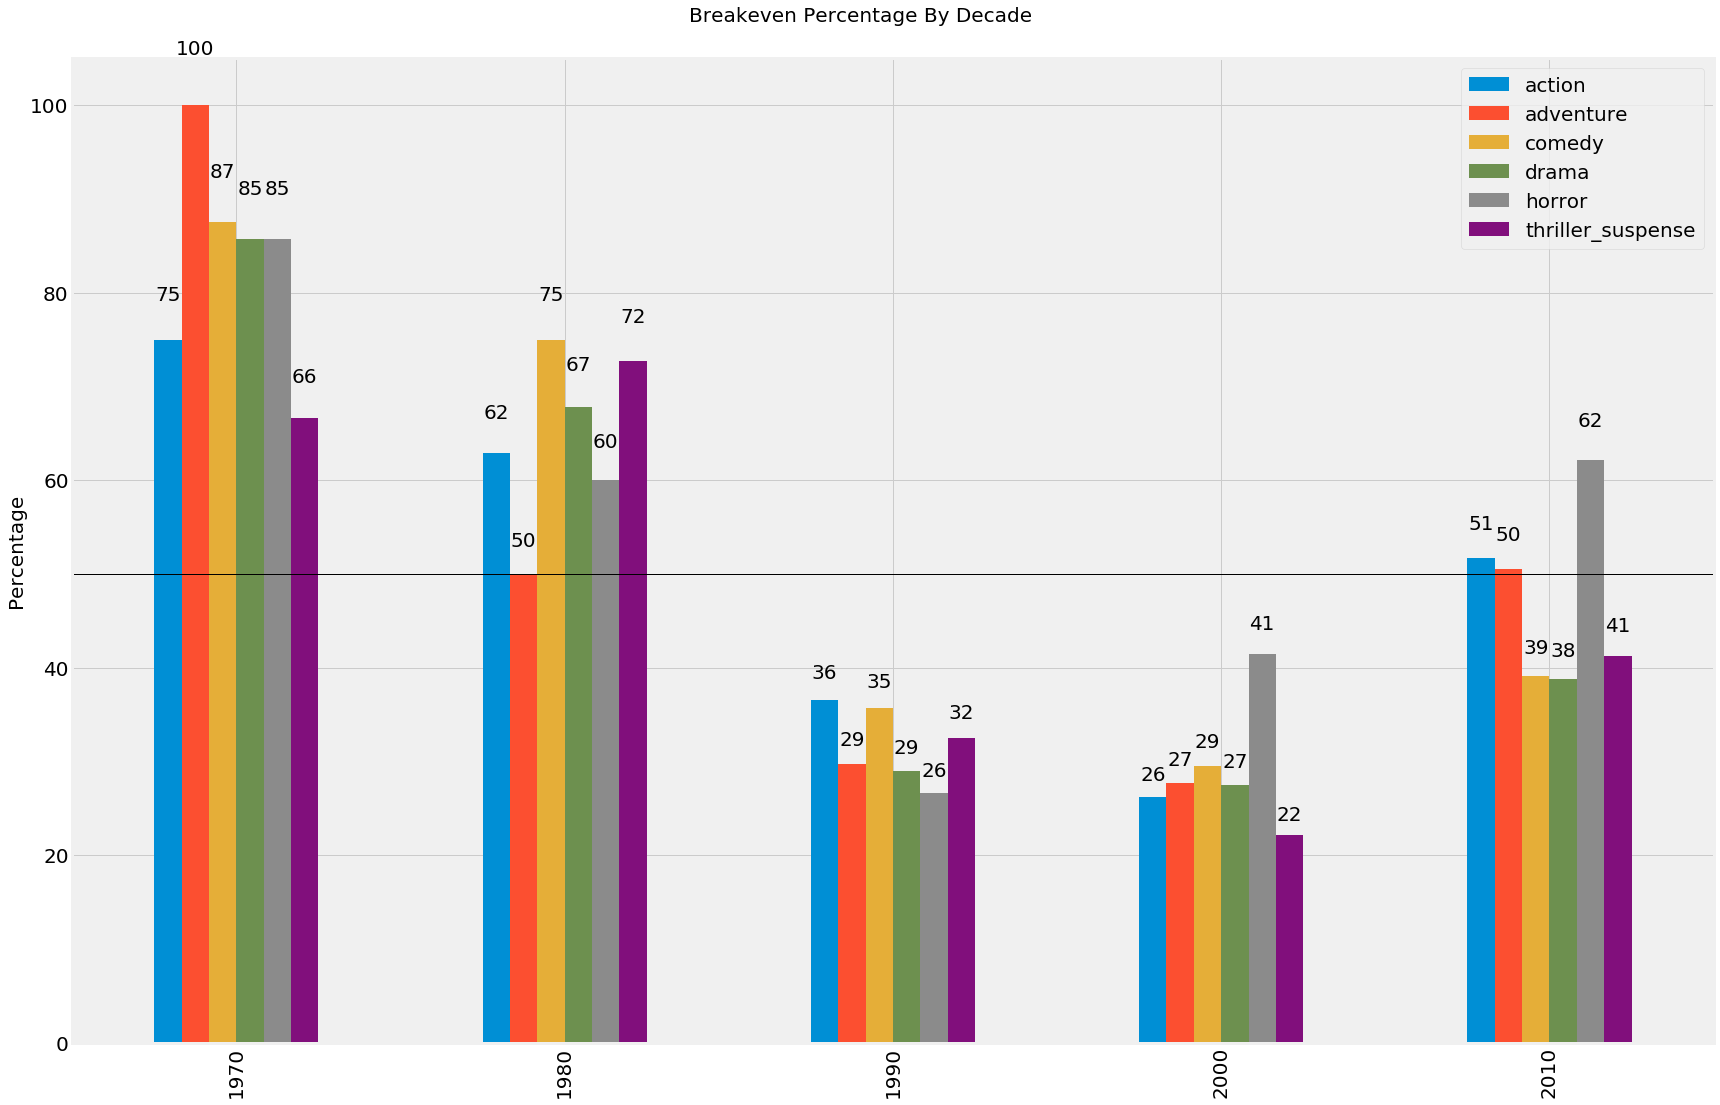

In [83]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Breakeven Percentage By Decade', fontsize=20, y=1.02)

grp = data.groupby('release_decade')[breakeven_columns].mean() * 100
                                                                           
grp.plot(kind='bar', ax=axis, figsize=(24,15))
axis.set_ylabel('Percentage', fontsize=20)
axis.set_xlabel('')
axis.legend(genres, fontsize=20)
axis.tick_params(labelsize=20)
axis.axhline(50, color='black', linewidth=1)
autolabel(axis)

plt.tight_layout()

#### Quick Takeaways

**Current Decade**
  - We are on an uptick in the probability that a movie made will breakeven, regardless of genre!
  - A few factors are that fewer movies are released overall and that the explosion in foreign box office is buoying all genres

## Quick Takeaways
- `Action`, `Adventure` and `Thriller/Suspense` have the largest number of release weeks with no chance of breaking even domestically
- `Comedy` and `Drama` are the least affected by release week. They can be profitable when released on almost any week
- Each genre has had a chance at every release week (except the 53rd week which doesn't really count). Whether the success or failure can partially be attributed to the release week is another story. 

## Summary

  - Action and Adventure are currently performing better than they have historically regardless of release week.
  - Horror, Adventure, and Thriller/Suspense have been released on the fewest weeks this decade
  - Budgets have risen this decade for Action and Adventure, whereas they have dropped for Horror and Thriller/Suspense
  - All genres have a higher breakeven percentage this decade than they do historically
  - From a median profitability standpoint this decade, Action and Adventure are the clear winnners

# Conclusions, Conclusions, Conclusions

Our bosses want us to wrap this up at some point, so here we go...

Dear, sweet bosses, 

Can you give us data on ancillary revenue streams of these movies like DVD/Blu-ray, TV Airings, and Streaming?

You can't?

You can't, or you won't?

Aha, I knew it! 

So please take these conclusions with a large grain of salt. So large it might be called a heap of salt. Or a salt mountain, if you please.

## Asterisk Conclusions Asterisk

**Safest**
  - I would classify no genre as safe. All genres historically have negative median profit. 
  - Just looking at this decade, three genres have positive median profit: Horror (\\$23.3 million), Adventure (\\$10.4 million), and Action (\\$5.7 million)
  - With a very low median production budget (\\$31 million) and the highest chance of breaking even this decade (62%), Horror seems like the safest genre to invest in.
  - Note that historically Horror 

**Highest potential return per movie**
  - If our boses want to maximize we are trying to maximize our revenue per movie produced, then either Action or Adventure are the best. They carry with them much higher production budgets, but also gross higher amounts than all other genres.

**Most calendar-friendly**
  - `Comedy` and `Drama` are the least affected by release week. If we want maximum flexibility there (for example, to avoid opening the same weekend as another big movie), we can plug and play one of these genres into almost any week.
  
**Recent box office trends**
  - In the past decade, the most consistent genre in terms of average performance per movie is `Horror`, followed by `Thriller/Suspense`. If we want to follow trends, these genres carry lower production budgets than the blockbuster genres, but our return ceiling is definitely capped.
  
**Advice to our bosses**
  - We need to investigate these genres according to their worldwide box office results. It's good to know how the domestic market is, but increasingly, a movie's profitability depends heavily on the foreign market.
  - We will investigate this subject area next and see if the trends we've found here carry over.
  - If pressed for a genre to release domestically tomorrow, and our primary concern was not losing the studio's money, I would recommend `Horror`.

### Looking At `Profit`

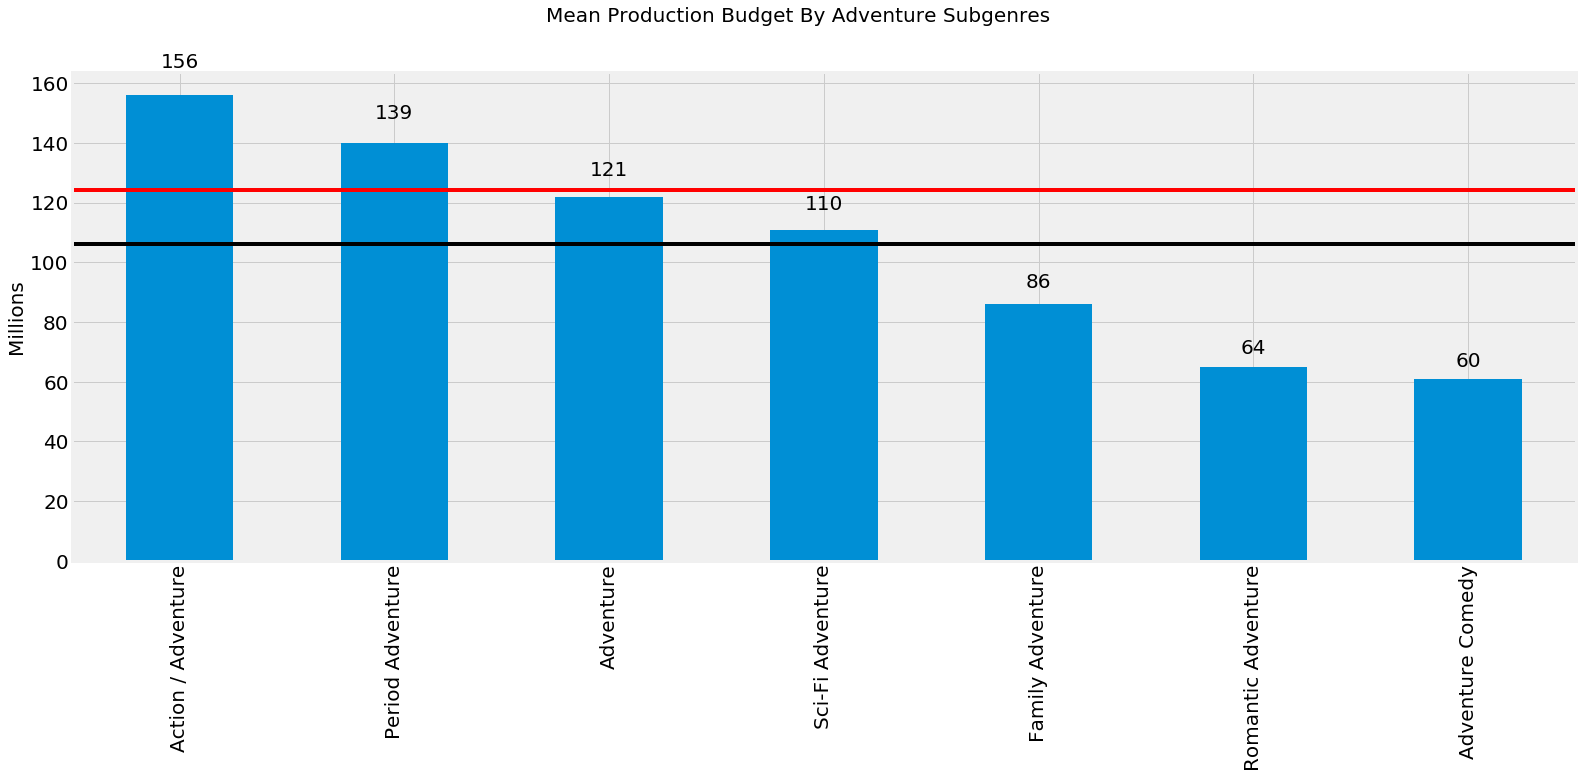

In [84]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Mean Production Budget By Adventure Subgenres', fontsize=20)

adventure_movies = data[data['genres_mojo'].str.contains('Adventure')]

grp = adventure_movies.groupby('genres_mojo')['budget_adj'].mean().sort_values(ascending=False) / 1000000

grp.plot(kind='bar')
axis.axhline(data[(data['genres_mojo'].str.contains('Adventure', na=False)) & (~data['genres_mojo'].isin(['Action / Adventure']))]['budget_adj'].mean() / 1000000, color='k')
axis.axhline(data[(data['genres_mojo'].str.contains('Adventure', na=False))]['budget_adj'].mean() / 1000000, color='r')
axis.tick_params(labelsize=20)
axis.set_xlabel('')
axis.set_ylabel('Millions', fontsize=20)
#axis.annotate('Mean With Action / Adventure: {:.1f}'.format(data[(data['genres_mojo'].str.contains('Adventure', na=False))]['budget_adj'].mean() / 1000000), xy=(4, 128), fontsize=20, color='r')
#axis.annotate('Mean Without Action / Adventure: {:.1f}'.format(data[(data['genres_mojo'].str.contains('Adventure', na=False)) & (~data['genres_mojo'].isin(['Action / Adventure']))]['budget_adj'].mean() / 1000000), xy=(4, 110), fontsize=20, color='k')
autolabel(axis);

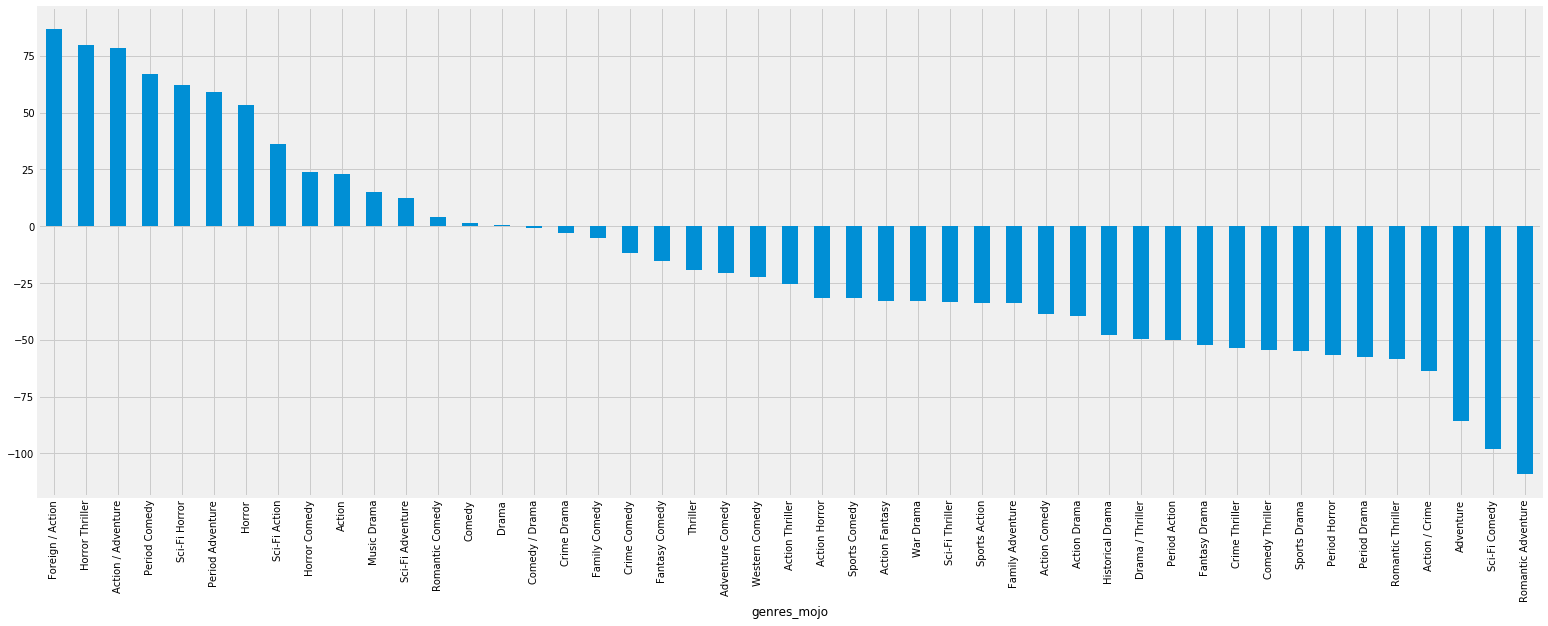

In [85]:
grp = data.groupby('genres_mojo')['profit'].mean().sort_values(ascending=False) / 1000000
grp.plot(kind='bar', figsize=(24,9))

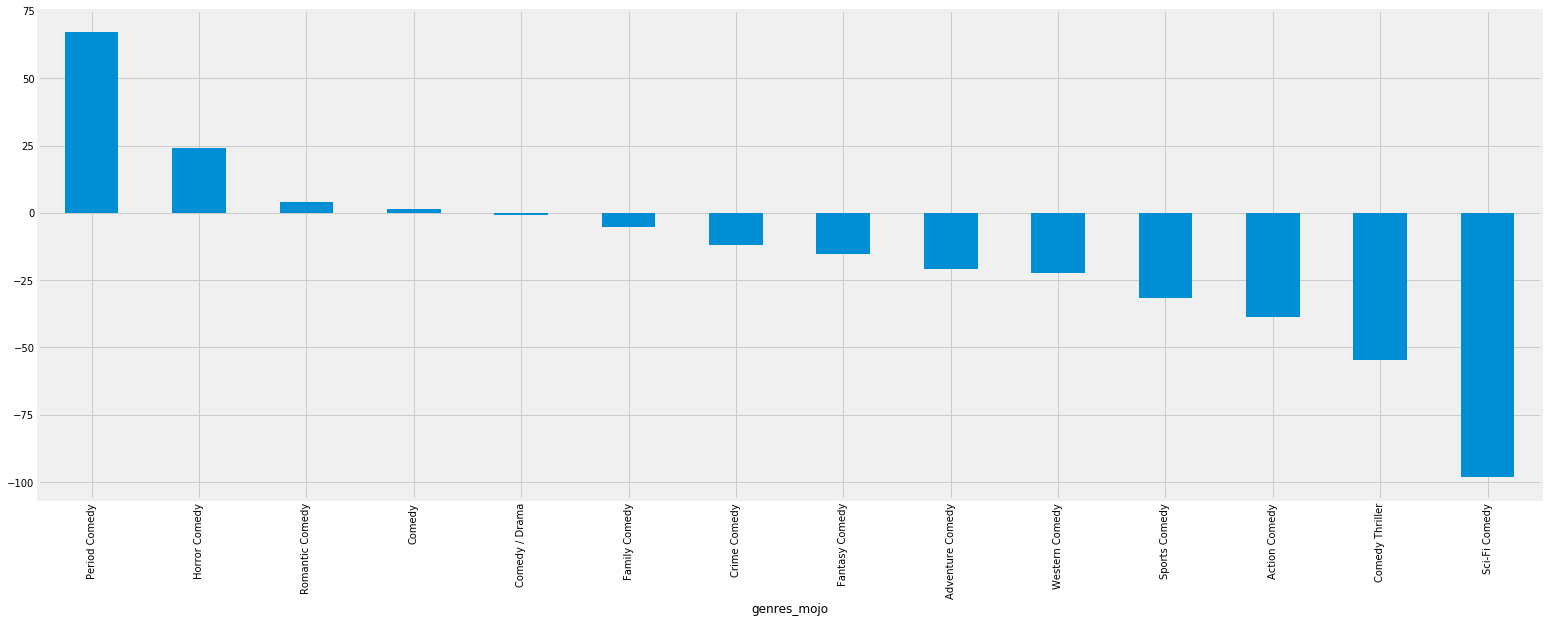

In [86]:
grp = data[data['genres_mojo'].str.contains('Comedy', na=False)].groupby('genres_mojo')['profit'].mean().sort_values(ascending=False) / 1000000
grp.plot(kind='bar', figsize=(24,9))

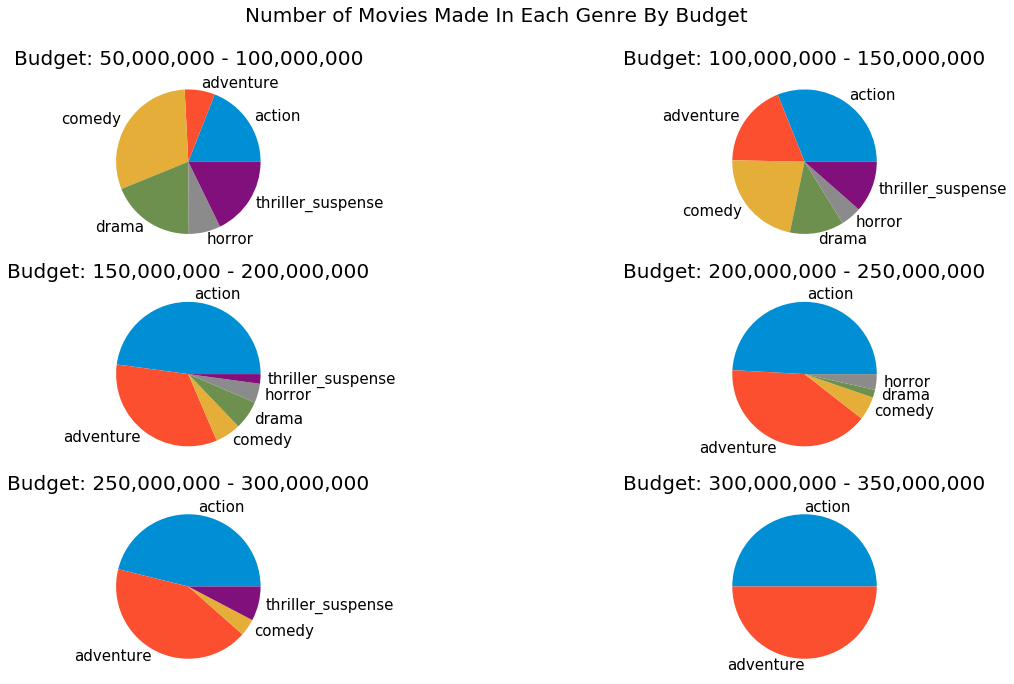

In [87]:
figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,9))
figure.suptitle('Number of Movies Made In Each Genre By Budget', fontsize=20, y=1.05)
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

budgets = range(50000000, 350000000, 50000000)

for budget, axis in zip(budgets, axes_list):
    data[(data['budget_adj'] >= 0 + budget) & (data['budget_adj'] < 50000000 + budget)][genres].sum().plot(kind='pie', ax=axis, fontsize=15)
    axis.set_ylabel('')
    axis.set_title('Budget: {:,} - {:,}'.format(0 + budget, 50000000 + budget), fontsize=20)
    
plt.tight_layout()

NameError: name 'worldwide_columns' is not defined

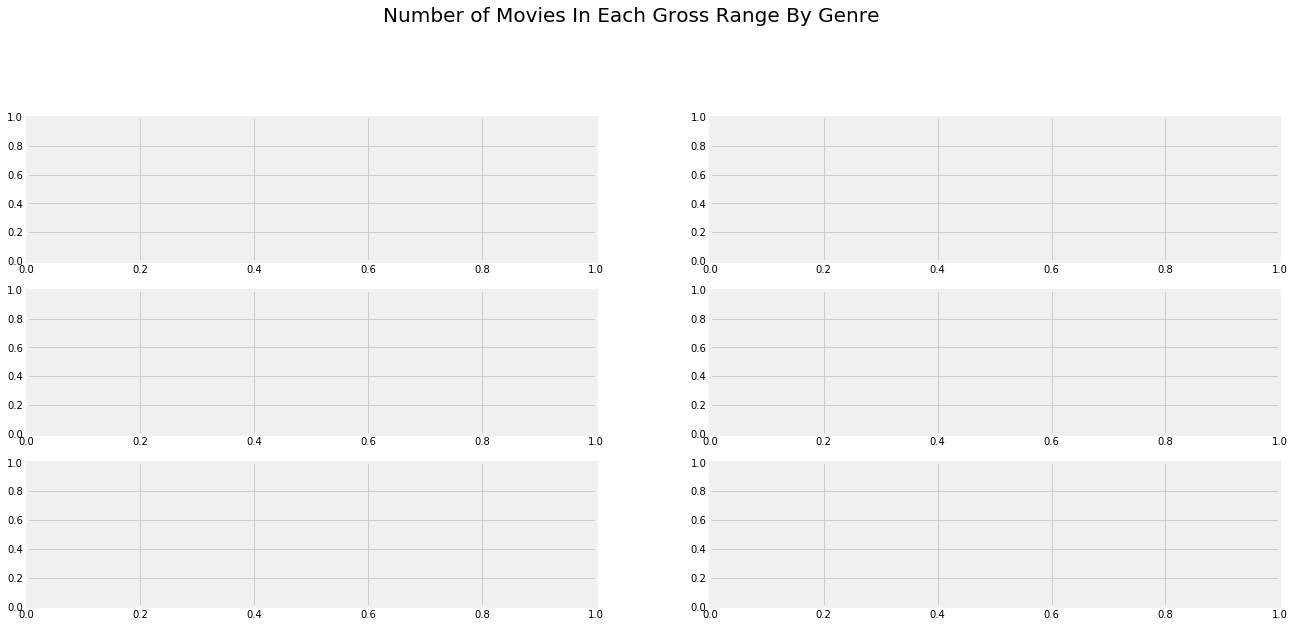

In [88]:
figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,9))
figure.suptitle('Number of Movies In Each Gross Range By Genre', fontsize=20, y=1.05)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

grosses = range(0, 1200000000, 200000000)

for gross, axis in zip(grosses, axes_list):
    data[(data['worldwide_adj'] >= 0 + gross) & (data['worldwide_adj'] < gross + 200000000)][worldwide_columns].count().plot(kind='pie', ax=axis, fontsize=15, labels=genres)
    axis.set_ylabel('')
    axis.set_title('Gross: {:,} - {:,}'.format(0 + gross, 200000000 + gross), fontsize=20)
    
plt.tight_layout()

In [ ]:
figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,9))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

grosses = range(0, 1200000000, 200000000)

for gross, axis in zip(grosses, axes_list):
    data[(data['worldwide_adj'] >= 0 + gross) & (data['worldwide_adj'] < gross + 200000000) & (data['release_year'] >= 2010)][worldwide_columns].sum().plot(kind='pie', ax=axis, fontsize=15, labels=genres)
    axis.set_ylabel('')
    axis.set_title('Gross: {:,} - {:,}'.format(0 + gross, 200000000 + gross), fontsize=20)
    
plt.tight_layout()

In [ ]:
figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,9))
figure.suptitle('Ratio of Total Gross By Decade And Genre', fontsize=20, y=1.05)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

decades = range(1960, 2020, 10)

for decade, axis in zip(decades, axes_list):
    data[data['release_decade'] == decade][worldwide_columns].sum().plot(kind='pie', ax=axis, fontsize=15, labels=genres)
    axis.set_ylabel('')
    axis.set_title('{}s'.format(decade), fontsize=20)
    
plt.tight_layout()

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=2, figsize=(20,40))
figure.suptitle('Ratio Versus Total Gross By Decade And Genre', fontsize=20, y=1.05)

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12 = axes.flatten()
axes_list1 = [ax1, ax3, ax5, ax7, ax9, ax11]
axes_list2 = [ax2, ax4, ax6, ax8, ax10, ax12]

decades = range(1960, 2020, 10)

for decade, axis1, axis2 in zip(decades, axes_list1, axes_list2):
    (data[data['release_decade'] == decade][worldwide_columns].sum() / 1000000000).plot(kind='pie', ax=axis1, fontsize=12, labels=genres)
    (data[data['release_decade'] == decade][worldwide_columns].sum() / 1000000000).plot(kind='bar', ax=axis2, fontsize=12, ylim=(0,80))
    axis1.set_ylabel('')
    axis1.set_title('{}s Ratios'.format(decade), fontsize=20)
    axis2.set_xticklabels(genres)
    axis2.set_title('{}s Totals'.format(decade), fontsize=20)
    axis2.set_ylabel('Billions', fontsize=20)
plt.tight_layout()

In [ ]:
# We want individual columns that hold the worldwide gross for each genre
# Since a movie can have multiple genres, right now we must handle this by a groupby while looping over each genre
# If we create individual columns that contain information about a genre and its worldwide box office, it's easier to graph
def worldwide_gross_by_genre(row, genre):
    # Returns either 0 or the `worldwide_adj` value due to boolean multiplication
    test = row[genre] * row['worldwide_adj']
    
    # If the row is not in the genre (i.e. False * $100 = 0)
    if test == 0:
        return np.nan
    else:
        return test

# List of new columns to hold worldwide grosses by genre
worldwide_columns = ['worldwide_gross_{}'.format(genre) for genre in genres]

for genre, col in zip(genres, worldwide_columns):
    data[col] = data.apply(lambda x: worldwide_gross_by_genre(x, genre), axis=1)

### Quick Takeaways

**All-Time Gross Per Genre**
  - In aggregate, `Action`, `Comedy`, then `Adventure` have grossed the most money worldwide
  - `Action` is ahead of `Comedy` by almost \\$16 billion dollars
  
**Recent Trends**
  - Grosses for `Action` and `Adventure` have been increasing since the 1990s
  - Grosses for `Comedy` have substantially decreased in the 2010s, but it is still the third-highest performing genre
  - Grosses for the other genres are all in decline

In [ ]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Dollars Earned For Every Dollar Spent (Includes Marketing)', fontsize=20, y=1.02)

summary.sort_values('dollars_earned_for_dollars_spent', ascending=False, inplace=True)

summary.plot(y=['dollars_earned_for_dollars_spent', 'mean_dollars_earned_for_dollars_spent', 'median_dollars_earned_for_dollars_spent'], kind='bar', ax=axis, color=colors[0:3], legend=True)
axis.set_ylabel('Dollars', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
axis.legend(['All-Time', 'Mean', 'Median'], fontsize=20)
autolabel(axis, num_decimals=1)

plt.tight_layout()

# What We Know So Far

**Dataset limitations**
  - Our data only contains entries from the Big Five studios that have both Worldwide Gross information and Budget information.
  - We chose to limit our entries to movies by the Big Five to control for lack of promotion or budget hindering a film's chances. 
  - As such, there are obviously many movies that are missing from our analyais. 
  - Hopefully, the overall pattern of movie returns is captured in the data we have, but we very easily could have a misrepresentative sample.
  
**Number of movies**
  - `Comedy` and `Drama` are historically the most produced genres by big movie studios by a healthy margin

**Skewed grosses**
  - Worldwide gross is heavily right-skewed. 
  - It has a much higher median than mean (almost double!)
  - This fits with our understanding of the movie business -- there are a few megahits that earn outsized returns while the majority of movies earn a little or even lose money
  
**Skewed budgets**
  - Budgets are also heavily right-skewed, but with a much shorter right-tail than worldwide gross
  - This also fits our understanding of the movie business -- most movies are made for relatively small budgets, and there are only a few blockbusters made that have very large budgets
  
**Skewed profits**
  - Profits are also skewed to the right.
  - It's interesting that both mean and median profits are negative. Movies are indeed not a slam-dunk investment.
  
**Use median**
  - We will err on the side of using the median for our summary statistic. Our bosses are looking for insight into what they can expect as an average return from a movie they produce. We'd all like to have the mega blockbusters, but to keep their expectations in check, we will report a more fair assessment of our prospects.

**Highest gross**
  - Action, Comedy, and Adventure have grossed the most money. 
  
**Profitability**
  - Horror, Adventure, and Action are the only genres that are net winners.
  
**Median profit**
  - No genre is a net winner in terms of median profit
  
**Mean profit**
  - Horror has the biggest boost from the right skew in terms of mean profitability.
  - Adventure and Action also go from net losers to net winners when looking at mean profits.
  
**Thoughts**
  - We are going to dig way deeper, but it's nice to get a sense of the overall big picture by genre.

**Far from a sure thing**
  - Using our formula where profits begin after grossing three times the budget, we see that there are no clear and obvious genres to invest in.
  - It seems like the success or failure of a movie probably stems from the individual circumstances of each movie rather than solely from its categorization.

**All-Time Gross Per Genre**
  - In aggregate, Action, Comedy, then Adventure have grossed the most money worldwide
  - Action is ahead of Comedy by almost \\$16 billion dollars

**Skewed dataset**
  - Our dataset with respect to budget and gross is heavily skewed to the right. We can see we have much higher mean grosses than median grosses. This fits with our understanding of the movie business as a whole where very few blockbusters make up the slack for the more numerous smaller budgeted movies studios release. 

**Skew**
  - Even subdivided by genre, the gross distributions are all right-skewed.
  
**Mean and median**
  - Mean and median gross for Adventure and Action are far higher than any other genre
  - Adventure's median gross is approximately 2.6 times as large as the third place median gross, Horror.
  - The most common gross amount in every genre except Adventure is $0 - \\$50 milllion
  
**Action/Adventure**
  - These two genres have the biggest spread between mean and median gross
  - Something to keep in mind is the frequency of movies labeled as Action/Adventure. In our analysis, such movies would count towards both Action and Adventure movies. (We are assigning movies to every genre they have.) 
  - Since both of these genres are big on spectacle, they tend to be more likely to be blockbuster material 
  - We might have a situation where duplicate entries in both columns are artificially boosting their totals
  - Let's investigate this a little further  
  
**Number of movies**
  - Comedy and Drama are historically the most produced genres by big movie studios by a healthy margin
  
**Gross**
  - Adventure and Action have the highest median gross
  - Adventure's median gross is approximatley 2.7 times the third place genre's, Horror
  
**Budget**
  - Adventure and Action have by far the largest median production budget. This makes sense, as those movies tend to require more setpieces and CGI than other genres
  - Both Adventure and Action are at least double the median budget of the third place genre, Thriller/Suspense
  - Comedy, Horror, and Drama all have very similar, low median budgets 
  
**Median production budget**
  - Adventure and Action have by far the largest median budget. This makes sense, as those movies tend to require more setpieces and CGI than other genres
  - Adventure is 2.3 times the median budget of the third place genre, Thriller/Suspense
  - Comedy, Horror, and Drama all have very similar, low median production budgets 
  - Production budgets are also right-skewed, but they have far less skew than worldwide grosses
  
**Low budgets**
  - We can tell by the median production budget of 41.2 million that the majority of movies produced have a relatively small budget
  - Blockbusters (those costing 200-300 million dollars) are the exception, rather than the rule
  - Something to keep in mind is if this trend has changed in the past decade

**Movies are a tough business**
  - Just looking at the aggregate movie data we have, it seems like almost no genre is a safe bet.
  - No genre (when including all its subgenres) has a positive median profitability.
  - The only subgenres with a positive median profit are (in descending order) Foreign/Action, Action/Adventure, Horror, and Music Drama.

**The skew strongly affects the results**
  - If we look at mean profits instead of median, the results are much different.
  - Horror, Adventure, and Action are all profitable on the genre level
  - In addition, many more subgenres are profitable in aggregate
  - This is the result of very high-earning movies drastically increasing the average return of other members of their subgenre.
  
**Same pattern when looking at median versus mean profits**
  - When directly using every single datapoint (`all-time` and `mean`), both Horror and Adventure are profitable in aggregate.
  - However, when using only the median results, Horror is breakeven and all other genres lose money.
  - This is evidence of the power of those long right tails in blockbusters' earnings.
  
**Less than 50%**
  - No genre has a better than 50% chance of breaking even.
  - The least risky one just from a breakeven perpective is Horror.
  - The next least risky movies are Action and Adventure.
    
## If A Decision Must Be Made Now

This would be a difficult decision to make. 

Action, Comedy, and Adventure have made the most overall money worldwide. Action and Adventure have far higher median worldwide grosses than Comedy. Comedy must be making up for this with its higher numbers of movies released. However, Adventure and Action are the two most expensive genres to make, whereas Comedy is fourth.

The highest aggregate return for every dollar spent comes from Horror, then Adventure.

The highest median profit per genre is Horror, then Comedy.

The genres with the three lowest median budgets are Drama, then Horror, then Comedy.

Movies have the best chance to breakeven in Horror, then Action, then Adventure.





When taking into account our domestic box office analysis, now we see the reason `Action` and `Adventure` movies are made. They were net losers domestically, but make up for this with much higher worldwide grosses. 
- `Action`:
  - Average domestic gross: \\$116 million
  - Average worldwide gross: \\$297 million

- `Adventure`:
  - Average domestic gross: \\$151 million
  - Average worldwide gross: \\$387 million

That's a difference of \\$181 million and \\$236 million respectively!  

There are a couple strategies our bosses can consider:

1) Go for the safest genre. Our bosses are less likely to lose big money on `Horror`. It's one the cheapest genres to produce and has the highest average dollar earned per dollar spent.

2) Swing for the fences. If they can afford to be risky, `Adventure` and `Action` historically have the highest earnings potential. This is probably due to their ability to travel well and be unimpeded by language barriers. Anyone in the world can watch a fight scene, car chase, or explosion and understand what's happening. 

Let's look at each genre's performance by decade to see if there are recent trends we can spot.

  - We will investigate genres by Release Decade and Release Week to look for more useful insights.

In [ ]:
# Create variables for first_axes, secondary_axes, and counter variables 
ax1, ax2, ax3, ax4, ax5, ax6 = 'abcdef'
first_axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

ax1_1, ax2_1, ax3_1, ax4_1, ax5_1, ax6_1 = 'abcdef'
second_axes_list = [ax1_1, ax2_1, ax3_1, ax4_1, ax5_1, ax6_1]

# Counters to keep track of iteration
counters = [0, 1, 2, 3, 4, 5]

for genre, first_axis, second_axis, color, count in zip(genres, first_axes_list, second_axes_list, colors, counters):
        figure, first_axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
        second_axis = figure.add_axes()

        # Only write the title once
        if count == 0:
            figure.suptitle('Median Worldwide Gross By Genre And Decade\n(Counts Labeled)', fontsize=20, y=1.02)

        grp = (data[data[genre]].groupby('release_decade').median() / 1000000)['worldwide_adj'].copy()
        grp_counts = data[data[genre]].groupby('release_decade')['worldwide_adj'].count().copy()
    
        # If the series is missing a decade, add it as an index and set the value to zero
        for decade in range(1910, 2020, 10):
            if decade not in grp.index:
                grp.loc[decade] = 0
                grp_counts.loc[decade] = 0

        # Sort the series by its index to have the decades in chronological order                
        grp.sort_index(ascending=True, inplace=True)
        grp_counts.sort_index(ascending=True, inplace=True)
        
        # Set up y-axis    
        first_axis = grp.plot(kind='bar', xticks=range(1910, 2020, 10), linewidth=3, color=color)
        first_axis.set_ylabel('Worldwide Gross In Millions', fontsize=12)
        first_axis.set_ylim(0,900)
        first_axis.legend([genre], loc=2, fontsize=15)
        
        autolabel(first_axis, counts=grp_counts.values)
        
        # Set up second y-axis
        second_axis = first_axis.twinx()
        second_axis.plot(first_axis.get_xticks(), grp_counts.values, linewidth=3, color='k')
        second_axis.set_ylabel('Number of Movies', fontsize=12)
        second_axis.set_ylim(0,600)
        second_axis.legend(['counts'], loc=1, fontsize=15)
        
        # Only show graphs when on the last one
        if count == len(counters) - 1:
            plt.tight_layout()

In [ ]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Number of Movies Released By Decade and Genre', fontsize=20, y=1.02)

grp = data.groupby('release_decade')['action', 'adventure', 'comedy', 'drama', 'horror', 'thriller_suspense'].sum()

grp.plot(kind='bar', stacked=True, ax=axis)
axis.set_ylabel('Number of Movies', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
axis.legend(fontsize=20)

plt.tight_layout()

### Only Looking At Movies With A Production Budget

In [ ]:
has_budget = data[data['budget_adj'].notna()].copy()
has_budget.info()

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Dollars Earned For Every Dollar Spent By Decade (Includes Marketing)', fontsize=20, y=1.05)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres, axes_list, colors):
    # Create two series with decades as indexes and count and sum as values
    grp_gross_count = has_budget[has_budget[genre]].groupby('release_decade')['worldwide_adj'].count().copy()
    grp_gross_sum = has_budget[has_budget[genre]].groupby('release_decade')['worldwide_adj'].sum().copy()
    
    grp_budget_count = has_budget[has_budget[genre]].groupby('release_decade')['budget_adj'].count().copy()
    grp_budget_sum = has_budget[has_budget[genre]].groupby('release_decade')['budget_adj'].sum().copy()

    # If the series is missing a decade, add it as an index
    # Then set the count to 1 and the sum to 0
    # This avoids division by zero problems when calculating the percentages
    for decade in range(1910, 2020, 10):
        if decade not in grp_gross_count.index:
            grp_gross_count.loc[decade] = 0
            grp_gross_sum.loc[decade] = 0
        
        if decade not in grp_budget_count.index:
            grp_budget_count.loc[decade] = 0
            grp_budget_sum.loc[decade] = 1

    # Sort the series by their index to have the decades in chronological order                
    grp_gross_count.sort_index(ascending=True, inplace=True)
    grp_gross_sum.sort_index(ascending=True, inplace=True)
    grp_budget_count.sort_index(ascending=True, inplace=True)
    grp_budget_sum.sort_index(ascending=True, inplace=True)
    
    dollars_earned_to_dollars_spent = round((grp_gross_sum / (3 * grp_budget_sum)), 1)
            
    dollars_earned_to_dollars_spent.plot(kind='bar', xticks=range(1910, 2020, 10), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Dollars', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Put the percentage of how many movies breakeven above each bar
    autolabel(axis, num_decimals=1)
    
plt.tight_layout() 

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Dollars Earned For Every Dollar Spent By Decade (Includes Marketing)\n(Counts Labeled)', fontsize=20, y=1.05)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres, axes_list, colors):
    # Create two series with decades as indexes and count and sum as values
    grp_gross_count = has_budget[has_budget[genre]].groupby('release_decade')['worldwide_adj'].count().copy()
    grp_gross_sum = has_budget[has_budget[genre]].groupby('release_decade')['worldwide_adj'].sum().copy()
    
    grp_budget_count = has_budget[has_budget[genre]].groupby('release_decade')['budget_adj'].count().copy()
    grp_budget_sum = has_budget[has_budget[genre]].groupby('release_decade')['budget_adj'].sum().copy()

    # If the series is missing a decade, add it as an index
    # Then set the count to 1 and the sum to 0
    # This avoids division by zero problems when calculating the percentages
    for decade in range(1910, 2020, 10):
        if decade not in grp_gross_count.index:
            grp_gross_count.loc[decade] = 0
            grp_gross_sum.loc[decade] = 0
        
        if decade not in grp_budget_count.index:
            grp_budget_count.loc[decade] = 0
            grp_budget_sum.loc[decade] = 1

    # Sort the series by their index to have the decades in chronological order                
    grp_gross_count.sort_index(ascending=True, inplace=True)
    grp_gross_sum.sort_index(ascending=True, inplace=True)
    grp_budget_count.sort_index(ascending=True, inplace=True)
    grp_budget_sum.sort_index(ascending=True, inplace=True)
    
    dollars_earned_to_dollars_spent = round((grp_gross_sum / (3 * grp_budget_sum)), 1)
            
    dollars_earned_to_dollars_spent.plot(kind='bar', xticks=range(1910, 2020, 10), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Dollars', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Put the count of how many movies breakeven above each bar
    autolabel(axis, counts=grp_gross_count.values)
    
plt.tight_layout() 

### Quick Takeaways

**Recent data is more reliable**
  - We don't have many movies before the 1970s, so drawing conclusions there seems risky. For example, the huge spike in `Horror` in 1950 is due to a single movie.
  - We should be able to trust the more recent data as there are far more movies available.
  
**Last three decades**
  - `Horror`, `Comedy`, and `Drama` are the best dollar for dollar movies.

# Extras

In [ ]:
# Create worldwide gross by genre columns
def breakeven_by_genre(row, genre):
    if row[genre] is False:
        return np.nan
    
    if row['worldwide_breakeven'] is False:
        return 0
    else:
        return 1
    
# List of new columns to hold worldwide grosses by genre
breakeven_columns = ['breakeven_{}'.format(genre) for genre in genres]

for genre, col in zip(genres, breakeven_columns):
    data[col] = data.apply(lambda x: breakeven_by_genre(x, genre), axis=1)

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Dollars Earned For Every Dollar Spent This Decade (Includes Marketing)', fontsize=20, y=1.05)

for genre, axis, color in zip(genres, axes.flat, colors):
    # Create two series with decades as indexes and count and sum as values
    
    grp_gross_count = current_with_budget[current_with_budget[genre]].groupby('release_year')['worldwide_adj'].count().copy()
    grp_gross_sum = current_with_budget[current_with_budget[genre]].groupby('release_year')['worldwide_adj'].sum().copy()
    
    grp_budget_count = current_with_budget[current_with_budget[genre]].groupby('release_year')['budget_adj'].count().copy()
    grp_budget_sum = current_with_budget[current_with_budget[genre]].groupby('release_year')['budget_adj'].sum().copy()

    # If the series is missing a decade, add it as an index
    # Then set the count to 1 and the sum to 0
    # This avoids division by zero problems when calculating the percentages
    for year in range(2010, 2019, 1):
        if year not in grp_gross_count.index:
            grp_gross_count.loc[year] = 0
            grp_gross_sum.loc[year] = 0
        
        if year not in grp_budget_count.index:
            grp_budget_count.loc[year] = 0
            grp_budget_sum.loc[year] = 1

    # Sort the series by their index to have the decades in chronological order                
    grp_gross_count.sort_index(ascending=True, inplace=True)
    grp_gross_sum.sort_index(ascending=True, inplace=True)
    grp_budget_count.sort_index(ascending=True, inplace=True)
    grp_budget_sum.sort_index(ascending=True, inplace=True)
        
    dollars_earned_to_dollars_spent = round((grp_gross_sum / (3 * grp_budget_sum)), 1)
            
    dollars_earned_to_dollars_spent.plot(kind='bar', xticks=range(2010, 2019, 1), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Dollars', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Put the percentage of how many movies breakeven above each bar
    autolabel(axis, num_decimals=1)
    
plt.tight_layout() 

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Aggregate Dollars Earned For Every Dollar Spent This Decade (Includes Marketing)', fontsize=20, y=1.05)

for genre, axis, color in zip(genres, axes.flat, colors):
    # Create two series with decades as indexes and sum as values
    grp_gross_sum = data[(data[genre]) & (data['release_year'] >= 2010)].groupby('release_year')['worldwide_adj'].sum().copy()
    grp_budget_sum = data[(data[genre]) & (data['release_year'] >= 2010)].groupby('release_year')['budget_adj'].sum().copy()

    # If the series is missing a decade, add it as an index
    # Then set the sum to 0
    for year in range(2010, 2019, 1):
        if year not in grp_gross_sum.index:
            grp_gross_sum.loc[year] = 0
        
        if year not in grp_budget_sum.index:
            grp_budget_sum.loc[year] = 0

    # Sort the series by their index to have the decades in chronological order                
    grp_gross_sum.sort_index(ascending=True, inplace=True)
    grp_budget_sum.sort_index(ascending=True, inplace=True)
    
    dollars_earned_to_dollars_spent = round((grp_gross_sum / (3 * grp_budget_sum)), 1)
            
    dollars_earned_to_dollars_spent.plot(kind='bar', xticks=range(2010, 2019, 1), ax=axis, color=color)
    axis.set_ylabel('Dollars', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Put the percentage of how many movies breakeven above each bar
    autolabel(axis, num_decimals=1)
    
plt.tight_layout() 

In [ ]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('All-Time Profit Versus Current Decade Profit', fontsize=20, y=1.02)

summary.sort_values('all_time_profit', ascending=False, inplace=True)

summary.plot(y=['all_time_profit', 'current_decade_profit'], kind='bar', ax=axis)
axis.set_ylabel('Millions', fontsize=20)
axis.set_xlabel('')
axis.legend(['All-Time', 'Current Decade'], fontsize=20)
axis.tick_params(labelsize=20)
autolabel(axis, num_decimals=1)

plt.tight_layout()

In [ ]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('All-Time Profit Versus Current Decade Profit', fontsize=20, y=1.02)

summary.sort_values('median_profit', ascending=False, inplace=True)

summary.plot(y=['median_profit', 'current_decade_median_profit'], kind='bar', ax=axis)
axis.set_ylabel('Millions', fontsize=20)
axis.set_xlabel('')
axis.legend(['All-Time', 'Current Decade'], fontsize=20)
axis.tick_params(labelsize=20)
autolabel(axis, num_decimals=1)

plt.tight_layout()

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, figsize=(24, 16), sharex=True, sharey=True)
figure.suptitle('Number of Movies Released By Release Week, All-Time', fontsize=20, y=1.02)

for genre, axis, color in zip(genres, axes.flat, colors):
    grp = data[data[genre]].groupby('release_week')['title'].count()
    grp.plot(kind='bar', xticks=range(1, 54), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Count', fontsize=12)
    axis.set_xlabel('')
    axis.legend([genre], loc=2, fontsize=15)

plt.tight_layout() 

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, figsize=(24, 16), sharex=True, sharey=True)
figure.suptitle('Number of Movies Released By Release Week, This Decade', fontsize=20, y=1.02)

for genre, axis, color in zip(genres, axes.flat, colors):
    grp = data[(data['release_year'] >= 2010) & (data[genre])].groupby('release_week')['title'].count()
    grp.plot(kind='bar', xticks=range(1, 54), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Count', fontsize=12)
    axis.set_xlabel('')
    axis.legend([genre], loc=2, fontsize=15)

plt.tight_layout() 

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Median Gross By Release Week, All-Time', fontsize=20, y=1.02)

for genre, axis, color in zip(genres, axes.flat, colors):
    grp = data[data[genre]].groupby('release_week').median() / 1000000
    grp.plot(kind='bar', y='worldwide_adj', xticks=range(1, 54), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Millions', fontsize=12)
    axis.set_xlabel('')
    axis.legend([genre], loc=2, fontsize=15)

plt.tight_layout() 

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Median Gross By Release Week, This Decade', fontsize=20, y=1.02)

for genre, axis, color in zip(genres, axes.flat, colors):
    grp = data[(data['release_year'] >= 2010) & (data[genre])].groupby('release_week').median() / 1000000
    grp.plot(kind='bar', y='worldwide_adj', xticks=range(1, 54), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Millions', fontsize=12)
    axis.set_xlabel('')
    axis.legend([genre], loc=2, fontsize=15)

plt.tight_layout() 

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Number of Movies By Release Week\n(Season Are Color-Coded)', fontsize=20, y=1.05)

for genre, axis, color in zip(genres, axes.flat, colors):
    grp1 = data[data[genre]].groupby('release_week')['title'].count()
    grp2 = data[(data['release_year'] >= 2010) & (data[genre])].groupby('release_week')['title'].count()
    
    for week in range(1, 54, 1):
        if week not in grp1.index:
            grp1.loc[week] = 0
            
        if week not in grp2.index:
            grp2.loc[week] = 0

    # Sort the series by its index to have the decades in chronological order                
    grp1.sort_index(ascending=True, inplace=True)
    grp2.sort_index(ascending=True, inplace=True)
    
    axis.plot(range(1,54), grp1, color=colors[0], label='All-Time')
    axis.plot(range(1,54), grp2, color=colors[1], label='This Decade') 
        
    axis.fill_between(range(1, 54), y1=grp1, y2=grp2, where=grp2 <= grp1, facecolor=colors[0], interpolate=True, edgecolor='k')
    axis.fill_between(range(1, 54), y1=grp1, y2=grp2, where=grp2 > grp1, facecolor=colors[1], interpolate=True, edgecolor='k')
    
    axis.set_title(genre, fontsize=20)
    
    axis.set_ylabel('Count', fontsize=12)
    axis.set_xlabel('')
    axis.legend(loc=2, fontsize=15)
    
    axis.axvspan(9, 22, alpha=0.2, color='pink')
    axis.axvspan(22, 35, alpha=0.2, color='yellow')
    axis.axvspan(35, 48, alpha=0.2, color='orange')
    axis.axvspan(48, 53, alpha=0.2, color='green')
    axis.axvspan(1, 9, alpha=0.2, color='green')

plt.tight_layout() 

### Quick Takeaways

**Current Trends Match Historical Trends**
  - We see very similar shapes for the counts of movies by release week when looked at in aggregate or in this decade
  
**Comedy**
  - The most elastic genre with regards to release week. Comedies are released in every week of the year in great numbers.
  - Big bump in releases in December.

**Drama**
  - Noticeable surge in releases towards the end of the year, especially in December.
  
**Horror**
  - Has a big bump around Halloween
  
**Action and Adventure**
  - Have a big bump in the summer
  
**Thriller/Suspense**
  - Seems to have the biggest bumps right before and right after summer, possibly to avoid competing with blockbusters

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Breakeven Percentage By Release Week\n(Seasons Are Color-Coded)', fontsize=20, y=1.05)

for genre, axis, color in zip(genres, axes.flat, colors):
    grp1 = data[data[genre]].groupby('release_week')['worldwide_breakeven'].mean() * 100
    grp2 = data[(data['release_year'] >= 2010) & (data[genre])].groupby('release_week')['worldwide_breakeven'].mean() * 100
    
    for year in range(1, 54, 1):
        if year not in grp1.index:
            grp1.loc[year] = 0
            
        if year not in grp2.index:
            grp2.loc[year] = 0

    # Sort the series by its index to have the decades in chronological order                
    grp1.sort_index(ascending=True, inplace=True)
    grp2.sort_index(ascending=True, inplace=True)
    
    axis.plot(range(1,54), grp1, color=colors[0], label='All-Time')
    axis.plot(range(1,54), grp2, color=colors[1], label='This Decade') 
        
    axis.fill_between(range(1, 54), y1=grp1, y2=grp2, where=grp2 <= grp1, facecolor=colors[0], interpolate=True, edgecolor='k')
    axis.fill_between(range(1, 54), y1=grp1, y2=grp2, where=grp2 > grp1, facecolor=colors[1], interpolate=True, edgecolor='k')
    
    axis.set_title(genre, fontsize=20)
    
    axis.set_ylabel('Percentage', fontsize=12)
    axis.set_xlabel('')
    axis.legend(loc=2, fontsize=15)
    axis.axvspan(9, 22, alpha=0.2, color='pink')
    axis.axvspan(22, 35, alpha=0.2, color='yellow')
    axis.axvspan(35, 48, alpha=0.2, color='orange')
    axis.axvspan(48, 53, alpha=0.2, color='green')
    axis.axvspan(1, 9, alpha=0.2, color='green')

plt.tight_layout() 

### Quick Takeaways

Action, Adventure, Comedy, and Drama seem safer from a breakeven perspective this decade compared to their historical levels.

The results are more mixed for Horror and Thriller/Suspense.